In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib
import time

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib inline
%matplotlib inline
# %matplotlib inline
# %matplotlib qt

In [3]:
import sys

# # sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
# # sys.path.append('/Users/Josh/Documents/github_repos/')
# sys.path.append(r'/content/drive/MyDrive/00 - ROI')
# dir_folders = r'/content/drive/MyDrive/00 - ROI/label_data'

# sys.path.append(f'{base_dir}/github_repos')
sys.path.append(f'/media/rich/Home_Linux_partition/github_repos')
# dir_folders = f'{base_dir}/label_data'


%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, decomposition, h5_handling, plotting_helpers
from GCaMP_ROI_classifier.new_stuff import util, models, training_simCLR, augmentation, training_classHead, training_supervised

Currently Exploring Directory # 1


## Import unlabeled training data

In [102]:
data_unlabeled = h5_handling.simple_load(path=r'/media/rich/bigSSD RH/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_balanced.h5')

masks_cat_raw = torch.as_tensor(np.concatenate((data_unlabeled['SYTmasks'], data_unlabeled['NPmasks'], data_unlabeled['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

toss any NaNs

In [121]:
print(f'Number of masks: {masks_cat_raw.shape}')

ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(masks_cat_raw), dim=1), dim=1))[0]
masks_cat = masks_cat_raw[ROIs_without_NaNs]

print(f'Number of masks: {masks_cat.shape}')

Number of masks: torch.Size([711808, 36, 36])
Number of masks: torch.Size([711807, 36, 36])


## Import labeled training data

concatenated images shape: (9715, 32, 32)


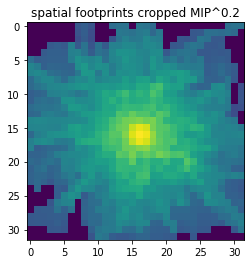

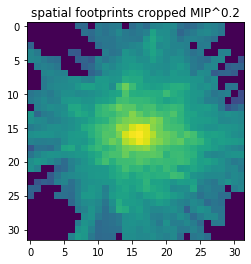

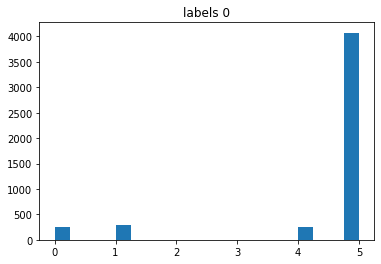

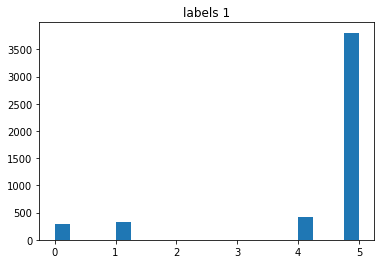

In [6]:
# dir_folders = f'{base_dir}/label_data'
dir_folders = r'/media/rich/bigSSD RH/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                            fileNames_statFiles=fileNames_statFiles,
                                            out_height_width=[32,32],
                                            max_footprint_width=241,
                                            plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0)
images_labeled = (images_labeled / np.max(images_labeled, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels_raw = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

<IPython.core.display.Javascript object>


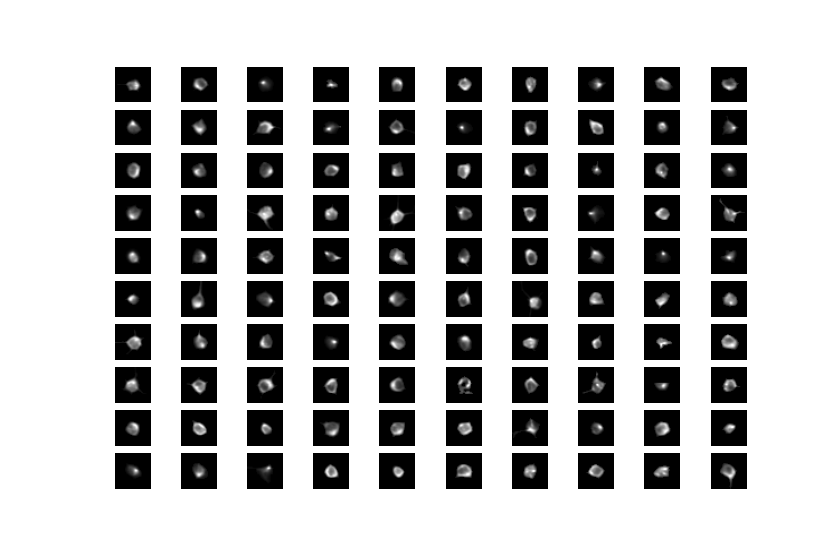

In [7]:
%matplotlib notebook

plotting_helpers.plot_image_grid(images=images_labeled,
                                labels=None,
                                grid_shape=(10,10), cmap=plt.get_cmap('gray'));

In [8]:
labels = classification.squeeze_integers(labels_raw)
images_labeled = images_labeled[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [9]:
duplicates = 1
balanced = True

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

if balanced:
    numToGetTo = np.sum(labels_dup==0)
    print(numToGetTo)
    for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
        if ii==3:
            numToGetTo = np.sum(labels_dup==0)/2
        else:
            numToGetTo = np.sum(labels_dup==0)

        idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
        images_dup = images_dup[idxToDelete==0,:,:]
        labels_dup = labels_dup[idxToDelete==0]





print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 32, 32)
(9714,)
532
(1862, 32, 32)
(1862,)
532
532
532
0
0
(1862, 32, 32)
(1862,)


In [10]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.15)
# X_train, X_val, y_train, y_val = X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val
# (X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
# X_train, y_train = X_labeled_train, y_labeled_train

# X_labeled_val, X_test, y_labeled_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((1489, 32, 32), (1489,)), ((373, 32, 32), (373,)))

In [11]:
# # create validation set
# # X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup[labels!=3], labels_dup[labels!=3], test_size = 0.15)
# (X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

<IPython.core.display.Javascript object>


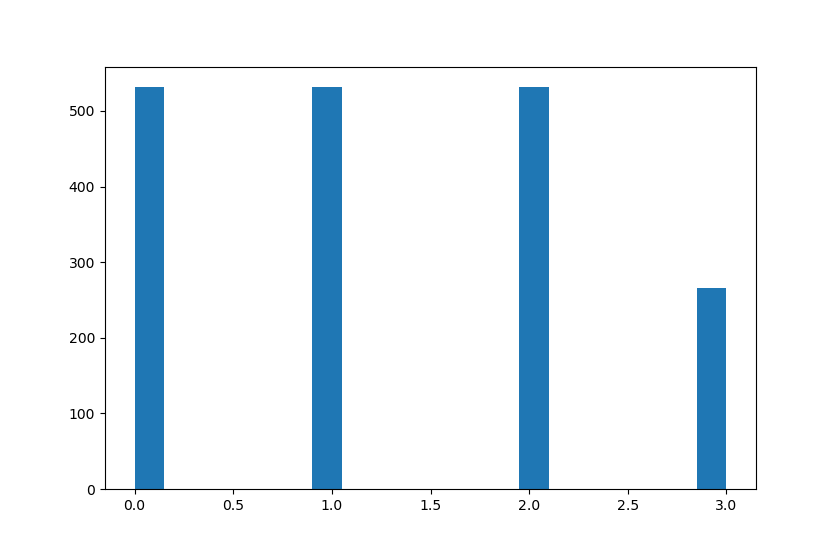

In [12]:
plt.figure()
plt.hist(labels_dup, 20);

In [13]:
images.shape

(1862, 32, 32)

## Define augmentation pipeline

In [15]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    
# ######     torchvision.transforms.RandomAdjustSharpness(torch.rand(1)*5, p=0.5),
    
    # # torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
    # # # torchvision.transforms.GaussianBlur(kernel_size=5,
    # # #                                     sigma=(0.0001, 0.1)),
    
    # # # torchvision.transforms.RandomPerspective(distortion_scale=0.05, 
    # # #                                          p=0.5, 
    # # #                                          interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
    # # #                                          fill=0),
    # # torchvision.transforms.RandomAffine(
    # #                                     degrees=(-180,180),
    # #                                     translate=(0.05, 0.05),
    # #                                     scale=(0.9, 1.1), 
    # #                                     shear=(-7, 7, -7, 7), 
    # #                                     interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
    # #                                     fill=0, 
    # #                                     fillcolor=None, 
    # #                                     resample=None),
    
    torchvision.transforms.RandomHorizontalFlip(p=0.5),

    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.0, 0.0),
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        # fillcolor=None, 
                                        resample=None),
    
    # # augmentation.AddPoissonNoise(   scaler_bounds=(10, 50),
    # #                                 prob=1,
    # #                                 base=100,
    # #                                 scaling='log'),

    # # augmentation.AddGaussianNoise(  mean=0, 
    # #                                 std=0.07,
    # #                                 prob=1),
)
scripted_transforms = torch.jit.script(transforms)
# scripted_transforms = transforms



# dataset_train = util.dataset_simCLR(
#                                     X_train, 
#                                     y_train, 
# #                                     torch.tensor(X_train), 
# #                                     y_train, 
#                                     n_transforms=2, 
# #                                     class_weights=[1]*4,
# #                                     class_weights=[0.34, 0.33, 0.33, 0.00],
# #                                     class_weights=[0.0, 0.0, 0.0, 1.00],
# #                                     class_weights=np.array([0.34, 0.33, 0.33, 0.00])[y_train],
# #                                     class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
#                                     class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=2048,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
# #                                                 num_workers=32,
# #                                                 prefetch_factor=0,
# #                                                 persistent_workers=True,
#                                                 )

# # dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
# #                                     y_val, 
# #                                     n_transforms=2, 
# #                                     transform=scripted_transforms,
# #                                     DEVICE='cpu',
# #                                     dtype_X=torch.float32,
# #                                     dtype_y=torch.int64 )

# # dataloader_val = torch.utils.data.DataLoader(   dataset_val,
# #                                                 batch_size=128,
# #             #                                     sampler=sampler,
# #                                                 shuffle=True,
# #                                                 drop_last=True,
# #                                                 pin_memory=True,
# #                                                 num_workers=0,
# #                                                 )         



# Train

In [16]:
DEVICE = torch_helpers.set_device(use_GPU=True)
# DEVICE = torch_helpers.set_device(use_GPU=False)

device: 'cuda'


### Define New model = model + pre-head + latent layer OR classification layer

In [201]:
class ModelTackOn(torch.nn.Module):
    def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=None):
            super(ModelTackOn, self).__init__()
            self.base_model = base_model
            final_base_layer = list(un_modified_model.children())[-1]
            # final_base_layer = list(list(model.children())[-1].children())[-1]
            # print(final_base_layer)

            self.pre_head_fc_lst = []
            self.post_head_fc_lst = []
            self.classifier_fc_lst = []

            self.init_prehead(final_base_layer, pre_head_fc_sizes)
            self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
            if classifier_fc_sizes is not None:
                self.init_classifier(pre_head_fc_sizes[-1], pre_head_fc_sizes)
    
    def init_prehead(self, prv_layer, pre_head_fc_sizes):
        for i, pre_head_fc in enumerate(pre_head_fc_sizes):
            if i == 0:
                in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 512
            else:
                in_features = pre_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
            self.add_module(f'PreHead_{i}', fc_layer)
            self.pre_head_fc_lst.append(fc_layer)

#             if i < len(pre_head_fc_sizes) - 1:
            non_linearity = torch.nn.ReLU()
            self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)

    def init_posthead(self, prv_size, post_head_fc_sizes):
        for i, post_head_fc in enumerate(post_head_fc_sizes):
            if i == 0:
                in_features = prv_size
            else:
                in_features = post_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
            self.add_module(f'PostHead_{i}', fc_layer)
            self.post_head_fc_lst.append(fc_layer)

            if i < len(post_head_fc_sizes) - 1:
                non_linearity = torch.nn.ReLU()
                self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
                self.pre_head_fc_lst.append(non_linearity)
    
    def init_classifier(self, prv_size, classifier_fc_sizes):
            for i, classifier_fc in enumerate(classifier_fc_sizes):
                if i == 0:
                    in_features = prv_size
                else:
                    in_features = classifier_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
            self.add_module(f'Classifier_{i}', fc_layer)
            self.classifier_fc_lst.append(fc_layer)

    def reinit_classifier(self):
        for i_layer, layer in enumerate(self.classifier_fc_lst):
            layer.reset_parameters()
    
#     def forward(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim

    def forward_classifier(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.classify(interim)
        return interim

    def forward_latent(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.get_latent(interim)
        return interim


    def get_head(self, base_out):
        # print('base_out', base_out.shape)
        head = base_out
        for pre_head_layer in self.pre_head_fc_lst:
          # print('pre_head_layer', pre_head_layer.in_features)
          head = pre_head_layer(head)
          # print('head', head.shape)
        return head

    def get_latent(self, head):
        latent = head
        for post_head_layer in self.post_head_fc_lst:
            latent = post_head_layer(latent)
        return latent

    def classify(self, head):
        logit = head
        for classifier_layer in self.classifier_fc_lst:
            logit = classifier_layer(logit)
        return logit

    def set_pre_head_grad(self, requires_grad=True):
        for pre_head_layer in self.pre_head_fc_lst:
            pre_head_layer.requies_grad = requires_grad

    def set_post_head_grad(self, requires_grad=True):
        for post_head_layer in self.post_head_fc_lst:
            post_head_layer.requies_grad = requires_grad

    def set_classifier_grad(self, requires_grad=True):
        for classifier_layer in self.classifier_fc_lst:
            classifier_layer.requies_grad = requires_grad

    def prep_contrast(self):
        self.set_pre_head_grad(requires_grad=True)
        self.set_post_head_grad(requires_grad=True)
        self.set_classifier_grad(requires_grad=False)

    def prep_classifier(self):
        self.set_pre_head_grad(requires_grad=False)
        self.set_post_head_grad(requires_grad=False)
        self.set_classifier_grad(requires_grad=True)


In [18]:
# import torchvision.models

# # base_model = torchvision.models.resnet101(pretrained=True)
# base_model = torchvision.models.resnet18(pretrained=True)

# for param in base_model.parameters():
#     param.requires_grad = False

# retrain = list(base_model.children())[-1:]
# for layer in retrain:
#     params = layer.parameters()
#     for param in params:
#         param.requires_grad = True

In [122]:
import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
base_model_frozen = torchvision.models.resnet18(pretrained=True)
for param in base_model_frozen.parameters():
    param.requires_grad = False

start with a pretrained resnet model, and chop off the final layer. This will be used as the base on which we add the pre-head layers (for expressivity), latent layers (for simCLR), or classification layers (for post-hoc logistic regression)

In [123]:
model_chopped = torch.nn.Sequential(*(list(base_model_frozen.children())[:-1] + [torch.nn.Flatten()]))

### Make combined model
'model' has two forward methods. One for generating latents (for simCLR) and one for classifying labels

In [124]:
model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[256], post_head_fc_sizes=[128], classifier_fc_sizes=[len(np.unique(y_train))])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])

# model = torch.nn.Sequential([model_chopped.to(DEVICE), torch.nn.Linear], pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])


# model = ModelTackOn(base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(base_model, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train()

ModelTackOn(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

## Training prep

In [125]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )
model.to(DEVICE)
criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [126]:
# dataset_train = util.dataset_supervised(
#                                     X_train,
#                                     y_train,
#                                     class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64
#                                     )



dataset_train = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [127]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

model.prep_contrast()
model.to(DEVICE)

l2_alpha = 0.000

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )

epoch: 0
Iter: 0/695, loss_train: 7.4058, loss_val: nan, lr: 0.0001
Iter: 1/695, loss_train: 7.387, loss_val: nan, lr: 0.0001
Iter: 2/695, loss_train: 7.3212, loss_val: nan, lr: 0.0001
Iter: 3/695, loss_train: 7.3266, loss_val: nan, lr: 0.0001
Iter: 4/695, loss_train: 7.3053, loss_val: nan, lr: 0.0001
Iter: 5/695, loss_train: 7.2784, loss_val: nan, lr: 0.0001
Iter: 6/695, loss_train: 7.2529, loss_val: nan, lr: 0.0001
Iter: 7/695, loss_train: 7.1927, loss_val: nan, lr: 0.0001
Iter: 8/695, loss_train: 7.1903, loss_val: nan, lr: 0.0001
Iter: 9/695, loss_train: 7.1794, loss_val: nan, lr: 0.0001
Iter: 10/695, loss_train: 7.1664, loss_val: nan, lr: 0.0001
Iter: 11/695, loss_train: 7.1476, loss_val: nan, lr: 0.0001
Iter: 12/695, loss_train: 7.1289, loss_val: nan, lr: 0.0001
Iter: 13/695, loss_train: 7.0926, loss_val: nan, lr: 0.0001
Iter: 14/695, loss_train: 7.1078, loss_val: nan, lr: 0.0001
Iter: 15/695, loss_train: 7.0852, loss_val: nan, lr: 0.0001
Iter: 16/695, loss_train: 7.0497, loss_val

Iter: 137/695, loss_train: 6.5406, loss_val: nan, lr: 0.0001
Iter: 138/695, loss_train: 6.5339, loss_val: nan, lr: 0.0001
Iter: 139/695, loss_train: 6.5565, loss_val: nan, lr: 0.0001
Iter: 140/695, loss_train: 6.537, loss_val: nan, lr: 0.0001
Iter: 141/695, loss_train: 6.5424, loss_val: nan, lr: 0.0001
Iter: 142/695, loss_train: 6.5502, loss_val: nan, lr: 0.0001
Iter: 143/695, loss_train: 6.5775, loss_val: nan, lr: 0.0001
Iter: 144/695, loss_train: 6.5446, loss_val: nan, lr: 0.0001
Iter: 145/695, loss_train: 6.5574, loss_val: nan, lr: 0.0001
Iter: 146/695, loss_train: 6.5489, loss_val: nan, lr: 0.0001
Iter: 147/695, loss_train: 6.5364, loss_val: nan, lr: 0.0001
Iter: 148/695, loss_train: 6.5404, loss_val: nan, lr: 0.0001
Iter: 149/695, loss_train: 6.5441, loss_val: nan, lr: 0.0001
Iter: 150/695, loss_train: 6.5404, loss_val: nan, lr: 0.0001
Iter: 151/695, loss_train: 6.5185, loss_val: nan, lr: 0.0001
Iter: 152/695, loss_train: 6.562, loss_val: nan, lr: 0.0001
Iter: 153/695, loss_train:

Iter: 272/695, loss_train: 6.4679, loss_val: nan, lr: 0.0001
Iter: 273/695, loss_train: 6.4796, loss_val: nan, lr: 0.0001
Iter: 274/695, loss_train: 6.4644, loss_val: nan, lr: 0.0001
Iter: 275/695, loss_train: 6.4673, loss_val: nan, lr: 0.0001
Iter: 276/695, loss_train: 6.4515, loss_val: nan, lr: 0.0001
Iter: 277/695, loss_train: 6.4435, loss_val: nan, lr: 0.0001
Iter: 278/695, loss_train: 6.4552, loss_val: nan, lr: 0.0001
Iter: 279/695, loss_train: 6.4653, loss_val: nan, lr: 0.0001
Iter: 280/695, loss_train: 6.4415, loss_val: nan, lr: 0.0001
Iter: 281/695, loss_train: 6.4567, loss_val: nan, lr: 0.0001
Iter: 282/695, loss_train: 6.443, loss_val: nan, lr: 0.0001
Iter: 283/695, loss_train: 6.439, loss_val: nan, lr: 0.0001
Iter: 284/695, loss_train: 6.4646, loss_val: nan, lr: 0.0001
Iter: 285/695, loss_train: 6.437, loss_val: nan, lr: 0.0001
Iter: 286/695, loss_train: 6.4407, loss_val: nan, lr: 0.0001
Iter: 287/695, loss_train: 6.4506, loss_val: nan, lr: 0.0001
Iter: 288/695, loss_train: 

Iter: 407/695, loss_train: 6.3787, loss_val: nan, lr: 0.0001
Iter: 408/695, loss_train: 6.4112, loss_val: nan, lr: 0.0001
Iter: 409/695, loss_train: 6.4117, loss_val: nan, lr: 0.0001
Iter: 410/695, loss_train: 6.3999, loss_val: nan, lr: 0.0001
Iter: 411/695, loss_train: 6.3967, loss_val: nan, lr: 0.0001
Iter: 412/695, loss_train: 6.424, loss_val: nan, lr: 0.0001
Iter: 413/695, loss_train: 6.4248, loss_val: nan, lr: 0.0001
Iter: 414/695, loss_train: 6.4167, loss_val: nan, lr: 0.0001
Iter: 415/695, loss_train: 6.4077, loss_val: nan, lr: 0.0001
Iter: 416/695, loss_train: 6.4188, loss_val: nan, lr: 0.0001
Iter: 417/695, loss_train: 6.3999, loss_val: nan, lr: 0.0001
Iter: 418/695, loss_train: 6.4076, loss_val: nan, lr: 0.0001
Iter: 419/695, loss_train: 6.4271, loss_val: nan, lr: 0.0001
Iter: 420/695, loss_train: 6.4016, loss_val: nan, lr: 0.0001
Iter: 421/695, loss_train: 6.42, loss_val: nan, lr: 0.0001
Iter: 422/695, loss_train: 6.4037, loss_val: nan, lr: 0.0001
Iter: 423/695, loss_train: 

Iter: 542/695, loss_train: 6.3858, loss_val: nan, lr: 0.0001
Iter: 543/695, loss_train: 6.3645, loss_val: nan, lr: 0.0001
Iter: 544/695, loss_train: 6.3938, loss_val: nan, lr: 0.0001
Iter: 545/695, loss_train: 6.3633, loss_val: nan, lr: 0.0001
Iter: 546/695, loss_train: 6.3507, loss_val: nan, lr: 0.0001
Iter: 547/695, loss_train: 6.424, loss_val: nan, lr: 0.0001
Iter: 548/695, loss_train: 6.3796, loss_val: nan, lr: 0.0001
Iter: 549/695, loss_train: 6.3661, loss_val: nan, lr: 0.0001
Iter: 550/695, loss_train: 6.3898, loss_val: nan, lr: 0.0001
Iter: 551/695, loss_train: 6.3687, loss_val: nan, lr: 0.0001
Iter: 552/695, loss_train: 6.4089, loss_val: nan, lr: 0.0001
Iter: 553/695, loss_train: 6.3714, loss_val: nan, lr: 0.0001
Iter: 554/695, loss_train: 6.3447, loss_val: nan, lr: 0.0001
Iter: 555/695, loss_train: 6.3624, loss_val: nan, lr: 0.0001
Iter: 556/695, loss_train: 6.3674, loss_val: nan, lr: 0.0001
Iter: 557/695, loss_train: 6.3817, loss_val: nan, lr: 0.0001
Iter: 558/695, loss_train

Iter: 681/695, loss_train: 6.3479, loss_val: nan, lr: 0.0001
Iter: 682/695, loss_train: 6.3462, loss_val: nan, lr: 0.0001
Iter: 683/695, loss_train: 6.3863, loss_val: nan, lr: 0.0001
Iter: 684/695, loss_train: 6.382, loss_val: nan, lr: 0.0001
Iter: 685/695, loss_train: 6.3344, loss_val: nan, lr: 0.0001
Iter: 686/695, loss_train: 6.3565, loss_val: nan, lr: 0.0001
Iter: 687/695, loss_train: 6.4074, loss_val: nan, lr: 0.0001
Iter: 688/695, loss_train: 6.3527, loss_val: nan, lr: 0.0001
Iter: 689/695, loss_train: 6.3613, loss_val: nan, lr: 0.0001
Iter: 690/695, loss_train: 6.3463, loss_val: nan, lr: 0.0001
Iter: 691/695, loss_train: 6.3428, loss_val: nan, lr: 0.0001
Iter: 692/695, loss_train: 6.3492, loss_val: nan, lr: 0.0001
Iter: 693/695, loss_train: 6.3654, loss_val: nan, lr: 0.0001
Iter: 694/695, loss_train: 6.3646, loss_val: nan, lr: 0.0001
epoch: 1
Iter: 0/695, loss_train: 6.338, loss_val: nan, lr: 0.0001
Iter: 1/695, loss_train: 6.3584, loss_val: nan, lr: 0.0001
Iter: 2/695, loss_tra

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/p

Iter: 60/695, loss_train: 6.337, loss_val: nan, lr: 0.0001
Iter: 61/695, loss_train: 6.3167, loss_val: nan, lr: 0.0001
Iter: 62/695, loss_train: 6.3366, loss_val: nan, lr: 0.0001
Iter: 63/695, loss_train: 6.3345, loss_val: nan, lr: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/p

Iter: 64/695, loss_train: 6.3317, loss_val: nan, lr: 0.0001
Iter: 65/695, loss_train: 6.3599, loss_val: nan, lr: 0.0001
Iter: 66/695, loss_train: 6.3329, loss_val: nan, lr: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/p

Iter: 67/695, loss_train: 6.2995, loss_val: nan, lr: 0.0001
Iter: 68/695, loss_train: 6.3335, loss_val: nan, lr: 0.0001
Iter: 69/695, loss_train: 6.3537, loss_val: nan, lr: 0.0001
Iter: 70/695, loss_train: 6.3412, loss_val: nan, lr: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>can only test a child process

Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/p

Iter: 71/695, loss_train: 6.3418, loss_val: nan, lr: 0.0001
Iter: 72/695, loss_train: 6.3524, loss_val: nan, lr: 0.0001
Iter: 73/695, loss_train: 6.3511, loss_val: nan, lr: 0.0001
Iter: 74/695, loss_train: 6.3283, loss_val: nan, lr: 0.0001
Iter: 75/695, loss_train: 6.3089, loss_val: nan, lr: 0.0001
Iter: 76/695, loss_train: 6.3373, loss_val: nan, lr: 0.0001
Iter: 77/695, loss_train: 6.3431, loss_val: nan, lr: 0.0001
Iter: 78/695, loss_train: 6.3254, loss_val: nan, lr: 0.0001
Iter: 79/695, loss_train: 6.3171, loss_val: nan, lr: 0.0001
Iter: 80/695, loss_train: 6.3322, loss_val: nan, lr: 0.0001
Iter: 81/695, loss_train: 6.3279, loss_val: nan, lr: 0.0001
Iter: 82/695, loss_train: 6.3409, loss_val: nan, lr: 0.0001
Iter: 83/695, loss_train: 6.3424, loss_val: nan, lr: 0.0001
Iter: 84/695, loss_train: 6.3649, loss_val: nan, lr: 0.0001
Iter: 85/695, loss_train: 6.3212, loss_val: nan, lr: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Iter: 86/695, loss_train: 6.3373, loss_val: nan, lr: 0.0001
Iter: 87/695, loss_train: 6.3163, loss_val: nan, lr: 0.0001
Iter: 88/695, loss_train: 6.3232, loss_val: nan, lr: 0.0001
Iter: 89/695, loss_train: 6.3355, loss_val: nan, lr: 0.0001
Iter: 90/695, loss_train: 6.3267, loss_val: nan, lr: 0.0001
Iter: 91/695, loss_train: 6.3277, loss_val: nan, lr: 0.0001
Iter: 92/695, loss_train: 6.3376, loss_val: nan, lr: 0.0001
Iter: 93/695, loss_train: 6.3352, loss_val: nan, lr: 0.0001
Iter: 94/695, loss_train: 6.3219, loss_val: nan, lr: 0.0001
Iter: 95/695, loss_train: 6.3471, loss_val: nan, lr: 0.0001
Iter: 96/695, loss_train: 6.3507, loss_val: nan, lr: 0.0001
Iter: 97/695, loss_train: 6.3092, loss_val: nan, lr: 0.0001
Iter: 98/695, loss_train: 6.3092, loss_val: nan, lr: 0.0001
Iter: 99/695, loss_train: 6.3269, loss_val: nan, lr: 0.0001
Iter: 100/695, loss_train: 6.3288, loss_val: nan, lr: 0.0001
Iter: 101/695, loss_train: 6.3213, loss_val: nan, lr: 0.0001
Iter: 102/695, loss_train: 6.3239, los

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Iter: 121/695, loss_train: 6.3326, loss_val: nan, lr: 0.0001
Iter: 122/695, loss_train: 6.3461, loss_val: nan, lr: 0.0001
Iter: 123/695, loss_train: 6.3243, loss_val: nan, lr: 0.0001
Iter: 124/695, loss_train: 6.3226, loss_val: nan, lr: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/p

Iter: 125/695, loss_train: 6.3256, loss_val: nan, lr: 0.0001
Iter: 126/695, loss_train: 6.3456, loss_val: nan, lr: 0.0001
Iter: 127/695, loss_train: 6.3177, loss_val: nan, lr: 0.0001
Iter: 128/695, loss_train: 6.3239, loss_val: nan, lr: 0.0001
Iter: 129/695, loss_train: 6.311, loss_val: nan, lr: 0.0001
Iter: 130/695, loss_train: 6.2994, loss_val: nan, lr: 0.0001
Iter: 131/695, loss_train: 6.3318, loss_val: nan, lr: 0.0001
Iter: 132/695, loss_train: 6.3352, loss_val: nan, lr: 0.0001
Iter: 133/695, loss_train: 6.3086, loss_val: nan, lr: 0.0001
Iter: 134/695, loss_train: 6.3567, loss_val: nan, lr: 0.0001
Iter: 135/695, loss_train: 6.3296, loss_val: nan, lr: 0.0001
Iter: 136/695, loss_train: 6.3192, loss_val: nan, lr: 0.0001
Iter: 137/695, loss_train: 6.3528, loss_val: nan, lr: 0.0001
Iter: 138/695, loss_train: 6.3169, loss_val: nan, lr: 0.0001
Iter: 139/695, loss_train: 6.3261, loss_val: nan, lr: 0.0001
Iter: 140/695, loss_train: 6.3256, loss_val: nan, lr: 0.0001
Iter: 141/695, loss_train

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/p

Iter: 173/695, loss_train: 6.3192, loss_val: nan, lr: 0.0001
Iter: 174/695, loss_train: 6.3602, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train: 6.3107, loss_val: nan, lr: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10><function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):

Iter: 176/695, loss_train: 6.3695, loss_val: nan, lr: 0.0001
Iter: 177/695, loss_train: 6.2926, loss_val: nan, lr: 0.0001
Iter: 178/695, loss_train: 6.3091, loss_val: nan, lr: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/p

Iter: 179/695, loss_train: 6.3385, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.3779, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_train: 6.304, loss_val: nan, lr: 0.0001
Iter: 182/695, loss_train: 6.3142, loss_val: nan, lr: 0.0001


  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f114b416c10>
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/media/r

Iter: 183/695, loss_train: 6.3207, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.3267, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.3177, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.3141, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.3249, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.3187, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train: 6.3171, loss_val: nan, lr: 0.0001
Iter: 190/695, loss_train: 6.3253, loss_val: nan, lr: 0.0001
Iter: 191/695, loss_train: 6.3433, loss_val: nan, lr: 0.0001
Iter: 192/695, loss_train: 6.3066, loss_val: nan, lr: 0.0001
Iter: 193/695, loss_train: 6.3223, loss_val: nan, lr: 0.0001
Iter: 194/695, loss_train: 6.3632, loss_val: nan, lr: 0.0001
Iter: 195/695, loss_train: 6.329, loss_val: nan, lr: 0.0001
Iter: 196/695, loss_train: 6.334, loss_val: nan, lr: 0.0001
Iter: 197/695, loss_train: 6.3003, loss_val: nan, lr: 0.0001
Iter: 198/695, loss_train: 6.3267, loss_val: nan, lr: 0.0001
Iter: 199/695, loss_train:

Iter: 318/695, loss_train: 6.2984, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_train: 6.2947, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.3264, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.3056, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.362, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train: 6.3084, loss_val: nan, lr: 0.0001
Iter: 324/695, loss_train: 6.2895, loss_val: nan, lr: 0.0001
Iter: 325/695, loss_train: 6.3036, loss_val: nan, lr: 0.0001
Iter: 326/695, loss_train: 6.309, loss_val: nan, lr: 0.0001
Iter: 327/695, loss_train: 6.3203, loss_val: nan, lr: 0.0001
Iter: 328/695, loss_train: 6.3134, loss_val: nan, lr: 0.0001
Iter: 329/695, loss_train: 6.2827, loss_val: nan, lr: 0.0001
Iter: 330/695, loss_train: 6.3343, loss_val: nan, lr: 0.0001
Iter: 331/695, loss_train: 6.3087, loss_val: nan, lr: 0.0001
Iter: 332/695, loss_train: 6.3084, loss_val: nan, lr: 0.0001
Iter: 333/695, loss_train: 6.3085, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train:

Iter: 453/695, loss_train: 6.3147, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train: 6.2926, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.2972, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.2772, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.2901, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 6.3044, loss_val: nan, lr: 0.0001
Iter: 459/695, loss_train: 6.2755, loss_val: nan, lr: 0.0001
Iter: 460/695, loss_train: 6.2781, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.2844, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6.2819, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 6.3443, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.3229, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.2681, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 6.3003, loss_val: nan, lr: 0.0001
Iter: 467/695, loss_train: 6.2873, loss_val: nan, lr: 0.0001
Iter: 468/695, loss_train: 6.27, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train:

Iter: 588/695, loss_train: 6.273, loss_val: nan, lr: 0.0001
Iter: 589/695, loss_train: 6.2783, loss_val: nan, lr: 0.0001
Iter: 590/695, loss_train: 6.2787, loss_val: nan, lr: 0.0001
Iter: 591/695, loss_train: 6.3078, loss_val: nan, lr: 0.0001
Iter: 592/695, loss_train: 6.2711, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train: 6.2982, loss_val: nan, lr: 0.0001
Iter: 594/695, loss_train: 6.2941, loss_val: nan, lr: 0.0001
Iter: 595/695, loss_train: 6.3208, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.2874, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.3063, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.3041, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.2939, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.2869, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_train: 6.2833, loss_val: nan, lr: 0.0001
Iter: 602/695, loss_train: 6.2755, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.2603, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train

Iter: 33/695, loss_train: 6.3258, loss_val: nan, lr: 0.0001
Iter: 34/695, loss_train: 6.2724, loss_val: nan, lr: 0.0001
Iter: 35/695, loss_train: 6.2621, loss_val: nan, lr: 0.0001
Iter: 36/695, loss_train: 6.2579, loss_val: nan, lr: 0.0001
Iter: 37/695, loss_train: 6.2672, loss_val: nan, lr: 0.0001
Iter: 38/695, loss_train: 6.279, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.2619, loss_val: nan, lr: 0.0001
Iter: 40/695, loss_train: 6.2671, loss_val: nan, lr: 0.0001
Iter: 41/695, loss_train: 6.2821, loss_val: nan, lr: 0.0001
Iter: 42/695, loss_train: 6.3078, loss_val: nan, lr: 0.0001
Iter: 43/695, loss_train: 6.263, loss_val: nan, lr: 0.0001
Iter: 44/695, loss_train: 6.2613, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.2675, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.2852, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.3036, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.2564, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.2858, loss_val

Iter: 173/695, loss_train: 6.2729, loss_val: nan, lr: 0.0001
Iter: 174/695, loss_train: 6.273, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train: 6.2549, loss_val: nan, lr: 0.0001
Iter: 176/695, loss_train: 6.2627, loss_val: nan, lr: 0.0001
Iter: 177/695, loss_train: 6.2534, loss_val: nan, lr: 0.0001
Iter: 178/695, loss_train: 6.2886, loss_val: nan, lr: 0.0001
Iter: 179/695, loss_train: 6.2625, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.2799, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_train: 6.2587, loss_val: nan, lr: 0.0001
Iter: 182/695, loss_train: 6.2742, loss_val: nan, lr: 0.0001
Iter: 183/695, loss_train: 6.2957, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.2962, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.3209, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.3079, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.2609, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.2676, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train

Iter: 308/695, loss_train: 6.2913, loss_val: nan, lr: 0.0001
Iter: 309/695, loss_train: 6.3087, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train: 6.2739, loss_val: nan, lr: 0.0001
Iter: 311/695, loss_train: 6.247, loss_val: nan, lr: 0.0001
Iter: 312/695, loss_train: 6.264, loss_val: nan, lr: 0.0001
Iter: 313/695, loss_train: 6.2598, loss_val: nan, lr: 0.0001
Iter: 314/695, loss_train: 6.2589, loss_val: nan, lr: 0.0001
Iter: 315/695, loss_train: 6.2882, loss_val: nan, lr: 0.0001
Iter: 316/695, loss_train: 6.2666, loss_val: nan, lr: 0.0001
Iter: 317/695, loss_train: 6.2503, loss_val: nan, lr: 0.0001
Iter: 318/695, loss_train: 6.2506, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_train: 6.2607, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.2668, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.2607, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.2434, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train: 6.2829, loss_val: nan, lr: 0.0001
Iter: 324/695, loss_train:

Iter: 446/695, loss_train: 6.2611, loss_val: nan, lr: 0.0001
Iter: 447/695, loss_train: 6.2657, loss_val: nan, lr: 0.0001
Iter: 448/695, loss_train: 6.231, loss_val: nan, lr: 0.0001
Iter: 449/695, loss_train: 6.235, loss_val: nan, lr: 0.0001
Iter: 450/695, loss_train: 6.2381, loss_val: nan, lr: 0.0001
Iter: 451/695, loss_train: 6.2559, loss_val: nan, lr: 0.0001
Iter: 452/695, loss_train: 6.266, loss_val: nan, lr: 0.0001
Iter: 453/695, loss_train: 6.2551, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train: 6.2442, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.2958, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.2612, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.272, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 6.2718, loss_val: nan, lr: 0.0001
Iter: 459/695, loss_train: 6.3124, loss_val: nan, lr: 0.0001
Iter: 460/695, loss_train: 6.2372, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.2551, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6

Iter: 583/695, loss_train: 6.2363, loss_val: nan, lr: 0.0001
Iter: 584/695, loss_train: 6.258, loss_val: nan, lr: 0.0001
Iter: 585/695, loss_train: 6.2599, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 6.2582, loss_val: nan, lr: 0.0001
Iter: 587/695, loss_train: 6.2399, loss_val: nan, lr: 0.0001
Iter: 588/695, loss_train: 6.2418, loss_val: nan, lr: 0.0001
Iter: 589/695, loss_train: 6.2653, loss_val: nan, lr: 0.0001
Iter: 590/695, loss_train: 6.2576, loss_val: nan, lr: 0.0001
Iter: 591/695, loss_train: 6.234, loss_val: nan, lr: 0.0001
Iter: 592/695, loss_train: 6.2361, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train: 6.2346, loss_val: nan, lr: 0.0001
Iter: 594/695, loss_train: 6.2406, loss_val: nan, lr: 0.0001
Iter: 595/695, loss_train: 6.2249, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.2362, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.2371, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.2463, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train:

Iter: 23/695, loss_train: 6.2827, loss_val: nan, lr: 0.0001
Iter: 24/695, loss_train: 6.2453, loss_val: nan, lr: 0.0001
Iter: 25/695, loss_train: 6.2538, loss_val: nan, lr: 0.0001
Iter: 26/695, loss_train: 6.2249, loss_val: nan, lr: 0.0001
Iter: 27/695, loss_train: 6.2542, loss_val: nan, lr: 0.0001
Iter: 28/695, loss_train: 6.2335, loss_val: nan, lr: 0.0001
Iter: 29/695, loss_train: 6.2749, loss_val: nan, lr: 0.0001
Iter: 30/695, loss_train: 6.2584, loss_val: nan, lr: 0.0001
Iter: 31/695, loss_train: 6.2819, loss_val: nan, lr: 0.0001
Iter: 32/695, loss_train: 6.2402, loss_val: nan, lr: 0.0001
Iter: 33/695, loss_train: 6.253, loss_val: nan, lr: 0.0001
Iter: 34/695, loss_train: 6.2579, loss_val: nan, lr: 0.0001
Iter: 35/695, loss_train: 6.2441, loss_val: nan, lr: 0.0001
Iter: 36/695, loss_train: 6.2473, loss_val: nan, lr: 0.0001
Iter: 37/695, loss_train: 6.2344, loss_val: nan, lr: 0.0001
Iter: 38/695, loss_train: 6.2471, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.2588, loss_va

Iter: 159/695, loss_train: 6.3059, loss_val: nan, lr: 0.0001
Iter: 160/695, loss_train: 6.2336, loss_val: nan, lr: 0.0001
Iter: 161/695, loss_train: 6.259, loss_val: nan, lr: 0.0001
Iter: 162/695, loss_train: 6.229, loss_val: nan, lr: 0.0001
Iter: 163/695, loss_train: 6.2423, loss_val: nan, lr: 0.0001
Iter: 164/695, loss_train: 6.2277, loss_val: nan, lr: 0.0001
Iter: 165/695, loss_train: 6.2672, loss_val: nan, lr: 0.0001
Iter: 166/695, loss_train: 6.2383, loss_val: nan, lr: 0.0001
Iter: 167/695, loss_train: 6.2341, loss_val: nan, lr: 0.0001
Iter: 168/695, loss_train: 6.2439, loss_val: nan, lr: 0.0001
Iter: 169/695, loss_train: 6.2394, loss_val: nan, lr: 0.0001
Iter: 170/695, loss_train: 6.2704, loss_val: nan, lr: 0.0001
Iter: 171/695, loss_train: 6.2487, loss_val: nan, lr: 0.0001
Iter: 172/695, loss_train: 6.2223, loss_val: nan, lr: 0.0001
Iter: 173/695, loss_train: 6.2426, loss_val: nan, lr: 0.0001
Iter: 174/695, loss_train: 6.2305, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train:

Iter: 297/695, loss_train: 6.2767, loss_val: nan, lr: 0.0001
Iter: 298/695, loss_train: 6.2389, loss_val: nan, lr: 0.0001
Iter: 299/695, loss_train: 6.2658, loss_val: nan, lr: 0.0001
Iter: 300/695, loss_train: 6.2255, loss_val: nan, lr: 0.0001
Iter: 301/695, loss_train: 6.2351, loss_val: nan, lr: 0.0001
Iter: 302/695, loss_train: 6.2297, loss_val: nan, lr: 0.0001
Iter: 303/695, loss_train: 6.255, loss_val: nan, lr: 0.0001
Iter: 304/695, loss_train: 6.2261, loss_val: nan, lr: 0.0001
Iter: 305/695, loss_train: 6.2593, loss_val: nan, lr: 0.0001
Iter: 306/695, loss_train: 6.2484, loss_val: nan, lr: 0.0001
Iter: 307/695, loss_train: 6.2321, loss_val: nan, lr: 0.0001
Iter: 308/695, loss_train: 6.248, loss_val: nan, lr: 0.0001
Iter: 309/695, loss_train: 6.2529, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train: 6.2163, loss_val: nan, lr: 0.0001
Iter: 311/695, loss_train: 6.2311, loss_val: nan, lr: 0.0001
Iter: 312/695, loss_train: 6.2326, loss_val: nan, lr: 0.0001
Iter: 313/695, loss_train:

Iter: 432/695, loss_train: 6.2316, loss_val: nan, lr: 0.0001
Iter: 433/695, loss_train: 6.2298, loss_val: nan, lr: 0.0001
Iter: 434/695, loss_train: 6.2447, loss_val: nan, lr: 0.0001
Iter: 435/695, loss_train: 6.2396, loss_val: nan, lr: 0.0001
Iter: 436/695, loss_train: 6.2442, loss_val: nan, lr: 0.0001
Iter: 437/695, loss_train: 6.2528, loss_val: nan, lr: 0.0001
Iter: 438/695, loss_train: 6.2323, loss_val: nan, lr: 0.0001
Iter: 439/695, loss_train: 6.2382, loss_val: nan, lr: 0.0001
Iter: 440/695, loss_train: 6.2223, loss_val: nan, lr: 0.0001
Iter: 441/695, loss_train: 6.2348, loss_val: nan, lr: 0.0001
Iter: 442/695, loss_train: 6.2471, loss_val: nan, lr: 0.0001
Iter: 443/695, loss_train: 6.2778, loss_val: nan, lr: 0.0001
Iter: 444/695, loss_train: 6.227, loss_val: nan, lr: 0.0001
Iter: 445/695, loss_train: 6.2374, loss_val: nan, lr: 0.0001
Iter: 446/695, loss_train: 6.2492, loss_val: nan, lr: 0.0001
Iter: 447/695, loss_train: 6.2364, loss_val: nan, lr: 0.0001
Iter: 448/695, loss_train

Iter: 571/695, loss_train: 6.2231, loss_val: nan, lr: 0.0001
Iter: 572/695, loss_train: 6.226, loss_val: nan, lr: 0.0001
Iter: 573/695, loss_train: 6.2616, loss_val: nan, lr: 0.0001
Iter: 574/695, loss_train: 6.2571, loss_val: nan, lr: 0.0001
Iter: 575/695, loss_train: 6.225, loss_val: nan, lr: 0.0001
Iter: 576/695, loss_train: 6.2292, loss_val: nan, lr: 0.0001
Iter: 577/695, loss_train: 6.2482, loss_val: nan, lr: 0.0001
Iter: 578/695, loss_train: 6.2157, loss_val: nan, lr: 0.0001
Iter: 579/695, loss_train: 6.2254, loss_val: nan, lr: 0.0001
Iter: 580/695, loss_train: 6.2258, loss_val: nan, lr: 0.0001
Iter: 581/695, loss_train: 6.2285, loss_val: nan, lr: 0.0001
Iter: 582/695, loss_train: 6.2204, loss_val: nan, lr: 0.0001
Iter: 583/695, loss_train: 6.23, loss_val: nan, lr: 0.0001
Iter: 584/695, loss_train: 6.2266, loss_val: nan, lr: 0.0001
Iter: 585/695, loss_train: 6.248, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 6.2223, loss_val: nan, lr: 0.0001
Iter: 587/695, loss_train: 6.

Iter: 11/695, loss_train: 6.2231, loss_val: nan, lr: 0.0001
Iter: 12/695, loss_train: 6.2428, loss_val: nan, lr: 0.0001
Iter: 13/695, loss_train: 6.227, loss_val: nan, lr: 0.0001
Iter: 14/695, loss_train: 6.2366, loss_val: nan, lr: 0.0001
Iter: 15/695, loss_train: 6.2179, loss_val: nan, lr: 0.0001
Iter: 16/695, loss_train: 6.2157, loss_val: nan, lr: 0.0001
Iter: 17/695, loss_train: 6.2497, loss_val: nan, lr: 0.0001
Iter: 18/695, loss_train: 6.2338, loss_val: nan, lr: 0.0001
Iter: 19/695, loss_train: 6.2302, loss_val: nan, lr: 0.0001
Iter: 20/695, loss_train: 6.2926, loss_val: nan, lr: 0.0001
Iter: 21/695, loss_train: 6.2363, loss_val: nan, lr: 0.0001
Iter: 22/695, loss_train: 6.216, loss_val: nan, lr: 0.0001
Iter: 23/695, loss_train: 6.2176, loss_val: nan, lr: 0.0001
Iter: 24/695, loss_train: 6.2114, loss_val: nan, lr: 0.0001
Iter: 25/695, loss_train: 6.2324, loss_val: nan, lr: 0.0001
Iter: 26/695, loss_train: 6.251, loss_val: nan, lr: 0.0001
Iter: 27/695, loss_train: 6.2115, loss_val:

Iter: 150/695, loss_train: 6.2357, loss_val: nan, lr: 0.0001
Iter: 151/695, loss_train: 6.2319, loss_val: nan, lr: 0.0001
Iter: 152/695, loss_train: 6.2273, loss_val: nan, lr: 0.0001
Iter: 153/695, loss_train: 6.2833, loss_val: nan, lr: 0.0001
Iter: 154/695, loss_train: 6.2373, loss_val: nan, lr: 0.0001
Iter: 155/695, loss_train: 6.2138, loss_val: nan, lr: 0.0001
Iter: 156/695, loss_train: 6.235, loss_val: nan, lr: 0.0001
Iter: 157/695, loss_train: 6.2298, loss_val: nan, lr: 0.0001
Iter: 158/695, loss_train: 6.226, loss_val: nan, lr: 0.0001
Iter: 159/695, loss_train: 6.212, loss_val: nan, lr: 0.0001
Iter: 160/695, loss_train: 6.2187, loss_val: nan, lr: 0.0001
Iter: 161/695, loss_train: 6.2205, loss_val: nan, lr: 0.0001
Iter: 162/695, loss_train: 6.2234, loss_val: nan, lr: 0.0001
Iter: 163/695, loss_train: 6.2065, loss_val: nan, lr: 0.0001
Iter: 164/695, loss_train: 6.2257, loss_val: nan, lr: 0.0001
Iter: 165/695, loss_train: 6.2154, loss_val: nan, lr: 0.0001
Iter: 166/695, loss_train: 

Iter: 289/695, loss_train: 6.2431, loss_val: nan, lr: 0.0001
Iter: 290/695, loss_train: 6.2557, loss_val: nan, lr: 0.0001
Iter: 291/695, loss_train: 6.2416, loss_val: nan, lr: 0.0001
Iter: 292/695, loss_train: 6.2281, loss_val: nan, lr: 0.0001
Iter: 293/695, loss_train: 6.2373, loss_val: nan, lr: 0.0001
Iter: 294/695, loss_train: 6.2317, loss_val: nan, lr: 0.0001
Iter: 295/695, loss_train: 6.2213, loss_val: nan, lr: 0.0001
Iter: 296/695, loss_train: 6.2405, loss_val: nan, lr: 0.0001
Iter: 297/695, loss_train: 6.247, loss_val: nan, lr: 0.0001
Iter: 298/695, loss_train: 6.2503, loss_val: nan, lr: 0.0001
Iter: 299/695, loss_train: 6.2367, loss_val: nan, lr: 0.0001
Iter: 300/695, loss_train: 6.2075, loss_val: nan, lr: 0.0001
Iter: 301/695, loss_train: 6.2714, loss_val: nan, lr: 0.0001
Iter: 302/695, loss_train: 6.3183, loss_val: nan, lr: 0.0001
Iter: 303/695, loss_train: 6.2304, loss_val: nan, lr: 0.0001
Iter: 304/695, loss_train: 6.2699, loss_val: nan, lr: 0.0001
Iter: 305/695, loss_train

Iter: 424/695, loss_train: 6.243, loss_val: nan, lr: 0.0001
Iter: 425/695, loss_train: 6.2057, loss_val: nan, lr: 0.0001
Iter: 426/695, loss_train: 6.2246, loss_val: nan, lr: 0.0001
Iter: 427/695, loss_train: 6.2317, loss_val: nan, lr: 0.0001
Iter: 428/695, loss_train: 6.2025, loss_val: nan, lr: 0.0001
Iter: 429/695, loss_train: 6.2307, loss_val: nan, lr: 0.0001
Iter: 430/695, loss_train: 6.2169, loss_val: nan, lr: 0.0001
Iter: 431/695, loss_train: 6.2259, loss_val: nan, lr: 0.0001
Iter: 432/695, loss_train: 6.2369, loss_val: nan, lr: 0.0001
Iter: 433/695, loss_train: 6.236, loss_val: nan, lr: 0.0001
Iter: 434/695, loss_train: 6.2186, loss_val: nan, lr: 0.0001
Iter: 435/695, loss_train: 6.2353, loss_val: nan, lr: 0.0001
Iter: 436/695, loss_train: 6.2188, loss_val: nan, lr: 0.0001
Iter: 437/695, loss_train: 6.2329, loss_val: nan, lr: 0.0001
Iter: 438/695, loss_train: 6.2207, loss_val: nan, lr: 0.0001
Iter: 439/695, loss_train: 6.2159, loss_val: nan, lr: 0.0001
Iter: 440/695, loss_train:

Iter: 559/695, loss_train: 6.2117, loss_val: nan, lr: 0.0001
Iter: 560/695, loss_train: 6.2548, loss_val: nan, lr: 0.0001
Iter: 561/695, loss_train: 6.214, loss_val: nan, lr: 0.0001
Iter: 562/695, loss_train: 6.2125, loss_val: nan, lr: 0.0001
Iter: 563/695, loss_train: 6.2116, loss_val: nan, lr: 0.0001
Iter: 564/695, loss_train: 6.2679, loss_val: nan, lr: 0.0001
Iter: 565/695, loss_train: 6.2376, loss_val: nan, lr: 0.0001
Iter: 566/695, loss_train: 6.2578, loss_val: nan, lr: 0.0001
Iter: 567/695, loss_train: 6.2078, loss_val: nan, lr: 0.0001
Iter: 568/695, loss_train: 6.2269, loss_val: nan, lr: 0.0001
Iter: 569/695, loss_train: 6.2562, loss_val: nan, lr: 0.0001
Iter: 570/695, loss_train: 6.2463, loss_val: nan, lr: 0.0001
Iter: 571/695, loss_train: 6.2204, loss_val: nan, lr: 0.0001
Iter: 572/695, loss_train: 6.2131, loss_val: nan, lr: 0.0001
Iter: 573/695, loss_train: 6.2602, loss_val: nan, lr: 0.0001
Iter: 574/695, loss_train: 6.2287, loss_val: nan, lr: 0.0001
Iter: 575/695, loss_train

Iter: 694/695, loss_train: 6.2135, loss_val: nan, lr: 0.0001
epoch: 5
Iter: 0/695, loss_train: 6.2071, loss_val: nan, lr: 0.0001
Iter: 1/695, loss_train: 6.246, loss_val: nan, lr: 0.0001
Iter: 2/695, loss_train: 6.2055, loss_val: nan, lr: 0.0001
Iter: 3/695, loss_train: 6.2278, loss_val: nan, lr: 0.0001
Iter: 4/695, loss_train: 6.2311, loss_val: nan, lr: 0.0001
Iter: 5/695, loss_train: 6.1994, loss_val: nan, lr: 0.0001
Iter: 6/695, loss_train: 6.2233, loss_val: nan, lr: 0.0001
Iter: 7/695, loss_train: 6.2306, loss_val: nan, lr: 0.0001
Iter: 8/695, loss_train: 6.2155, loss_val: nan, lr: 0.0001
Iter: 9/695, loss_train: 6.2117, loss_val: nan, lr: 0.0001
Iter: 10/695, loss_train: 6.1999, loss_val: nan, lr: 0.0001
Iter: 11/695, loss_train: 6.1939, loss_val: nan, lr: 0.0001
Iter: 12/695, loss_train: 6.2139, loss_val: nan, lr: 0.0001
Iter: 13/695, loss_train: 6.2109, loss_val: nan, lr: 0.0001
Iter: 14/695, loss_train: 6.205, loss_val: nan, lr: 0.0001
Iter: 15/695, loss_train: 6.2139, loss_val

Iter: 136/695, loss_train: 6.2182, loss_val: nan, lr: 0.0001
Iter: 137/695, loss_train: 6.2083, loss_val: nan, lr: 0.0001
Iter: 138/695, loss_train: 6.2349, loss_val: nan, lr: 0.0001
Iter: 139/695, loss_train: 6.2132, loss_val: nan, lr: 0.0001
Iter: 140/695, loss_train: 6.2142, loss_val: nan, lr: 0.0001
Iter: 141/695, loss_train: 6.1893, loss_val: nan, lr: 0.0001
Iter: 142/695, loss_train: 6.2619, loss_val: nan, lr: 0.0001
Iter: 143/695, loss_train: 6.2357, loss_val: nan, lr: 0.0001
Iter: 144/695, loss_train: 6.212, loss_val: nan, lr: 0.0001
Iter: 145/695, loss_train: 6.2126, loss_val: nan, lr: 0.0001
Iter: 146/695, loss_train: 6.2049, loss_val: nan, lr: 0.0001
Iter: 147/695, loss_train: 6.2244, loss_val: nan, lr: 0.0001
Iter: 148/695, loss_train: 6.2185, loss_val: nan, lr: 0.0001
Iter: 149/695, loss_train: 6.2105, loss_val: nan, lr: 0.0001
Iter: 150/695, loss_train: 6.1966, loss_val: nan, lr: 0.0001
Iter: 151/695, loss_train: 6.2111, loss_val: nan, lr: 0.0001
Iter: 152/695, loss_train

Iter: 273/695, loss_train: 6.2163, loss_val: nan, lr: 0.0001
Iter: 274/695, loss_train: 6.2596, loss_val: nan, lr: 0.0001
Iter: 275/695, loss_train: 6.1955, loss_val: nan, lr: 0.0001
Iter: 276/695, loss_train: 6.1844, loss_val: nan, lr: 0.0001
Iter: 277/695, loss_train: 6.2051, loss_val: nan, lr: 0.0001
Iter: 278/695, loss_train: 6.2041, loss_val: nan, lr: 0.0001
Iter: 279/695, loss_train: 6.2325, loss_val: nan, lr: 0.0001
Iter: 280/695, loss_train: 6.2148, loss_val: nan, lr: 0.0001
Iter: 281/695, loss_train: 6.2296, loss_val: nan, lr: 0.0001
Iter: 282/695, loss_train: 6.1994, loss_val: nan, lr: 0.0001
Iter: 283/695, loss_train: 6.2075, loss_val: nan, lr: 0.0001
Iter: 284/695, loss_train: 6.2138, loss_val: nan, lr: 0.0001
Iter: 285/695, loss_train: 6.2231, loss_val: nan, lr: 0.0001
Iter: 286/695, loss_train: 6.2168, loss_val: nan, lr: 0.0001
Iter: 287/695, loss_train: 6.2357, loss_val: nan, lr: 0.0001
Iter: 288/695, loss_train: 6.2051, loss_val: nan, lr: 0.0001
Iter: 289/695, loss_trai

Iter: 408/695, loss_train: 6.2207, loss_val: nan, lr: 0.0001
Iter: 409/695, loss_train: 6.1967, loss_val: nan, lr: 0.0001
Iter: 410/695, loss_train: 6.2416, loss_val: nan, lr: 0.0001
Iter: 411/695, loss_train: 6.212, loss_val: nan, lr: 0.0001
Iter: 412/695, loss_train: 6.2592, loss_val: nan, lr: 0.0001
Iter: 413/695, loss_train: 6.2524, loss_val: nan, lr: 0.0001
Iter: 414/695, loss_train: 6.2089, loss_val: nan, lr: 0.0001
Iter: 415/695, loss_train: 6.2207, loss_val: nan, lr: 0.0001
Iter: 416/695, loss_train: 6.2187, loss_val: nan, lr: 0.0001
Iter: 417/695, loss_train: 6.2234, loss_val: nan, lr: 0.0001
Iter: 418/695, loss_train: 6.2215, loss_val: nan, lr: 0.0001
Iter: 419/695, loss_train: 6.2566, loss_val: nan, lr: 0.0001
Iter: 420/695, loss_train: 6.2521, loss_val: nan, lr: 0.0001
Iter: 421/695, loss_train: 6.2004, loss_val: nan, lr: 0.0001
Iter: 422/695, loss_train: 6.2268, loss_val: nan, lr: 0.0001
Iter: 423/695, loss_train: 6.2126, loss_val: nan, lr: 0.0001
Iter: 424/695, loss_train

Iter: 543/695, loss_train: 6.2045, loss_val: nan, lr: 0.0001
Iter: 544/695, loss_train: 6.2366, loss_val: nan, lr: 0.0001
Iter: 545/695, loss_train: 6.202, loss_val: nan, lr: 0.0001
Iter: 546/695, loss_train: 6.1987, loss_val: nan, lr: 0.0001
Iter: 547/695, loss_train: 6.2088, loss_val: nan, lr: 0.0001
Iter: 548/695, loss_train: 6.2173, loss_val: nan, lr: 0.0001
Iter: 549/695, loss_train: 6.2075, loss_val: nan, lr: 0.0001
Iter: 550/695, loss_train: 6.2028, loss_val: nan, lr: 0.0001
Iter: 551/695, loss_train: 6.1974, loss_val: nan, lr: 0.0001
Iter: 552/695, loss_train: 6.231, loss_val: nan, lr: 0.0001
Iter: 553/695, loss_train: 6.2069, loss_val: nan, lr: 0.0001
Iter: 554/695, loss_train: 6.2047, loss_val: nan, lr: 0.0001
Iter: 555/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 556/695, loss_train: 6.2121, loss_val: nan, lr: 0.0001
Iter: 557/695, loss_train: 6.1983, loss_val: nan, lr: 0.0001
Iter: 558/695, loss_train: 6.2522, loss_val: nan, lr: 0.0001
Iter: 559/695, loss_train:

Iter: 678/695, loss_train: 6.2064, loss_val: nan, lr: 0.0001
Iter: 679/695, loss_train: 6.1942, loss_val: nan, lr: 0.0001
Iter: 680/695, loss_train: 6.1928, loss_val: nan, lr: 0.0001
Iter: 681/695, loss_train: 6.2518, loss_val: nan, lr: 0.0001
Iter: 682/695, loss_train: 6.205, loss_val: nan, lr: 0.0001
Iter: 683/695, loss_train: 6.1876, loss_val: nan, lr: 0.0001
Iter: 684/695, loss_train: 6.2061, loss_val: nan, lr: 0.0001
Iter: 685/695, loss_train: 6.1879, loss_val: nan, lr: 0.0001
Iter: 686/695, loss_train: 6.2273, loss_val: nan, lr: 0.0001
Iter: 687/695, loss_train: 6.2016, loss_val: nan, lr: 0.0001
Iter: 688/695, loss_train: 6.2059, loss_val: nan, lr: 0.0001
Iter: 689/695, loss_train: 6.2052, loss_val: nan, lr: 0.0001
Iter: 690/695, loss_train: 6.2536, loss_val: nan, lr: 0.0001
Iter: 691/695, loss_train: 6.2149, loss_val: nan, lr: 0.0001
Iter: 692/695, loss_train: 6.209, loss_val: nan, lr: 0.0001
Iter: 693/695, loss_train: 6.2175, loss_val: nan, lr: 0.0001
Iter: 694/695, loss_train:

Iter: 124/695, loss_train: 6.2368, loss_val: nan, lr: 0.0001
Iter: 125/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 126/695, loss_train: 6.1823, loss_val: nan, lr: 0.0001
Iter: 127/695, loss_train: 6.1856, loss_val: nan, lr: 0.0001
Iter: 128/695, loss_train: 6.2051, loss_val: nan, lr: 0.0001
Iter: 129/695, loss_train: 6.182, loss_val: nan, lr: 0.0001
Iter: 130/695, loss_train: 6.2046, loss_val: nan, lr: 0.0001
Iter: 131/695, loss_train: 6.2418, loss_val: nan, lr: 0.0001
Iter: 132/695, loss_train: 6.2139, loss_val: nan, lr: 0.0001
Iter: 133/695, loss_train: 6.2121, loss_val: nan, lr: 0.0001
Iter: 134/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 135/695, loss_train: 6.1952, loss_val: nan, lr: 0.0001
Iter: 136/695, loss_train: 6.1909, loss_val: nan, lr: 0.0001
Iter: 137/695, loss_train: 6.2145, loss_val: nan, lr: 0.0001
Iter: 138/695, loss_train: 6.2005, loss_val: nan, lr: 0.0001
Iter: 139/695, loss_train: 6.2027, loss_val: nan, lr: 0.0001
Iter: 140/695, loss_train

Iter: 263/695, loss_train: 6.1898, loss_val: nan, lr: 0.0001
Iter: 264/695, loss_train: 6.1885, loss_val: nan, lr: 0.0001
Iter: 265/695, loss_train: 6.229, loss_val: nan, lr: 0.0001
Iter: 266/695, loss_train: 6.2003, loss_val: nan, lr: 0.0001
Iter: 267/695, loss_train: 6.2101, loss_val: nan, lr: 0.0001
Iter: 268/695, loss_train: 6.1988, loss_val: nan, lr: 0.0001
Iter: 269/695, loss_train: 6.2115, loss_val: nan, lr: 0.0001
Iter: 270/695, loss_train: 6.2176, loss_val: nan, lr: 0.0001
Iter: 271/695, loss_train: 6.2014, loss_val: nan, lr: 0.0001
Iter: 272/695, loss_train: 6.1969, loss_val: nan, lr: 0.0001
Iter: 273/695, loss_train: 6.2184, loss_val: nan, lr: 0.0001
Iter: 274/695, loss_train: 6.1993, loss_val: nan, lr: 0.0001
Iter: 275/695, loss_train: 6.1949, loss_val: nan, lr: 0.0001
Iter: 276/695, loss_train: 6.2028, loss_val: nan, lr: 0.0001
Iter: 277/695, loss_train: 6.2166, loss_val: nan, lr: 0.0001
Iter: 278/695, loss_train: 6.1927, loss_val: nan, lr: 0.0001
Iter: 279/695, loss_train

Iter: 398/695, loss_train: 6.2047, loss_val: nan, lr: 0.0001
Iter: 399/695, loss_train: 6.2018, loss_val: nan, lr: 0.0001
Iter: 400/695, loss_train: 6.1937, loss_val: nan, lr: 0.0001
Iter: 401/695, loss_train: 6.2132, loss_val: nan, lr: 0.0001
Iter: 402/695, loss_train: 6.1968, loss_val: nan, lr: 0.0001
Iter: 403/695, loss_train: 6.1945, loss_val: nan, lr: 0.0001
Iter: 404/695, loss_train: 6.2211, loss_val: nan, lr: 0.0001
Iter: 405/695, loss_train: 6.2023, loss_val: nan, lr: 0.0001
Iter: 406/695, loss_train: 6.1953, loss_val: nan, lr: 0.0001
Iter: 407/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 408/695, loss_train: 6.2454, loss_val: nan, lr: 0.0001
Iter: 409/695, loss_train: 6.2427, loss_val: nan, lr: 0.0001
Iter: 410/695, loss_train: 6.2008, loss_val: nan, lr: 0.0001
Iter: 411/695, loss_train: 6.2028, loss_val: nan, lr: 0.0001
Iter: 412/695, loss_train: 6.2141, loss_val: nan, lr: 0.0001
Iter: 413/695, loss_train: 6.2084, loss_val: nan, lr: 0.0001
Iter: 414/695, loss_trai

Iter: 537/695, loss_train: 6.1931, loss_val: nan, lr: 0.0001
Iter: 538/695, loss_train: 6.1986, loss_val: nan, lr: 0.0001
Iter: 539/695, loss_train: 6.1881, loss_val: nan, lr: 0.0001
Iter: 540/695, loss_train: 6.2098, loss_val: nan, lr: 0.0001
Iter: 541/695, loss_train: 6.2235, loss_val: nan, lr: 0.0001
Iter: 542/695, loss_train: 6.2223, loss_val: nan, lr: 0.0001
Iter: 543/695, loss_train: 6.1899, loss_val: nan, lr: 0.0001
Iter: 544/695, loss_train: 6.1886, loss_val: nan, lr: 0.0001
Iter: 545/695, loss_train: 6.2233, loss_val: nan, lr: 0.0001
Iter: 546/695, loss_train: 6.1944, loss_val: nan, lr: 0.0001
Iter: 547/695, loss_train: 6.1881, loss_val: nan, lr: 0.0001
Iter: 548/695, loss_train: 6.2152, loss_val: nan, lr: 0.0001
Iter: 549/695, loss_train: 6.2392, loss_val: nan, lr: 0.0001
Iter: 550/695, loss_train: 6.2052, loss_val: nan, lr: 0.0001
Iter: 551/695, loss_train: 6.2339, loss_val: nan, lr: 0.0001
Iter: 552/695, loss_train: 6.1914, loss_val: nan, lr: 0.0001
Iter: 553/695, loss_trai

Iter: 676/695, loss_train: 6.1825, loss_val: nan, lr: 0.0001
Iter: 677/695, loss_train: 6.2019, loss_val: nan, lr: 0.0001
Iter: 678/695, loss_train: 6.2044, loss_val: nan, lr: 0.0001
Iter: 679/695, loss_train: 6.1958, loss_val: nan, lr: 0.0001
Iter: 680/695, loss_train: 6.2476, loss_val: nan, lr: 0.0001
Iter: 681/695, loss_train: 6.2202, loss_val: nan, lr: 0.0001
Iter: 682/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 683/695, loss_train: 6.2009, loss_val: nan, lr: 0.0001
Iter: 684/695, loss_train: 6.2324, loss_val: nan, lr: 0.0001
Iter: 685/695, loss_train: 6.1881, loss_val: nan, lr: 0.0001
Iter: 686/695, loss_train: 6.2516, loss_val: nan, lr: 0.0001
Iter: 687/695, loss_train: 6.1956, loss_val: nan, lr: 0.0001
Iter: 688/695, loss_train: 6.195, loss_val: nan, lr: 0.0001
Iter: 689/695, loss_train: 6.2103, loss_val: nan, lr: 0.0001
Iter: 690/695, loss_train: 6.1974, loss_val: nan, lr: 0.0001
Iter: 691/695, loss_train: 6.1973, loss_val: nan, lr: 0.0001
Iter: 692/695, loss_train

Iter: 121/695, loss_train: 6.192, loss_val: nan, lr: 0.0001
Iter: 122/695, loss_train: 6.2273, loss_val: nan, lr: 0.0001
Iter: 123/695, loss_train: 6.1899, loss_val: nan, lr: 0.0001
Iter: 124/695, loss_train: 6.1905, loss_val: nan, lr: 0.0001
Iter: 125/695, loss_train: 6.2006, loss_val: nan, lr: 0.0001
Iter: 126/695, loss_train: 6.2048, loss_val: nan, lr: 0.0001
Iter: 127/695, loss_train: 6.2249, loss_val: nan, lr: 0.0001
Iter: 128/695, loss_train: 6.1886, loss_val: nan, lr: 0.0001
Iter: 129/695, loss_train: 6.2294, loss_val: nan, lr: 0.0001
Iter: 130/695, loss_train: 6.1854, loss_val: nan, lr: 0.0001
Iter: 131/695, loss_train: 6.1872, loss_val: nan, lr: 0.0001
Iter: 132/695, loss_train: 6.1996, loss_val: nan, lr: 0.0001
Iter: 133/695, loss_train: 6.2001, loss_val: nan, lr: 0.0001
Iter: 134/695, loss_train: 6.1973, loss_val: nan, lr: 0.0001
Iter: 135/695, loss_train: 6.1846, loss_val: nan, lr: 0.0001
Iter: 136/695, loss_train: 6.2048, loss_val: nan, lr: 0.0001
Iter: 137/695, loss_train

Iter: 256/695, loss_train: 6.2385, loss_val: nan, lr: 0.0001
Iter: 257/695, loss_train: 6.2567, loss_val: nan, lr: 0.0001
Iter: 258/695, loss_train: 6.213, loss_val: nan, lr: 0.0001
Iter: 259/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 260/695, loss_train: 6.1993, loss_val: nan, lr: 0.0001
Iter: 261/695, loss_train: 6.1992, loss_val: nan, lr: 0.0001
Iter: 262/695, loss_train: 6.2182, loss_val: nan, lr: 0.0001
Iter: 263/695, loss_train: 6.2233, loss_val: nan, lr: 0.0001
Iter: 264/695, loss_train: 6.1976, loss_val: nan, lr: 0.0001
Iter: 265/695, loss_train: 6.2018, loss_val: nan, lr: 0.0001
Iter: 266/695, loss_train: 6.1791, loss_val: nan, lr: 0.0001
Iter: 267/695, loss_train: 6.2044, loss_val: nan, lr: 0.0001
Iter: 268/695, loss_train: 6.2126, loss_val: nan, lr: 0.0001
Iter: 269/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 270/695, loss_train: 6.1898, loss_val: nan, lr: 0.0001
Iter: 271/695, loss_train: 6.2001, loss_val: nan, lr: 0.0001
Iter: 272/695, loss_train

Iter: 391/695, loss_train: 6.2003, loss_val: nan, lr: 0.0001
Iter: 392/695, loss_train: 6.2016, loss_val: nan, lr: 0.0001
Iter: 393/695, loss_train: 6.1992, loss_val: nan, lr: 0.0001
Iter: 394/695, loss_train: 6.2003, loss_val: nan, lr: 0.0001
Iter: 395/695, loss_train: 6.1918, loss_val: nan, lr: 0.0001
Iter: 396/695, loss_train: 6.2064, loss_val: nan, lr: 0.0001
Iter: 397/695, loss_train: 6.1904, loss_val: nan, lr: 0.0001
Iter: 398/695, loss_train: 6.2029, loss_val: nan, lr: 0.0001
Iter: 399/695, loss_train: 6.2045, loss_val: nan, lr: 0.0001
Iter: 400/695, loss_train: 6.2108, loss_val: nan, lr: 0.0001
Iter: 401/695, loss_train: 6.2003, loss_val: nan, lr: 0.0001
Iter: 402/695, loss_train: 6.1849, loss_val: nan, lr: 0.0001
Iter: 403/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 404/695, loss_train: 6.1861, loss_val: nan, lr: 0.0001
Iter: 405/695, loss_train: 6.2083, loss_val: nan, lr: 0.0001
Iter: 406/695, loss_train: 6.2266, loss_val: nan, lr: 0.0001
Iter: 407/695, loss_trai

Iter: 526/695, loss_train: 6.2091, loss_val: nan, lr: 0.0001
Iter: 527/695, loss_train: 6.2021, loss_val: nan, lr: 0.0001
Iter: 528/695, loss_train: 6.2172, loss_val: nan, lr: 0.0001
Iter: 529/695, loss_train: 6.2041, loss_val: nan, lr: 0.0001
Iter: 530/695, loss_train: 6.2248, loss_val: nan, lr: 0.0001
Iter: 531/695, loss_train: 6.2295, loss_val: nan, lr: 0.0001
Iter: 532/695, loss_train: 6.1969, loss_val: nan, lr: 0.0001
Iter: 533/695, loss_train: 6.2014, loss_val: nan, lr: 0.0001
Iter: 534/695, loss_train: 6.1805, loss_val: nan, lr: 0.0001
Iter: 535/695, loss_train: 6.214, loss_val: nan, lr: 0.0001
Iter: 536/695, loss_train: 6.1911, loss_val: nan, lr: 0.0001
Iter: 537/695, loss_train: 6.1753, loss_val: nan, lr: 0.0001
Iter: 538/695, loss_train: 6.2108, loss_val: nan, lr: 0.0001
Iter: 539/695, loss_train: 6.1886, loss_val: nan, lr: 0.0001
Iter: 540/695, loss_train: 6.188, loss_val: nan, lr: 0.0001
Iter: 541/695, loss_train: 6.175, loss_val: nan, lr: 0.0001
Iter: 542/695, loss_train: 

Iter: 661/695, loss_train: 6.2081, loss_val: nan, lr: 0.0001
Iter: 662/695, loss_train: 6.1842, loss_val: nan, lr: 0.0001
Iter: 663/695, loss_train: 6.2196, loss_val: nan, lr: 0.0001
Iter: 664/695, loss_train: 6.2099, loss_val: nan, lr: 0.0001
Iter: 665/695, loss_train: 6.2521, loss_val: nan, lr: 0.0001
Iter: 666/695, loss_train: 6.1893, loss_val: nan, lr: 0.0001
Iter: 667/695, loss_train: 6.2287, loss_val: nan, lr: 0.0001
Iter: 668/695, loss_train: 6.1816, loss_val: nan, lr: 0.0001
Iter: 669/695, loss_train: 6.2098, loss_val: nan, lr: 0.0001
Iter: 670/695, loss_train: 6.1927, loss_val: nan, lr: 0.0001
Iter: 671/695, loss_train: 6.197, loss_val: nan, lr: 0.0001
Iter: 672/695, loss_train: 6.2074, loss_val: nan, lr: 0.0001
Iter: 673/695, loss_train: 6.1795, loss_val: nan, lr: 0.0001
Iter: 674/695, loss_train: 6.2011, loss_val: nan, lr: 0.0001
Iter: 675/695, loss_train: 6.1922, loss_val: nan, lr: 0.0001
Iter: 676/695, loss_train: 6.221, loss_val: nan, lr: 0.0001
Iter: 677/695, loss_train:

Iter: 104/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 105/695, loss_train: 6.198, loss_val: nan, lr: 0.0001
Iter: 106/695, loss_train: 6.2305, loss_val: nan, lr: 0.0001
Iter: 107/695, loss_train: 6.1938, loss_val: nan, lr: 0.0001
Iter: 108/695, loss_train: 6.191, loss_val: nan, lr: 0.0001
Iter: 109/695, loss_train: 6.1871, loss_val: nan, lr: 0.0001
Iter: 110/695, loss_train: 6.2044, loss_val: nan, lr: 0.0001
Iter: 111/695, loss_train: 6.2014, loss_val: nan, lr: 0.0001
Iter: 112/695, loss_train: 6.1763, loss_val: nan, lr: 0.0001
Iter: 113/695, loss_train: 6.2016, loss_val: nan, lr: 0.0001
Iter: 114/695, loss_train: 6.2022, loss_val: nan, lr: 0.0001
Iter: 115/695, loss_train: 6.1942, loss_val: nan, lr: 0.0001
Iter: 116/695, loss_train: 6.2288, loss_val: nan, lr: 0.0001
Iter: 117/695, loss_train: 6.1944, loss_val: nan, lr: 0.0001
Iter: 118/695, loss_train: 6.1832, loss_val: nan, lr: 0.0001
Iter: 119/695, loss_train: 6.1929, loss_val: nan, lr: 0.0001
Iter: 120/695, loss_train:

Iter: 243/695, loss_train: 6.1856, loss_val: nan, lr: 0.0001
Iter: 244/695, loss_train: 6.1866, loss_val: nan, lr: 0.0001
Iter: 245/695, loss_train: 6.1845, loss_val: nan, lr: 0.0001
Iter: 246/695, loss_train: 6.1925, loss_val: nan, lr: 0.0001
Iter: 247/695, loss_train: 6.1896, loss_val: nan, lr: 0.0001
Iter: 248/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 249/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 250/695, loss_train: 6.1889, loss_val: nan, lr: 0.0001
Iter: 251/695, loss_train: 6.2511, loss_val: nan, lr: 0.0001
Iter: 252/695, loss_train: 6.2581, loss_val: nan, lr: 0.0001
Iter: 253/695, loss_train: 6.2128, loss_val: nan, lr: 0.0001
Iter: 254/695, loss_train: 6.233, loss_val: nan, lr: 0.0001
Iter: 255/695, loss_train: 6.2022, loss_val: nan, lr: 0.0001
Iter: 256/695, loss_train: 6.1867, loss_val: nan, lr: 0.0001
Iter: 257/695, loss_train: 6.18, loss_val: nan, lr: 0.0001
Iter: 258/695, loss_train: 6.1864, loss_val: nan, lr: 0.0001
Iter: 259/695, loss_train: 

Iter: 378/695, loss_train: 6.2081, loss_val: nan, lr: 0.0001
Iter: 379/695, loss_train: 6.2093, loss_val: nan, lr: 0.0001
Iter: 380/695, loss_train: 6.1926, loss_val: nan, lr: 0.0001
Iter: 381/695, loss_train: 6.2061, loss_val: nan, lr: 0.0001
Iter: 382/695, loss_train: 6.2029, loss_val: nan, lr: 0.0001
Iter: 383/695, loss_train: 6.2233, loss_val: nan, lr: 0.0001
Iter: 384/695, loss_train: 6.2154, loss_val: nan, lr: 0.0001
Iter: 385/695, loss_train: 6.1931, loss_val: nan, lr: 0.0001
Iter: 386/695, loss_train: 6.1893, loss_val: nan, lr: 0.0001
Iter: 387/695, loss_train: 6.1974, loss_val: nan, lr: 0.0001
Iter: 388/695, loss_train: 6.1878, loss_val: nan, lr: 0.0001
Iter: 389/695, loss_train: 6.1946, loss_val: nan, lr: 0.0001
Iter: 390/695, loss_train: 6.1983, loss_val: nan, lr: 0.0001
Iter: 391/695, loss_train: 6.2017, loss_val: nan, lr: 0.0001
Iter: 392/695, loss_train: 6.1862, loss_val: nan, lr: 0.0001
Iter: 393/695, loss_train: 6.1802, loss_val: nan, lr: 0.0001
Iter: 394/695, loss_trai

Iter: 513/695, loss_train: 6.2339, loss_val: nan, lr: 0.0001
Iter: 514/695, loss_train: 6.2027, loss_val: nan, lr: 0.0001
Iter: 515/695, loss_train: 6.2119, loss_val: nan, lr: 0.0001
Iter: 516/695, loss_train: 6.1949, loss_val: nan, lr: 0.0001
Iter: 517/695, loss_train: 6.1937, loss_val: nan, lr: 0.0001
Iter: 518/695, loss_train: 6.1941, loss_val: nan, lr: 0.0001
Iter: 519/695, loss_train: 6.1952, loss_val: nan, lr: 0.0001
Iter: 520/695, loss_train: 6.1844, loss_val: nan, lr: 0.0001
Iter: 521/695, loss_train: 6.205, loss_val: nan, lr: 0.0001
Iter: 522/695, loss_train: 6.2009, loss_val: nan, lr: 0.0001
Iter: 523/695, loss_train: 6.1881, loss_val: nan, lr: 0.0001
Iter: 524/695, loss_train: 6.186, loss_val: nan, lr: 0.0001
Iter: 525/695, loss_train: 6.1844, loss_val: nan, lr: 0.0001
Iter: 526/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 527/695, loss_train: 6.2528, loss_val: nan, lr: 0.0001
Iter: 528/695, loss_train: 6.2365, loss_val: nan, lr: 0.0001
Iter: 529/695, loss_train: 

Iter: 650/695, loss_train: 6.1896, loss_val: nan, lr: 0.0001
Iter: 651/695, loss_train: 6.2789, loss_val: nan, lr: 0.0001
Iter: 652/695, loss_train: 6.1923, loss_val: nan, lr: 0.0001
Iter: 653/695, loss_train: 6.2174, loss_val: nan, lr: 0.0001
Iter: 654/695, loss_train: 6.182, loss_val: nan, lr: 0.0001
Iter: 655/695, loss_train: 6.2514, loss_val: nan, lr: 0.0001
Iter: 656/695, loss_train: 6.2064, loss_val: nan, lr: 0.0001
Iter: 657/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 658/695, loss_train: 6.1887, loss_val: nan, lr: 0.0001
Iter: 659/695, loss_train: 6.205, loss_val: nan, lr: 0.0001
Iter: 660/695, loss_train: 6.2063, loss_val: nan, lr: 0.0001
Iter: 661/695, loss_train: 6.1989, loss_val: nan, lr: 0.0001
Iter: 662/695, loss_train: 6.1794, loss_val: nan, lr: 0.0001
Iter: 663/695, loss_train: 6.177, loss_val: nan, lr: 0.0001
Iter: 664/695, loss_train: 6.1882, loss_val: nan, lr: 0.0001
Iter: 665/695, loss_train: 6.2023, loss_val: nan, lr: 0.0001
Iter: 666/695, loss_train: 

Iter: 93/695, loss_train: 6.2125, loss_val: nan, lr: 0.0001
Iter: 94/695, loss_train: 6.2045, loss_val: nan, lr: 0.0001
Iter: 95/695, loss_train: 6.1778, loss_val: nan, lr: 0.0001
Iter: 96/695, loss_train: 6.1935, loss_val: nan, lr: 0.0001
Iter: 97/695, loss_train: 6.1725, loss_val: nan, lr: 0.0001
Iter: 98/695, loss_train: 6.1915, loss_val: nan, lr: 0.0001
Iter: 99/695, loss_train: 6.1982, loss_val: nan, lr: 0.0001
Iter: 100/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 101/695, loss_train: 6.1995, loss_val: nan, lr: 0.0001
Iter: 102/695, loss_train: 6.2106, loss_val: nan, lr: 0.0001
Iter: 103/695, loss_train: 6.1879, loss_val: nan, lr: 0.0001
Iter: 104/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 105/695, loss_train: 6.1877, loss_val: nan, lr: 0.0001
Iter: 106/695, loss_train: 6.2099, loss_val: nan, lr: 0.0001
Iter: 107/695, loss_train: 6.1945, loss_val: nan, lr: 0.0001
Iter: 108/695, loss_train: 6.2248, loss_val: nan, lr: 0.0001
Iter: 109/695, loss_train: 6.19

Iter: 228/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 229/695, loss_train: 6.1982, loss_val: nan, lr: 0.0001
Iter: 230/695, loss_train: 6.2032, loss_val: nan, lr: 0.0001
Iter: 231/695, loss_train: 6.1929, loss_val: nan, lr: 0.0001
Iter: 232/695, loss_train: 6.1832, loss_val: nan, lr: 0.0001
Iter: 233/695, loss_train: 6.2025, loss_val: nan, lr: 0.0001
Iter: 234/695, loss_train: 6.2167, loss_val: nan, lr: 0.0001
Iter: 235/695, loss_train: 6.1833, loss_val: nan, lr: 0.0001
Iter: 236/695, loss_train: 6.2132, loss_val: nan, lr: 0.0001
Iter: 237/695, loss_train: 6.2547, loss_val: nan, lr: 0.0001
Iter: 238/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 239/695, loss_train: 6.1997, loss_val: nan, lr: 0.0001
Iter: 240/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 241/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 242/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 243/695, loss_train: 6.1985, loss_val: nan, lr: 0.0001
Iter: 244/695, loss_trai

Iter: 363/695, loss_train: 6.1876, loss_val: nan, lr: 0.0001
Iter: 364/695, loss_train: 6.1955, loss_val: nan, lr: 0.0001
Iter: 365/695, loss_train: 6.1945, loss_val: nan, lr: 0.0001
Iter: 366/695, loss_train: 6.2192, loss_val: nan, lr: 0.0001
Iter: 367/695, loss_train: 6.1919, loss_val: nan, lr: 0.0001
Iter: 368/695, loss_train: 6.216, loss_val: nan, lr: 0.0001
Iter: 369/695, loss_train: 6.2032, loss_val: nan, lr: 0.0001
Iter: 370/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 371/695, loss_train: 6.186, loss_val: nan, lr: 0.0001
Iter: 372/695, loss_train: 6.2046, loss_val: nan, lr: 0.0001
Iter: 373/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 374/695, loss_train: 6.1966, loss_val: nan, lr: 0.0001
Iter: 375/695, loss_train: 6.197, loss_val: nan, lr: 0.0001
Iter: 376/695, loss_train: 6.183, loss_val: nan, lr: 0.0001
Iter: 377/695, loss_train: 6.209, loss_val: nan, lr: 0.0001
Iter: 378/695, loss_train: 6.1843, loss_val: nan, lr: 0.0001
Iter: 379/695, loss_train: 6.

Iter: 501/695, loss_train: 6.1845, loss_val: nan, lr: 0.0001
Iter: 502/695, loss_train: 6.1841, loss_val: nan, lr: 0.0001
Iter: 503/695, loss_train: 6.1794, loss_val: nan, lr: 0.0001
Iter: 504/695, loss_train: 6.1906, loss_val: nan, lr: 0.0001
Iter: 505/695, loss_train: 6.1873, loss_val: nan, lr: 0.0001
Iter: 506/695, loss_train: 6.1837, loss_val: nan, lr: 0.0001
Iter: 507/695, loss_train: 6.2016, loss_val: nan, lr: 0.0001
Iter: 508/695, loss_train: 6.1911, loss_val: nan, lr: 0.0001
Iter: 509/695, loss_train: 6.1947, loss_val: nan, lr: 0.0001
Iter: 510/695, loss_train: 6.2768, loss_val: nan, lr: 0.0001
Iter: 511/695, loss_train: 6.2057, loss_val: nan, lr: 0.0001
Iter: 512/695, loss_train: 6.19, loss_val: nan, lr: 0.0001
Iter: 513/695, loss_train: 6.1843, loss_val: nan, lr: 0.0001
Iter: 514/695, loss_train: 6.1795, loss_val: nan, lr: 0.0001
Iter: 515/695, loss_train: 6.1922, loss_val: nan, lr: 0.0001
Iter: 516/695, loss_train: 6.2062, loss_val: nan, lr: 0.0001
Iter: 517/695, loss_train:

Iter: 636/695, loss_train: 6.1906, loss_val: nan, lr: 0.0001
Iter: 637/695, loss_train: 6.1817, loss_val: nan, lr: 0.0001
Iter: 638/695, loss_train: 6.1949, loss_val: nan, lr: 0.0001
Iter: 639/695, loss_train: 6.2085, loss_val: nan, lr: 0.0001
Iter: 640/695, loss_train: 6.1815, loss_val: nan, lr: 0.0001
Iter: 641/695, loss_train: 6.177, loss_val: nan, lr: 0.0001
Iter: 642/695, loss_train: 6.1847, loss_val: nan, lr: 0.0001
Iter: 643/695, loss_train: 6.1859, loss_val: nan, lr: 0.0001
Iter: 644/695, loss_train: 6.2089, loss_val: nan, lr: 0.0001
Iter: 645/695, loss_train: 6.1902, loss_val: nan, lr: 0.0001
Iter: 646/695, loss_train: 6.1719, loss_val: nan, lr: 0.0001
Iter: 647/695, loss_train: 6.2015, loss_val: nan, lr: 0.0001
Iter: 648/695, loss_train: 6.2635, loss_val: nan, lr: 0.0001
Iter: 649/695, loss_train: 6.256, loss_val: nan, lr: 0.0001
Iter: 650/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 651/695, loss_train: 6.19, loss_val: nan, lr: 0.0001
Iter: 652/695, loss_train: 6

Iter: 78/695, loss_train: 6.2078, loss_val: nan, lr: 0.0001
Iter: 79/695, loss_train: 6.1992, loss_val: nan, lr: 0.0001
Iter: 80/695, loss_train: 6.1999, loss_val: nan, lr: 0.0001
Iter: 81/695, loss_train: 6.2665, loss_val: nan, lr: 0.0001
Iter: 82/695, loss_train: 6.1752, loss_val: nan, lr: 0.0001
Iter: 83/695, loss_train: 6.2005, loss_val: nan, lr: 0.0001
Iter: 84/695, loss_train: 6.1725, loss_val: nan, lr: 0.0001
Iter: 85/695, loss_train: 6.1848, loss_val: nan, lr: 0.0001
Iter: 86/695, loss_train: 6.1785, loss_val: nan, lr: 0.0001
Iter: 87/695, loss_train: 6.1924, loss_val: nan, lr: 0.0001
Iter: 88/695, loss_train: 6.2038, loss_val: nan, lr: 0.0001
Iter: 89/695, loss_train: 6.1979, loss_val: nan, lr: 0.0001
Iter: 90/695, loss_train: 6.1834, loss_val: nan, lr: 0.0001
Iter: 91/695, loss_train: 6.179, loss_val: nan, lr: 0.0001
Iter: 92/695, loss_train: 6.2018, loss_val: nan, lr: 0.0001
Iter: 93/695, loss_train: 6.1897, loss_val: nan, lr: 0.0001
Iter: 94/695, loss_train: 6.1913, loss_va

Iter: 213/695, loss_train: 6.2102, loss_val: nan, lr: 0.0001
Iter: 214/695, loss_train: 6.1826, loss_val: nan, lr: 0.0001
Iter: 215/695, loss_train: 6.1729, loss_val: nan, lr: 0.0001
Iter: 216/695, loss_train: 6.213, loss_val: nan, lr: 0.0001
Iter: 217/695, loss_train: 6.2084, loss_val: nan, lr: 0.0001
Iter: 218/695, loss_train: 6.1991, loss_val: nan, lr: 0.0001
Iter: 219/695, loss_train: 6.1903, loss_val: nan, lr: 0.0001
Iter: 220/695, loss_train: 6.208, loss_val: nan, lr: 0.0001
Iter: 221/695, loss_train: 6.1879, loss_val: nan, lr: 0.0001
Iter: 222/695, loss_train: 6.1853, loss_val: nan, lr: 0.0001
Iter: 223/695, loss_train: 6.1738, loss_val: nan, lr: 0.0001
Iter: 224/695, loss_train: 6.1777, loss_val: nan, lr: 0.0001
Iter: 225/695, loss_train: 6.2199, loss_val: nan, lr: 0.0001
Iter: 226/695, loss_train: 6.1726, loss_val: nan, lr: 0.0001
Iter: 227/695, loss_train: 6.2469, loss_val: nan, lr: 0.0001
Iter: 228/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 229/695, loss_train:

Iter: 348/695, loss_train: 6.1891, loss_val: nan, lr: 0.0001
Iter: 349/695, loss_train: 6.1982, loss_val: nan, lr: 0.0001
Iter: 350/695, loss_train: 6.2059, loss_val: nan, lr: 0.0001
Iter: 351/695, loss_train: 6.1821, loss_val: nan, lr: 0.0001
Iter: 352/695, loss_train: 6.2019, loss_val: nan, lr: 0.0001
Iter: 353/695, loss_train: 6.2006, loss_val: nan, lr: 0.0001
Iter: 354/695, loss_train: 6.2, loss_val: nan, lr: 0.0001
Iter: 355/695, loss_train: 6.2003, loss_val: nan, lr: 0.0001
Iter: 356/695, loss_train: 6.1931, loss_val: nan, lr: 0.0001
Iter: 357/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 358/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 359/695, loss_train: 6.1911, loss_val: nan, lr: 0.0001
Iter: 360/695, loss_train: 6.1837, loss_val: nan, lr: 0.0001
Iter: 361/695, loss_train: 6.1878, loss_val: nan, lr: 0.0001
Iter: 362/695, loss_train: 6.1943, loss_val: nan, lr: 0.0001
Iter: 363/695, loss_train: 6.1959, loss_val: nan, lr: 0.0001
Iter: 364/695, loss_train: 

Iter: 483/695, loss_train: 6.1933, loss_val: nan, lr: 0.0001
Iter: 484/695, loss_train: 6.1966, loss_val: nan, lr: 0.0001
Iter: 485/695, loss_train: 6.1789, loss_val: nan, lr: 0.0001
Iter: 486/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 487/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 488/695, loss_train: 6.2116, loss_val: nan, lr: 0.0001
Iter: 489/695, loss_train: 6.211, loss_val: nan, lr: 0.0001
Iter: 490/695, loss_train: 6.2086, loss_val: nan, lr: 0.0001
Iter: 491/695, loss_train: 6.2169, loss_val: nan, lr: 0.0001
Iter: 492/695, loss_train: 6.1941, loss_val: nan, lr: 0.0001
Iter: 493/695, loss_train: 6.2124, loss_val: nan, lr: 0.0001
Iter: 494/695, loss_train: 6.1963, loss_val: nan, lr: 0.0001
Iter: 495/695, loss_train: 6.1828, loss_val: nan, lr: 0.0001
Iter: 496/695, loss_train: 6.1894, loss_val: nan, lr: 0.0001
Iter: 497/695, loss_train: 6.1826, loss_val: nan, lr: 0.0001
Iter: 498/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 499/695, loss_train

Iter: 621/695, loss_train: 6.2011, loss_val: nan, lr: 0.0001
Iter: 622/695, loss_train: 6.175, loss_val: nan, lr: 0.0001
Iter: 623/695, loss_train: 6.1925, loss_val: nan, lr: 0.0001
Iter: 624/695, loss_train: 6.191, loss_val: nan, lr: 0.0001
Iter: 625/695, loss_train: 6.1928, loss_val: nan, lr: 0.0001
Iter: 626/695, loss_train: 6.178, loss_val: nan, lr: 0.0001
Iter: 627/695, loss_train: 6.1728, loss_val: nan, lr: 0.0001
Iter: 628/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 629/695, loss_train: 6.2149, loss_val: nan, lr: 0.0001
Iter: 630/695, loss_train: 6.2931, loss_val: nan, lr: 0.0001
Iter: 631/695, loss_train: 6.1664, loss_val: nan, lr: 0.0001
Iter: 632/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 633/695, loss_train: 6.1789, loss_val: nan, lr: 0.0001
Iter: 634/695, loss_train: 6.1852, loss_val: nan, lr: 0.0001
Iter: 635/695, loss_train: 6.2472, loss_val: nan, lr: 0.0001
Iter: 636/695, loss_train: 6.1777, loss_val: nan, lr: 0.0001
Iter: 637/695, loss_train: 

Iter: 62/695, loss_train: 6.1832, loss_val: nan, lr: 0.0001
Iter: 63/695, loss_train: 6.1939, loss_val: nan, lr: 0.0001
Iter: 64/695, loss_train: 6.23, loss_val: nan, lr: 0.0001
Iter: 65/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 66/695, loss_train: 6.2208, loss_val: nan, lr: 0.0001
Iter: 67/695, loss_train: 6.2129, loss_val: nan, lr: 0.0001
Iter: 68/695, loss_train: 6.1821, loss_val: nan, lr: 0.0001
Iter: 69/695, loss_train: 6.2176, loss_val: nan, lr: 0.0001
Iter: 70/695, loss_train: 6.2244, loss_val: nan, lr: 0.0001
Iter: 71/695, loss_train: 6.1857, loss_val: nan, lr: 0.0001
Iter: 72/695, loss_train: 6.2206, loss_val: nan, lr: 0.0001
Iter: 73/695, loss_train: 6.1879, loss_val: nan, lr: 0.0001
Iter: 74/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 75/695, loss_train: 6.1792, loss_val: nan, lr: 0.0001
Iter: 76/695, loss_train: 6.1934, loss_val: nan, lr: 0.0001
Iter: 77/695, loss_train: 6.1962, loss_val: nan, lr: 0.0001
Iter: 78/695, loss_train: 6.1891, loss_val

Iter: 202/695, loss_train: 6.2249, loss_val: nan, lr: 0.0001
Iter: 203/695, loss_train: 6.1834, loss_val: nan, lr: 0.0001
Iter: 204/695, loss_train: 6.2037, loss_val: nan, lr: 0.0001
Iter: 205/695, loss_train: 6.1739, loss_val: nan, lr: 0.0001
Iter: 206/695, loss_train: 6.1821, loss_val: nan, lr: 0.0001
Iter: 207/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 208/695, loss_train: 6.2016, loss_val: nan, lr: 0.0001
Iter: 209/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 210/695, loss_train: 6.1764, loss_val: nan, lr: 0.0001
Iter: 211/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 212/695, loss_train: 6.2025, loss_val: nan, lr: 0.0001
Iter: 213/695, loss_train: 6.1973, loss_val: nan, lr: 0.0001
Iter: 214/695, loss_train: 6.1701, loss_val: nan, lr: 0.0001
Iter: 215/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 216/695, loss_train: 6.1935, loss_val: nan, lr: 0.0001
Iter: 217/695, loss_train: 6.1798, loss_val: nan, lr: 0.0001
Iter: 218/695, loss_trai

Iter: 337/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 338/695, loss_train: 6.1976, loss_val: nan, lr: 0.0001
Iter: 339/695, loss_train: 6.1804, loss_val: nan, lr: 0.0001
Iter: 340/695, loss_train: 6.1966, loss_val: nan, lr: 0.0001
Iter: 341/695, loss_train: 6.1739, loss_val: nan, lr: 0.0001
Iter: 342/695, loss_train: 6.175, loss_val: nan, lr: 0.0001
Iter: 343/695, loss_train: 6.2172, loss_val: nan, lr: 0.0001
Iter: 344/695, loss_train: 6.1861, loss_val: nan, lr: 0.0001
Iter: 345/695, loss_train: 6.189, loss_val: nan, lr: 0.0001
Iter: 346/695, loss_train: 6.1903, loss_val: nan, lr: 0.0001
Iter: 347/695, loss_train: 6.1963, loss_val: nan, lr: 0.0001
Iter: 348/695, loss_train: 6.1847, loss_val: nan, lr: 0.0001
Iter: 349/695, loss_train: 6.184, loss_val: nan, lr: 0.0001
Iter: 350/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 351/695, loss_train: 6.1851, loss_val: nan, lr: 0.0001
Iter: 352/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 353/695, loss_train: 

Iter: 472/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 473/695, loss_train: 6.1781, loss_val: nan, lr: 0.0001
Iter: 474/695, loss_train: 6.2044, loss_val: nan, lr: 0.0001
Iter: 475/695, loss_train: 6.1895, loss_val: nan, lr: 0.0001
Iter: 476/695, loss_train: 6.185, loss_val: nan, lr: 0.0001
Iter: 477/695, loss_train: 6.1934, loss_val: nan, lr: 0.0001
Iter: 478/695, loss_train: 6.1819, loss_val: nan, lr: 0.0001
Iter: 479/695, loss_train: 6.1838, loss_val: nan, lr: 0.0001
Iter: 480/695, loss_train: 6.1911, loss_val: nan, lr: 0.0001
Iter: 481/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 482/695, loss_train: 6.1762, loss_val: nan, lr: 0.0001
Iter: 483/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 484/695, loss_train: 6.1845, loss_val: nan, lr: 0.0001
Iter: 485/695, loss_train: 6.215, loss_val: nan, lr: 0.0001
Iter: 486/695, loss_train: 6.1947, loss_val: nan, lr: 0.0001
Iter: 487/695, loss_train: 6.1929, loss_val: nan, lr: 0.0001
Iter: 488/695, loss_train:

Iter: 607/695, loss_train: 6.1997, loss_val: nan, lr: 0.0001
Iter: 608/695, loss_train: 6.198, loss_val: nan, lr: 0.0001
Iter: 609/695, loss_train: 6.2019, loss_val: nan, lr: 0.0001
Iter: 610/695, loss_train: 6.1956, loss_val: nan, lr: 0.0001
Iter: 611/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 612/695, loss_train: 6.1764, loss_val: nan, lr: 0.0001
Iter: 613/695, loss_train: 6.1777, loss_val: nan, lr: 0.0001
Iter: 614/695, loss_train: 6.1811, loss_val: nan, lr: 0.0001
Iter: 615/695, loss_train: 6.1956, loss_val: nan, lr: 0.0001
Iter: 616/695, loss_train: 6.1808, loss_val: nan, lr: 0.0001
Iter: 617/695, loss_train: 6.1603, loss_val: nan, lr: 0.0001
Iter: 618/695, loss_train: 6.191, loss_val: nan, lr: 0.0001
Iter: 619/695, loss_train: 6.192, loss_val: nan, lr: 0.0001
Iter: 620/695, loss_train: 6.2046, loss_val: nan, lr: 0.0001
Iter: 621/695, loss_train: 6.2069, loss_val: nan, lr: 0.0001
Iter: 622/695, loss_train: 6.1834, loss_val: nan, lr: 0.0001
Iter: 623/695, loss_train: 

Iter: 51/695, loss_train: 6.1859, loss_val: nan, lr: 0.0001
Iter: 52/695, loss_train: 6.2087, loss_val: nan, lr: 0.0001
Iter: 53/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 54/695, loss_train: 6.1906, loss_val: nan, lr: 0.0001
Iter: 55/695, loss_train: 6.1977, loss_val: nan, lr: 0.0001
Iter: 56/695, loss_train: 6.1916, loss_val: nan, lr: 0.0001
Iter: 57/695, loss_train: 6.1928, loss_val: nan, lr: 0.0001
Iter: 58/695, loss_train: 6.1755, loss_val: nan, lr: 0.0001
Iter: 59/695, loss_train: 6.2066, loss_val: nan, lr: 0.0001
Iter: 60/695, loss_train: 6.1856, loss_val: nan, lr: 0.0001
Iter: 61/695, loss_train: 6.1627, loss_val: nan, lr: 0.0001
Iter: 62/695, loss_train: 6.1807, loss_val: nan, lr: 0.0001
Iter: 63/695, loss_train: 6.1734, loss_val: nan, lr: 0.0001
Iter: 64/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 65/695, loss_train: 6.1995, loss_val: nan, lr: 0.0001
Iter: 66/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 67/695, loss_train: 6.1989, loss_v

Iter: 190/695, loss_train: 6.1843, loss_val: nan, lr: 0.0001
Iter: 191/695, loss_train: 6.1899, loss_val: nan, lr: 0.0001
Iter: 192/695, loss_train: 6.2203, loss_val: nan, lr: 0.0001
Iter: 193/695, loss_train: 6.1933, loss_val: nan, lr: 0.0001
Iter: 194/695, loss_train: 6.2116, loss_val: nan, lr: 0.0001
Iter: 195/695, loss_train: 6.2234, loss_val: nan, lr: 0.0001
Iter: 196/695, loss_train: 6.1888, loss_val: nan, lr: 0.0001
Iter: 197/695, loss_train: 6.2035, loss_val: nan, lr: 0.0001
Iter: 198/695, loss_train: 6.191, loss_val: nan, lr: 0.0001
Iter: 199/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 200/695, loss_train: 6.2054, loss_val: nan, lr: 0.0001
Iter: 201/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 202/695, loss_train: 6.1943, loss_val: nan, lr: 0.0001
Iter: 203/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 204/695, loss_train: 6.1807, loss_val: nan, lr: 0.0001
Iter: 205/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 206/695, loss_train

Iter: 325/695, loss_train: 6.1906, loss_val: nan, lr: 0.0001
Iter: 326/695, loss_train: 6.1875, loss_val: nan, lr: 0.0001
Iter: 327/695, loss_train: 6.2273, loss_val: nan, lr: 0.0001
Iter: 328/695, loss_train: 6.1892, loss_val: nan, lr: 0.0001
Iter: 329/695, loss_train: 6.1842, loss_val: nan, lr: 0.0001
Iter: 330/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 331/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 332/695, loss_train: 6.1898, loss_val: nan, lr: 0.0001
Iter: 333/695, loss_train: 6.167, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train: 6.1756, loss_val: nan, lr: 0.0001
Iter: 335/695, loss_train: 6.2705, loss_val: nan, lr: 0.0001
Iter: 336/695, loss_train: 6.1793, loss_val: nan, lr: 0.0001
Iter: 337/695, loss_train: 6.1857, loss_val: nan, lr: 0.0001
Iter: 338/695, loss_train: 6.1624, loss_val: nan, lr: 0.0001
Iter: 339/695, loss_train: 6.1914, loss_val: nan, lr: 0.0001
Iter: 340/695, loss_train: 6.188, loss_val: nan, lr: 0.0001
Iter: 341/695, loss_train:

Iter: 462/695, loss_train: 6.1701, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 6.1924, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.1911, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.1869, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 6.1855, loss_val: nan, lr: 0.0001
Iter: 467/695, loss_train: 6.2368, loss_val: nan, lr: 0.0001
Iter: 468/695, loss_train: 6.1798, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train: 6.1922, loss_val: nan, lr: 0.0001
Iter: 470/695, loss_train: 6.183, loss_val: nan, lr: 0.0001
Iter: 471/695, loss_train: 6.1858, loss_val: nan, lr: 0.0001
Iter: 472/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 473/695, loss_train: 6.2166, loss_val: nan, lr: 0.0001
Iter: 474/695, loss_train: 6.1967, loss_val: nan, lr: 0.0001
Iter: 475/695, loss_train: 6.1815, loss_val: nan, lr: 0.0001
Iter: 476/695, loss_train: 6.1829, loss_val: nan, lr: 0.0001
Iter: 477/695, loss_train: 6.1801, loss_val: nan, lr: 0.0001
Iter: 478/695, loss_train

Iter: 601/695, loss_train: 6.2503, loss_val: nan, lr: 0.0001
Iter: 602/695, loss_train: 6.1806, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train: 6.1734, loss_val: nan, lr: 0.0001
Iter: 605/695, loss_train: 6.1783, loss_val: nan, lr: 0.0001
Iter: 606/695, loss_train: 6.1975, loss_val: nan, lr: 0.0001
Iter: 607/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 608/695, loss_train: 6.1982, loss_val: nan, lr: 0.0001
Iter: 609/695, loss_train: 6.1841, loss_val: nan, lr: 0.0001
Iter: 610/695, loss_train: 6.1848, loss_val: nan, lr: 0.0001
Iter: 611/695, loss_train: 6.1922, loss_val: nan, lr: 0.0001
Iter: 612/695, loss_train: 6.1841, loss_val: nan, lr: 0.0001
Iter: 613/695, loss_train: 6.2344, loss_val: nan, lr: 0.0001
Iter: 614/695, loss_train: 6.229, loss_val: nan, lr: 0.0001
Iter: 615/695, loss_train: 6.1919, loss_val: nan, lr: 0.0001
Iter: 616/695, loss_train: 6.1888, loss_val: nan, lr: 0.0001
Iter: 617/695, loss_train

Iter: 44/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.2192, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.1908, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.1996, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.1823, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 50/695, loss_train: 6.1732, loss_val: nan, lr: 0.0001
Iter: 51/695, loss_train: 6.2011, loss_val: nan, lr: 0.0001
Iter: 52/695, loss_train: 6.1996, loss_val: nan, lr: 0.0001
Iter: 53/695, loss_train: 6.1978, loss_val: nan, lr: 0.0001
Iter: 54/695, loss_train: 6.221, loss_val: nan, lr: 0.0001
Iter: 55/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 56/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 57/695, loss_train: 6.1821, loss_val: nan, lr: 0.0001
Iter: 58/695, loss_train: 6.1926, loss_val: nan, lr: 0.0001
Iter: 59/695, loss_train: 6.237, loss_val: nan, lr: 0.0001
Iter: 60/695, loss_train: 6.1781, loss_val

Iter: 184/695, loss_train: 6.1887, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.1763, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.215, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.2037, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.2168, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train: 6.196, loss_val: nan, lr: 0.0001
Iter: 190/695, loss_train: 6.1892, loss_val: nan, lr: 0.0001
Iter: 191/695, loss_train: 6.1783, loss_val: nan, lr: 0.0001
Iter: 192/695, loss_train: 6.1771, loss_val: nan, lr: 0.0001
Iter: 193/695, loss_train: 6.191, loss_val: nan, lr: 0.0001
Iter: 194/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 195/695, loss_train: 6.1927, loss_val: nan, lr: 0.0001
Iter: 196/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 197/695, loss_train: 6.1716, loss_val: nan, lr: 0.0001
Iter: 198/695, loss_train: 6.2193, loss_val: nan, lr: 0.0001
Iter: 199/695, loss_train: 6.2091, loss_val: nan, lr: 0.0001
Iter: 200/695, loss_train: 

Iter: 319/695, loss_train: 6.1907, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.1918, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.2365, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.2181, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train: 6.1821, loss_val: nan, lr: 0.0001
Iter: 324/695, loss_train: 6.2266, loss_val: nan, lr: 0.0001
Iter: 325/695, loss_train: 6.1772, loss_val: nan, lr: 0.0001
Iter: 326/695, loss_train: 6.1875, loss_val: nan, lr: 0.0001
Iter: 327/695, loss_train: 6.169, loss_val: nan, lr: 0.0001
Iter: 328/695, loss_train: 6.1797, loss_val: nan, lr: 0.0001
Iter: 329/695, loss_train: 6.1778, loss_val: nan, lr: 0.0001
Iter: 330/695, loss_train: 6.1809, loss_val: nan, lr: 0.0001
Iter: 331/695, loss_train: 6.1689, loss_val: nan, lr: 0.0001
Iter: 332/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 333/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 335/695, loss_train

Iter: 454/695, loss_train: 6.208, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.1857, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.1817, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 6.217, loss_val: nan, lr: 0.0001
Iter: 459/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 460/695, loss_train: 6.1768, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.1994, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6.1745, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 6.1752, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.1932, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 6.1847, loss_val: nan, lr: 0.0001
Iter: 467/695, loss_train: 6.1943, loss_val: nan, lr: 0.0001
Iter: 468/695, loss_train: 6.1808, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 470/695, loss_train:

Iter: 589/695, loss_train: 6.1802, loss_val: nan, lr: 0.0001
Iter: 590/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 591/695, loss_train: 6.183, loss_val: nan, lr: 0.0001
Iter: 592/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 594/695, loss_train: 6.2271, loss_val: nan, lr: 0.0001
Iter: 595/695, loss_train: 6.1798, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.1813, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.1937, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.1647, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.1842, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.2094, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_train: 6.1877, loss_val: nan, lr: 0.0001
Iter: 602/695, loss_train: 6.2274, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.1941, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train: 6.1753, loss_val: nan, lr: 0.0001
Iter: 605/695, loss_train

Iter: 34/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 35/695, loss_train: 6.1731, loss_val: nan, lr: 0.0001
Iter: 36/695, loss_train: 6.1888, loss_val: nan, lr: 0.0001
Iter: 37/695, loss_train: 6.1786, loss_val: nan, lr: 0.0001
Iter: 38/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 40/695, loss_train: 6.1725, loss_val: nan, lr: 0.0001
Iter: 41/695, loss_train: 6.196, loss_val: nan, lr: 0.0001
Iter: 42/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 43/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 44/695, loss_train: 6.1797, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.1991, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.1801, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.1907, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.1895, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.1762, loss_val: nan, lr: 0.0001
Iter: 50/695, loss_train: 6.191, loss_val

Iter: 174/695, loss_train: 6.1772, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train: 6.1936, loss_val: nan, lr: 0.0001
Iter: 176/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 177/695, loss_train: 6.1848, loss_val: nan, lr: 0.0001
Iter: 178/695, loss_train: 6.2118, loss_val: nan, lr: 0.0001
Iter: 179/695, loss_train: 6.1673, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.179, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_train: 6.1946, loss_val: nan, lr: 0.0001
Iter: 182/695, loss_train: 6.18, loss_val: nan, lr: 0.0001
Iter: 183/695, loss_train: 6.1952, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.2289, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.1943, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.1877, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.1823, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train: 6.1738, loss_val: nan, lr: 0.0001
Iter: 190/695, loss_train: 

Iter: 309/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train: 6.1661, loss_val: nan, lr: 0.0001
Iter: 311/695, loss_train: 6.2338, loss_val: nan, lr: 0.0001
Iter: 312/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 313/695, loss_train: 6.2339, loss_val: nan, lr: 0.0001
Iter: 314/695, loss_train: 6.1772, loss_val: nan, lr: 0.0001
Iter: 315/695, loss_train: 6.1927, loss_val: nan, lr: 0.0001
Iter: 316/695, loss_train: 6.1841, loss_val: nan, lr: 0.0001
Iter: 317/695, loss_train: 6.1751, loss_val: nan, lr: 0.0001
Iter: 318/695, loss_train: 6.1702, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_train: 6.1969, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.1729, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.1625, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.1734, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train: 6.1542, loss_val: nan, lr: 0.0001
Iter: 324/695, loss_train: 6.1817, loss_val: nan, lr: 0.0001
Iter: 325/695, loss_trai

Iter: 447/695, loss_train: 6.1772, loss_val: nan, lr: 0.0001
Iter: 448/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 449/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 450/695, loss_train: 6.1851, loss_val: nan, lr: 0.0001
Iter: 451/695, loss_train: 6.186, loss_val: nan, lr: 0.0001
Iter: 452/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 453/695, loss_train: 6.1691, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.1987, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.1703, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 6.1795, loss_val: nan, lr: 0.0001
Iter: 459/695, loss_train: 6.2247, loss_val: nan, lr: 0.0001
Iter: 460/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.239, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6.1871, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 

Iter: 584/695, loss_train: 6.1647, loss_val: nan, lr: 0.0001
Iter: 585/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 587/695, loss_train: 6.1716, loss_val: nan, lr: 0.0001
Iter: 588/695, loss_train: 6.1934, loss_val: nan, lr: 0.0001
Iter: 589/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 590/695, loss_train: 6.1823, loss_val: nan, lr: 0.0001
Iter: 591/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 592/695, loss_train: 6.1828, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 594/695, loss_train: 6.1937, loss_val: nan, lr: 0.0001
Iter: 595/695, loss_train: 6.208, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.1831, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.1599, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train

Iter: 25/695, loss_train: 6.1801, loss_val: nan, lr: 0.0001
Iter: 26/695, loss_train: 6.1762, loss_val: nan, lr: 0.0001
Iter: 27/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 28/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 29/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 30/695, loss_train: 6.1751, loss_val: nan, lr: 0.0001
Iter: 31/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 32/695, loss_train: 6.18, loss_val: nan, lr: 0.0001
Iter: 33/695, loss_train: 6.1751, loss_val: nan, lr: 0.0001
Iter: 34/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 35/695, loss_train: 6.1809, loss_val: nan, lr: 0.0001
Iter: 36/695, loss_train: 6.2318, loss_val: nan, lr: 0.0001
Iter: 37/695, loss_train: 6.2179, loss_val: nan, lr: 0.0001
Iter: 38/695, loss_train: 6.1731, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.175, loss_val: nan, lr: 0.0001
Iter: 40/695, loss_train: 6.178, loss_val: nan, lr: 0.0001
Iter: 41/695, loss_train: 6.1682, loss_val: n

Iter: 165/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 166/695, loss_train: 6.1924, loss_val: nan, lr: 0.0001
Iter: 167/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 168/695, loss_train: 6.1876, loss_val: nan, lr: 0.0001
Iter: 169/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 170/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 171/695, loss_train: 6.196, loss_val: nan, lr: 0.0001
Iter: 172/695, loss_train: 6.2016, loss_val: nan, lr: 0.0001
Iter: 173/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 174/695, loss_train: 6.1836, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train: 6.1792, loss_val: nan, lr: 0.0001
Iter: 176/695, loss_train: 6.1733, loss_val: nan, lr: 0.0001
Iter: 177/695, loss_train: 6.1674, loss_val: nan, lr: 0.0001
Iter: 178/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 179/695, loss_train: 6.2083, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.1743, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_train:

Iter: 300/695, loss_train: 6.2055, loss_val: nan, lr: 0.0001
Iter: 301/695, loss_train: 6.2027, loss_val: nan, lr: 0.0001
Iter: 302/695, loss_train: 6.1728, loss_val: nan, lr: 0.0001
Iter: 303/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 304/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 305/695, loss_train: 6.2018, loss_val: nan, lr: 0.0001
Iter: 306/695, loss_train: 6.2211, loss_val: nan, lr: 0.0001
Iter: 307/695, loss_train: 6.1703, loss_val: nan, lr: 0.0001
Iter: 308/695, loss_train: 6.1855, loss_val: nan, lr: 0.0001
Iter: 309/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train: 6.1792, loss_val: nan, lr: 0.0001
Iter: 311/695, loss_train: 6.2517, loss_val: nan, lr: 0.0001
Iter: 312/695, loss_train: 6.1982, loss_val: nan, lr: 0.0001
Iter: 313/695, loss_train: 6.2097, loss_val: nan, lr: 0.0001
Iter: 314/695, loss_train: 6.1728, loss_val: nan, lr: 0.0001
Iter: 315/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 316/695, loss_train

Iter: 435/695, loss_train: 6.196, loss_val: nan, lr: 0.0001
Iter: 436/695, loss_train: 6.1802, loss_val: nan, lr: 0.0001
Iter: 437/695, loss_train: 6.2329, loss_val: nan, lr: 0.0001
Iter: 438/695, loss_train: 6.1729, loss_val: nan, lr: 0.0001
Iter: 439/695, loss_train: 6.1902, loss_val: nan, lr: 0.0001
Iter: 440/695, loss_train: 6.1803, loss_val: nan, lr: 0.0001
Iter: 441/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 442/695, loss_train: 6.1777, loss_val: nan, lr: 0.0001
Iter: 443/695, loss_train: 6.1866, loss_val: nan, lr: 0.0001
Iter: 444/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 445/695, loss_train: 6.1856, loss_val: nan, lr: 0.0001
Iter: 446/695, loss_train: 6.2245, loss_val: nan, lr: 0.0001
Iter: 447/695, loss_train: 6.1932, loss_val: nan, lr: 0.0001
Iter: 448/695, loss_train: 6.186, loss_val: nan, lr: 0.0001
Iter: 449/695, loss_train: 6.1751, loss_val: nan, lr: 0.0001
Iter: 450/695, loss_train: 6.1987, loss_val: nan, lr: 0.0001
Iter: 451/695, loss_train: 

Iter: 570/695, loss_train: 6.1957, loss_val: nan, lr: 0.0001
Iter: 571/695, loss_train: 6.2117, loss_val: nan, lr: 0.0001
Iter: 572/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 573/695, loss_train: 6.158, loss_val: nan, lr: 0.0001
Iter: 574/695, loss_train: 6.216, loss_val: nan, lr: 0.0001
Iter: 575/695, loss_train: 6.2003, loss_val: nan, lr: 0.0001
Iter: 576/695, loss_train: 6.1579, loss_val: nan, lr: 0.0001
Iter: 577/695, loss_train: 6.2131, loss_val: nan, lr: 0.0001
Iter: 578/695, loss_train: 6.174, loss_val: nan, lr: 0.0001
Iter: 579/695, loss_train: 6.1753, loss_val: nan, lr: 0.0001
Iter: 580/695, loss_train: 6.1395, loss_val: nan, lr: 0.0001
Iter: 581/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 582/695, loss_train: 6.1733, loss_val: nan, lr: 0.0001
Iter: 583/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 584/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 585/695, loss_train: 6.183, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 6

Iter: 12/695, loss_train: 6.1971, loss_val: nan, lr: 0.0001
Iter: 13/695, loss_train: 6.1865, loss_val: nan, lr: 0.0001
Iter: 14/695, loss_train: 6.2103, loss_val: nan, lr: 0.0001
Iter: 15/695, loss_train: 6.1804, loss_val: nan, lr: 0.0001
Iter: 16/695, loss_train: 6.1851, loss_val: nan, lr: 0.0001
Iter: 17/695, loss_train: 6.1867, loss_val: nan, lr: 0.0001
Iter: 18/695, loss_train: 6.1809, loss_val: nan, lr: 0.0001
Iter: 19/695, loss_train: 6.1999, loss_val: nan, lr: 0.0001
Iter: 20/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 21/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 22/695, loss_train: 6.2034, loss_val: nan, lr: 0.0001
Iter: 23/695, loss_train: 6.227, loss_val: nan, lr: 0.0001
Iter: 24/695, loss_train: 6.1624, loss_val: nan, lr: 0.0001
Iter: 25/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 26/695, loss_train: 6.1946, loss_val: nan, lr: 0.0001
Iter: 27/695, loss_train: 6.2113, loss_val: nan, lr: 0.0001
Iter: 28/695, loss_train: 6.1903, loss_va

Iter: 152/695, loss_train: 6.2265, loss_val: nan, lr: 0.0001
Iter: 153/695, loss_train: 6.1891, loss_val: nan, lr: 0.0001
Iter: 154/695, loss_train: 6.1999, loss_val: nan, lr: 0.0001
Iter: 155/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 156/695, loss_train: 6.1811, loss_val: nan, lr: 0.0001
Iter: 157/695, loss_train: 6.2197, loss_val: nan, lr: 0.0001
Iter: 158/695, loss_train: 6.1603, loss_val: nan, lr: 0.0001
Iter: 159/695, loss_train: 6.1852, loss_val: nan, lr: 0.0001
Iter: 160/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 161/695, loss_train: 6.1736, loss_val: nan, lr: 0.0001
Iter: 162/695, loss_train: 6.1817, loss_val: nan, lr: 0.0001
Iter: 163/695, loss_train: 6.1786, loss_val: nan, lr: 0.0001
Iter: 164/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 165/695, loss_train: 6.2015, loss_val: nan, lr: 0.0001
Iter: 166/695, loss_train: 6.227, loss_val: nan, lr: 0.0001
Iter: 167/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 168/695, loss_train

Iter: 287/695, loss_train: 6.1879, loss_val: nan, lr: 0.0001
Iter: 288/695, loss_train: 6.1746, loss_val: nan, lr: 0.0001
Iter: 289/695, loss_train: 6.1678, loss_val: nan, lr: 0.0001
Iter: 290/695, loss_train: 6.1947, loss_val: nan, lr: 0.0001
Iter: 291/695, loss_train: 6.1877, loss_val: nan, lr: 0.0001
Iter: 292/695, loss_train: 6.2402, loss_val: nan, lr: 0.0001
Iter: 293/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 294/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 295/695, loss_train: 6.2377, loss_val: nan, lr: 0.0001
Iter: 296/695, loss_train: 6.1803, loss_val: nan, lr: 0.0001
Iter: 297/695, loss_train: 6.1719, loss_val: nan, lr: 0.0001
Iter: 298/695, loss_train: 6.1742, loss_val: nan, lr: 0.0001
Iter: 299/695, loss_train: 6.1936, loss_val: nan, lr: 0.0001
Iter: 300/695, loss_train: 6.1538, loss_val: nan, lr: 0.0001
Iter: 301/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 302/695, loss_train: 6.1636, loss_val: nan, lr: 0.0001
Iter: 303/695, loss_train

Iter: 426/695, loss_train: 6.1755, loss_val: nan, lr: 0.0001
Iter: 427/695, loss_train: 6.186, loss_val: nan, lr: 0.0001
Iter: 428/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 429/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 430/695, loss_train: 6.2282, loss_val: nan, lr: 0.0001
Iter: 431/695, loss_train: 6.181, loss_val: nan, lr: 0.0001
Iter: 432/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 433/695, loss_train: 6.1926, loss_val: nan, lr: 0.0001
Iter: 434/695, loss_train: 6.2069, loss_val: nan, lr: 0.0001
Iter: 435/695, loss_train: 6.2356, loss_val: nan, lr: 0.0001
Iter: 436/695, loss_train: 6.2131, loss_val: nan, lr: 0.0001
Iter: 437/695, loss_train: 6.1816, loss_val: nan, lr: 0.0001
Iter: 438/695, loss_train: 6.1701, loss_val: nan, lr: 0.0001
Iter: 439/695, loss_train: 6.1803, loss_val: nan, lr: 0.0001
Iter: 440/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 441/695, loss_train: 6.1608, loss_val: nan, lr: 0.0001
Iter: 442/695, loss_train:

Iter: 561/695, loss_train: 6.191, loss_val: nan, lr: 0.0001
Iter: 562/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 563/695, loss_train: 6.1643, loss_val: nan, lr: 0.0001
Iter: 564/695, loss_train: 6.1828, loss_val: nan, lr: 0.0001
Iter: 565/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 566/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 567/695, loss_train: 6.1897, loss_val: nan, lr: 0.0001
Iter: 568/695, loss_train: 6.1958, loss_val: nan, lr: 0.0001
Iter: 569/695, loss_train: 6.1774, loss_val: nan, lr: 0.0001
Iter: 570/695, loss_train: 6.1907, loss_val: nan, lr: 0.0001
Iter: 571/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 572/695, loss_train: 6.2282, loss_val: nan, lr: 0.0001
Iter: 573/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 574/695, loss_train: 6.1996, loss_val: nan, lr: 0.0001
Iter: 575/695, loss_train: 6.1899, loss_val: nan, lr: 0.0001
Iter: 576/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 577/695, loss_train:

Iter: 2/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 3/695, loss_train: 6.248, loss_val: nan, lr: 0.0001
Iter: 4/695, loss_train: 6.1943, loss_val: nan, lr: 0.0001
Iter: 5/695, loss_train: 6.1663, loss_val: nan, lr: 0.0001
Iter: 6/695, loss_train: 6.1856, loss_val: nan, lr: 0.0001
Iter: 7/695, loss_train: 6.1736, loss_val: nan, lr: 0.0001
Iter: 8/695, loss_train: 6.2253, loss_val: nan, lr: 0.0001
Iter: 9/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 10/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 11/695, loss_train: 6.1739, loss_val: nan, lr: 0.0001
Iter: 12/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 13/695, loss_train: 6.179, loss_val: nan, lr: 0.0001
Iter: 14/695, loss_train: 6.1819, loss_val: nan, lr: 0.0001
Iter: 15/695, loss_train: 6.2693, loss_val: nan, lr: 0.0001
Iter: 16/695, loss_train: 6.1828, loss_val: nan, lr: 0.0001
Iter: 17/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 18/695, loss_train: 6.1702, loss_val: nan, l

Iter: 140/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 141/695, loss_train: 6.1663, loss_val: nan, lr: 0.0001
Iter: 142/695, loss_train: 6.178, loss_val: nan, lr: 0.0001
Iter: 143/695, loss_train: 6.2144, loss_val: nan, lr: 0.0001
Iter: 144/695, loss_train: 6.1978, loss_val: nan, lr: 0.0001
Iter: 145/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 146/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 147/695, loss_train: 6.1949, loss_val: nan, lr: 0.0001
Iter: 148/695, loss_train: 6.1911, loss_val: nan, lr: 0.0001
Iter: 149/695, loss_train: 6.2005, loss_val: nan, lr: 0.0001
Iter: 150/695, loss_train: 6.1601, loss_val: nan, lr: 0.0001
Iter: 151/695, loss_train: 6.1962, loss_val: nan, lr: 0.0001
Iter: 152/695, loss_train: 6.1793, loss_val: nan, lr: 0.0001
Iter: 153/695, loss_train: 6.1754, loss_val: nan, lr: 0.0001
Iter: 154/695, loss_train: 6.1818, loss_val: nan, lr: 0.0001
Iter: 155/695, loss_train: 6.1812, loss_val: nan, lr: 0.0001
Iter: 156/695, loss_train

Iter: 275/695, loss_train: 6.1819, loss_val: nan, lr: 0.0001
Iter: 276/695, loss_train: 6.1855, loss_val: nan, lr: 0.0001
Iter: 277/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 278/695, loss_train: 6.1861, loss_val: nan, lr: 0.0001
Iter: 279/695, loss_train: 6.1845, loss_val: nan, lr: 0.0001
Iter: 280/695, loss_train: 6.1805, loss_val: nan, lr: 0.0001
Iter: 281/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 282/695, loss_train: 6.1858, loss_val: nan, lr: 0.0001
Iter: 283/695, loss_train: 6.2132, loss_val: nan, lr: 0.0001
Iter: 284/695, loss_train: 6.1932, loss_val: nan, lr: 0.0001
Iter: 285/695, loss_train: 6.169, loss_val: nan, lr: 0.0001
Iter: 286/695, loss_train: 6.1572, loss_val: nan, lr: 0.0001
Iter: 287/695, loss_train: 6.2, loss_val: nan, lr: 0.0001
Iter: 288/695, loss_train: 6.1825, loss_val: nan, lr: 0.0001
Iter: 289/695, loss_train: 6.1814, loss_val: nan, lr: 0.0001
Iter: 290/695, loss_train: 6.1894, loss_val: nan, lr: 0.0001
Iter: 291/695, loss_train: 6

Iter: 410/695, loss_train: 6.1804, loss_val: nan, lr: 0.0001
Iter: 411/695, loss_train: 6.1863, loss_val: nan, lr: 0.0001
Iter: 412/695, loss_train: 6.1846, loss_val: nan, lr: 0.0001
Iter: 413/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 414/695, loss_train: 6.1739, loss_val: nan, lr: 0.0001
Iter: 415/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 416/695, loss_train: 6.1985, loss_val: nan, lr: 0.0001
Iter: 417/695, loss_train: 6.1974, loss_val: nan, lr: 0.0001
Iter: 418/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 419/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 420/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 421/695, loss_train: 6.1888, loss_val: nan, lr: 0.0001
Iter: 422/695, loss_train: 6.1805, loss_val: nan, lr: 0.0001
Iter: 423/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 424/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 425/695, loss_train: 6.1952, loss_val: nan, lr: 0.0001
Iter: 426/695, loss_train:

Iter: 545/695, loss_train: 6.1819, loss_val: nan, lr: 0.0001
Iter: 546/695, loss_train: 6.172, loss_val: nan, lr: 0.0001
Iter: 547/695, loss_train: 6.1788, loss_val: nan, lr: 0.0001
Iter: 548/695, loss_train: 6.1888, loss_val: nan, lr: 0.0001
Iter: 549/695, loss_train: 6.1739, loss_val: nan, lr: 0.0001
Iter: 550/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 551/695, loss_train: 6.1511, loss_val: nan, lr: 0.0001
Iter: 552/695, loss_train: 6.28, loss_val: nan, lr: 0.0001
Iter: 553/695, loss_train: 6.1807, loss_val: nan, lr: 0.0001
Iter: 554/695, loss_train: 6.2186, loss_val: nan, lr: 0.0001
Iter: 555/695, loss_train: 6.1691, loss_val: nan, lr: 0.0001
Iter: 556/695, loss_train: 6.1964, loss_val: nan, lr: 0.0001
Iter: 557/695, loss_train: 6.1741, loss_val: nan, lr: 0.0001
Iter: 558/695, loss_train: 6.2094, loss_val: nan, lr: 0.0001
Iter: 559/695, loss_train: 6.1912, loss_val: nan, lr: 0.0001
Iter: 560/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 561/695, loss_train: 

Iter: 680/695, loss_train: 6.202, loss_val: nan, lr: 0.0001
Iter: 681/695, loss_train: 6.1991, loss_val: nan, lr: 0.0001
Iter: 682/695, loss_train: 6.1998, loss_val: nan, lr: 0.0001
Iter: 683/695, loss_train: 6.1717, loss_val: nan, lr: 0.0001
Iter: 684/695, loss_train: 6.192, loss_val: nan, lr: 0.0001
Iter: 685/695, loss_train: 6.167, loss_val: nan, lr: 0.0001
Iter: 686/695, loss_train: 6.1968, loss_val: nan, lr: 0.0001
Iter: 687/695, loss_train: 6.1662, loss_val: nan, lr: 0.0001
Iter: 688/695, loss_train: 6.2275, loss_val: nan, lr: 0.0001
Iter: 689/695, loss_train: 6.1728, loss_val: nan, lr: 0.0001
Iter: 690/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 691/695, loss_train: 6.1809, loss_val: nan, lr: 0.0001
Iter: 692/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 693/695, loss_train: 6.1542, loss_val: nan, lr: 0.0001
Iter: 694/695, loss_train: 6.1432, loss_val: nan, lr: 0.0001
epoch: 18
Iter: 0/695, loss_train: 6.2115, loss_val: nan, lr: 0.0001
Iter: 1/695, loss_t

Iter: 123/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 124/695, loss_train: 6.1836, loss_val: nan, lr: 0.0001
Iter: 125/695, loss_train: 6.174, loss_val: nan, lr: 0.0001
Iter: 126/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 127/695, loss_train: 6.1788, loss_val: nan, lr: 0.0001
Iter: 128/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 129/695, loss_train: 6.1763, loss_val: nan, lr: 0.0001
Iter: 130/695, loss_train: 6.1853, loss_val: nan, lr: 0.0001
Iter: 131/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 132/695, loss_train: 6.199, loss_val: nan, lr: 0.0001
Iter: 133/695, loss_train: 6.1898, loss_val: nan, lr: 0.0001
Iter: 134/695, loss_train: 6.1835, loss_val: nan, lr: 0.0001
Iter: 135/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 136/695, loss_train: 6.179, loss_val: nan, lr: 0.0001
Iter: 137/695, loss_train: 6.1727, loss_val: nan, lr: 0.0001
Iter: 138/695, loss_train: 6.1634, loss_val: nan, lr: 0.0001
Iter: 139/695, loss_train: 

Iter: 259/695, loss_train: 6.1801, loss_val: nan, lr: 0.0001
Iter: 260/695, loss_train: 6.1895, loss_val: nan, lr: 0.0001
Iter: 261/695, loss_train: 6.1756, loss_val: nan, lr: 0.0001
Iter: 262/695, loss_train: 6.1782, loss_val: nan, lr: 0.0001
Iter: 263/695, loss_train: 6.1797, loss_val: nan, lr: 0.0001
Iter: 264/695, loss_train: 6.1937, loss_val: nan, lr: 0.0001
Iter: 265/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 266/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 267/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 268/695, loss_train: 6.1806, loss_val: nan, lr: 0.0001
Iter: 269/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 270/695, loss_train: 6.195, loss_val: nan, lr: 0.0001
Iter: 271/695, loss_train: 6.2003, loss_val: nan, lr: 0.0001
Iter: 272/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 273/695, loss_train: 6.1795, loss_val: nan, lr: 0.0001
Iter: 274/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 275/695, loss_train

Iter: 394/695, loss_train: 6.2183, loss_val: nan, lr: 0.0001
Iter: 395/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 396/695, loss_train: 6.1942, loss_val: nan, lr: 0.0001
Iter: 397/695, loss_train: 6.1729, loss_val: nan, lr: 0.0001
Iter: 398/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 399/695, loss_train: 6.1911, loss_val: nan, lr: 0.0001
Iter: 400/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 401/695, loss_train: 6.1767, loss_val: nan, lr: 0.0001
Iter: 402/695, loss_train: 6.1743, loss_val: nan, lr: 0.0001
Iter: 403/695, loss_train: 6.1754, loss_val: nan, lr: 0.0001
Iter: 404/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 405/695, loss_train: 6.2222, loss_val: nan, lr: 0.0001
Iter: 406/695, loss_train: 6.1793, loss_val: nan, lr: 0.0001
Iter: 407/695, loss_train: 6.1975, loss_val: nan, lr: 0.0001
Iter: 408/695, loss_train: 6.2228, loss_val: nan, lr: 0.0001
Iter: 409/695, loss_train: 6.1869, loss_val: nan, lr: 0.0001
Iter: 410/695, loss_trai

Iter: 532/695, loss_train: 6.1916, loss_val: nan, lr: 0.0001
Iter: 533/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 534/695, loss_train: 6.1662, loss_val: nan, lr: 0.0001
Iter: 535/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 536/695, loss_train: 6.1999, loss_val: nan, lr: 0.0001
Iter: 537/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 538/695, loss_train: 6.1762, loss_val: nan, lr: 0.0001
Iter: 539/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 540/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 541/695, loss_train: 6.2243, loss_val: nan, lr: 0.0001
Iter: 542/695, loss_train: 6.1791, loss_val: nan, lr: 0.0001
Iter: 543/695, loss_train: 6.1746, loss_val: nan, lr: 0.0001
Iter: 544/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 545/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 546/695, loss_train: 6.2152, loss_val: nan, lr: 0.0001
Iter: 547/695, loss_train: 6.1912, loss_val: nan, lr: 0.0001
Iter: 548/695, loss_trai

Iter: 667/695, loss_train: 6.226, loss_val: nan, lr: 0.0001
Iter: 668/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 669/695, loss_train: 6.1733, loss_val: nan, lr: 0.0001
Iter: 670/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 671/695, loss_train: 6.1788, loss_val: nan, lr: 0.0001
Iter: 672/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 673/695, loss_train: 6.2019, loss_val: nan, lr: 0.0001
Iter: 674/695, loss_train: 6.169, loss_val: nan, lr: 0.0001
Iter: 675/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 676/695, loss_train: 6.1609, loss_val: nan, lr: 0.0001
Iter: 677/695, loss_train: 6.2001, loss_val: nan, lr: 0.0001
Iter: 678/695, loss_train: 6.1829, loss_val: nan, lr: 0.0001
Iter: 679/695, loss_train: 6.1804, loss_val: nan, lr: 0.0001
Iter: 680/695, loss_train: 6.1995, loss_val: nan, lr: 0.0001
Iter: 681/695, loss_train: 6.1852, loss_val: nan, lr: 0.0001
Iter: 682/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 683/695, loss_train:

Iter: 111/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 112/695, loss_train: 6.1779, loss_val: nan, lr: 0.0001
Iter: 113/695, loss_train: 6.1739, loss_val: nan, lr: 0.0001
Iter: 114/695, loss_train: 6.1869, loss_val: nan, lr: 0.0001
Iter: 115/695, loss_train: 6.1779, loss_val: nan, lr: 0.0001
Iter: 116/695, loss_train: 6.2103, loss_val: nan, lr: 0.0001
Iter: 117/695, loss_train: 6.1609, loss_val: nan, lr: 0.0001
Iter: 118/695, loss_train: 6.2144, loss_val: nan, lr: 0.0001
Iter: 119/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 120/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 121/695, loss_train: 6.1911, loss_val: nan, lr: 0.0001
Iter: 122/695, loss_train: 6.168, loss_val: nan, lr: 0.0001
Iter: 123/695, loss_train: 6.1614, loss_val: nan, lr: 0.0001
Iter: 124/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 125/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 126/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 127/695, loss_train

Iter: 246/695, loss_train: 6.1716, loss_val: nan, lr: 0.0001
Iter: 247/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 248/695, loss_train: 6.2098, loss_val: nan, lr: 0.0001
Iter: 249/695, loss_train: 6.2173, loss_val: nan, lr: 0.0001
Iter: 250/695, loss_train: 6.1818, loss_val: nan, lr: 0.0001
Iter: 251/695, loss_train: 6.189, loss_val: nan, lr: 0.0001
Iter: 252/695, loss_train: 6.1662, loss_val: nan, lr: 0.0001
Iter: 253/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 254/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 255/695, loss_train: 6.1612, loss_val: nan, lr: 0.0001
Iter: 256/695, loss_train: 6.1668, loss_val: nan, lr: 0.0001
Iter: 257/695, loss_train: 6.1891, loss_val: nan, lr: 0.0001
Iter: 258/695, loss_train: 6.1503, loss_val: nan, lr: 0.0001
Iter: 259/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 260/695, loss_train: 6.1798, loss_val: nan, lr: 0.0001
Iter: 261/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 262/695, loss_train

Iter: 385/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 386/695, loss_train: 6.2081, loss_val: nan, lr: 0.0001
Iter: 387/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 388/695, loss_train: 6.2193, loss_val: nan, lr: 0.0001
Iter: 389/695, loss_train: 6.225, loss_val: nan, lr: 0.0001
Iter: 390/695, loss_train: 6.2241, loss_val: nan, lr: 0.0001
Iter: 391/695, loss_train: 6.1675, loss_val: nan, lr: 0.0001
Iter: 392/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 393/695, loss_train: 6.1867, loss_val: nan, lr: 0.0001
Iter: 394/695, loss_train: 6.1836, loss_val: nan, lr: 0.0001
Iter: 395/695, loss_train: 6.201, loss_val: nan, lr: 0.0001
Iter: 396/695, loss_train: 6.1507, loss_val: nan, lr: 0.0001
Iter: 397/695, loss_train: 6.1977, loss_val: nan, lr: 0.0001
Iter: 398/695, loss_train: 6.1782, loss_val: nan, lr: 0.0001
Iter: 399/695, loss_train: 6.2358, loss_val: nan, lr: 0.0001
Iter: 400/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 401/695, loss_train: 

Iter: 524/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 525/695, loss_train: 6.1887, loss_val: nan, lr: 0.0001
Iter: 526/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 527/695, loss_train: 6.1706, loss_val: nan, lr: 0.0001
Iter: 528/695, loss_train: 6.1732, loss_val: nan, lr: 0.0001
Iter: 529/695, loss_train: 6.1778, loss_val: nan, lr: 0.0001
Iter: 530/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 531/695, loss_train: 6.2084, loss_val: nan, lr: 0.0001
Iter: 532/695, loss_train: 6.1817, loss_val: nan, lr: 0.0001
Iter: 533/695, loss_train: 6.1879, loss_val: nan, lr: 0.0001
Iter: 534/695, loss_train: 6.1913, loss_val: nan, lr: 0.0001
Iter: 535/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 536/695, loss_train: 6.1781, loss_val: nan, lr: 0.0001
Iter: 537/695, loss_train: 6.1839, loss_val: nan, lr: 0.0001
Iter: 538/695, loss_train: 6.2077, loss_val: nan, lr: 0.0001
Iter: 539/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 540/695, loss_trai

Iter: 659/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 660/695, loss_train: 6.18, loss_val: nan, lr: 0.0001
Iter: 661/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 662/695, loss_train: 6.1827, loss_val: nan, lr: 0.0001
Iter: 663/695, loss_train: 6.1868, loss_val: nan, lr: 0.0001
Iter: 664/695, loss_train: 6.1774, loss_val: nan, lr: 0.0001
Iter: 665/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 666/695, loss_train: 6.178, loss_val: nan, lr: 0.0001
Iter: 667/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 668/695, loss_train: 6.1743, loss_val: nan, lr: 0.0001
Iter: 669/695, loss_train: 6.2095, loss_val: nan, lr: 0.0001
Iter: 670/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 671/695, loss_train: 6.1829, loss_val: nan, lr: 0.0001
Iter: 672/695, loss_train: 6.1728, loss_val: nan, lr: 0.0001
Iter: 673/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 674/695, loss_train: 6.1862, loss_val: nan, lr: 0.0001
Iter: 675/695, loss_train: 

Iter: 101/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 102/695, loss_train: 6.2168, loss_val: nan, lr: 0.0001
Iter: 103/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 104/695, loss_train: 6.1743, loss_val: nan, lr: 0.0001
Iter: 105/695, loss_train: 6.2554, loss_val: nan, lr: 0.0001
Iter: 106/695, loss_train: 6.1537, loss_val: nan, lr: 0.0001
Iter: 107/695, loss_train: 6.172, loss_val: nan, lr: 0.0001
Iter: 108/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 109/695, loss_train: 6.2244, loss_val: nan, lr: 0.0001
Iter: 110/695, loss_train: 6.1843, loss_val: nan, lr: 0.0001
Iter: 111/695, loss_train: 6.1779, loss_val: nan, lr: 0.0001
Iter: 112/695, loss_train: 6.1797, loss_val: nan, lr: 0.0001
Iter: 113/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 114/695, loss_train: 6.1746, loss_val: nan, lr: 0.0001
Iter: 115/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 116/695, loss_train: 6.2176, loss_val: nan, lr: 0.0001
Iter: 117/695, loss_train: 6

Iter: 236/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 237/695, loss_train: 6.1512, loss_val: nan, lr: 0.0001
Iter: 238/695, loss_train: 6.1617, loss_val: nan, lr: 0.0001
Iter: 239/695, loss_train: 6.2882, loss_val: nan, lr: 0.0001
Iter: 240/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 241/695, loss_train: 6.1841, loss_val: nan, lr: 0.0001
Iter: 242/695, loss_train: 6.1802, loss_val: nan, lr: 0.0001
Iter: 243/695, loss_train: 6.1664, loss_val: nan, lr: 0.0001
Iter: 244/695, loss_train: 6.2271, loss_val: nan, lr: 0.0001
Iter: 245/695, loss_train: 6.1827, loss_val: nan, lr: 0.0001
Iter: 246/695, loss_train: 6.2474, loss_val: nan, lr: 0.0001
Iter: 247/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 248/695, loss_train: 6.1818, loss_val: nan, lr: 0.0001
Iter: 249/695, loss_train: 6.1426, loss_val: nan, lr: 0.0001
Iter: 250/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 251/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 252/695, loss_trai

Iter: 373/695, loss_train: 6.1855, loss_val: nan, lr: 0.0001
Iter: 374/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 375/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 376/695, loss_train: 6.2155, loss_val: nan, lr: 0.0001
Iter: 377/695, loss_train: 6.1629, loss_val: nan, lr: 0.0001
Iter: 378/695, loss_train: 6.2028, loss_val: nan, lr: 0.0001
Iter: 379/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 380/695, loss_train: 6.204, loss_val: nan, lr: 0.0001
Iter: 381/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 382/695, loss_train: 6.175, loss_val: nan, lr: 0.0001
Iter: 383/695, loss_train: 6.1742, loss_val: nan, lr: 0.0001
Iter: 384/695, loss_train: 6.1661, loss_val: nan, lr: 0.0001
Iter: 385/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 386/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 387/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 388/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 389/695, loss_train: 6

Iter: 512/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 513/695, loss_train: 6.2325, loss_val: nan, lr: 0.0001
Iter: 514/695, loss_train: 6.1933, loss_val: nan, lr: 0.0001
Iter: 515/695, loss_train: 6.188, loss_val: nan, lr: 0.0001
Iter: 516/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 517/695, loss_train: 6.1928, loss_val: nan, lr: 0.0001
Iter: 518/695, loss_train: 6.1865, loss_val: nan, lr: 0.0001
Iter: 519/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 520/695, loss_train: 6.1689, loss_val: nan, lr: 0.0001
Iter: 521/695, loss_train: 6.1793, loss_val: nan, lr: 0.0001
Iter: 522/695, loss_train: 6.1969, loss_val: nan, lr: 0.0001
Iter: 523/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 524/695, loss_train: 6.1897, loss_val: nan, lr: 0.0001
Iter: 525/695, loss_train: 6.1748, loss_val: nan, lr: 0.0001
Iter: 526/695, loss_train: 6.1741, loss_val: nan, lr: 0.0001
Iter: 527/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 528/695, loss_train

Iter: 647/695, loss_train: 6.1661, loss_val: nan, lr: 0.0001
Iter: 648/695, loss_train: 6.1743, loss_val: nan, lr: 0.0001
Iter: 649/695, loss_train: 6.1795, loss_val: nan, lr: 0.0001
Iter: 650/695, loss_train: 6.2089, loss_val: nan, lr: 0.0001
Iter: 651/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 652/695, loss_train: 6.1837, loss_val: nan, lr: 0.0001
Iter: 653/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 654/695, loss_train: 6.1782, loss_val: nan, lr: 0.0001
Iter: 655/695, loss_train: 6.1865, loss_val: nan, lr: 0.0001
Iter: 656/695, loss_train: 6.1716, loss_val: nan, lr: 0.0001
Iter: 657/695, loss_train: 6.2076, loss_val: nan, lr: 0.0001
Iter: 658/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 659/695, loss_train: 6.1724, loss_val: nan, lr: 0.0001
Iter: 660/695, loss_train: 6.1893, loss_val: nan, lr: 0.0001
Iter: 661/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 662/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 663/695, loss_train

Iter: 90/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 91/695, loss_train: 6.1509, loss_val: nan, lr: 0.0001
Iter: 92/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 93/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 94/695, loss_train: 6.1766, loss_val: nan, lr: 0.0001
Iter: 95/695, loss_train: 6.1602, loss_val: nan, lr: 0.0001
Iter: 96/695, loss_train: 6.1855, loss_val: nan, lr: 0.0001
Iter: 97/695, loss_train: 6.2261, loss_val: nan, lr: 0.0001
Iter: 98/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 99/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 100/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 101/695, loss_train: 6.2063, loss_val: nan, lr: 0.0001
Iter: 102/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 103/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 104/695, loss_train: 6.2612, loss_val: nan, lr: 0.0001
Iter: 105/695, loss_train: 6.1732, loss_val: nan, lr: 0.0001
Iter: 106/695, loss_train: 6.1818, 

Iter: 225/695, loss_train: 6.1786, loss_val: nan, lr: 0.0001
Iter: 226/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 227/695, loss_train: 6.1531, loss_val: nan, lr: 0.0001
Iter: 228/695, loss_train: 6.1625, loss_val: nan, lr: 0.0001
Iter: 229/695, loss_train: 6.1783, loss_val: nan, lr: 0.0001
Iter: 230/695, loss_train: 6.1608, loss_val: nan, lr: 0.0001
Iter: 231/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 232/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 233/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 234/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 235/695, loss_train: 6.221, loss_val: nan, lr: 0.0001
Iter: 236/695, loss_train: 6.2391, loss_val: nan, lr: 0.0001
Iter: 237/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 238/695, loss_train: 6.1731, loss_val: nan, lr: 0.0001
Iter: 239/695, loss_train: 6.1747, loss_val: nan, lr: 0.0001
Iter: 240/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 241/695, loss_train

Iter: 364/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 365/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 366/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 367/695, loss_train: 6.185, loss_val: nan, lr: 0.0001
Iter: 368/695, loss_train: 6.1921, loss_val: nan, lr: 0.0001
Iter: 369/695, loss_train: 6.1564, loss_val: nan, lr: 0.0001
Iter: 370/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 371/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 372/695, loss_train: 6.1979, loss_val: nan, lr: 0.0001
Iter: 373/695, loss_train: 6.1663, loss_val: nan, lr: 0.0001
Iter: 374/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 375/695, loss_train: 6.1891, loss_val: nan, lr: 0.0001
Iter: 376/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 377/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 378/695, loss_train: 6.1921, loss_val: nan, lr: 0.0001
Iter: 379/695, loss_train: 6.1866, loss_val: nan, lr: 0.0001
Iter: 380/695, loss_train:

Iter: 499/695, loss_train: 6.1388, loss_val: nan, lr: 0.0001
Iter: 500/695, loss_train: 6.1827, loss_val: nan, lr: 0.0001
Iter: 501/695, loss_train: 6.1865, loss_val: nan, lr: 0.0001
Iter: 502/695, loss_train: 6.1511, loss_val: nan, lr: 0.0001
Iter: 503/695, loss_train: 6.1841, loss_val: nan, lr: 0.0001
Iter: 504/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 505/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 506/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 507/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 508/695, loss_train: 6.1882, loss_val: nan, lr: 0.0001
Iter: 509/695, loss_train: 6.1764, loss_val: nan, lr: 0.0001
Iter: 510/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 511/695, loss_train: 6.1617, loss_val: nan, lr: 0.0001
Iter: 512/695, loss_train: 6.1647, loss_val: nan, lr: 0.0001
Iter: 513/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 514/695, loss_train: 6.1662, loss_val: nan, lr: 0.0001
Iter: 515/695, loss_train

Iter: 634/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 635/695, loss_train: 6.1673, loss_val: nan, lr: 0.0001
Iter: 636/695, loss_train: 6.1509, loss_val: nan, lr: 0.0001
Iter: 637/695, loss_train: 6.1729, loss_val: nan, lr: 0.0001
Iter: 638/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 639/695, loss_train: 6.1402, loss_val: nan, lr: 0.0001
Iter: 640/695, loss_train: 6.1848, loss_val: nan, lr: 0.0001
Iter: 641/695, loss_train: 6.1446, loss_val: nan, lr: 0.0001
Iter: 642/695, loss_train: 6.1702, loss_val: nan, lr: 0.0001
Iter: 643/695, loss_train: 6.1707, loss_val: nan, lr: 0.0001
Iter: 644/695, loss_train: 6.1716, loss_val: nan, lr: 0.0001
Iter: 645/695, loss_train: 6.158, loss_val: nan, lr: 0.0001
Iter: 646/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 647/695, loss_train: 6.1852, loss_val: nan, lr: 0.0001
Iter: 648/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 649/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 650/695, loss_train

Iter: 76/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 77/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 78/695, loss_train: 6.198, loss_val: nan, lr: 0.0001
Iter: 79/695, loss_train: 6.1706, loss_val: nan, lr: 0.0001
Iter: 80/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 81/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 82/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 83/695, loss_train: 6.1721, loss_val: nan, lr: 0.0001
Iter: 84/695, loss_train: 6.1508, loss_val: nan, lr: 0.0001
Iter: 85/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 86/695, loss_train: 6.1938, loss_val: nan, lr: 0.0001
Iter: 87/695, loss_train: 6.1807, loss_val: nan, lr: 0.0001
Iter: 88/695, loss_train: 6.177, loss_val: nan, lr: 0.0001
Iter: 89/695, loss_train: 6.1746, loss_val: nan, lr: 0.0001
Iter: 90/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 91/695, loss_train: 6.1918, loss_val: nan, lr: 0.0001
Iter: 92/695, loss_train: 6.1728, loss_val

Iter: 213/695, loss_train: 6.1609, loss_val: nan, lr: 0.0001
Iter: 214/695, loss_train: 6.174, loss_val: nan, lr: 0.0001
Iter: 215/695, loss_train: 6.1674, loss_val: nan, lr: 0.0001
Iter: 216/695, loss_train: 6.1749, loss_val: nan, lr: 0.0001
Iter: 217/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 218/695, loss_train: 6.2343, loss_val: nan, lr: 0.0001
Iter: 219/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 220/695, loss_train: 6.1953, loss_val: nan, lr: 0.0001
Iter: 221/695, loss_train: 6.1725, loss_val: nan, lr: 0.0001
Iter: 222/695, loss_train: 6.1673, loss_val: nan, lr: 0.0001
Iter: 223/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 224/695, loss_train: 6.1625, loss_val: nan, lr: 0.0001
Iter: 225/695, loss_train: 6.17, loss_val: nan, lr: 0.0001
Iter: 226/695, loss_train: 6.2531, loss_val: nan, lr: 0.0001
Iter: 227/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 228/695, loss_train: 6.1307, loss_val: nan, lr: 0.0001
Iter: 229/695, loss_train: 6

Iter: 348/695, loss_train: 6.158, loss_val: nan, lr: 0.0001
Iter: 349/695, loss_train: 6.1751, loss_val: nan, lr: 0.0001
Iter: 350/695, loss_train: 6.1589, loss_val: nan, lr: 0.0001
Iter: 351/695, loss_train: 6.1782, loss_val: nan, lr: 0.0001
Iter: 352/695, loss_train: 6.1856, loss_val: nan, lr: 0.0001
Iter: 353/695, loss_train: 6.1827, loss_val: nan, lr: 0.0001
Iter: 354/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 355/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 356/695, loss_train: 6.1771, loss_val: nan, lr: 0.0001
Iter: 357/695, loss_train: 6.1643, loss_val: nan, lr: 0.0001
Iter: 358/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 359/695, loss_train: 6.1785, loss_val: nan, lr: 0.0001
Iter: 360/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 361/695, loss_train: 6.177, loss_val: nan, lr: 0.0001
Iter: 362/695, loss_train: 6.1897, loss_val: nan, lr: 0.0001
Iter: 363/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 364/695, loss_train:

Iter: 486/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 487/695, loss_train: 6.1762, loss_val: nan, lr: 0.0001
Iter: 488/695, loss_train: 6.1826, loss_val: nan, lr: 0.0001
Iter: 489/695, loss_train: 6.1817, loss_val: nan, lr: 0.0001
Iter: 490/695, loss_train: 6.1609, loss_val: nan, lr: 0.0001
Iter: 491/695, loss_train: 6.1493, loss_val: nan, lr: 0.0001
Iter: 492/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 493/695, loss_train: 6.2564, loss_val: nan, lr: 0.0001
Iter: 494/695, loss_train: 6.1741, loss_val: nan, lr: 0.0001
Iter: 495/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 496/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 497/695, loss_train: 6.1831, loss_val: nan, lr: 0.0001
Iter: 498/695, loss_train: 6.168, loss_val: nan, lr: 0.0001
Iter: 499/695, loss_train: 6.1793, loss_val: nan, lr: 0.0001
Iter: 500/695, loss_train: 6.1767, loss_val: nan, lr: 0.0001
Iter: 501/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 502/695, loss_train:

Iter: 621/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 622/695, loss_train: 6.1814, loss_val: nan, lr: 0.0001
Iter: 623/695, loss_train: 6.1888, loss_val: nan, lr: 0.0001
Iter: 624/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 625/695, loss_train: 6.1731, loss_val: nan, lr: 0.0001
Iter: 626/695, loss_train: 6.1804, loss_val: nan, lr: 0.0001
Iter: 627/695, loss_train: 6.2529, loss_val: nan, lr: 0.0001
Iter: 628/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 629/695, loss_train: 6.1741, loss_val: nan, lr: 0.0001
Iter: 630/695, loss_train: 6.1572, loss_val: nan, lr: 0.0001
Iter: 631/695, loss_train: 6.1945, loss_val: nan, lr: 0.0001
Iter: 632/695, loss_train: 6.225, loss_val: nan, lr: 0.0001
Iter: 633/695, loss_train: 6.1727, loss_val: nan, lr: 0.0001
Iter: 634/695, loss_train: 6.2028, loss_val: nan, lr: 0.0001
Iter: 635/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 636/695, loss_train: 6.1858, loss_val: nan, lr: 0.0001
Iter: 637/695, loss_train

Iter: 66/695, loss_train: 6.1935, loss_val: nan, lr: 0.0001
Iter: 67/695, loss_train: 6.2086, loss_val: nan, lr: 0.0001
Iter: 68/695, loss_train: 6.1932, loss_val: nan, lr: 0.0001
Iter: 69/695, loss_train: 6.1617, loss_val: nan, lr: 0.0001
Iter: 70/695, loss_train: 6.2336, loss_val: nan, lr: 0.0001
Iter: 71/695, loss_train: 6.1728, loss_val: nan, lr: 0.0001
Iter: 72/695, loss_train: 6.1845, loss_val: nan, lr: 0.0001
Iter: 73/695, loss_train: 6.2012, loss_val: nan, lr: 0.0001
Iter: 74/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 75/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 76/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 77/695, loss_train: 6.1461, loss_val: nan, lr: 0.0001
Iter: 78/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 79/695, loss_train: 6.1861, loss_val: nan, lr: 0.0001
Iter: 80/695, loss_train: 6.2113, loss_val: nan, lr: 0.0001
Iter: 81/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 82/695, loss_train: 6.2335, loss_va

Iter: 206/695, loss_train: 6.1801, loss_val: nan, lr: 0.0001
Iter: 207/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 208/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 209/695, loss_train: 6.1885, loss_val: nan, lr: 0.0001
Iter: 210/695, loss_train: 6.1742, loss_val: nan, lr: 0.0001
Iter: 211/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 212/695, loss_train: 6.174, loss_val: nan, lr: 0.0001
Iter: 213/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 214/695, loss_train: 6.188, loss_val: nan, lr: 0.0001
Iter: 215/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 216/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 217/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 218/695, loss_train: 6.2065, loss_val: nan, lr: 0.0001
Iter: 219/695, loss_train: 6.1753, loss_val: nan, lr: 0.0001
Iter: 220/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 221/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 222/695, loss_train:

Iter: 341/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 342/695, loss_train: 6.187, loss_val: nan, lr: 0.0001
Iter: 343/695, loss_train: 6.1847, loss_val: nan, lr: 0.0001
Iter: 344/695, loss_train: 6.1497, loss_val: nan, lr: 0.0001
Iter: 345/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 346/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 347/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 348/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 349/695, loss_train: 6.1492, loss_val: nan, lr: 0.0001
Iter: 350/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 351/695, loss_train: 6.1875, loss_val: nan, lr: 0.0001
Iter: 352/695, loss_train: 6.2182, loss_val: nan, lr: 0.0001
Iter: 353/695, loss_train: 6.2069, loss_val: nan, lr: 0.0001
Iter: 354/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 355/695, loss_train: 6.1506, loss_val: nan, lr: 0.0001
Iter: 356/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 357/695, loss_train

Iter: 476/695, loss_train: 6.1747, loss_val: nan, lr: 0.0001
Iter: 477/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 478/695, loss_train: 6.1785, loss_val: nan, lr: 0.0001
Iter: 479/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 480/695, loss_train: 6.178, loss_val: nan, lr: 0.0001
Iter: 481/695, loss_train: 6.1808, loss_val: nan, lr: 0.0001
Iter: 482/695, loss_train: 6.2133, loss_val: nan, lr: 0.0001
Iter: 483/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 484/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 485/695, loss_train: 6.1874, loss_val: nan, lr: 0.0001
Iter: 486/695, loss_train: 6.174, loss_val: nan, lr: 0.0001
Iter: 487/695, loss_train: 6.2056, loss_val: nan, lr: 0.0001
Iter: 488/695, loss_train: 6.1808, loss_val: nan, lr: 0.0001
Iter: 489/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 490/695, loss_train: 6.1719, loss_val: nan, lr: 0.0001
Iter: 491/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 492/695, loss_train: 6

Iter: 611/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 612/695, loss_train: 6.1727, loss_val: nan, lr: 0.0001
Iter: 613/695, loss_train: 6.1797, loss_val: nan, lr: 0.0001
Iter: 614/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 615/695, loss_train: 6.1813, loss_val: nan, lr: 0.0001
Iter: 616/695, loss_train: 6.1961, loss_val: nan, lr: 0.0001
Iter: 617/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 618/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 619/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 620/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 621/695, loss_train: 6.1859, loss_val: nan, lr: 0.0001
Iter: 622/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 623/695, loss_train: 6.1514, loss_val: nan, lr: 0.0001
Iter: 624/695, loss_train: 6.1862, loss_val: nan, lr: 0.0001
Iter: 625/695, loss_train: 6.1788, loss_val: nan, lr: 0.0001
Iter: 626/695, loss_train: 6.1748, loss_val: nan, lr: 0.0001
Iter: 627/695, loss_trai

Iter: 56/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 57/695, loss_train: 6.1603, loss_val: nan, lr: 0.0001
Iter: 58/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 59/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 60/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 61/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 62/695, loss_train: 6.1827, loss_val: nan, lr: 0.0001
Iter: 63/695, loss_train: 6.1576, loss_val: nan, lr: 0.0001
Iter: 64/695, loss_train: 6.2004, loss_val: nan, lr: 0.0001
Iter: 65/695, loss_train: 6.1411, loss_val: nan, lr: 0.0001
Iter: 66/695, loss_train: 6.1419, loss_val: nan, lr: 0.0001
Iter: 67/695, loss_train: 6.157, loss_val: nan, lr: 0.0001
Iter: 68/695, loss_train: 6.1605, loss_val: nan, lr: 0.0001
Iter: 69/695, loss_train: 6.1753, loss_val: nan, lr: 0.0001
Iter: 70/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 71/695, loss_train: 6.1486, loss_val: nan, lr: 0.0001
Iter: 72/695, loss_train: 6.1582, loss_val

Iter: 194/695, loss_train: 6.1763, loss_val: nan, lr: 0.0001
Iter: 195/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 196/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 197/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 198/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 199/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 200/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 201/695, loss_train: 6.1608, loss_val: nan, lr: 0.0001
Iter: 202/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 203/695, loss_train: 6.1774, loss_val: nan, lr: 0.0001
Iter: 204/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 205/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 206/695, loss_train: 6.1707, loss_val: nan, lr: 0.0001
Iter: 207/695, loss_train: 6.2499, loss_val: nan, lr: 0.0001
Iter: 208/695, loss_train: 6.1649, loss_val: nan, lr: 0.0001
Iter: 209/695, loss_train: 6.1906, loss_val: nan, lr: 0.0001
Iter: 210/695, loss_train

Iter: 332/695, loss_train: 6.1725, loss_val: nan, lr: 0.0001
Iter: 333/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 335/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 336/695, loss_train: 6.1767, loss_val: nan, lr: 0.0001
Iter: 337/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 338/695, loss_train: 6.2146, loss_val: nan, lr: 0.0001
Iter: 339/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 340/695, loss_train: 6.1689, loss_val: nan, lr: 0.0001
Iter: 341/695, loss_train: 6.1636, loss_val: nan, lr: 0.0001
Iter: 342/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 343/695, loss_train: 6.1834, loss_val: nan, lr: 0.0001
Iter: 344/695, loss_train: 6.1674, loss_val: nan, lr: 0.0001
Iter: 345/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 346/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 347/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 348/695, loss_trai

Iter: 467/695, loss_train: 6.2235, loss_val: nan, lr: 0.0001
Iter: 468/695, loss_train: 6.1856, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train: 6.2186, loss_val: nan, lr: 0.0001
Iter: 470/695, loss_train: 6.1647, loss_val: nan, lr: 0.0001
Iter: 471/695, loss_train: 6.172, loss_val: nan, lr: 0.0001
Iter: 472/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 473/695, loss_train: 6.1814, loss_val: nan, lr: 0.0001
Iter: 474/695, loss_train: 6.189, loss_val: nan, lr: 0.0001
Iter: 475/695, loss_train: 6.1725, loss_val: nan, lr: 0.0001
Iter: 476/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 477/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 478/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 479/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 480/695, loss_train: 6.1608, loss_val: nan, lr: 0.0001
Iter: 481/695, loss_train: 6.1745, loss_val: nan, lr: 0.0001
Iter: 482/695, loss_train: 6.1815, loss_val: nan, lr: 0.0001
Iter: 483/695, loss_train:

Iter: 602/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.2447, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train: 6.191, loss_val: nan, lr: 0.0001
Iter: 605/695, loss_train: 6.1748, loss_val: nan, lr: 0.0001
Iter: 606/695, loss_train: 6.1771, loss_val: nan, lr: 0.0001
Iter: 607/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 608/695, loss_train: 6.1584, loss_val: nan, lr: 0.0001
Iter: 609/695, loss_train: 6.1781, loss_val: nan, lr: 0.0001
Iter: 610/695, loss_train: 6.1742, loss_val: nan, lr: 0.0001
Iter: 611/695, loss_train: 6.2595, loss_val: nan, lr: 0.0001
Iter: 612/695, loss_train: 6.1743, loss_val: nan, lr: 0.0001
Iter: 613/695, loss_train: 6.1771, loss_val: nan, lr: 0.0001
Iter: 614/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 615/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 616/695, loss_train: 6.1647, loss_val: nan, lr: 0.0001
Iter: 617/695, loss_train: 6.181, loss_val: nan, lr: 0.0001
Iter: 618/695, loss_train:

Iter: 43/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 44/695, loss_train: 6.1487, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.1783, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.1751, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 50/695, loss_train: 6.2222, loss_val: nan, lr: 0.0001
Iter: 51/695, loss_train: 6.1766, loss_val: nan, lr: 0.0001
Iter: 52/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 53/695, loss_train: 6.1831, loss_val: nan, lr: 0.0001
Iter: 54/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 55/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 56/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 57/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 58/695, loss_train: 6.1484, loss_val: nan, lr: 0.0001
Iter: 59/695, loss_train: 6.1539, loss_va

Iter: 183/695, loss_train: 6.1805, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.1719, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.1608, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.1389, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.1779, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.1672, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 190/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 191/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 192/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 193/695, loss_train: 6.1839, loss_val: nan, lr: 0.0001
Iter: 194/695, loss_train: 6.1891, loss_val: nan, lr: 0.0001
Iter: 195/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 196/695, loss_train: 6.1814, loss_val: nan, lr: 0.0001
Iter: 197/695, loss_train: 6.2363, loss_val: nan, lr: 0.0001
Iter: 198/695, loss_train: 6.1608, loss_val: nan, lr: 0.0001
Iter: 199/695, loss_train

Iter: 318/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.1753, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.1643, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.149, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 324/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 325/695, loss_train: 6.2341, loss_val: nan, lr: 0.0001
Iter: 326/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 327/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 328/695, loss_train: 6.1668, loss_val: nan, lr: 0.0001
Iter: 329/695, loss_train: 6.172, loss_val: nan, lr: 0.0001
Iter: 330/695, loss_train: 6.187, loss_val: nan, lr: 0.0001
Iter: 331/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 332/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 333/695, loss_train: 6.1463, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train: 6

Iter: 453/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train: 6.1801, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.1548, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.1734, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 459/695, loss_train: 6.1798, loss_val: nan, lr: 0.0001
Iter: 460/695, loss_train: 6.1775, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.1754, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6.1709, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 6.1967, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.1846, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.158, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 467/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 468/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train

Iter: 592/695, loss_train: 6.17, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train: 6.1946, loss_val: nan, lr: 0.0001
Iter: 594/695, loss_train: 6.1616, loss_val: nan, lr: 0.0001
Iter: 595/695, loss_train: 6.177, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.1721, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.18, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.1833, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.1668, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_train: 6.1747, loss_val: nan, lr: 0.0001
Iter: 602/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train: 6.1755, loss_val: nan, lr: 0.0001
Iter: 605/695, loss_train: 6.1803, loss_val: nan, lr: 0.0001
Iter: 606/695, loss_train: 6.1674, loss_val: nan, lr: 0.0001
Iter: 607/695, loss_train: 6.1814, loss_val: nan, lr: 0.0001
Iter: 608/695, loss_train: 6.156

Iter: 36/695, loss_train: 6.1904, loss_val: nan, lr: 0.0001
Iter: 37/695, loss_train: 6.1813, loss_val: nan, lr: 0.0001
Iter: 38/695, loss_train: 6.1514, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.2104, loss_val: nan, lr: 0.0001
Iter: 40/695, loss_train: 6.1672, loss_val: nan, lr: 0.0001
Iter: 41/695, loss_train: 6.1602, loss_val: nan, lr: 0.0001
Iter: 42/695, loss_train: 6.1773, loss_val: nan, lr: 0.0001
Iter: 43/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 44/695, loss_train: 6.1945, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.1672, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.1885, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.1808, loss_val: nan, lr: 0.0001
Iter: 50/695, loss_train: 6.1869, loss_val: nan, lr: 0.0001
Iter: 51/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 52/695, loss_train: 6.162, loss_val

Iter: 173/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 174/695, loss_train: 6.1732, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 176/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 177/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 178/695, loss_train: 6.1797, loss_val: nan, lr: 0.0001
Iter: 179/695, loss_train: 6.193, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_train: 6.1429, loss_val: nan, lr: 0.0001
Iter: 182/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 183/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.1675, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.172, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.1791, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train:

Iter: 308/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 309/695, loss_train: 6.1942, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train: 6.2053, loss_val: nan, lr: 0.0001
Iter: 311/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 312/695, loss_train: 6.1459, loss_val: nan, lr: 0.0001
Iter: 313/695, loss_train: 6.203, loss_val: nan, lr: 0.0001
Iter: 314/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 315/695, loss_train: 6.1772, loss_val: nan, lr: 0.0001
Iter: 316/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 317/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 318/695, loss_train: 6.2081, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_train: 6.1955, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.1848, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.1707, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train: 6.1576, loss_val: nan, lr: 0.0001
Iter: 324/695, loss_train

Iter: 443/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 444/695, loss_train: 6.2174, loss_val: nan, lr: 0.0001
Iter: 445/695, loss_train: 6.1945, loss_val: nan, lr: 0.0001
Iter: 446/695, loss_train: 6.1741, loss_val: nan, lr: 0.0001
Iter: 447/695, loss_train: 6.1751, loss_val: nan, lr: 0.0001
Iter: 448/695, loss_train: 6.1674, loss_val: nan, lr: 0.0001
Iter: 449/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 450/695, loss_train: 6.1544, loss_val: nan, lr: 0.0001
Iter: 451/695, loss_train: 6.2023, loss_val: nan, lr: 0.0001
Iter: 452/695, loss_train: 6.1768, loss_val: nan, lr: 0.0001
Iter: 453/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train: 6.1756, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.1717, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 6.1997, loss_val: nan, lr: 0.0001
Iter: 459/695, loss_trai

Iter: 578/695, loss_train: 6.1757, loss_val: nan, lr: 0.0001
Iter: 579/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 580/695, loss_train: 6.209, loss_val: nan, lr: 0.0001
Iter: 581/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 582/695, loss_train: 6.1601, loss_val: nan, lr: 0.0001
Iter: 583/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 584/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 585/695, loss_train: 6.1484, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 6.2158, loss_val: nan, lr: 0.0001
Iter: 587/695, loss_train: 6.1863, loss_val: nan, lr: 0.0001
Iter: 588/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 589/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 590/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 591/695, loss_train: 6.1717, loss_val: nan, lr: 0.0001
Iter: 592/695, loss_train: 6.2732, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 594/695, loss_train:

Iter: 20/695, loss_train: 6.1805, loss_val: nan, lr: 0.0001
Iter: 21/695, loss_train: 6.1624, loss_val: nan, lr: 0.0001
Iter: 22/695, loss_train: 6.1818, loss_val: nan, lr: 0.0001
Iter: 23/695, loss_train: 6.1527, loss_val: nan, lr: 0.0001
Iter: 24/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 25/695, loss_train: 6.1877, loss_val: nan, lr: 0.0001
Iter: 26/695, loss_train: 6.1816, loss_val: nan, lr: 0.0001
Iter: 27/695, loss_train: 6.1811, loss_val: nan, lr: 0.0001
Iter: 28/695, loss_train: 6.2178, loss_val: nan, lr: 0.0001
Iter: 29/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 30/695, loss_train: 6.1649, loss_val: nan, lr: 0.0001
Iter: 31/695, loss_train: 6.1975, loss_val: nan, lr: 0.0001
Iter: 32/695, loss_train: 6.1785, loss_val: nan, lr: 0.0001
Iter: 33/695, loss_train: 6.1731, loss_val: nan, lr: 0.0001
Iter: 34/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 35/695, loss_train: 6.1768, loss_val: nan, lr: 0.0001
Iter: 36/695, loss_train: 6.1579, loss_val

Iter: 160/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 161/695, loss_train: 6.1408, loss_val: nan, lr: 0.0001
Iter: 162/695, loss_train: 6.1478, loss_val: nan, lr: 0.0001
Iter: 163/695, loss_train: 6.1513, loss_val: nan, lr: 0.0001
Iter: 164/695, loss_train: 6.1903, loss_val: nan, lr: 0.0001
Iter: 165/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 166/695, loss_train: 6.1919, loss_val: nan, lr: 0.0001
Iter: 167/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 168/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 169/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 170/695, loss_train: 6.175, loss_val: nan, lr: 0.0001
Iter: 171/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 172/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 173/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 174/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train: 6.1703, loss_val: nan, lr: 0.0001
Iter: 176/695, loss_train

Iter: 295/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 296/695, loss_train: 6.1485, loss_val: nan, lr: 0.0001
Iter: 297/695, loss_train: 6.1794, loss_val: nan, lr: 0.0001
Iter: 298/695, loss_train: 6.2215, loss_val: nan, lr: 0.0001
Iter: 299/695, loss_train: 6.1892, loss_val: nan, lr: 0.0001
Iter: 300/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 301/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 302/695, loss_train: 6.2323, loss_val: nan, lr: 0.0001
Iter: 303/695, loss_train: 6.1614, loss_val: nan, lr: 0.0001
Iter: 304/695, loss_train: 6.149, loss_val: nan, lr: 0.0001
Iter: 305/695, loss_train: 6.1817, loss_val: nan, lr: 0.0001
Iter: 306/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 307/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 308/695, loss_train: 6.1575, loss_val: nan, lr: 0.0001
Iter: 309/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train: 6.1643, loss_val: nan, lr: 0.0001
Iter: 311/695, loss_train

Iter: 430/695, loss_train: 6.1506, loss_val: nan, lr: 0.0001
Iter: 431/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 432/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 433/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 434/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 435/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 436/695, loss_train: 6.207, loss_val: nan, lr: 0.0001
Iter: 437/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 438/695, loss_train: 6.1515, loss_val: nan, lr: 0.0001
Iter: 439/695, loss_train: 6.1729, loss_val: nan, lr: 0.0001
Iter: 440/695, loss_train: 6.1746, loss_val: nan, lr: 0.0001
Iter: 441/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 442/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 443/695, loss_train: 6.1614, loss_val: nan, lr: 0.0001
Iter: 444/695, loss_train: 6.1818, loss_val: nan, lr: 0.0001
Iter: 445/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 446/695, loss_train

Iter: 565/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 566/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 567/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 568/695, loss_train: 6.1787, loss_val: nan, lr: 0.0001
Iter: 569/695, loss_train: 6.1645, loss_val: nan, lr: 0.0001
Iter: 570/695, loss_train: 6.1766, loss_val: nan, lr: 0.0001
Iter: 571/695, loss_train: 6.1546, loss_val: nan, lr: 0.0001
Iter: 572/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 573/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 574/695, loss_train: 6.201, loss_val: nan, lr: 0.0001
Iter: 575/695, loss_train: 6.1691, loss_val: nan, lr: 0.0001
Iter: 576/695, loss_train: 6.1795, loss_val: nan, lr: 0.0001
Iter: 577/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 578/695, loss_train: 6.1652, loss_val: nan, lr: 0.0001
Iter: 579/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 580/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 581/695, loss_train:

Iter: 8/695, loss_train: 6.1724, loss_val: nan, lr: 0.0001
Iter: 9/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 10/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 11/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 12/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 13/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 14/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 15/695, loss_train: 6.1887, loss_val: nan, lr: 0.0001
Iter: 16/695, loss_train: 6.1507, loss_val: nan, lr: 0.0001
Iter: 17/695, loss_train: 6.1568, loss_val: nan, lr: 0.0001
Iter: 18/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 19/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 20/695, loss_train: 6.1762, loss_val: nan, lr: 0.0001
Iter: 21/695, loss_train: 6.1674, loss_val: nan, lr: 0.0001
Iter: 22/695, loss_train: 6.1612, loss_val: nan, lr: 0.0001
Iter: 23/695, loss_train: 6.1734, loss_val: nan, lr: 0.0001
Iter: 24/695, loss_train: 6.1621, loss_val:

Iter: 146/695, loss_train: 6.1512, loss_val: nan, lr: 0.0001
Iter: 147/695, loss_train: 6.1823, loss_val: nan, lr: 0.0001
Iter: 148/695, loss_train: 6.1781, loss_val: nan, lr: 0.0001
Iter: 149/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 150/695, loss_train: 6.158, loss_val: nan, lr: 0.0001
Iter: 151/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 152/695, loss_train: 6.1885, loss_val: nan, lr: 0.0001
Iter: 153/695, loss_train: 6.1746, loss_val: nan, lr: 0.0001
Iter: 154/695, loss_train: 6.1703, loss_val: nan, lr: 0.0001
Iter: 155/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 156/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 157/695, loss_train: 6.1382, loss_val: nan, lr: 0.0001
Iter: 158/695, loss_train: 6.1741, loss_val: nan, lr: 0.0001
Iter: 159/695, loss_train: 6.1512, loss_val: nan, lr: 0.0001
Iter: 160/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 161/695, loss_train: 6.2025, loss_val: nan, lr: 0.0001
Iter: 162/695, loss_train:

Iter: 281/695, loss_train: 6.1525, loss_val: nan, lr: 0.0001
Iter: 282/695, loss_train: 6.1568, loss_val: nan, lr: 0.0001
Iter: 283/695, loss_train: 6.186, loss_val: nan, lr: 0.0001
Iter: 284/695, loss_train: 6.1663, loss_val: nan, lr: 0.0001
Iter: 285/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 286/695, loss_train: 6.1793, loss_val: nan, lr: 0.0001
Iter: 287/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 288/695, loss_train: 6.1754, loss_val: nan, lr: 0.0001
Iter: 289/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 290/695, loss_train: 6.1564, loss_val: nan, lr: 0.0001
Iter: 291/695, loss_train: 6.2182, loss_val: nan, lr: 0.0001
Iter: 292/695, loss_train: 6.14, loss_val: nan, lr: 0.0001
Iter: 293/695, loss_train: 6.175, loss_val: nan, lr: 0.0001
Iter: 294/695, loss_train: 6.1753, loss_val: nan, lr: 0.0001
Iter: 295/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 296/695, loss_train: 6.1503, loss_val: nan, lr: 0.0001
Iter: 297/695, loss_train: 6

Iter: 416/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 417/695, loss_train: 6.1952, loss_val: nan, lr: 0.0001
Iter: 418/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 419/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 420/695, loss_train: 6.191, loss_val: nan, lr: 0.0001
Iter: 421/695, loss_train: 6.1862, loss_val: nan, lr: 0.0001
Iter: 422/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 423/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 424/695, loss_train: 6.1634, loss_val: nan, lr: 0.0001
Iter: 425/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 426/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 427/695, loss_train: 6.1847, loss_val: nan, lr: 0.0001
Iter: 428/695, loss_train: 6.1547, loss_val: nan, lr: 0.0001
Iter: 429/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 430/695, loss_train: 6.1839, loss_val: nan, lr: 0.0001
Iter: 431/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 432/695, loss_train:

Iter: 551/695, loss_train: 6.1793, loss_val: nan, lr: 0.0001
Iter: 552/695, loss_train: 6.188, loss_val: nan, lr: 0.0001
Iter: 553/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 554/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 555/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 556/695, loss_train: 6.1921, loss_val: nan, lr: 0.0001
Iter: 557/695, loss_train: 6.1689, loss_val: nan, lr: 0.0001
Iter: 558/695, loss_train: 6.1576, loss_val: nan, lr: 0.0001
Iter: 559/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 560/695, loss_train: 6.1458, loss_val: nan, lr: 0.0001
Iter: 561/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 562/695, loss_train: 6.1742, loss_val: nan, lr: 0.0001
Iter: 563/695, loss_train: 6.1729, loss_val: nan, lr: 0.0001
Iter: 564/695, loss_train: 6.1819, loss_val: nan, lr: 0.0001
Iter: 565/695, loss_train: 6.181, loss_val: nan, lr: 0.0001
Iter: 566/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 567/695, loss_train: 

Iter: 686/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 687/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 688/695, loss_train: 6.1392, loss_val: nan, lr: 0.0001
Iter: 689/695, loss_train: 6.218, loss_val: nan, lr: 0.0001
Iter: 690/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 691/695, loss_train: 6.1647, loss_val: nan, lr: 0.0001
Iter: 692/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 693/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 694/695, loss_train: 6.1453, loss_val: nan, lr: 0.0001
epoch: 29
Iter: 0/695, loss_train: 6.1834, loss_val: nan, lr: 0.0001
Iter: 1/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 2/695, loss_train: 6.172, loss_val: nan, lr: 0.0001
Iter: 3/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 4/695, loss_train: 6.1547, loss_val: nan, lr: 0.0001
Iter: 5/695, loss_train: 6.1458, loss_val: nan, lr: 0.0001
Iter: 6/695, loss_train: 6.1538, loss_val: nan, lr: 0.0001
Iter: 7/695, loss_train: 6.1624

Iter: 131/695, loss_train: 6.1689, loss_val: nan, lr: 0.0001
Iter: 132/695, loss_train: 6.2366, loss_val: nan, lr: 0.0001
Iter: 133/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 134/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 135/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 136/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 137/695, loss_train: 6.2388, loss_val: nan, lr: 0.0001
Iter: 138/695, loss_train: 6.1798, loss_val: nan, lr: 0.0001
Iter: 139/695, loss_train: 6.176, loss_val: nan, lr: 0.0001
Iter: 140/695, loss_train: 6.1719, loss_val: nan, lr: 0.0001
Iter: 141/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 142/695, loss_train: 6.1911, loss_val: nan, lr: 0.0001
Iter: 143/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 144/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 145/695, loss_train: 6.1861, loss_val: nan, lr: 0.0001
Iter: 146/695, loss_train: 6.197, loss_val: nan, lr: 0.0001
Iter: 147/695, loss_train: 

Iter: 266/695, loss_train: 6.1548, loss_val: nan, lr: 0.0001
Iter: 267/695, loss_train: 6.1803, loss_val: nan, lr: 0.0001
Iter: 268/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 269/695, loss_train: 6.2146, loss_val: nan, lr: 0.0001
Iter: 270/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 271/695, loss_train: 6.1501, loss_val: nan, lr: 0.0001
Iter: 272/695, loss_train: 6.1736, loss_val: nan, lr: 0.0001
Iter: 273/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 274/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 275/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 276/695, loss_train: 6.1664, loss_val: nan, lr: 0.0001
Iter: 277/695, loss_train: 6.158, loss_val: nan, lr: 0.0001
Iter: 278/695, loss_train: 6.2251, loss_val: nan, lr: 0.0001
Iter: 279/695, loss_train: 6.174, loss_val: nan, lr: 0.0001
Iter: 280/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 281/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 282/695, loss_train: 6

Iter: 401/695, loss_train: 6.1756, loss_val: nan, lr: 0.0001
Iter: 402/695, loss_train: 6.1672, loss_val: nan, lr: 0.0001
Iter: 403/695, loss_train: 6.1724, loss_val: nan, lr: 0.0001
Iter: 404/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 405/695, loss_train: 6.1891, loss_val: nan, lr: 0.0001
Iter: 406/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 407/695, loss_train: 6.1819, loss_val: nan, lr: 0.0001
Iter: 408/695, loss_train: 6.1584, loss_val: nan, lr: 0.0001
Iter: 409/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 410/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 411/695, loss_train: 6.1649, loss_val: nan, lr: 0.0001
Iter: 412/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 413/695, loss_train: 6.167, loss_val: nan, lr: 0.0001
Iter: 414/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 415/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 416/695, loss_train: 6.2026, loss_val: nan, lr: 0.0001
Iter: 417/695, loss_train:

Iter: 536/695, loss_train: 6.182, loss_val: nan, lr: 0.0001
Iter: 537/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 538/695, loss_train: 6.1707, loss_val: nan, lr: 0.0001
Iter: 539/695, loss_train: 6.1621, loss_val: nan, lr: 0.0001
Iter: 540/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 541/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 542/695, loss_train: 6.1807, loss_val: nan, lr: 0.0001
Iter: 543/695, loss_train: 6.2014, loss_val: nan, lr: 0.0001
Iter: 544/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 545/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 546/695, loss_train: 6.1719, loss_val: nan, lr: 0.0001
Iter: 547/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 548/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 549/695, loss_train: 6.1766, loss_val: nan, lr: 0.0001
Iter: 550/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 551/695, loss_train: 6.1502, loss_val: nan, lr: 0.0001
Iter: 552/695, loss_train:

Iter: 674/695, loss_train: 6.2171, loss_val: nan, lr: 0.0001
Iter: 675/695, loss_train: 6.1645, loss_val: nan, lr: 0.0001
Iter: 676/695, loss_train: 6.1675, loss_val: nan, lr: 0.0001
Iter: 677/695, loss_train: 6.1836, loss_val: nan, lr: 0.0001
Iter: 678/695, loss_train: 6.1579, loss_val: nan, lr: 0.0001
Iter: 679/695, loss_train: 6.1614, loss_val: nan, lr: 0.0001
Iter: 680/695, loss_train: 6.1826, loss_val: nan, lr: 0.0001
Iter: 681/695, loss_train: 6.1935, loss_val: nan, lr: 0.0001
Iter: 682/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 683/695, loss_train: 6.1678, loss_val: nan, lr: 0.0001
Iter: 684/695, loss_train: 6.1885, loss_val: nan, lr: 0.0001
Iter: 685/695, loss_train: 6.1709, loss_val: nan, lr: 0.0001
Iter: 686/695, loss_train: 6.1525, loss_val: nan, lr: 0.0001
Iter: 687/695, loss_train: 6.1602, loss_val: nan, lr: 0.0001
Iter: 688/695, loss_train: 6.1931, loss_val: nan, lr: 0.0001
Iter: 689/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 690/695, loss_trai

Iter: 120/695, loss_train: 6.1568, loss_val: nan, lr: 0.0001
Iter: 121/695, loss_train: 6.1516, loss_val: nan, lr: 0.0001
Iter: 122/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 123/695, loss_train: 6.2549, loss_val: nan, lr: 0.0001
Iter: 124/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 125/695, loss_train: 6.1575, loss_val: nan, lr: 0.0001
Iter: 126/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 127/695, loss_train: 6.1409, loss_val: nan, lr: 0.0001
Iter: 128/695, loss_train: 6.1893, loss_val: nan, lr: 0.0001
Iter: 129/695, loss_train: 6.1468, loss_val: nan, lr: 0.0001
Iter: 130/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 131/695, loss_train: 6.1431, loss_val: nan, lr: 0.0001
Iter: 132/695, loss_train: 6.1846, loss_val: nan, lr: 0.0001
Iter: 133/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 134/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 135/695, loss_train: 6.1511, loss_val: nan, lr: 0.0001
Iter: 136/695, loss_train

Iter: 259/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 260/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 261/695, loss_train: 6.1733, loss_val: nan, lr: 0.0001
Iter: 262/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 263/695, loss_train: 6.174, loss_val: nan, lr: 0.0001
Iter: 264/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 265/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 266/695, loss_train: 6.1768, loss_val: nan, lr: 0.0001
Iter: 267/695, loss_train: 6.157, loss_val: nan, lr: 0.0001
Iter: 268/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 269/695, loss_train: 6.1534, loss_val: nan, lr: 0.0001
Iter: 270/695, loss_train: 6.1797, loss_val: nan, lr: 0.0001
Iter: 271/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 272/695, loss_train: 6.1865, loss_val: nan, lr: 0.0001
Iter: 273/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 274/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 275/695, loss_train: 

Iter: 394/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 395/695, loss_train: 6.1828, loss_val: nan, lr: 0.0001
Iter: 396/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 397/695, loss_train: 6.203, loss_val: nan, lr: 0.0001
Iter: 398/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 399/695, loss_train: 6.1533, loss_val: nan, lr: 0.0001
Iter: 400/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 401/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 402/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 403/695, loss_train: 6.1454, loss_val: nan, lr: 0.0001
Iter: 404/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 405/695, loss_train: 6.1915, loss_val: nan, lr: 0.0001
Iter: 406/695, loss_train: 6.1634, loss_val: nan, lr: 0.0001
Iter: 407/695, loss_train: 6.1845, loss_val: nan, lr: 0.0001
Iter: 408/695, loss_train: 6.1461, loss_val: nan, lr: 0.0001
Iter: 409/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 410/695, loss_train:

Iter: 529/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 530/695, loss_train: 6.1417, loss_val: nan, lr: 0.0001
Iter: 531/695, loss_train: 6.1939, loss_val: nan, lr: 0.0001
Iter: 532/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 533/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 534/695, loss_train: 6.1668, loss_val: nan, lr: 0.0001
Iter: 535/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 536/695, loss_train: 6.1767, loss_val: nan, lr: 0.0001
Iter: 537/695, loss_train: 6.1673, loss_val: nan, lr: 0.0001
Iter: 538/695, loss_train: 6.1754, loss_val: nan, lr: 0.0001
Iter: 539/695, loss_train: 6.1997, loss_val: nan, lr: 0.0001
Iter: 540/695, loss_train: 6.1511, loss_val: nan, lr: 0.0001
Iter: 541/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 542/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 543/695, loss_train: 6.1592, loss_val: nan, lr: 0.0001
Iter: 544/695, loss_train: 6.1546, loss_val: nan, lr: 0.0001
Iter: 545/695, loss_train

Iter: 668/695, loss_train: 6.1564, loss_val: nan, lr: 0.0001
Iter: 669/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 670/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 671/695, loss_train: 6.2037, loss_val: nan, lr: 0.0001
Iter: 672/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 673/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 674/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 675/695, loss_train: 6.1378, loss_val: nan, lr: 0.0001
Iter: 676/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 677/695, loss_train: 6.1701, loss_val: nan, lr: 0.0001
Iter: 678/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 679/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 680/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 681/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 682/695, loss_train: 6.142, loss_val: nan, lr: 0.0001
Iter: 683/695, loss_train: 6.1836, loss_val: nan, lr: 0.0001
Iter: 684/695, loss_train:

Iter: 113/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 114/695, loss_train: 6.2312, loss_val: nan, lr: 0.0001
Iter: 115/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 116/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 117/695, loss_train: 6.2379, loss_val: nan, lr: 0.0001
Iter: 118/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 119/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 120/695, loss_train: 6.1911, loss_val: nan, lr: 0.0001
Iter: 121/695, loss_train: 6.1502, loss_val: nan, lr: 0.0001
Iter: 122/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 123/695, loss_train: 6.1527, loss_val: nan, lr: 0.0001
Iter: 124/695, loss_train: 6.1592, loss_val: nan, lr: 0.0001
Iter: 125/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 126/695, loss_train: 6.1775, loss_val: nan, lr: 0.0001
Iter: 127/695, loss_train: 6.1952, loss_val: nan, lr: 0.0001
Iter: 128/695, loss_train: 6.2044, loss_val: nan, lr: 0.0001
Iter: 129/695, loss_trai

Iter: 248/695, loss_train: 6.1482, loss_val: nan, lr: 0.0001
Iter: 249/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 250/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 251/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 252/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 253/695, loss_train: 6.1863, loss_val: nan, lr: 0.0001
Iter: 254/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 255/695, loss_train: 6.134, loss_val: nan, lr: 0.0001
Iter: 256/695, loss_train: 6.1507, loss_val: nan, lr: 0.0001
Iter: 257/695, loss_train: 6.1882, loss_val: nan, lr: 0.0001
Iter: 258/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 259/695, loss_train: 6.1775, loss_val: nan, lr: 0.0001
Iter: 260/695, loss_train: 6.1698, loss_val: nan, lr: 0.0001
Iter: 261/695, loss_train: 6.1546, loss_val: nan, lr: 0.0001
Iter: 262/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 263/695, loss_train: 6.1485, loss_val: nan, lr: 0.0001
Iter: 264/695, loss_train

Iter: 383/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 384/695, loss_train: 6.1774, loss_val: nan, lr: 0.0001
Iter: 385/695, loss_train: 6.1995, loss_val: nan, lr: 0.0001
Iter: 386/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 387/695, loss_train: 6.1645, loss_val: nan, lr: 0.0001
Iter: 388/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 389/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 390/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 391/695, loss_train: 6.1743, loss_val: nan, lr: 0.0001
Iter: 392/695, loss_train: 6.1645, loss_val: nan, lr: 0.0001
Iter: 393/695, loss_train: 6.1862, loss_val: nan, lr: 0.0001
Iter: 394/695, loss_train: 6.1643, loss_val: nan, lr: 0.0001
Iter: 395/695, loss_train: 6.18, loss_val: nan, lr: 0.0001
Iter: 396/695, loss_train: 6.1582, loss_val: nan, lr: 0.0001
Iter: 397/695, loss_train: 6.1569, loss_val: nan, lr: 0.0001
Iter: 398/695, loss_train: 6.2306, loss_val: nan, lr: 0.0001
Iter: 399/695, loss_train: 

Iter: 518/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 519/695, loss_train: 6.149, loss_val: nan, lr: 0.0001
Iter: 520/695, loss_train: 6.2424, loss_val: nan, lr: 0.0001
Iter: 521/695, loss_train: 6.197, loss_val: nan, lr: 0.0001
Iter: 522/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 523/695, loss_train: 6.1673, loss_val: nan, lr: 0.0001
Iter: 524/695, loss_train: 6.1488, loss_val: nan, lr: 0.0001
Iter: 525/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 526/695, loss_train: 6.1376, loss_val: nan, lr: 0.0001
Iter: 527/695, loss_train: 6.2423, loss_val: nan, lr: 0.0001
Iter: 528/695, loss_train: 6.1522, loss_val: nan, lr: 0.0001
Iter: 529/695, loss_train: 6.1701, loss_val: nan, lr: 0.0001
Iter: 530/695, loss_train: 6.1724, loss_val: nan, lr: 0.0001
Iter: 531/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 532/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 533/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 534/695, loss_train: 6.

Iter: 655/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 656/695, loss_train: 6.1441, loss_val: nan, lr: 0.0001
Iter: 657/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 658/695, loss_train: 6.2079, loss_val: nan, lr: 0.0001
Iter: 659/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 660/695, loss_train: 6.1836, loss_val: nan, lr: 0.0001
Iter: 661/695, loss_train: 6.1534, loss_val: nan, lr: 0.0001
Iter: 662/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 663/695, loss_train: 6.1804, loss_val: nan, lr: 0.0001
Iter: 664/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 665/695, loss_train: 6.1616, loss_val: nan, lr: 0.0001
Iter: 666/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 667/695, loss_train: 6.1564, loss_val: nan, lr: 0.0001
Iter: 668/695, loss_train: 6.2257, loss_val: nan, lr: 0.0001
Iter: 669/695, loss_train: 6.1733, loss_val: nan, lr: 0.0001
Iter: 670/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 671/695, loss_trai

Iter: 100/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 101/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 102/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 103/695, loss_train: 6.2062, loss_val: nan, lr: 0.0001
Iter: 104/695, loss_train: 6.1742, loss_val: nan, lr: 0.0001
Iter: 105/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 106/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 107/695, loss_train: 6.151, loss_val: nan, lr: 0.0001
Iter: 108/695, loss_train: 6.1508, loss_val: nan, lr: 0.0001
Iter: 109/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 110/695, loss_train: 6.1707, loss_val: nan, lr: 0.0001
Iter: 111/695, loss_train: 6.2431, loss_val: nan, lr: 0.0001
Iter: 112/695, loss_train: 6.1827, loss_val: nan, lr: 0.0001
Iter: 113/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 114/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 115/695, loss_train: 6.1643, loss_val: nan, lr: 0.0001
Iter: 116/695, loss_train:

Iter: 235/695, loss_train: 6.1771, loss_val: nan, lr: 0.0001
Iter: 236/695, loss_train: 6.1603, loss_val: nan, lr: 0.0001
Iter: 237/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 238/695, loss_train: 6.2045, loss_val: nan, lr: 0.0001
Iter: 239/695, loss_train: 6.1625, loss_val: nan, lr: 0.0001
Iter: 240/695, loss_train: 6.1544, loss_val: nan, lr: 0.0001
Iter: 241/695, loss_train: 6.228, loss_val: nan, lr: 0.0001
Iter: 242/695, loss_train: 6.1421, loss_val: nan, lr: 0.0001
Iter: 243/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 244/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 245/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 246/695, loss_train: 6.2129, loss_val: nan, lr: 0.0001
Iter: 247/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 248/695, loss_train: 6.1572, loss_val: nan, lr: 0.0001
Iter: 249/695, loss_train: 6.1627, loss_val: nan, lr: 0.0001
Iter: 250/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 251/695, loss_train:

Iter: 370/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 371/695, loss_train: 6.1764, loss_val: nan, lr: 0.0001
Iter: 372/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 373/695, loss_train: 6.1512, loss_val: nan, lr: 0.0001
Iter: 374/695, loss_train: 6.2306, loss_val: nan, lr: 0.0001
Iter: 375/695, loss_train: 6.146, loss_val: nan, lr: 0.0001
Iter: 376/695, loss_train: 6.1978, loss_val: nan, lr: 0.0001
Iter: 377/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 378/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 379/695, loss_train: 6.1634, loss_val: nan, lr: 0.0001
Iter: 380/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 381/695, loss_train: 6.1747, loss_val: nan, lr: 0.0001
Iter: 382/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 383/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 384/695, loss_train: 6.18, loss_val: nan, lr: 0.0001
Iter: 385/695, loss_train: 6.1599, loss_val: nan, lr: 0.0001
Iter: 386/695, loss_train: 

Iter: 505/695, loss_train: 6.1833, loss_val: nan, lr: 0.0001
Iter: 506/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 507/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 508/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 509/695, loss_train: 6.1514, loss_val: nan, lr: 0.0001
Iter: 510/695, loss_train: 6.1834, loss_val: nan, lr: 0.0001
Iter: 511/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 512/695, loss_train: 6.1497, loss_val: nan, lr: 0.0001
Iter: 513/695, loss_train: 6.1672, loss_val: nan, lr: 0.0001
Iter: 514/695, loss_train: 6.2569, loss_val: nan, lr: 0.0001
Iter: 515/695, loss_train: 6.1601, loss_val: nan, lr: 0.0001
Iter: 516/695, loss_train: 6.1803, loss_val: nan, lr: 0.0001
Iter: 517/695, loss_train: 6.2257, loss_val: nan, lr: 0.0001
Iter: 518/695, loss_train: 6.2074, loss_val: nan, lr: 0.0001
Iter: 519/695, loss_train: 6.2112, loss_val: nan, lr: 0.0001
Iter: 520/695, loss_train: 6.1729, loss_val: nan, lr: 0.0001
Iter: 521/695, loss_trai

Iter: 640/695, loss_train: 6.1636, loss_val: nan, lr: 0.0001
Iter: 641/695, loss_train: 6.1691, loss_val: nan, lr: 0.0001
Iter: 642/695, loss_train: 6.1411, loss_val: nan, lr: 0.0001
Iter: 643/695, loss_train: 6.1804, loss_val: nan, lr: 0.0001
Iter: 644/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 645/695, loss_train: 6.1484, loss_val: nan, lr: 0.0001
Iter: 646/695, loss_train: 6.1661, loss_val: nan, lr: 0.0001
Iter: 647/695, loss_train: 6.2411, loss_val: nan, lr: 0.0001
Iter: 648/695, loss_train: 6.1855, loss_val: nan, lr: 0.0001
Iter: 649/695, loss_train: 6.1801, loss_val: nan, lr: 0.0001
Iter: 650/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 651/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 652/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 653/695, loss_train: 6.1755, loss_val: nan, lr: 0.0001
Iter: 654/695, loss_train: 6.1842, loss_val: nan, lr: 0.0001
Iter: 655/695, loss_train: 6.1544, loss_val: nan, lr: 0.0001
Iter: 656/695, loss_trai

Iter: 83/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 84/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 85/695, loss_train: 6.1531, loss_val: nan, lr: 0.0001
Iter: 86/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 87/695, loss_train: 6.1539, loss_val: nan, lr: 0.0001
Iter: 88/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 89/695, loss_train: 6.1771, loss_val: nan, lr: 0.0001
Iter: 90/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 91/695, loss_train: 6.1456, loss_val: nan, lr: 0.0001
Iter: 92/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 93/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 94/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 95/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 96/695, loss_train: 6.1803, loss_val: nan, lr: 0.0001
Iter: 97/695, loss_train: 6.1458, loss_val: nan, lr: 0.0001
Iter: 98/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 99/695, loss_train: 6.1723, loss_v

Iter: 222/695, loss_train: 6.1512, loss_val: nan, lr: 0.0001
Iter: 223/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 224/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 225/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 226/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 227/695, loss_train: 6.1574, loss_val: nan, lr: 0.0001
Iter: 228/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 229/695, loss_train: 6.2224, loss_val: nan, lr: 0.0001
Iter: 230/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 231/695, loss_train: 6.1612, loss_val: nan, lr: 0.0001
Iter: 232/695, loss_train: 6.1819, loss_val: nan, lr: 0.0001
Iter: 233/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 234/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 235/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 236/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 237/695, loss_train: 6.1674, loss_val: nan, lr: 0.0001
Iter: 238/695, loss_train:

Iter: 357/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 358/695, loss_train: 6.1467, loss_val: nan, lr: 0.0001
Iter: 359/695, loss_train: 6.1643, loss_val: nan, lr: 0.0001
Iter: 360/695, loss_train: 6.1828, loss_val: nan, lr: 0.0001
Iter: 361/695, loss_train: 6.282, loss_val: nan, lr: 0.0001
Iter: 362/695, loss_train: 6.1908, loss_val: nan, lr: 0.0001
Iter: 363/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 364/695, loss_train: 6.1547, loss_val: nan, lr: 0.0001
Iter: 365/695, loss_train: 6.1425, loss_val: nan, lr: 0.0001
Iter: 366/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 367/695, loss_train: 6.2246, loss_val: nan, lr: 0.0001
Iter: 368/695, loss_train: 6.1875, loss_val: nan, lr: 0.0001
Iter: 369/695, loss_train: 6.1924, loss_val: nan, lr: 0.0001
Iter: 370/695, loss_train: 6.2339, loss_val: nan, lr: 0.0001
Iter: 371/695, loss_train: 6.181, loss_val: nan, lr: 0.0001
Iter: 372/695, loss_train: 6.1896, loss_val: nan, lr: 0.0001
Iter: 373/695, loss_train:

Iter: 492/695, loss_train: 6.1828, loss_val: nan, lr: 0.0001
Iter: 493/695, loss_train: 6.1782, loss_val: nan, lr: 0.0001
Iter: 494/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 495/695, loss_train: 6.1751, loss_val: nan, lr: 0.0001
Iter: 496/695, loss_train: 6.1724, loss_val: nan, lr: 0.0001
Iter: 497/695, loss_train: 6.1847, loss_val: nan, lr: 0.0001
Iter: 498/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 499/695, loss_train: 6.1754, loss_val: nan, lr: 0.0001
Iter: 500/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 501/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 502/695, loss_train: 6.1673, loss_val: nan, lr: 0.0001
Iter: 503/695, loss_train: 6.2316, loss_val: nan, lr: 0.0001
Iter: 504/695, loss_train: 6.1816, loss_val: nan, lr: 0.0001
Iter: 505/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 506/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 507/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 508/695, loss_trai

Iter: 631/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 632/695, loss_train: 6.2266, loss_val: nan, lr: 0.0001
Iter: 633/695, loss_train: 6.153, loss_val: nan, lr: 0.0001
Iter: 634/695, loss_train: 6.1663, loss_val: nan, lr: 0.0001
Iter: 635/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 636/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 637/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 638/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 639/695, loss_train: 6.1403, loss_val: nan, lr: 0.0001
Iter: 640/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 641/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 642/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 643/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 644/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 645/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 646/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 647/695, loss_train: 6

Iter: 76/695, loss_train: 6.1858, loss_val: nan, lr: 0.0001
Iter: 77/695, loss_train: 6.17, loss_val: nan, lr: 0.0001
Iter: 78/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 79/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 80/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 81/695, loss_train: 6.1602, loss_val: nan, lr: 0.0001
Iter: 82/695, loss_train: 6.1451, loss_val: nan, lr: 0.0001
Iter: 83/695, loss_train: 6.1664, loss_val: nan, lr: 0.0001
Iter: 84/695, loss_train: 6.1742, loss_val: nan, lr: 0.0001
Iter: 85/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 86/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 87/695, loss_train: 6.1621, loss_val: nan, lr: 0.0001
Iter: 88/695, loss_train: 6.1603, loss_val: nan, lr: 0.0001
Iter: 89/695, loss_train: 6.1652, loss_val: nan, lr: 0.0001
Iter: 90/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 91/695, loss_train: 6.1866, loss_val: nan, lr: 0.0001
Iter: 92/695, loss_train: 6.1601, loss_val

Iter: 211/695, loss_train: 6.1749, loss_val: nan, lr: 0.0001
Iter: 212/695, loss_train: 6.1756, loss_val: nan, lr: 0.0001
Iter: 213/695, loss_train: 6.1937, loss_val: nan, lr: 0.0001
Iter: 214/695, loss_train: 6.2038, loss_val: nan, lr: 0.0001
Iter: 215/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 216/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 217/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 218/695, loss_train: 6.1836, loss_val: nan, lr: 0.0001
Iter: 219/695, loss_train: 6.1575, loss_val: nan, lr: 0.0001
Iter: 220/695, loss_train: 6.1514, loss_val: nan, lr: 0.0001
Iter: 221/695, loss_train: 6.1997, loss_val: nan, lr: 0.0001
Iter: 222/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 223/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 224/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 225/695, loss_train: 6.1515, loss_val: nan, lr: 0.0001
Iter: 226/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 227/695, loss_trai

Iter: 346/695, loss_train: 6.1546, loss_val: nan, lr: 0.0001
Iter: 347/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 348/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 349/695, loss_train: 6.1463, loss_val: nan, lr: 0.0001
Iter: 350/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 351/695, loss_train: 6.1652, loss_val: nan, lr: 0.0001
Iter: 352/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 353/695, loss_train: 6.1804, loss_val: nan, lr: 0.0001
Iter: 354/695, loss_train: 6.2195, loss_val: nan, lr: 0.0001
Iter: 355/695, loss_train: 6.1747, loss_val: nan, lr: 0.0001
Iter: 356/695, loss_train: 6.1603, loss_val: nan, lr: 0.0001
Iter: 357/695, loss_train: 6.1867, loss_val: nan, lr: 0.0001
Iter: 358/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 359/695, loss_train: 6.1621, loss_val: nan, lr: 0.0001
Iter: 360/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 361/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 362/695, loss_trai

Iter: 485/695, loss_train: 6.1455, loss_val: nan, lr: 0.0001
Iter: 486/695, loss_train: 6.1725, loss_val: nan, lr: 0.0001
Iter: 487/695, loss_train: 6.1917, loss_val: nan, lr: 0.0001
Iter: 488/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 489/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 490/695, loss_train: 6.1542, loss_val: nan, lr: 0.0001
Iter: 491/695, loss_train: 6.1779, loss_val: nan, lr: 0.0001
Iter: 492/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 493/695, loss_train: 6.1889, loss_val: nan, lr: 0.0001
Iter: 494/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 495/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 496/695, loss_train: 6.1838, loss_val: nan, lr: 0.0001
Iter: 497/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 498/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 499/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 500/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 501/695, loss_train:

Iter: 620/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 621/695, loss_train: 6.178, loss_val: nan, lr: 0.0001
Iter: 622/695, loss_train: 6.2499, loss_val: nan, lr: 0.0001
Iter: 623/695, loss_train: 6.1302, loss_val: nan, lr: 0.0001
Iter: 624/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 625/695, loss_train: 6.1608, loss_val: nan, lr: 0.0001
Iter: 626/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 627/695, loss_train: 6.1522, loss_val: nan, lr: 0.0001
Iter: 628/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 629/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 630/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 631/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 632/695, loss_train: 6.2077, loss_val: nan, lr: 0.0001
Iter: 633/695, loss_train: 6.1731, loss_val: nan, lr: 0.0001
Iter: 634/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 635/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 636/695, loss_train:

Iter: 64/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 65/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 66/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 67/695, loss_train: 6.2089, loss_val: nan, lr: 0.0001
Iter: 68/695, loss_train: 6.1542, loss_val: nan, lr: 0.0001
Iter: 69/695, loss_train: 6.1851, loss_val: nan, lr: 0.0001
Iter: 70/695, loss_train: 6.1617, loss_val: nan, lr: 0.0001
Iter: 71/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 72/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 73/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 74/695, loss_train: 6.1634, loss_val: nan, lr: 0.0001
Iter: 75/695, loss_train: 6.1772, loss_val: nan, lr: 0.0001
Iter: 76/695, loss_train: 6.1456, loss_val: nan, lr: 0.0001
Iter: 77/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 78/695, loss_train: 6.1905, loss_val: nan, lr: 0.0001
Iter: 79/695, loss_train: 6.1819, loss_val: nan, lr: 0.0001
Iter: 80/695, loss_train: 6.1607, loss_v

Iter: 204/695, loss_train: 6.1517, loss_val: nan, lr: 0.0001
Iter: 205/695, loss_train: 6.1463, loss_val: nan, lr: 0.0001
Iter: 206/695, loss_train: 6.1498, loss_val: nan, lr: 0.0001
Iter: 207/695, loss_train: 6.1582, loss_val: nan, lr: 0.0001
Iter: 208/695, loss_train: 6.1602, loss_val: nan, lr: 0.0001
Iter: 209/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 210/695, loss_train: 6.1731, loss_val: nan, lr: 0.0001
Iter: 211/695, loss_train: 6.2077, loss_val: nan, lr: 0.0001
Iter: 212/695, loss_train: 6.1496, loss_val: nan, lr: 0.0001
Iter: 213/695, loss_train: 6.1556, loss_val: nan, lr: 0.0001
Iter: 214/695, loss_train: 6.1742, loss_val: nan, lr: 0.0001
Iter: 215/695, loss_train: 6.2375, loss_val: nan, lr: 0.0001
Iter: 216/695, loss_train: 6.1731, loss_val: nan, lr: 0.0001
Iter: 217/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 218/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 219/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 220/695, loss_trai

Iter: 339/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 340/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 341/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 342/695, loss_train: 6.1934, loss_val: nan, lr: 0.0001
Iter: 343/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 344/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 345/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 346/695, loss_train: 6.1773, loss_val: nan, lr: 0.0001
Iter: 347/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 348/695, loss_train: 6.1475, loss_val: nan, lr: 0.0001
Iter: 349/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 350/695, loss_train: 6.194, loss_val: nan, lr: 0.0001
Iter: 351/695, loss_train: 6.2056, loss_val: nan, lr: 0.0001
Iter: 352/695, loss_train: 6.1851, loss_val: nan, lr: 0.0001
Iter: 353/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 354/695, loss_train: 6.2237, loss_val: nan, lr: 0.0001
Iter: 355/695, loss_train: 

Iter: 476/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 477/695, loss_train: 6.2312, loss_val: nan, lr: 0.0001
Iter: 478/695, loss_train: 6.22, loss_val: nan, lr: 0.0001
Iter: 479/695, loss_train: 6.1785, loss_val: nan, lr: 0.0001
Iter: 480/695, loss_train: 6.1808, loss_val: nan, lr: 0.0001
Iter: 481/695, loss_train: 6.2005, loss_val: nan, lr: 0.0001
Iter: 482/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 483/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 484/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 485/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 486/695, loss_train: 6.1579, loss_val: nan, lr: 0.0001
Iter: 487/695, loss_train: 6.1703, loss_val: nan, lr: 0.0001
Iter: 488/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 489/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 490/695, loss_train: 6.2376, loss_val: nan, lr: 0.0001
Iter: 491/695, loss_train: 6.195, loss_val: nan, lr: 0.0001
Iter: 492/695, loss_train: 

Iter: 611/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 612/695, loss_train: 6.1492, loss_val: nan, lr: 0.0001
Iter: 613/695, loss_train: 6.2081, loss_val: nan, lr: 0.0001
Iter: 614/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 615/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 616/695, loss_train: 6.1616, loss_val: nan, lr: 0.0001
Iter: 617/695, loss_train: 6.1492, loss_val: nan, lr: 0.0001
Iter: 618/695, loss_train: 6.1468, loss_val: nan, lr: 0.0001
Iter: 619/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 620/695, loss_train: 6.1803, loss_val: nan, lr: 0.0001
Iter: 621/695, loss_train: 6.1457, loss_val: nan, lr: 0.0001
Iter: 622/695, loss_train: 6.1738, loss_val: nan, lr: 0.0001
Iter: 623/695, loss_train: 6.1668, loss_val: nan, lr: 0.0001
Iter: 624/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 625/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 626/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 627/695, loss_train

Iter: 53/695, loss_train: 6.1672, loss_val: nan, lr: 0.0001
Iter: 54/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 55/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 56/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 57/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 58/695, loss_train: 6.1709, loss_val: nan, lr: 0.0001
Iter: 59/695, loss_train: 6.1865, loss_val: nan, lr: 0.0001
Iter: 60/695, loss_train: 6.1574, loss_val: nan, lr: 0.0001
Iter: 61/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 62/695, loss_train: 6.1386, loss_val: nan, lr: 0.0001
Iter: 63/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 64/695, loss_train: 6.1589, loss_val: nan, lr: 0.0001
Iter: 65/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 66/695, loss_train: 6.186, loss_val: nan, lr: 0.0001
Iter: 67/695, loss_train: 6.1502, loss_val: nan, lr: 0.0001
Iter: 68/695, loss_train: 6.2628, loss_val: nan, lr: 0.0001
Iter: 69/695, loss_train: 6.1806, loss_va

Iter: 193/695, loss_train: 6.1584, loss_val: nan, lr: 0.0001
Iter: 194/695, loss_train: 6.1876, loss_val: nan, lr: 0.0001
Iter: 195/695, loss_train: 6.1548, loss_val: nan, lr: 0.0001
Iter: 196/695, loss_train: 6.1497, loss_val: nan, lr: 0.0001
Iter: 197/695, loss_train: 6.1779, loss_val: nan, lr: 0.0001
Iter: 198/695, loss_train: 6.1488, loss_val: nan, lr: 0.0001
Iter: 199/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 200/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 201/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 202/695, loss_train: 6.1493, loss_val: nan, lr: 0.0001
Iter: 203/695, loss_train: 6.1702, loss_val: nan, lr: 0.0001
Iter: 204/695, loss_train: 6.1866, loss_val: nan, lr: 0.0001
Iter: 205/695, loss_train: 6.1933, loss_val: nan, lr: 0.0001
Iter: 206/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 207/695, loss_train: 6.1452, loss_val: nan, lr: 0.0001
Iter: 208/695, loss_train: 6.1361, loss_val: nan, lr: 0.0001
Iter: 209/695, loss_trai

Iter: 328/695, loss_train: 6.1479, loss_val: nan, lr: 0.0001
Iter: 329/695, loss_train: 6.2176, loss_val: nan, lr: 0.0001
Iter: 330/695, loss_train: 6.1511, loss_val: nan, lr: 0.0001
Iter: 331/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 332/695, loss_train: 6.1716, loss_val: nan, lr: 0.0001
Iter: 333/695, loss_train: 6.1513, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 335/695, loss_train: 6.1625, loss_val: nan, lr: 0.0001
Iter: 336/695, loss_train: 6.1957, loss_val: nan, lr: 0.0001
Iter: 337/695, loss_train: 6.1721, loss_val: nan, lr: 0.0001
Iter: 338/695, loss_train: 6.2128, loss_val: nan, lr: 0.0001
Iter: 339/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 340/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 341/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 342/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 343/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 344/695, loss_trai

Iter: 463/695, loss_train: 6.1879, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.1664, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.1592, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 467/695, loss_train: 6.1575, loss_val: nan, lr: 0.0001
Iter: 468/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train: 6.1819, loss_val: nan, lr: 0.0001
Iter: 470/695, loss_train: 6.168, loss_val: nan, lr: 0.0001
Iter: 471/695, loss_train: 6.1748, loss_val: nan, lr: 0.0001
Iter: 472/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 473/695, loss_train: 6.1867, loss_val: nan, lr: 0.0001
Iter: 474/695, loss_train: 6.1762, loss_val: nan, lr: 0.0001
Iter: 475/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 476/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 477/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 478/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 479/695, loss_train:

Iter: 598/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_train: 6.1399, loss_val: nan, lr: 0.0001
Iter: 602/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.1444, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train: 6.2102, loss_val: nan, lr: 0.0001
Iter: 605/695, loss_train: 6.1429, loss_val: nan, lr: 0.0001
Iter: 606/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 607/695, loss_train: 6.1492, loss_val: nan, lr: 0.0001
Iter: 608/695, loss_train: 6.1476, loss_val: nan, lr: 0.0001
Iter: 609/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 610/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 611/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 612/695, loss_train: 6.1749, loss_val: nan, lr: 0.0001
Iter: 613/695, loss_train: 6.1857, loss_val: nan, lr: 0.0001
Iter: 614/695, loss_train: 

Iter: 43/695, loss_train: 6.1785, loss_val: nan, lr: 0.0001
Iter: 44/695, loss_train: 6.1662, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.1782, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 50/695, loss_train: 6.1447, loss_val: nan, lr: 0.0001
Iter: 51/695, loss_train: 6.2001, loss_val: nan, lr: 0.0001
Iter: 52/695, loss_train: 6.1991, loss_val: nan, lr: 0.0001
Iter: 53/695, loss_train: 6.1416, loss_val: nan, lr: 0.0001
Iter: 54/695, loss_train: 6.1814, loss_val: nan, lr: 0.0001
Iter: 55/695, loss_train: 6.1865, loss_val: nan, lr: 0.0001
Iter: 56/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 57/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 58/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 59/695, loss_train: 6.1733, loss_v

Iter: 183/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.1734, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.1792, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.1452, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.1608, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.1798, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train: 6.172, loss_val: nan, lr: 0.0001
Iter: 190/695, loss_train: 6.2073, loss_val: nan, lr: 0.0001
Iter: 191/695, loss_train: 6.1743, loss_val: nan, lr: 0.0001
Iter: 192/695, loss_train: 6.2055, loss_val: nan, lr: 0.0001
Iter: 193/695, loss_train: 6.1749, loss_val: nan, lr: 0.0001
Iter: 194/695, loss_train: 6.2327, loss_val: nan, lr: 0.0001
Iter: 195/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 196/695, loss_train: 6.1766, loss_val: nan, lr: 0.0001
Iter: 197/695, loss_train: 6.2017, loss_val: nan, lr: 0.0001
Iter: 198/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 199/695, loss_train

Iter: 318/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_train: 6.2144, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.1622, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.1485, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train: 6.1818, loss_val: nan, lr: 0.0001
Iter: 324/695, loss_train: 6.1496, loss_val: nan, lr: 0.0001
Iter: 325/695, loss_train: 6.1518, loss_val: nan, lr: 0.0001
Iter: 326/695, loss_train: 6.1728, loss_val: nan, lr: 0.0001
Iter: 327/695, loss_train: 6.139, loss_val: nan, lr: 0.0001
Iter: 328/695, loss_train: 6.1502, loss_val: nan, lr: 0.0001
Iter: 329/695, loss_train: 6.1806, loss_val: nan, lr: 0.0001
Iter: 330/695, loss_train: 6.1752, loss_val: nan, lr: 0.0001
Iter: 331/695, loss_train: 6.1927, loss_val: nan, lr: 0.0001
Iter: 332/695, loss_train: 6.1762, loss_val: nan, lr: 0.0001
Iter: 333/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train

Iter: 453/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train: 6.1452, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.2221, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 6.1736, loss_val: nan, lr: 0.0001
Iter: 459/695, loss_train: 6.1443, loss_val: nan, lr: 0.0001
Iter: 460/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.1804, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 6.179, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.2136, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.1395, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 6.1726, loss_val: nan, lr: 0.0001
Iter: 467/695, loss_train: 6.184, loss_val: nan, lr: 0.0001
Iter: 468/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train:

Iter: 592/695, loss_train: 6.1614, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train: 6.1484, loss_val: nan, lr: 0.0001
Iter: 594/695, loss_train: 6.1748, loss_val: nan, lr: 0.0001
Iter: 595/695, loss_train: 6.172, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_train: 6.176, loss_val: nan, lr: 0.0001
Iter: 602/695, loss_train: 6.1494, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.2339, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train: 6.1815, loss_val: nan, lr: 0.0001
Iter: 605/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 606/695, loss_train: 6.1645, loss_val: nan, lr: 0.0001
Iter: 607/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 608/695, loss_train:

Iter: 36/695, loss_train: 6.1422, loss_val: nan, lr: 0.0001
Iter: 37/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 38/695, loss_train: 6.178, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.1608, loss_val: nan, lr: 0.0001
Iter: 40/695, loss_train: 6.167, loss_val: nan, lr: 0.0001
Iter: 41/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 42/695, loss_train: 6.1852, loss_val: nan, lr: 0.0001
Iter: 43/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 44/695, loss_train: 6.151, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.2151, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 50/695, loss_train: 6.1516, loss_val: nan, lr: 0.0001
Iter: 51/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 52/695, loss_train: 6.1887, loss_val:

Iter: 176/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 177/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 178/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 179/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.1608, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_train: 6.1395, loss_val: nan, lr: 0.0001
Iter: 182/695, loss_train: 6.1753, loss_val: nan, lr: 0.0001
Iter: 183/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.1657, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.1795, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train: 6.1502, loss_val: nan, lr: 0.0001
Iter: 190/695, loss_train: 6.1774, loss_val: nan, lr: 0.0001
Iter: 191/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 192/695, loss_train

Iter: 311/695, loss_train: 6.1797, loss_val: nan, lr: 0.0001
Iter: 312/695, loss_train: 6.2313, loss_val: nan, lr: 0.0001
Iter: 313/695, loss_train: 6.1773, loss_val: nan, lr: 0.0001
Iter: 314/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 315/695, loss_train: 6.1579, loss_val: nan, lr: 0.0001
Iter: 316/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 317/695, loss_train: 6.227, loss_val: nan, lr: 0.0001
Iter: 318/695, loss_train: 6.157, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.1494, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.1576, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.1829, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 324/695, loss_train: 6.1542, loss_val: nan, lr: 0.0001
Iter: 325/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 326/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 327/695, loss_train:

Iter: 450/695, loss_train: 6.1649, loss_val: nan, lr: 0.0001
Iter: 451/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 452/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 453/695, loss_train: 6.1829, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train: 6.1442, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.1397, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.174, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.1542, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 6.1579, loss_val: nan, lr: 0.0001
Iter: 459/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 460/695, loss_train: 6.1488, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.1374, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.169, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 

Iter: 585/695, loss_train: 6.2516, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 587/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 588/695, loss_train: 6.1413, loss_val: nan, lr: 0.0001
Iter: 589/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 590/695, loss_train: 6.2398, loss_val: nan, lr: 0.0001
Iter: 591/695, loss_train: 6.1999, loss_val: nan, lr: 0.0001
Iter: 592/695, loss_train: 6.1532, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 594/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 595/695, loss_train: 6.1636, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.1932, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.1405, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.1725, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_trai

Iter: 25/695, loss_train: 6.1472, loss_val: nan, lr: 0.0001
Iter: 26/695, loss_train: 6.1614, loss_val: nan, lr: 0.0001
Iter: 27/695, loss_train: 6.1582, loss_val: nan, lr: 0.0001
Iter: 28/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 29/695, loss_train: 6.1601, loss_val: nan, lr: 0.0001
Iter: 30/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 31/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 32/695, loss_train: 6.1493, loss_val: nan, lr: 0.0001
Iter: 33/695, loss_train: 6.1477, loss_val: nan, lr: 0.0001
Iter: 34/695, loss_train: 6.1818, loss_val: nan, lr: 0.0001
Iter: 35/695, loss_train: 6.1837, loss_val: nan, lr: 0.0001
Iter: 36/695, loss_train: 6.169, loss_val: nan, lr: 0.0001
Iter: 37/695, loss_train: 6.1772, loss_val: nan, lr: 0.0001
Iter: 38/695, loss_train: 6.1764, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.1569, loss_val: nan, lr: 0.0001
Iter: 40/695, loss_train: 6.1833, loss_val: nan, lr: 0.0001
Iter: 41/695, loss_train: 6.1605, loss_va

Iter: 165/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 166/695, loss_train: 6.1662, loss_val: nan, lr: 0.0001
Iter: 167/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 168/695, loss_train: 6.1485, loss_val: nan, lr: 0.0001
Iter: 169/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 170/695, loss_train: 6.1538, loss_val: nan, lr: 0.0001
Iter: 171/695, loss_train: 6.1732, loss_val: nan, lr: 0.0001
Iter: 172/695, loss_train: 6.2127, loss_val: nan, lr: 0.0001
Iter: 173/695, loss_train: 6.1507, loss_val: nan, lr: 0.0001
Iter: 174/695, loss_train: 6.2039, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 176/695, loss_train: 6.1514, loss_val: nan, lr: 0.0001
Iter: 177/695, loss_train: 6.2041, loss_val: nan, lr: 0.0001
Iter: 178/695, loss_train: 6.1673, loss_val: nan, lr: 0.0001
Iter: 179/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_trai

Iter: 303/695, loss_train: 6.2098, loss_val: nan, lr: 0.0001
Iter: 304/695, loss_train: 6.1553, loss_val: nan, lr: 0.0001
Iter: 305/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 306/695, loss_train: 6.1746, loss_val: nan, lr: 0.0001
Iter: 307/695, loss_train: 6.1528, loss_val: nan, lr: 0.0001
Iter: 308/695, loss_train: 6.1719, loss_val: nan, lr: 0.0001
Iter: 309/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 311/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 312/695, loss_train: 6.1836, loss_val: nan, lr: 0.0001
Iter: 313/695, loss_train: 6.1964, loss_val: nan, lr: 0.0001
Iter: 314/695, loss_train: 6.1423, loss_val: nan, lr: 0.0001
Iter: 315/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 316/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 317/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 318/695, loss_train: 6.1411, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_trai

Iter: 438/695, loss_train: 6.1716, loss_val: nan, lr: 0.0001
Iter: 439/695, loss_train: 6.1808, loss_val: nan, lr: 0.0001
Iter: 440/695, loss_train: 6.147, loss_val: nan, lr: 0.0001
Iter: 441/695, loss_train: 6.1507, loss_val: nan, lr: 0.0001
Iter: 442/695, loss_train: 6.1556, loss_val: nan, lr: 0.0001
Iter: 443/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 444/695, loss_train: 6.1771, loss_val: nan, lr: 0.0001
Iter: 445/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 446/695, loss_train: 6.1506, loss_val: nan, lr: 0.0001
Iter: 447/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 448/695, loss_train: 6.1477, loss_val: nan, lr: 0.0001
Iter: 449/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 450/695, loss_train: 6.1826, loss_val: nan, lr: 0.0001
Iter: 451/695, loss_train: 6.1391, loss_val: nan, lr: 0.0001
Iter: 452/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 453/695, loss_train: 6.1657, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train

Iter: 573/695, loss_train: 6.1923, loss_val: nan, lr: 0.0001
Iter: 574/695, loss_train: 6.2241, loss_val: nan, lr: 0.0001
Iter: 575/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 576/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 577/695, loss_train: 6.1963, loss_val: nan, lr: 0.0001
Iter: 578/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 579/695, loss_train: 6.1997, loss_val: nan, lr: 0.0001
Iter: 580/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 581/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 582/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 583/695, loss_train: 6.2146, loss_val: nan, lr: 0.0001
Iter: 584/695, loss_train: 6.1532, loss_val: nan, lr: 0.0001
Iter: 585/695, loss_train: 6.151, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 6.1453, loss_val: nan, lr: 0.0001
Iter: 587/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 588/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 589/695, loss_train: 

Iter: 16/695, loss_train: 6.149, loss_val: nan, lr: 0.0001
Iter: 17/695, loss_train: 6.184, loss_val: nan, lr: 0.0001
Iter: 18/695, loss_train: 6.1439, loss_val: nan, lr: 0.0001
Iter: 19/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 20/695, loss_train: 6.1756, loss_val: nan, lr: 0.0001
Iter: 21/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 22/695, loss_train: 6.2103, loss_val: nan, lr: 0.0001
Iter: 23/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 24/695, loss_train: 6.2097, loss_val: nan, lr: 0.0001
Iter: 25/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 26/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 27/695, loss_train: 6.1841, loss_val: nan, lr: 0.0001
Iter: 28/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 29/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 30/695, loss_train: 6.1645, loss_val: nan, lr: 0.0001
Iter: 31/695, loss_train: 6.1657, loss_val: nan, lr: 0.0001
Iter: 32/695, loss_train: 6.1838, loss_val: 

Iter: 156/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 157/695, loss_train: 6.1445, loss_val: nan, lr: 0.0001
Iter: 158/695, loss_train: 6.1734, loss_val: nan, lr: 0.0001
Iter: 159/695, loss_train: 6.1933, loss_val: nan, lr: 0.0001
Iter: 160/695, loss_train: 6.167, loss_val: nan, lr: 0.0001
Iter: 161/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 162/695, loss_train: 6.1859, loss_val: nan, lr: 0.0001
Iter: 163/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 164/695, loss_train: 6.1621, loss_val: nan, lr: 0.0001
Iter: 165/695, loss_train: 6.1874, loss_val: nan, lr: 0.0001
Iter: 166/695, loss_train: 6.176, loss_val: nan, lr: 0.0001
Iter: 167/695, loss_train: 6.1614, loss_val: nan, lr: 0.0001
Iter: 168/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 169/695, loss_train: 6.1882, loss_val: nan, lr: 0.0001
Iter: 170/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 171/695, loss_train: 6.1721, loss_val: nan, lr: 0.0001
Iter: 172/695, loss_train: 

Iter: 291/695, loss_train: 6.1869, loss_val: nan, lr: 0.0001
Iter: 292/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 293/695, loss_train: 6.1515, loss_val: nan, lr: 0.0001
Iter: 294/695, loss_train: 6.1513, loss_val: nan, lr: 0.0001
Iter: 295/695, loss_train: 6.1624, loss_val: nan, lr: 0.0001
Iter: 296/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 297/695, loss_train: 6.1636, loss_val: nan, lr: 0.0001
Iter: 298/695, loss_train: 6.1743, loss_val: nan, lr: 0.0001
Iter: 299/695, loss_train: 6.1952, loss_val: nan, lr: 0.0001
Iter: 300/695, loss_train: 6.1971, loss_val: nan, lr: 0.0001
Iter: 301/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 302/695, loss_train: 6.1818, loss_val: nan, lr: 0.0001
Iter: 303/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 304/695, loss_train: 6.1512, loss_val: nan, lr: 0.0001
Iter: 305/695, loss_train: 6.1898, loss_val: nan, lr: 0.0001
Iter: 306/695, loss_train: 6.169, loss_val: nan, lr: 0.0001
Iter: 307/695, loss_train:

Iter: 426/695, loss_train: 6.1466, loss_val: nan, lr: 0.0001
Iter: 427/695, loss_train: 6.1553, loss_val: nan, lr: 0.0001
Iter: 428/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 429/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 430/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 431/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 432/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 433/695, loss_train: 6.1512, loss_val: nan, lr: 0.0001
Iter: 434/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 435/695, loss_train: 6.153, loss_val: nan, lr: 0.0001
Iter: 436/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 437/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 438/695, loss_train: 6.1818, loss_val: nan, lr: 0.0001
Iter: 439/695, loss_train: 6.1539, loss_val: nan, lr: 0.0001
Iter: 440/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 441/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 442/695, loss_train

Iter: 561/695, loss_train: 6.1507, loss_val: nan, lr: 0.0001
Iter: 562/695, loss_train: 6.1867, loss_val: nan, lr: 0.0001
Iter: 563/695, loss_train: 6.1627, loss_val: nan, lr: 0.0001
Iter: 564/695, loss_train: 6.167, loss_val: nan, lr: 0.0001
Iter: 565/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 566/695, loss_train: 6.15, loss_val: nan, lr: 0.0001
Iter: 567/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 568/695, loss_train: 6.1771, loss_val: nan, lr: 0.0001
Iter: 569/695, loss_train: 6.1745, loss_val: nan, lr: 0.0001
Iter: 570/695, loss_train: 6.2098, loss_val: nan, lr: 0.0001
Iter: 571/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 572/695, loss_train: 6.151, loss_val: nan, lr: 0.0001
Iter: 573/695, loss_train: 6.1754, loss_val: nan, lr: 0.0001
Iter: 574/695, loss_train: 6.1827, loss_val: nan, lr: 0.0001
Iter: 575/695, loss_train: 6.1881, loss_val: nan, lr: 0.0001
Iter: 576/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 577/695, loss_train: 6

Iter: 2/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 3/695, loss_train: 6.1672, loss_val: nan, lr: 0.0001
Iter: 4/695, loss_train: 6.1732, loss_val: nan, lr: 0.0001
Iter: 5/695, loss_train: 6.1522, loss_val: nan, lr: 0.0001
Iter: 6/695, loss_train: 6.1779, loss_val: nan, lr: 0.0001
Iter: 7/695, loss_train: 6.189, loss_val: nan, lr: 0.0001
Iter: 8/695, loss_train: 6.1508, loss_val: nan, lr: 0.0001
Iter: 9/695, loss_train: 6.1673, loss_val: nan, lr: 0.0001
Iter: 10/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 11/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 12/695, loss_train: 6.1506, loss_val: nan, lr: 0.0001
Iter: 13/695, loss_train: 6.1634, loss_val: nan, lr: 0.0001
Iter: 14/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 15/695, loss_train: 6.1948, loss_val: nan, lr: 0.0001
Iter: 16/695, loss_train: 6.1701, loss_val: nan, lr: 0.0001
Iter: 17/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 18/695, loss_train: 6.1483, loss_val: nan, 

Iter: 141/695, loss_train: 6.1771, loss_val: nan, lr: 0.0001
Iter: 142/695, loss_train: 6.2322, loss_val: nan, lr: 0.0001
Iter: 143/695, loss_train: 6.1418, loss_val: nan, lr: 0.0001
Iter: 144/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 145/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 146/695, loss_train: 6.205, loss_val: nan, lr: 0.0001
Iter: 147/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 148/695, loss_train: 6.1518, loss_val: nan, lr: 0.0001
Iter: 149/695, loss_train: 6.1531, loss_val: nan, lr: 0.0001
Iter: 150/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 151/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 152/695, loss_train: 6.1752, loss_val: nan, lr: 0.0001
Iter: 153/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 154/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 155/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 156/695, loss_train: 6.1887, loss_val: nan, lr: 0.0001
Iter: 157/695, loss_train:

Iter: 278/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 279/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 280/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 281/695, loss_train: 6.1689, loss_val: nan, lr: 0.0001
Iter: 282/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 283/695, loss_train: 6.1643, loss_val: nan, lr: 0.0001
Iter: 284/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 285/695, loss_train: 6.1853, loss_val: nan, lr: 0.0001
Iter: 286/695, loss_train: 6.2049, loss_val: nan, lr: 0.0001
Iter: 287/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 288/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 289/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 290/695, loss_train: 6.1516, loss_val: nan, lr: 0.0001
Iter: 291/695, loss_train: 6.1973, loss_val: nan, lr: 0.0001
Iter: 292/695, loss_train: 6.1466, loss_val: nan, lr: 0.0001
Iter: 293/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 294/695, loss_train

Iter: 415/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 416/695, loss_train: 6.2385, loss_val: nan, lr: 0.0001
Iter: 417/695, loss_train: 6.1592, loss_val: nan, lr: 0.0001
Iter: 418/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 419/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 420/695, loss_train: 6.157, loss_val: nan, lr: 0.0001
Iter: 421/695, loss_train: 6.1675, loss_val: nan, lr: 0.0001
Iter: 422/695, loss_train: 6.1757, loss_val: nan, lr: 0.0001
Iter: 423/695, loss_train: 6.1538, loss_val: nan, lr: 0.0001
Iter: 424/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 425/695, loss_train: 6.1481, loss_val: nan, lr: 0.0001
Iter: 426/695, loss_train: 6.1812, loss_val: nan, lr: 0.0001
Iter: 427/695, loss_train: 6.1505, loss_val: nan, lr: 0.0001
Iter: 428/695, loss_train: 6.1589, loss_val: nan, lr: 0.0001
Iter: 429/695, loss_train: 6.1788, loss_val: nan, lr: 0.0001
Iter: 430/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 431/695, loss_train:

Iter: 550/695, loss_train: 6.152, loss_val: nan, lr: 0.0001
Iter: 551/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 552/695, loss_train: 6.1534, loss_val: nan, lr: 0.0001
Iter: 553/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 554/695, loss_train: 6.1745, loss_val: nan, lr: 0.0001
Iter: 555/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 556/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 557/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 558/695, loss_train: 6.18, loss_val: nan, lr: 0.0001
Iter: 559/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 560/695, loss_train: 6.1402, loss_val: nan, lr: 0.0001
Iter: 561/695, loss_train: 6.1553, loss_val: nan, lr: 0.0001
Iter: 562/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 563/695, loss_train: 6.1698, loss_val: nan, lr: 0.0001
Iter: 564/695, loss_train: 6.1489, loss_val: nan, lr: 0.0001
Iter: 565/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 566/695, loss_train: 

Iter: 685/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 686/695, loss_train: 6.1485, loss_val: nan, lr: 0.0001
Iter: 687/695, loss_train: 6.1507, loss_val: nan, lr: 0.0001
Iter: 688/695, loss_train: 6.1748, loss_val: nan, lr: 0.0001
Iter: 689/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 690/695, loss_train: 6.1502, loss_val: nan, lr: 0.0001
Iter: 691/695, loss_train: 6.1905, loss_val: nan, lr: 0.0001
Iter: 692/695, loss_train: 6.1855, loss_val: nan, lr: 0.0001
Iter: 693/695, loss_train: 6.1373, loss_val: nan, lr: 0.0001
Iter: 694/695, loss_train: 6.1493, loss_val: nan, lr: 0.0001
epoch: 42
Iter: 0/695, loss_train: 6.1508, loss_val: nan, lr: 0.0001
Iter: 1/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 2/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 3/695, loss_train: 6.1574, loss_val: nan, lr: 0.0001
Iter: 4/695, loss_train: 6.1539, loss_val: nan, lr: 0.0001
Iter: 5/695, loss_train: 6.213, loss_val: nan, lr: 0.0001
Iter: 6/695, loss_train: 6.1

Iter: 131/695, loss_train: 6.1528, loss_val: nan, lr: 0.0001
Iter: 132/695, loss_train: 6.1729, loss_val: nan, lr: 0.0001
Iter: 133/695, loss_train: 6.168, loss_val: nan, lr: 0.0001
Iter: 134/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 135/695, loss_train: 6.1496, loss_val: nan, lr: 0.0001
Iter: 136/695, loss_train: 6.1532, loss_val: nan, lr: 0.0001
Iter: 137/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 138/695, loss_train: 6.172, loss_val: nan, lr: 0.0001
Iter: 139/695, loss_train: 6.1601, loss_val: nan, lr: 0.0001
Iter: 140/695, loss_train: 6.1797, loss_val: nan, lr: 0.0001
Iter: 141/695, loss_train: 6.172, loss_val: nan, lr: 0.0001
Iter: 142/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 143/695, loss_train: 6.1508, loss_val: nan, lr: 0.0001
Iter: 144/695, loss_train: 6.1977, loss_val: nan, lr: 0.0001
Iter: 145/695, loss_train: 6.1564, loss_val: nan, lr: 0.0001
Iter: 146/695, loss_train: 6.1448, loss_val: nan, lr: 0.0001
Iter: 147/695, loss_train: 

Iter: 266/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 267/695, loss_train: 6.1431, loss_val: nan, lr: 0.0001
Iter: 268/695, loss_train: 6.1795, loss_val: nan, lr: 0.0001
Iter: 269/695, loss_train: 6.18, loss_val: nan, lr: 0.0001
Iter: 270/695, loss_train: 6.1664, loss_val: nan, lr: 0.0001
Iter: 271/695, loss_train: 6.1875, loss_val: nan, lr: 0.0001
Iter: 272/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 273/695, loss_train: 6.1435, loss_val: nan, lr: 0.0001
Iter: 274/695, loss_train: 6.2233, loss_val: nan, lr: 0.0001
Iter: 275/695, loss_train: 6.2168, loss_val: nan, lr: 0.0001
Iter: 276/695, loss_train: 6.1446, loss_val: nan, lr: 0.0001
Iter: 277/695, loss_train: 6.1773, loss_val: nan, lr: 0.0001
Iter: 278/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 279/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 280/695, loss_train: 6.1801, loss_val: nan, lr: 0.0001
Iter: 281/695, loss_train: 6.1531, loss_val: nan, lr: 0.0001
Iter: 282/695, loss_train:

Iter: 401/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 402/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 403/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 404/695, loss_train: 6.1778, loss_val: nan, lr: 0.0001
Iter: 405/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 406/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 407/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 408/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 409/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 410/695, loss_train: 6.1517, loss_val: nan, lr: 0.0001
Iter: 411/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 412/695, loss_train: 6.1522, loss_val: nan, lr: 0.0001
Iter: 413/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 414/695, loss_train: 6.1652, loss_val: nan, lr: 0.0001
Iter: 415/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 416/695, loss_train: 6.1649, loss_val: nan, lr: 0.0001
Iter: 417/695, loss_trai

Iter: 536/695, loss_train: 6.1707, loss_val: nan, lr: 0.0001
Iter: 537/695, loss_train: 6.1997, loss_val: nan, lr: 0.0001
Iter: 538/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 539/695, loss_train: 6.1912, loss_val: nan, lr: 0.0001
Iter: 540/695, loss_train: 6.1821, loss_val: nan, lr: 0.0001
Iter: 541/695, loss_train: 6.1698, loss_val: nan, lr: 0.0001
Iter: 542/695, loss_train: 6.1495, loss_val: nan, lr: 0.0001
Iter: 543/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 544/695, loss_train: 6.1426, loss_val: nan, lr: 0.0001
Iter: 545/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 546/695, loss_train: 6.1813, loss_val: nan, lr: 0.0001
Iter: 547/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 548/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 549/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 550/695, loss_train: 6.1444, loss_val: nan, lr: 0.0001
Iter: 551/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 552/695, loss_train

Iter: 671/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 672/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 673/695, loss_train: 6.1509, loss_val: nan, lr: 0.0001
Iter: 674/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 675/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 676/695, loss_train: 6.1982, loss_val: nan, lr: 0.0001
Iter: 677/695, loss_train: 6.1772, loss_val: nan, lr: 0.0001
Iter: 678/695, loss_train: 6.2294, loss_val: nan, lr: 0.0001
Iter: 679/695, loss_train: 6.1539, loss_val: nan, lr: 0.0001
Iter: 680/695, loss_train: 6.1397, loss_val: nan, lr: 0.0001
Iter: 681/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 682/695, loss_train: 6.1428, loss_val: nan, lr: 0.0001
Iter: 683/695, loss_train: 6.2165, loss_val: nan, lr: 0.0001
Iter: 684/695, loss_train: 6.2162, loss_val: nan, lr: 0.0001
Iter: 685/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 686/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 687/695, loss_trai

Iter: 115/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 116/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 117/695, loss_train: 6.1739, loss_val: nan, lr: 0.0001
Iter: 118/695, loss_train: 6.146, loss_val: nan, lr: 0.0001
Iter: 119/695, loss_train: 6.1738, loss_val: nan, lr: 0.0001
Iter: 120/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 121/695, loss_train: 6.1422, loss_val: nan, lr: 0.0001
Iter: 122/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 123/695, loss_train: 6.1491, loss_val: nan, lr: 0.0001
Iter: 124/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 125/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 126/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 127/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 128/695, loss_train: 6.1569, loss_val: nan, lr: 0.0001
Iter: 129/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 130/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 131/695, loss_train:

Iter: 254/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 255/695, loss_train: 6.1778, loss_val: nan, lr: 0.0001
Iter: 256/695, loss_train: 6.1569, loss_val: nan, lr: 0.0001
Iter: 257/695, loss_train: 6.1509, loss_val: nan, lr: 0.0001
Iter: 258/695, loss_train: 6.1811, loss_val: nan, lr: 0.0001
Iter: 259/695, loss_train: 6.1399, loss_val: nan, lr: 0.0001
Iter: 260/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 261/695, loss_train: 6.1829, loss_val: nan, lr: 0.0001
Iter: 262/695, loss_train: 6.1463, loss_val: nan, lr: 0.0001
Iter: 263/695, loss_train: 6.1663, loss_val: nan, lr: 0.0001
Iter: 264/695, loss_train: 6.158, loss_val: nan, lr: 0.0001
Iter: 265/695, loss_train: 6.2361, loss_val: nan, lr: 0.0001
Iter: 266/695, loss_train: 6.1809, loss_val: nan, lr: 0.0001
Iter: 267/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 268/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 269/695, loss_train: 6.1354, loss_val: nan, lr: 0.0001
Iter: 270/695, loss_train: 6

Iter: 389/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 390/695, loss_train: 6.1592, loss_val: nan, lr: 0.0001
Iter: 391/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 392/695, loss_train: 6.1553, loss_val: nan, lr: 0.0001
Iter: 393/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 394/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 395/695, loss_train: 6.1407, loss_val: nan, lr: 0.0001
Iter: 396/695, loss_train: 6.2168, loss_val: nan, lr: 0.0001
Iter: 397/695, loss_train: 6.1746, loss_val: nan, lr: 0.0001
Iter: 398/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 399/695, loss_train: 6.2213, loss_val: nan, lr: 0.0001
Iter: 400/695, loss_train: 6.1787, loss_val: nan, lr: 0.0001
Iter: 401/695, loss_train: 6.1789, loss_val: nan, lr: 0.0001
Iter: 402/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 403/695, loss_train: 6.1661, loss_val: nan, lr: 0.0001
Iter: 404/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 405/695, loss_trai

Iter: 524/695, loss_train: 6.157, loss_val: nan, lr: 0.0001
Iter: 525/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 526/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 527/695, loss_train: 6.1717, loss_val: nan, lr: 0.0001
Iter: 528/695, loss_train: 6.168, loss_val: nan, lr: 0.0001
Iter: 529/695, loss_train: 6.2048, loss_val: nan, lr: 0.0001
Iter: 530/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 531/695, loss_train: 6.2047, loss_val: nan, lr: 0.0001
Iter: 532/695, loss_train: 6.168, loss_val: nan, lr: 0.0001
Iter: 533/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 534/695, loss_train: 6.1814, loss_val: nan, lr: 0.0001
Iter: 535/695, loss_train: 6.1629, loss_val: nan, lr: 0.0001
Iter: 536/695, loss_train: 6.1636, loss_val: nan, lr: 0.0001
Iter: 537/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 538/695, loss_train: 6.1477, loss_val: nan, lr: 0.0001
Iter: 539/695, loss_train: 6.1536, loss_val: nan, lr: 0.0001
Iter: 540/695, loss_train: 6.

Iter: 659/695, loss_train: 6.1806, loss_val: nan, lr: 0.0001
Iter: 660/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 661/695, loss_train: 6.1556, loss_val: nan, lr: 0.0001
Iter: 662/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 663/695, loss_train: 6.1647, loss_val: nan, lr: 0.0001
Iter: 664/695, loss_train: 6.1584, loss_val: nan, lr: 0.0001
Iter: 665/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 666/695, loss_train: 6.1743, loss_val: nan, lr: 0.0001
Iter: 667/695, loss_train: 6.1539, loss_val: nan, lr: 0.0001
Iter: 668/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 669/695, loss_train: 6.1629, loss_val: nan, lr: 0.0001
Iter: 670/695, loss_train: 6.1661, loss_val: nan, lr: 0.0001
Iter: 671/695, loss_train: 6.1568, loss_val: nan, lr: 0.0001
Iter: 672/695, loss_train: 6.174, loss_val: nan, lr: 0.0001
Iter: 673/695, loss_train: 6.1431, loss_val: nan, lr: 0.0001
Iter: 674/695, loss_train: 6.1544, loss_val: nan, lr: 0.0001
Iter: 675/695, loss_train: 

Iter: 103/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 104/695, loss_train: 6.1794, loss_val: nan, lr: 0.0001
Iter: 105/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 106/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 107/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 108/695, loss_train: 6.1616, loss_val: nan, lr: 0.0001
Iter: 109/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 110/695, loss_train: 6.1773, loss_val: nan, lr: 0.0001
Iter: 111/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 112/695, loss_train: 6.2175, loss_val: nan, lr: 0.0001
Iter: 113/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 114/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 115/695, loss_train: 6.1518, loss_val: nan, lr: 0.0001
Iter: 116/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 117/695, loss_train: 6.1724, loss_val: nan, lr: 0.0001
Iter: 118/695, loss_train: 6.1983, loss_val: nan, lr: 0.0001
Iter: 119/695, loss_train: 6

Iter: 238/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 239/695, loss_train: 6.169, loss_val: nan, lr: 0.0001
Iter: 240/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 241/695, loss_train: 6.1476, loss_val: nan, lr: 0.0001
Iter: 242/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 243/695, loss_train: 6.1498, loss_val: nan, lr: 0.0001
Iter: 244/695, loss_train: 6.1991, loss_val: nan, lr: 0.0001
Iter: 245/695, loss_train: 6.1532, loss_val: nan, lr: 0.0001
Iter: 246/695, loss_train: 6.2123, loss_val: nan, lr: 0.0001
Iter: 247/695, loss_train: 6.1513, loss_val: nan, lr: 0.0001
Iter: 248/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 249/695, loss_train: 6.1478, loss_val: nan, lr: 0.0001
Iter: 250/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 251/695, loss_train: 6.1701, loss_val: nan, lr: 0.0001
Iter: 252/695, loss_train: 6.175, loss_val: nan, lr: 0.0001
Iter: 253/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 254/695, loss_train:

Iter: 373/695, loss_train: 6.1647, loss_val: nan, lr: 0.0001
Iter: 374/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 375/695, loss_train: 6.1601, loss_val: nan, lr: 0.0001
Iter: 376/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 377/695, loss_train: 6.1907, loss_val: nan, lr: 0.0001
Iter: 378/695, loss_train: 6.1406, loss_val: nan, lr: 0.0001
Iter: 379/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 380/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 381/695, loss_train: 6.1509, loss_val: nan, lr: 0.0001
Iter: 382/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 383/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 384/695, loss_train: 6.1479, loss_val: nan, lr: 0.0001
Iter: 385/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 386/695, loss_train: 6.1375, loss_val: nan, lr: 0.0001
Iter: 387/695, loss_train: 6.1924, loss_val: nan, lr: 0.0001
Iter: 388/695, loss_train: 6.1539, loss_val: nan, lr: 0.0001
Iter: 389/695, loss_trai

Iter: 508/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 509/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 510/695, loss_train: 6.2195, loss_val: nan, lr: 0.0001
Iter: 511/695, loss_train: 6.1741, loss_val: nan, lr: 0.0001
Iter: 512/695, loss_train: 6.1572, loss_val: nan, lr: 0.0001
Iter: 513/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 514/695, loss_train: 6.1533, loss_val: nan, lr: 0.0001
Iter: 515/695, loss_train: 6.2175, loss_val: nan, lr: 0.0001
Iter: 516/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 517/695, loss_train: 6.1916, loss_val: nan, lr: 0.0001
Iter: 518/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 519/695, loss_train: 6.172, loss_val: nan, lr: 0.0001
Iter: 520/695, loss_train: 6.1852, loss_val: nan, lr: 0.0001
Iter: 521/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 522/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 523/695, loss_train: 6.1391, loss_val: nan, lr: 0.0001
Iter: 524/695, loss_train

Iter: 643/695, loss_train: 6.1477, loss_val: nan, lr: 0.0001
Iter: 644/695, loss_train: 6.1509, loss_val: nan, lr: 0.0001
Iter: 645/695, loss_train: 6.146, loss_val: nan, lr: 0.0001
Iter: 646/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 647/695, loss_train: 6.2219, loss_val: nan, lr: 0.0001
Iter: 648/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 649/695, loss_train: 6.1817, loss_val: nan, lr: 0.0001
Iter: 650/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 651/695, loss_train: 6.2305, loss_val: nan, lr: 0.0001
Iter: 652/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 653/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 654/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 655/695, loss_train: 6.151, loss_val: nan, lr: 0.0001
Iter: 656/695, loss_train: 6.1433, loss_val: nan, lr: 0.0001
Iter: 657/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 658/695, loss_train: 6.1837, loss_val: nan, lr: 0.0001
Iter: 659/695, loss_train:

Iter: 87/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 88/695, loss_train: 6.1518, loss_val: nan, lr: 0.0001
Iter: 89/695, loss_train: 6.1786, loss_val: nan, lr: 0.0001
Iter: 90/695, loss_train: 6.1531, loss_val: nan, lr: 0.0001
Iter: 91/695, loss_train: 6.1533, loss_val: nan, lr: 0.0001
Iter: 92/695, loss_train: 6.1481, loss_val: nan, lr: 0.0001
Iter: 93/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 94/695, loss_train: 6.2064, loss_val: nan, lr: 0.0001
Iter: 95/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 96/695, loss_train: 6.1439, loss_val: nan, lr: 0.0001
Iter: 97/695, loss_train: 6.2039, loss_val: nan, lr: 0.0001
Iter: 98/695, loss_train: 6.1701, loss_val: nan, lr: 0.0001
Iter: 99/695, loss_train: 6.1528, loss_val: nan, lr: 0.0001
Iter: 100/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 101/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 102/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 103/695, loss_train: 6.2079, los

Iter: 224/695, loss_train: 6.168, loss_val: nan, lr: 0.0001
Iter: 225/695, loss_train: 6.1461, loss_val: nan, lr: 0.0001
Iter: 226/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 227/695, loss_train: 6.2156, loss_val: nan, lr: 0.0001
Iter: 228/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 229/695, loss_train: 6.1702, loss_val: nan, lr: 0.0001
Iter: 230/695, loss_train: 6.145, loss_val: nan, lr: 0.0001
Iter: 231/695, loss_train: 6.1652, loss_val: nan, lr: 0.0001
Iter: 232/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 233/695, loss_train: 6.2108, loss_val: nan, lr: 0.0001
Iter: 234/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 235/695, loss_train: 6.1431, loss_val: nan, lr: 0.0001
Iter: 236/695, loss_train: 6.1657, loss_val: nan, lr: 0.0001
Iter: 237/695, loss_train: 6.1482, loss_val: nan, lr: 0.0001
Iter: 238/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 239/695, loss_train: 6.1481, loss_val: nan, lr: 0.0001
Iter: 240/695, loss_train: 

Iter: 362/695, loss_train: 6.1459, loss_val: nan, lr: 0.0001
Iter: 363/695, loss_train: 6.2026, loss_val: nan, lr: 0.0001
Iter: 364/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 365/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 366/695, loss_train: 6.1476, loss_val: nan, lr: 0.0001
Iter: 367/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 368/695, loss_train: 6.1427, loss_val: nan, lr: 0.0001
Iter: 369/695, loss_train: 6.1673, loss_val: nan, lr: 0.0001
Iter: 370/695, loss_train: 6.1547, loss_val: nan, lr: 0.0001
Iter: 371/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 372/695, loss_train: 6.2006, loss_val: nan, lr: 0.0001
Iter: 373/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 374/695, loss_train: 6.1848, loss_val: nan, lr: 0.0001
Iter: 375/695, loss_train: 6.1448, loss_val: nan, lr: 0.0001
Iter: 376/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 377/695, loss_train: 6.2306, loss_val: nan, lr: 0.0001
Iter: 378/695, loss_trai

Iter: 497/695, loss_train: 6.1746, loss_val: nan, lr: 0.0001
Iter: 498/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 499/695, loss_train: 6.1805, loss_val: nan, lr: 0.0001
Iter: 500/695, loss_train: 6.177, loss_val: nan, lr: 0.0001
Iter: 501/695, loss_train: 6.2017, loss_val: nan, lr: 0.0001
Iter: 502/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 503/695, loss_train: 6.1349, loss_val: nan, lr: 0.0001
Iter: 504/695, loss_train: 6.1417, loss_val: nan, lr: 0.0001
Iter: 505/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 506/695, loss_train: 6.1475, loss_val: nan, lr: 0.0001
Iter: 507/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 508/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 509/695, loss_train: 6.1602, loss_val: nan, lr: 0.0001
Iter: 510/695, loss_train: 6.1791, loss_val: nan, lr: 0.0001
Iter: 511/695, loss_train: 6.1775, loss_val: nan, lr: 0.0001
Iter: 512/695, loss_train: 6.1438, loss_val: nan, lr: 0.0001
Iter: 513/695, loss_train

Iter: 632/695, loss_train: 6.1411, loss_val: nan, lr: 0.0001
Iter: 633/695, loss_train: 6.1522, loss_val: nan, lr: 0.0001
Iter: 634/695, loss_train: 6.1809, loss_val: nan, lr: 0.0001
Iter: 635/695, loss_train: 6.1484, loss_val: nan, lr: 0.0001
Iter: 636/695, loss_train: 6.1472, loss_val: nan, lr: 0.0001
Iter: 637/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 638/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 639/695, loss_train: 6.2043, loss_val: nan, lr: 0.0001
Iter: 640/695, loss_train: 6.1868, loss_val: nan, lr: 0.0001
Iter: 641/695, loss_train: 6.2122, loss_val: nan, lr: 0.0001
Iter: 642/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 643/695, loss_train: 6.1572, loss_val: nan, lr: 0.0001
Iter: 644/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 645/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 646/695, loss_train: 6.167, loss_val: nan, lr: 0.0001
Iter: 647/695, loss_train: 6.192, loss_val: nan, lr: 0.0001
Iter: 648/695, loss_train:

Iter: 73/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 74/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 75/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 76/695, loss_train: 6.1352, loss_val: nan, lr: 0.0001
Iter: 77/695, loss_train: 6.1733, loss_val: nan, lr: 0.0001
Iter: 78/695, loss_train: 6.1845, loss_val: nan, lr: 0.0001
Iter: 79/695, loss_train: 6.1441, loss_val: nan, lr: 0.0001
Iter: 80/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 81/695, loss_train: 6.146, loss_val: nan, lr: 0.0001
Iter: 82/695, loss_train: 6.1913, loss_val: nan, lr: 0.0001
Iter: 83/695, loss_train: 6.1475, loss_val: nan, lr: 0.0001
Iter: 84/695, loss_train: 6.1605, loss_val: nan, lr: 0.0001
Iter: 85/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 86/695, loss_train: 6.1879, loss_val: nan, lr: 0.0001
Iter: 87/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 88/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 89/695, loss_train: 6.153, loss_val: 

Iter: 213/695, loss_train: 6.1753, loss_val: nan, lr: 0.0001
Iter: 214/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 215/695, loss_train: 6.1928, loss_val: nan, lr: 0.0001
Iter: 216/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 217/695, loss_train: 6.1703, loss_val: nan, lr: 0.0001
Iter: 218/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 219/695, loss_train: 6.1506, loss_val: nan, lr: 0.0001
Iter: 220/695, loss_train: 6.1805, loss_val: nan, lr: 0.0001
Iter: 221/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 222/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 223/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 224/695, loss_train: 6.1609, loss_val: nan, lr: 0.0001
Iter: 225/695, loss_train: 6.1436, loss_val: nan, lr: 0.0001
Iter: 226/695, loss_train: 6.1506, loss_val: nan, lr: 0.0001
Iter: 227/695, loss_train: 6.1939, loss_val: nan, lr: 0.0001
Iter: 228/695, loss_train: 6.1486, loss_val: nan, lr: 0.0001
Iter: 229/695, loss_trai

Iter: 348/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 349/695, loss_train: 6.1871, loss_val: nan, lr: 0.0001
Iter: 350/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 351/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 352/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 353/695, loss_train: 6.1609, loss_val: nan, lr: 0.0001
Iter: 354/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 355/695, loss_train: 6.1319, loss_val: nan, lr: 0.0001
Iter: 356/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 357/695, loss_train: 6.1447, loss_val: nan, lr: 0.0001
Iter: 358/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 359/695, loss_train: 6.1366, loss_val: nan, lr: 0.0001
Iter: 360/695, loss_train: 6.1762, loss_val: nan, lr: 0.0001
Iter: 361/695, loss_train: 6.1843, loss_val: nan, lr: 0.0001
Iter: 362/695, loss_train: 6.1528, loss_val: nan, lr: 0.0001
Iter: 363/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 364/695, loss_trai

Iter: 483/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 484/695, loss_train: 6.178, loss_val: nan, lr: 0.0001
Iter: 485/695, loss_train: 6.1965, loss_val: nan, lr: 0.0001
Iter: 486/695, loss_train: 6.1624, loss_val: nan, lr: 0.0001
Iter: 487/695, loss_train: 6.1531, loss_val: nan, lr: 0.0001
Iter: 488/695, loss_train: 6.1897, loss_val: nan, lr: 0.0001
Iter: 489/695, loss_train: 6.1965, loss_val: nan, lr: 0.0001
Iter: 490/695, loss_train: 6.1762, loss_val: nan, lr: 0.0001
Iter: 491/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 492/695, loss_train: 6.1506, loss_val: nan, lr: 0.0001
Iter: 493/695, loss_train: 6.2667, loss_val: nan, lr: 0.0001
Iter: 494/695, loss_train: 6.15, loss_val: nan, lr: 0.0001
Iter: 495/695, loss_train: 6.1605, loss_val: nan, lr: 0.0001
Iter: 496/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 497/695, loss_train: 6.1519, loss_val: nan, lr: 0.0001
Iter: 498/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 499/695, loss_train: 

Iter: 618/695, loss_train: 6.1736, loss_val: nan, lr: 0.0001
Iter: 619/695, loss_train: 6.1493, loss_val: nan, lr: 0.0001
Iter: 620/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 621/695, loss_train: 6.1624, loss_val: nan, lr: 0.0001
Iter: 622/695, loss_train: 6.1775, loss_val: nan, lr: 0.0001
Iter: 623/695, loss_train: 6.1698, loss_val: nan, lr: 0.0001
Iter: 624/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 625/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 626/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 627/695, loss_train: 6.181, loss_val: nan, lr: 0.0001
Iter: 628/695, loss_train: 6.1501, loss_val: nan, lr: 0.0001
Iter: 629/695, loss_train: 6.1848, loss_val: nan, lr: 0.0001
Iter: 630/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 631/695, loss_train: 6.1402, loss_val: nan, lr: 0.0001
Iter: 632/695, loss_train: 6.1716, loss_val: nan, lr: 0.0001
Iter: 633/695, loss_train: 6.2068, loss_val: nan, lr: 0.0001
Iter: 634/695, loss_train:

Iter: 59/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 60/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 61/695, loss_train: 6.181, loss_val: nan, lr: 0.0001
Iter: 62/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 63/695, loss_train: 6.1517, loss_val: nan, lr: 0.0001
Iter: 64/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 65/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 66/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 67/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 68/695, loss_train: 6.1616, loss_val: nan, lr: 0.0001
Iter: 69/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 70/695, loss_train: 6.1407, loss_val: nan, lr: 0.0001
Iter: 71/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 72/695, loss_train: 6.188, loss_val: nan, lr: 0.0001
Iter: 73/695, loss_train: 6.1476, loss_val: nan, lr: 0.0001
Iter: 74/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 75/695, loss_train: 6.1752, loss_val:

Iter: 198/695, loss_train: 6.1779, loss_val: nan, lr: 0.0001
Iter: 199/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 200/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 201/695, loss_train: 6.2041, loss_val: nan, lr: 0.0001
Iter: 202/695, loss_train: 6.1512, loss_val: nan, lr: 0.0001
Iter: 203/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 204/695, loss_train: 6.1495, loss_val: nan, lr: 0.0001
Iter: 205/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 206/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 207/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 208/695, loss_train: 6.144, loss_val: nan, lr: 0.0001
Iter: 209/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 210/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 211/695, loss_train: 6.1494, loss_val: nan, lr: 0.0001
Iter: 212/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 213/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 214/695, loss_train:

Iter: 333/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train: 6.1807, loss_val: nan, lr: 0.0001
Iter: 335/695, loss_train: 6.1307, loss_val: nan, lr: 0.0001
Iter: 336/695, loss_train: 6.1768, loss_val: nan, lr: 0.0001
Iter: 337/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 338/695, loss_train: 6.14, loss_val: nan, lr: 0.0001
Iter: 339/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 340/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 341/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 342/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 343/695, loss_train: 6.1542, loss_val: nan, lr: 0.0001
Iter: 344/695, loss_train: 6.1336, loss_val: nan, lr: 0.0001
Iter: 345/695, loss_train: 6.1479, loss_val: nan, lr: 0.0001
Iter: 346/695, loss_train: 6.1748, loss_val: nan, lr: 0.0001
Iter: 347/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 348/695, loss_train: 6.169, loss_val: nan, lr: 0.0001
Iter: 349/695, loss_train: 6

Iter: 468/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train: 6.1368, loss_val: nan, lr: 0.0001
Iter: 470/695, loss_train: 6.1493, loss_val: nan, lr: 0.0001
Iter: 471/695, loss_train: 6.1727, loss_val: nan, lr: 0.0001
Iter: 472/695, loss_train: 6.2002, loss_val: nan, lr: 0.0001
Iter: 473/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 474/695, loss_train: 6.1647, loss_val: nan, lr: 0.0001
Iter: 475/695, loss_train: 6.1856, loss_val: nan, lr: 0.0001
Iter: 476/695, loss_train: 6.1546, loss_val: nan, lr: 0.0001
Iter: 477/695, loss_train: 6.1515, loss_val: nan, lr: 0.0001
Iter: 478/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 479/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 480/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 481/695, loss_train: 6.1375, loss_val: nan, lr: 0.0001
Iter: 482/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 483/695, loss_train: 6.1569, loss_val: nan, lr: 0.0001
Iter: 484/695, loss_trai

Iter: 603/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train: 6.1385, loss_val: nan, lr: 0.0001
Iter: 605/695, loss_train: 6.1509, loss_val: nan, lr: 0.0001
Iter: 606/695, loss_train: 6.1752, loss_val: nan, lr: 0.0001
Iter: 607/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 608/695, loss_train: 6.1621, loss_val: nan, lr: 0.0001
Iter: 609/695, loss_train: 6.1738, loss_val: nan, lr: 0.0001
Iter: 610/695, loss_train: 6.1564, loss_val: nan, lr: 0.0001
Iter: 611/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 612/695, loss_train: 6.2215, loss_val: nan, lr: 0.0001
Iter: 613/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 614/695, loss_train: 6.1614, loss_val: nan, lr: 0.0001
Iter: 615/695, loss_train: 6.1798, loss_val: nan, lr: 0.0001
Iter: 616/695, loss_train: 6.1854, loss_val: nan, lr: 0.0001
Iter: 617/695, loss_train: 6.1403, loss_val: nan, lr: 0.0001
Iter: 618/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 619/695, loss_train

Iter: 46/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.2088, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.2041, loss_val: nan, lr: 0.0001
Iter: 50/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 51/695, loss_train: 6.2151, loss_val: nan, lr: 0.0001
Iter: 52/695, loss_train: 6.1533, loss_val: nan, lr: 0.0001
Iter: 53/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 54/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 55/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 56/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 57/695, loss_train: 6.1501, loss_val: nan, lr: 0.0001
Iter: 58/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 59/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 60/695, loss_train: 6.1536, loss_val: nan, lr: 0.0001
Iter: 61/695, loss_train: 6.1931, loss_val: nan, lr: 0.0001
Iter: 62/695, loss_train: 6.1525, loss_v

Iter: 186/695, loss_train: 6.142, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.1804, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train: 6.2062, loss_val: nan, lr: 0.0001
Iter: 190/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 191/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 192/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 193/695, loss_train: 6.1536, loss_val: nan, lr: 0.0001
Iter: 194/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 195/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 196/695, loss_train: 6.1589, loss_val: nan, lr: 0.0001
Iter: 197/695, loss_train: 6.1418, loss_val: nan, lr: 0.0001
Iter: 198/695, loss_train: 6.1544, loss_val: nan, lr: 0.0001
Iter: 199/695, loss_train: 6.1469, loss_val: nan, lr: 0.0001
Iter: 200/695, loss_train: 6.1645, loss_val: nan, lr: 0.0001
Iter: 201/695, loss_train: 6.1742, loss_val: nan, lr: 0.0001
Iter: 202/695, loss_train

Iter: 325/695, loss_train: 6.1662, loss_val: nan, lr: 0.0001
Iter: 326/695, loss_train: 6.1689, loss_val: nan, lr: 0.0001
Iter: 327/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 328/695, loss_train: 6.1414, loss_val: nan, lr: 0.0001
Iter: 329/695, loss_train: 6.1617, loss_val: nan, lr: 0.0001
Iter: 330/695, loss_train: 6.1501, loss_val: nan, lr: 0.0001
Iter: 331/695, loss_train: 6.1821, loss_val: nan, lr: 0.0001
Iter: 332/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 333/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train: 6.208, loss_val: nan, lr: 0.0001
Iter: 335/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 336/695, loss_train: 6.1547, loss_val: nan, lr: 0.0001
Iter: 337/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 338/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 339/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 340/695, loss_train: 6.143, loss_val: nan, lr: 0.0001
Iter: 341/695, loss_train: 

Iter: 460/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6.2044, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 6.1534, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.1922, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 467/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 468/695, loss_train: 6.1498, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train: 6.1701, loss_val: nan, lr: 0.0001
Iter: 470/695, loss_train: 6.1622, loss_val: nan, lr: 0.0001
Iter: 471/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 472/695, loss_train: 6.2178, loss_val: nan, lr: 0.0001
Iter: 473/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 474/695, loss_train: 6.1908, loss_val: nan, lr: 0.0001
Iter: 475/695, loss_train: 6.2202, loss_val: nan, lr: 0.0001
Iter: 476/695, loss_train

Iter: 595/695, loss_train: 6.1663, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.1864, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.1468, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.153, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 602/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.1616, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 605/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 606/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 607/695, loss_train: 6.1525, loss_val: nan, lr: 0.0001
Iter: 608/695, loss_train: 6.1943, loss_val: nan, lr: 0.0001
Iter: 609/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 610/695, loss_train: 6.1957, loss_val: nan, lr: 0.0001
Iter: 611/695, loss_train: 

Iter: 38/695, loss_train: 6.1837, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 40/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 41/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 42/695, loss_train: 6.17, loss_val: nan, lr: 0.0001
Iter: 43/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 44/695, loss_train: 6.1574, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.1497, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.2032, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.157, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.1751, loss_val: nan, lr: 0.0001
Iter: 50/695, loss_train: 6.1757, loss_val: nan, lr: 0.0001
Iter: 51/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 52/695, loss_train: 6.2181, loss_val: nan, lr: 0.0001
Iter: 53/695, loss_train: 6.1601, loss_val: nan, lr: 0.0001
Iter: 54/695, loss_train: 6.1783, loss_val: 

Iter: 178/695, loss_train: 6.1519, loss_val: nan, lr: 0.0001
Iter: 179/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_train: 6.1487, loss_val: nan, lr: 0.0001
Iter: 182/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 183/695, loss_train: 6.1487, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.1716, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.1868, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train: 6.1748, loss_val: nan, lr: 0.0001
Iter: 190/695, loss_train: 6.1466, loss_val: nan, lr: 0.0001
Iter: 191/695, loss_train: 6.1886, loss_val: nan, lr: 0.0001
Iter: 192/695, loss_train: 6.2305, loss_val: nan, lr: 0.0001
Iter: 193/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 194/695, loss_train: 

Iter: 315/695, loss_train: 6.2007, loss_val: nan, lr: 0.0001
Iter: 316/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 317/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 318/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.1719, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 324/695, loss_train: 6.1634, loss_val: nan, lr: 0.0001
Iter: 325/695, loss_train: 6.1579, loss_val: nan, lr: 0.0001
Iter: 326/695, loss_train: 6.1484, loss_val: nan, lr: 0.0001
Iter: 327/695, loss_train: 6.2048, loss_val: nan, lr: 0.0001
Iter: 328/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 329/695, loss_train: 6.1489, loss_val: nan, lr: 0.0001
Iter: 330/695, loss_train: 6.1465, loss_val: nan, lr: 0.0001
Iter: 331/695, loss_train

Iter: 450/695, loss_train: 6.1614, loss_val: nan, lr: 0.0001
Iter: 451/695, loss_train: 6.1544, loss_val: nan, lr: 0.0001
Iter: 452/695, loss_train: 6.1787, loss_val: nan, lr: 0.0001
Iter: 453/695, loss_train: 6.153, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.2249, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.1546, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.2133, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 459/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 460/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.1674, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 6.178, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.2107, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train:

Iter: 585/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 6.142, loss_val: nan, lr: 0.0001
Iter: 587/695, loss_train: 6.1298, loss_val: nan, lr: 0.0001
Iter: 588/695, loss_train: 6.1691, loss_val: nan, lr: 0.0001
Iter: 589/695, loss_train: 6.1525, loss_val: nan, lr: 0.0001
Iter: 590/695, loss_train: 6.1407, loss_val: nan, lr: 0.0001
Iter: 591/695, loss_train: 6.1576, loss_val: nan, lr: 0.0001
Iter: 592/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train: 6.1466, loss_val: nan, lr: 0.0001
Iter: 594/695, loss_train: 6.1502, loss_val: nan, lr: 0.0001
Iter: 595/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.1474, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.148, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_train: 

Iter: 27/695, loss_train: 6.1487, loss_val: nan, lr: 0.0001
Iter: 28/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 29/695, loss_train: 6.1609, loss_val: nan, lr: 0.0001
Iter: 30/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 31/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 32/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 33/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 34/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 35/695, loss_train: 6.2028, loss_val: nan, lr: 0.0001
Iter: 36/695, loss_train: 6.1888, loss_val: nan, lr: 0.0001
Iter: 37/695, loss_train: 6.1437, loss_val: nan, lr: 0.0001
Iter: 38/695, loss_train: 6.1732, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.1572, loss_val: nan, lr: 0.0001
Iter: 40/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 41/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 42/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 43/695, loss_train: 6.2047, loss_va

Iter: 167/695, loss_train: 6.1672, loss_val: nan, lr: 0.0001
Iter: 168/695, loss_train: 6.1906, loss_val: nan, lr: 0.0001
Iter: 169/695, loss_train: 6.1478, loss_val: nan, lr: 0.0001
Iter: 170/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 171/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 172/695, loss_train: 6.1629, loss_val: nan, lr: 0.0001
Iter: 173/695, loss_train: 6.1863, loss_val: nan, lr: 0.0001
Iter: 174/695, loss_train: 6.1328, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 176/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 177/695, loss_train: 6.1672, loss_val: nan, lr: 0.0001
Iter: 178/695, loss_train: 6.1456, loss_val: nan, lr: 0.0001
Iter: 179/695, loss_train: 6.1347, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_train: 6.1538, loss_val: nan, lr: 0.0001
Iter: 182/695, loss_train: 6.1731, loss_val: nan, lr: 0.0001
Iter: 183/695, loss_trai

Iter: 302/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 303/695, loss_train: 6.2362, loss_val: nan, lr: 0.0001
Iter: 304/695, loss_train: 6.151, loss_val: nan, lr: 0.0001
Iter: 305/695, loss_train: 6.1661, loss_val: nan, lr: 0.0001
Iter: 306/695, loss_train: 6.1736, loss_val: nan, lr: 0.0001
Iter: 307/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 308/695, loss_train: 6.2165, loss_val: nan, lr: 0.0001
Iter: 309/695, loss_train: 6.1499, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train: 6.1998, loss_val: nan, lr: 0.0001
Iter: 311/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 312/695, loss_train: 6.1839, loss_val: nan, lr: 0.0001
Iter: 313/695, loss_train: 6.1621, loss_val: nan, lr: 0.0001
Iter: 314/695, loss_train: 6.2068, loss_val: nan, lr: 0.0001
Iter: 315/695, loss_train: 6.1435, loss_val: nan, lr: 0.0001
Iter: 316/695, loss_train: 6.1426, loss_val: nan, lr: 0.0001
Iter: 317/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 318/695, loss_train

Iter: 437/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 438/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 439/695, loss_train: 6.1564, loss_val: nan, lr: 0.0001
Iter: 440/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 441/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 442/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 443/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 444/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 445/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 446/695, loss_train: 6.1767, loss_val: nan, lr: 0.0001
Iter: 447/695, loss_train: 6.141, loss_val: nan, lr: 0.0001
Iter: 448/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 449/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 450/695, loss_train: 6.1582, loss_val: nan, lr: 0.0001
Iter: 451/695, loss_train: 6.1663, loss_val: nan, lr: 0.0001
Iter: 452/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 453/695, loss_train: 6

Iter: 572/695, loss_train: 6.1731, loss_val: nan, lr: 0.0001
Iter: 573/695, loss_train: 6.1663, loss_val: nan, lr: 0.0001
Iter: 574/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 575/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 576/695, loss_train: 6.1509, loss_val: nan, lr: 0.0001
Iter: 577/695, loss_train: 6.1507, loss_val: nan, lr: 0.0001
Iter: 578/695, loss_train: 6.1869, loss_val: nan, lr: 0.0001
Iter: 579/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 580/695, loss_train: 6.1491, loss_val: nan, lr: 0.0001
Iter: 581/695, loss_train: 6.222, loss_val: nan, lr: 0.0001
Iter: 582/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 583/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 584/695, loss_train: 6.1605, loss_val: nan, lr: 0.0001
Iter: 585/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 6.1904, loss_val: nan, lr: 0.0001
Iter: 587/695, loss_train: 6.1532, loss_val: nan, lr: 0.0001
Iter: 588/695, loss_train:

Iter: 14/695, loss_train: 6.1532, loss_val: nan, lr: 0.0001
Iter: 15/695, loss_train: 6.1468, loss_val: nan, lr: 0.0001
Iter: 16/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 17/695, loss_train: 6.1774, loss_val: nan, lr: 0.0001
Iter: 18/695, loss_train: 6.1449, loss_val: nan, lr: 0.0001
Iter: 19/695, loss_train: 6.1727, loss_val: nan, lr: 0.0001
Iter: 20/695, loss_train: 6.1445, loss_val: nan, lr: 0.0001
Iter: 21/695, loss_train: 6.1788, loss_val: nan, lr: 0.0001
Iter: 22/695, loss_train: 6.1548, loss_val: nan, lr: 0.0001
Iter: 23/695, loss_train: 6.15, loss_val: nan, lr: 0.0001
Iter: 24/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 25/695, loss_train: 6.1749, loss_val: nan, lr: 0.0001
Iter: 26/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 27/695, loss_train: 6.1625, loss_val: nan, lr: 0.0001
Iter: 28/695, loss_train: 6.179, loss_val: nan, lr: 0.0001
Iter: 29/695, loss_train: 6.1447, loss_val: nan, lr: 0.0001
Iter: 30/695, loss_train: 6.1825, loss_val: 

Iter: 151/695, loss_train: 6.1519, loss_val: nan, lr: 0.0001
Iter: 152/695, loss_train: 6.1888, loss_val: nan, lr: 0.0001
Iter: 153/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 154/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 155/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 156/695, loss_train: 6.1502, loss_val: nan, lr: 0.0001
Iter: 157/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 158/695, loss_train: 6.1473, loss_val: nan, lr: 0.0001
Iter: 159/695, loss_train: 6.1936, loss_val: nan, lr: 0.0001
Iter: 160/695, loss_train: 6.1883, loss_val: nan, lr: 0.0001
Iter: 161/695, loss_train: 6.1928, loss_val: nan, lr: 0.0001
Iter: 162/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 163/695, loss_train: 6.1492, loss_val: nan, lr: 0.0001
Iter: 164/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 165/695, loss_train: 6.1602, loss_val: nan, lr: 0.0001
Iter: 166/695, loss_train: 6.1325, loss_val: nan, lr: 0.0001
Iter: 167/695, loss_trai

Iter: 286/695, loss_train: 6.1678, loss_val: nan, lr: 0.0001
Iter: 287/695, loss_train: 6.1358, loss_val: nan, lr: 0.0001
Iter: 288/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 289/695, loss_train: 6.1399, loss_val: nan, lr: 0.0001
Iter: 290/695, loss_train: 6.153, loss_val: nan, lr: 0.0001
Iter: 291/695, loss_train: 6.1542, loss_val: nan, lr: 0.0001
Iter: 292/695, loss_train: 6.169, loss_val: nan, lr: 0.0001
Iter: 293/695, loss_train: 6.1473, loss_val: nan, lr: 0.0001
Iter: 294/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 295/695, loss_train: 6.1323, loss_val: nan, lr: 0.0001
Iter: 296/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 297/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 298/695, loss_train: 6.1661, loss_val: nan, lr: 0.0001
Iter: 299/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 300/695, loss_train: 6.1454, loss_val: nan, lr: 0.0001
Iter: 301/695, loss_train: 6.1458, loss_val: nan, lr: 0.0001
Iter: 302/695, loss_train:

Iter: 421/695, loss_train: 6.1787, loss_val: nan, lr: 0.0001
Iter: 422/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 423/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 424/695, loss_train: 6.1575, loss_val: nan, lr: 0.0001
Iter: 425/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 426/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 427/695, loss_train: 6.1989, loss_val: nan, lr: 0.0001
Iter: 428/695, loss_train: 6.1745, loss_val: nan, lr: 0.0001
Iter: 429/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 430/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 431/695, loss_train: 6.178, loss_val: nan, lr: 0.0001
Iter: 432/695, loss_train: 6.213, loss_val: nan, lr: 0.0001
Iter: 433/695, loss_train: 6.158, loss_val: nan, lr: 0.0001
Iter: 434/695, loss_train: 6.1531, loss_val: nan, lr: 0.0001
Iter: 435/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 436/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 437/695, loss_train: 

Iter: 556/695, loss_train: 6.1746, loss_val: nan, lr: 0.0001
Iter: 557/695, loss_train: 6.1582, loss_val: nan, lr: 0.0001
Iter: 558/695, loss_train: 6.1763, loss_val: nan, lr: 0.0001
Iter: 559/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 560/695, loss_train: 6.149, loss_val: nan, lr: 0.0001
Iter: 561/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 562/695, loss_train: 6.1616, loss_val: nan, lr: 0.0001
Iter: 563/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 564/695, loss_train: 6.137, loss_val: nan, lr: 0.0001
Iter: 565/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 566/695, loss_train: 6.1476, loss_val: nan, lr: 0.0001
Iter: 567/695, loss_train: 6.1959, loss_val: nan, lr: 0.0001
Iter: 568/695, loss_train: 6.1762, loss_val: nan, lr: 0.0001
Iter: 569/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 570/695, loss_train: 6.1975, loss_val: nan, lr: 0.0001
Iter: 571/695, loss_train: 6.1883, loss_val: nan, lr: 0.0001
Iter: 572/695, loss_train:

Iter: 691/695, loss_train: 6.1491, loss_val: nan, lr: 0.0001
Iter: 692/695, loss_train: 6.1546, loss_val: nan, lr: 0.0001
Iter: 693/695, loss_train: 6.1793, loss_val: nan, lr: 0.0001
Iter: 694/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
epoch: 52
Iter: 0/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 1/695, loss_train: 6.1378, loss_val: nan, lr: 0.0001
Iter: 2/695, loss_train: 6.1668, loss_val: nan, lr: 0.0001
Iter: 3/695, loss_train: 6.1873, loss_val: nan, lr: 0.0001
Iter: 4/695, loss_train: 6.1652, loss_val: nan, lr: 0.0001
Iter: 5/695, loss_train: 6.1832, loss_val: nan, lr: 0.0001
Iter: 6/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 7/695, loss_train: 6.1709, loss_val: nan, lr: 0.0001
Iter: 8/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 9/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 10/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 11/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 12/695, loss_train: 6.1754, loss

Iter: 136/695, loss_train: 6.1472, loss_val: nan, lr: 0.0001
Iter: 137/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 138/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 139/695, loss_train: 6.1664, loss_val: nan, lr: 0.0001
Iter: 140/695, loss_train: 6.1436, loss_val: nan, lr: 0.0001
Iter: 141/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 142/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 143/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 144/695, loss_train: 6.209, loss_val: nan, lr: 0.0001
Iter: 145/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 146/695, loss_train: 6.1484, loss_val: nan, lr: 0.0001
Iter: 147/695, loss_train: 6.1609, loss_val: nan, lr: 0.0001
Iter: 148/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 149/695, loss_train: 6.14, loss_val: nan, lr: 0.0001
Iter: 150/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 151/695, loss_train: 6.1461, loss_val: nan, lr: 0.0001
Iter: 152/695, loss_train: 6.

Iter: 271/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 272/695, loss_train: 6.1612, loss_val: nan, lr: 0.0001
Iter: 273/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 274/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 275/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 276/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 277/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 278/695, loss_train: 6.1661, loss_val: nan, lr: 0.0001
Iter: 279/695, loss_train: 6.1295, loss_val: nan, lr: 0.0001
Iter: 280/695, loss_train: 6.1675, loss_val: nan, lr: 0.0001
Iter: 281/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 282/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 283/695, loss_train: 6.1513, loss_val: nan, lr: 0.0001
Iter: 284/695, loss_train: 6.152, loss_val: nan, lr: 0.0001
Iter: 285/695, loss_train: 6.1732, loss_val: nan, lr: 0.0001
Iter: 286/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 287/695, loss_train

Iter: 406/695, loss_train: 6.1849, loss_val: nan, lr: 0.0001
Iter: 407/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 408/695, loss_train: 6.1473, loss_val: nan, lr: 0.0001
Iter: 409/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 410/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 411/695, loss_train: 6.1844, loss_val: nan, lr: 0.0001
Iter: 412/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 413/695, loss_train: 6.1515, loss_val: nan, lr: 0.0001
Iter: 414/695, loss_train: 6.151, loss_val: nan, lr: 0.0001
Iter: 415/695, loss_train: 6.2034, loss_val: nan, lr: 0.0001
Iter: 416/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 417/695, loss_train: 6.1531, loss_val: nan, lr: 0.0001
Iter: 418/695, loss_train: 6.1574, loss_val: nan, lr: 0.0001
Iter: 419/695, loss_train: 6.1414, loss_val: nan, lr: 0.0001
Iter: 420/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 421/695, loss_train: 6.1937, loss_val: nan, lr: 0.0001
Iter: 422/695, loss_train

Iter: 541/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 542/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 543/695, loss_train: 6.1753, loss_val: nan, lr: 0.0001
Iter: 544/695, loss_train: 6.1424, loss_val: nan, lr: 0.0001
Iter: 545/695, loss_train: 6.147, loss_val: nan, lr: 0.0001
Iter: 546/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 547/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 548/695, loss_train: 6.1749, loss_val: nan, lr: 0.0001
Iter: 549/695, loss_train: 6.151, loss_val: nan, lr: 0.0001
Iter: 550/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 551/695, loss_train: 6.1738, loss_val: nan, lr: 0.0001
Iter: 552/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 553/695, loss_train: 6.1849, loss_val: nan, lr: 0.0001
Iter: 554/695, loss_train: 6.1897, loss_val: nan, lr: 0.0001
Iter: 555/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 556/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 557/695, loss_train: 6

Iter: 679/695, loss_train: 6.1763, loss_val: nan, lr: 0.0001
Iter: 680/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 681/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 682/695, loss_train: 6.1456, loss_val: nan, lr: 0.0001
Iter: 683/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 684/695, loss_train: 6.2005, loss_val: nan, lr: 0.0001
Iter: 685/695, loss_train: 6.2024, loss_val: nan, lr: 0.0001
Iter: 686/695, loss_train: 6.145, loss_val: nan, lr: 0.0001
Iter: 687/695, loss_train: 6.1601, loss_val: nan, lr: 0.0001
Iter: 688/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 689/695, loss_train: 6.153, loss_val: nan, lr: 0.0001
Iter: 690/695, loss_train: 6.1448, loss_val: nan, lr: 0.0001
Iter: 691/695, loss_train: 6.1974, loss_val: nan, lr: 0.0001
Iter: 692/695, loss_train: 6.1947, loss_val: nan, lr: 0.0001
Iter: 693/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 694/695, loss_train: 6.1622, loss_val: nan, lr: 0.0001
epoch: 53
Iter: 0/695, los

Iter: 121/695, loss_train: 6.1733, loss_val: nan, lr: 0.0001
Iter: 122/695, loss_train: 6.149, loss_val: nan, lr: 0.0001
Iter: 123/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 124/695, loss_train: 6.1764, loss_val: nan, lr: 0.0001
Iter: 125/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 126/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 127/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 128/695, loss_train: 6.1493, loss_val: nan, lr: 0.0001
Iter: 129/695, loss_train: 6.1634, loss_val: nan, lr: 0.0001
Iter: 130/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 131/695, loss_train: 6.153, loss_val: nan, lr: 0.0001
Iter: 132/695, loss_train: 6.2088, loss_val: nan, lr: 0.0001
Iter: 133/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 134/695, loss_train: 6.1584, loss_val: nan, lr: 0.0001
Iter: 135/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 136/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 137/695, loss_train: 

Iter: 256/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 257/695, loss_train: 6.2128, loss_val: nan, lr: 0.0001
Iter: 258/695, loss_train: 6.1556, loss_val: nan, lr: 0.0001
Iter: 259/695, loss_train: 6.1825, loss_val: nan, lr: 0.0001
Iter: 260/695, loss_train: 6.1493, loss_val: nan, lr: 0.0001
Iter: 261/695, loss_train: 6.1403, loss_val: nan, lr: 0.0001
Iter: 262/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 263/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 264/695, loss_train: 6.1887, loss_val: nan, lr: 0.0001
Iter: 265/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 266/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 267/695, loss_train: 6.1627, loss_val: nan, lr: 0.0001
Iter: 268/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 269/695, loss_train: 6.1444, loss_val: nan, lr: 0.0001
Iter: 270/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 271/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 272/695, loss_train

Iter: 391/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 392/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 393/695, loss_train: 6.1372, loss_val: nan, lr: 0.0001
Iter: 394/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 395/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 396/695, loss_train: 6.1646, loss_val: nan, lr: 0.0001
Iter: 397/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 398/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 399/695, loss_train: 6.1463, loss_val: nan, lr: 0.0001
Iter: 400/695, loss_train: 6.1788, loss_val: nan, lr: 0.0001
Iter: 401/695, loss_train: 6.1509, loss_val: nan, lr: 0.0001
Iter: 402/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 403/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 404/695, loss_train: 6.1873, loss_val: nan, lr: 0.0001
Iter: 405/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 406/695, loss_train: 6.1457, loss_val: nan, lr: 0.0001
Iter: 407/695, loss_train

Iter: 526/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 527/695, loss_train: 6.1627, loss_val: nan, lr: 0.0001
Iter: 528/695, loss_train: 6.2205, loss_val: nan, lr: 0.0001
Iter: 529/695, loss_train: 6.1536, loss_val: nan, lr: 0.0001
Iter: 530/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 531/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 532/695, loss_train: 6.1702, loss_val: nan, lr: 0.0001
Iter: 533/695, loss_train: 6.1499, loss_val: nan, lr: 0.0001
Iter: 534/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 535/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 536/695, loss_train: 6.1986, loss_val: nan, lr: 0.0001
Iter: 537/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 538/695, loss_train: 6.2018, loss_val: nan, lr: 0.0001
Iter: 539/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 540/695, loss_train: 6.1599, loss_val: nan, lr: 0.0001
Iter: 541/695, loss_train: 6.1673, loss_val: nan, lr: 0.0001
Iter: 542/695, loss_train

Iter: 661/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 662/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 663/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 664/695, loss_train: 6.1476, loss_val: nan, lr: 0.0001
Iter: 665/695, loss_train: 6.198, loss_val: nan, lr: 0.0001
Iter: 666/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 667/695, loss_train: 6.1303, loss_val: nan, lr: 0.0001
Iter: 668/695, loss_train: 6.1437, loss_val: nan, lr: 0.0001
Iter: 669/695, loss_train: 6.1517, loss_val: nan, lr: 0.0001
Iter: 670/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 671/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 672/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 673/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 674/695, loss_train: 6.1479, loss_val: nan, lr: 0.0001
Iter: 675/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 676/695, loss_train: 6.1657, loss_val: nan, lr: 0.0001
Iter: 677/695, loss_train

Iter: 107/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 108/695, loss_train: 6.1873, loss_val: nan, lr: 0.0001
Iter: 109/695, loss_train: 6.1421, loss_val: nan, lr: 0.0001
Iter: 110/695, loss_train: 6.144, loss_val: nan, lr: 0.0001
Iter: 111/695, loss_train: 6.1749, loss_val: nan, lr: 0.0001
Iter: 112/695, loss_train: 6.1435, loss_val: nan, lr: 0.0001
Iter: 113/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 114/695, loss_train: 6.1513, loss_val: nan, lr: 0.0001
Iter: 115/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 116/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 117/695, loss_train: 6.2351, loss_val: nan, lr: 0.0001
Iter: 118/695, loss_train: 6.1624, loss_val: nan, lr: 0.0001
Iter: 119/695, loss_train: 6.2184, loss_val: nan, lr: 0.0001
Iter: 120/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 121/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 122/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 123/695, loss_train:

Iter: 242/695, loss_train: 6.2233, loss_val: nan, lr: 0.0001
Iter: 243/695, loss_train: 6.1766, loss_val: nan, lr: 0.0001
Iter: 244/695, loss_train: 6.2213, loss_val: nan, lr: 0.0001
Iter: 245/695, loss_train: 6.2188, loss_val: nan, lr: 0.0001
Iter: 246/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 247/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 248/695, loss_train: 6.1772, loss_val: nan, lr: 0.0001
Iter: 249/695, loss_train: 6.1584, loss_val: nan, lr: 0.0001
Iter: 250/695, loss_train: 6.1423, loss_val: nan, lr: 0.0001
Iter: 251/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 252/695, loss_train: 6.1536, loss_val: nan, lr: 0.0001
Iter: 253/695, loss_train: 6.1833, loss_val: nan, lr: 0.0001
Iter: 254/695, loss_train: 6.1849, loss_val: nan, lr: 0.0001
Iter: 255/695, loss_train: 6.1645, loss_val: nan, lr: 0.0001
Iter: 256/695, loss_train: 6.1719, loss_val: nan, lr: 0.0001
Iter: 257/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 258/695, loss_trai

Iter: 377/695, loss_train: 6.1514, loss_val: nan, lr: 0.0001
Iter: 378/695, loss_train: 6.148, loss_val: nan, lr: 0.0001
Iter: 379/695, loss_train: 6.1576, loss_val: nan, lr: 0.0001
Iter: 380/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 381/695, loss_train: 6.1662, loss_val: nan, lr: 0.0001
Iter: 382/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 383/695, loss_train: 6.2003, loss_val: nan, lr: 0.0001
Iter: 384/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 385/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 386/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 387/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 388/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 389/695, loss_train: 6.1825, loss_val: nan, lr: 0.0001
Iter: 390/695, loss_train: 6.1983, loss_val: nan, lr: 0.0001
Iter: 391/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 392/695, loss_train: 6.1657, loss_val: nan, lr: 0.0001
Iter: 393/695, loss_train:

Iter: 515/695, loss_train: 6.1709, loss_val: nan, lr: 0.0001
Iter: 516/695, loss_train: 6.1484, loss_val: nan, lr: 0.0001
Iter: 517/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 518/695, loss_train: 6.1707, loss_val: nan, lr: 0.0001
Iter: 519/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 520/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 521/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 522/695, loss_train: 6.1422, loss_val: nan, lr: 0.0001
Iter: 523/695, loss_train: 6.1763, loss_val: nan, lr: 0.0001
Iter: 524/695, loss_train: 6.1537, loss_val: nan, lr: 0.0001
Iter: 525/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 526/695, loss_train: 6.1621, loss_val: nan, lr: 0.0001
Iter: 527/695, loss_train: 6.1522, loss_val: nan, lr: 0.0001
Iter: 528/695, loss_train: 6.2145, loss_val: nan, lr: 0.0001
Iter: 529/695, loss_train: 6.1496, loss_val: nan, lr: 0.0001
Iter: 530/695, loss_train: 6.1459, loss_val: nan, lr: 0.0001
Iter: 531/695, loss_trai

Iter: 651/695, loss_train: 6.2367, loss_val: nan, lr: 0.0001
Iter: 652/695, loss_train: 6.153, loss_val: nan, lr: 0.0001
Iter: 653/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 654/695, loss_train: 6.1525, loss_val: nan, lr: 0.0001
Iter: 655/695, loss_train: 6.1599, loss_val: nan, lr: 0.0001
Iter: 656/695, loss_train: 6.1672, loss_val: nan, lr: 0.0001
Iter: 657/695, loss_train: 6.17, loss_val: nan, lr: 0.0001
Iter: 658/695, loss_train: 6.2053, loss_val: nan, lr: 0.0001
Iter: 659/695, loss_train: 6.143, loss_val: nan, lr: 0.0001
Iter: 660/695, loss_train: 6.1351, loss_val: nan, lr: 0.0001
Iter: 661/695, loss_train: 6.1527, loss_val: nan, lr: 0.0001
Iter: 662/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 663/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 664/695, loss_train: 6.1707, loss_val: nan, lr: 0.0001
Iter: 665/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 666/695, loss_train: 6.1476, loss_val: nan, lr: 0.0001
Iter: 667/695, loss_train: 6.

Iter: 97/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 98/695, loss_train: 6.1764, loss_val: nan, lr: 0.0001
Iter: 99/695, loss_train: 6.1917, loss_val: nan, lr: 0.0001
Iter: 100/695, loss_train: 6.1503, loss_val: nan, lr: 0.0001
Iter: 101/695, loss_train: 6.1485, loss_val: nan, lr: 0.0001
Iter: 102/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 103/695, loss_train: 6.2014, loss_val: nan, lr: 0.0001
Iter: 104/695, loss_train: 6.1622, loss_val: nan, lr: 0.0001
Iter: 105/695, loss_train: 6.152, loss_val: nan, lr: 0.0001
Iter: 106/695, loss_train: 6.1617, loss_val: nan, lr: 0.0001
Iter: 107/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 108/695, loss_train: 6.1859, loss_val: nan, lr: 0.0001
Iter: 109/695, loss_train: 6.1948, loss_val: nan, lr: 0.0001
Iter: 110/695, loss_train: 6.1768, loss_val: nan, lr: 0.0001
Iter: 111/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 112/695, loss_train: 6.1481, loss_val: nan, lr: 0.0001
Iter: 113/695, loss_train: 6

Iter: 236/695, loss_train: 6.1431, loss_val: nan, lr: 0.0001
Iter: 237/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 238/695, loss_train: 6.2202, loss_val: nan, lr: 0.0001
Iter: 239/695, loss_train: 6.1647, loss_val: nan, lr: 0.0001
Iter: 240/695, loss_train: 6.1675, loss_val: nan, lr: 0.0001
Iter: 241/695, loss_train: 6.1507, loss_val: nan, lr: 0.0001
Iter: 242/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 243/695, loss_train: 6.1511, loss_val: nan, lr: 0.0001
Iter: 244/695, loss_train: 6.1525, loss_val: nan, lr: 0.0001
Iter: 245/695, loss_train: 6.1432, loss_val: nan, lr: 0.0001
Iter: 246/695, loss_train: 6.1533, loss_val: nan, lr: 0.0001
Iter: 247/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 248/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 249/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 250/695, loss_train: 6.1706, loss_val: nan, lr: 0.0001
Iter: 251/695, loss_train: 6.1331, loss_val: nan, lr: 0.0001
Iter: 252/695, loss_trai

Iter: 374/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 375/695, loss_train: 6.1463, loss_val: nan, lr: 0.0001
Iter: 376/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 377/695, loss_train: 6.1481, loss_val: nan, lr: 0.0001
Iter: 378/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 379/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 380/695, loss_train: 6.1871, loss_val: nan, lr: 0.0001
Iter: 381/695, loss_train: 6.1634, loss_val: nan, lr: 0.0001
Iter: 382/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 383/695, loss_train: 6.148, loss_val: nan, lr: 0.0001
Iter: 384/695, loss_train: 6.1788, loss_val: nan, lr: 0.0001
Iter: 385/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 386/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 387/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 388/695, loss_train: 6.1399, loss_val: nan, lr: 0.0001
Iter: 389/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 390/695, loss_train:

Iter: 509/695, loss_train: 6.1622, loss_val: nan, lr: 0.0001
Iter: 510/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 511/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 512/695, loss_train: 6.1456, loss_val: nan, lr: 0.0001
Iter: 513/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 514/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 515/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 516/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 517/695, loss_train: 6.1429, loss_val: nan, lr: 0.0001
Iter: 518/695, loss_train: 6.1932, loss_val: nan, lr: 0.0001
Iter: 519/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 520/695, loss_train: 6.1576, loss_val: nan, lr: 0.0001
Iter: 521/695, loss_train: 6.1756, loss_val: nan, lr: 0.0001
Iter: 522/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 523/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 524/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 525/695, loss_trai

Iter: 648/695, loss_train: 6.144, loss_val: nan, lr: 0.0001
Iter: 649/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 650/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 651/695, loss_train: 6.152, loss_val: nan, lr: 0.0001
Iter: 652/695, loss_train: 6.1771, loss_val: nan, lr: 0.0001
Iter: 653/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 654/695, loss_train: 6.167, loss_val: nan, lr: 0.0001
Iter: 655/695, loss_train: 6.2162, loss_val: nan, lr: 0.0001
Iter: 656/695, loss_train: 6.1466, loss_val: nan, lr: 0.0001
Iter: 657/695, loss_train: 6.1953, loss_val: nan, lr: 0.0001
Iter: 658/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 659/695, loss_train: 6.1622, loss_val: nan, lr: 0.0001
Iter: 660/695, loss_train: 6.1601, loss_val: nan, lr: 0.0001
Iter: 661/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 662/695, loss_train: 6.1505, loss_val: nan, lr: 0.0001
Iter: 663/695, loss_train: 6.15, loss_val: nan, lr: 0.0001
Iter: 664/695, loss_train: 6.1

Iter: 91/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 92/695, loss_train: 6.2285, loss_val: nan, lr: 0.0001
Iter: 93/695, loss_train: 6.1516, loss_val: nan, lr: 0.0001
Iter: 94/695, loss_train: 6.2007, loss_val: nan, lr: 0.0001
Iter: 95/695, loss_train: 6.1475, loss_val: nan, lr: 0.0001
Iter: 96/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 97/695, loss_train: 6.1899, loss_val: nan, lr: 0.0001
Iter: 98/695, loss_train: 6.1494, loss_val: nan, lr: 0.0001
Iter: 99/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 100/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 101/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 102/695, loss_train: 6.1838, loss_val: nan, lr: 0.0001
Iter: 103/695, loss_train: 6.1816, loss_val: nan, lr: 0.0001
Iter: 104/695, loss_train: 6.1739, loss_val: nan, lr: 0.0001
Iter: 105/695, loss_train: 6.1402, loss_val: nan, lr: 0.0001
Iter: 106/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 107/695, loss_train: 6.1857

Iter: 226/695, loss_train: 6.1423, loss_val: nan, lr: 0.0001
Iter: 227/695, loss_train: 6.1537, loss_val: nan, lr: 0.0001
Iter: 228/695, loss_train: 6.1487, loss_val: nan, lr: 0.0001
Iter: 229/695, loss_train: 6.1636, loss_val: nan, lr: 0.0001
Iter: 230/695, loss_train: 6.1806, loss_val: nan, lr: 0.0001
Iter: 231/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 232/695, loss_train: 6.151, loss_val: nan, lr: 0.0001
Iter: 233/695, loss_train: 6.1821, loss_val: nan, lr: 0.0001
Iter: 234/695, loss_train: 6.1777, loss_val: nan, lr: 0.0001
Iter: 235/695, loss_train: 6.1534, loss_val: nan, lr: 0.0001
Iter: 236/695, loss_train: 6.1721, loss_val: nan, lr: 0.0001
Iter: 237/695, loss_train: 6.1954, loss_val: nan, lr: 0.0001
Iter: 238/695, loss_train: 6.1488, loss_val: nan, lr: 0.0001
Iter: 239/695, loss_train: 6.1455, loss_val: nan, lr: 0.0001
Iter: 240/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 241/695, loss_train: 6.1815, loss_val: nan, lr: 0.0001
Iter: 242/695, loss_train

Iter: 361/695, loss_train: 6.168, loss_val: nan, lr: 0.0001
Iter: 362/695, loss_train: 6.187, loss_val: nan, lr: 0.0001
Iter: 363/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 364/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 365/695, loss_train: 6.1548, loss_val: nan, lr: 0.0001
Iter: 366/695, loss_train: 6.1702, loss_val: nan, lr: 0.0001
Iter: 367/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 368/695, loss_train: 6.1368, loss_val: nan, lr: 0.0001
Iter: 369/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 370/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 371/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 372/695, loss_train: 6.1479, loss_val: nan, lr: 0.0001
Iter: 373/695, loss_train: 6.1754, loss_val: nan, lr: 0.0001
Iter: 374/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 375/695, loss_train: 6.1372, loss_val: nan, lr: 0.0001
Iter: 376/695, loss_train: 6.2367, loss_val: nan, lr: 0.0001
Iter: 377/695, loss_train: 

Iter: 497/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 498/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 499/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 500/695, loss_train: 6.1624, loss_val: nan, lr: 0.0001
Iter: 501/695, loss_train: 6.1966, loss_val: nan, lr: 0.0001
Iter: 502/695, loss_train: 6.1625, loss_val: nan, lr: 0.0001
Iter: 503/695, loss_train: 6.1466, loss_val: nan, lr: 0.0001
Iter: 504/695, loss_train: 6.1634, loss_val: nan, lr: 0.0001
Iter: 505/695, loss_train: 6.1981, loss_val: nan, lr: 0.0001
Iter: 506/695, loss_train: 6.1725, loss_val: nan, lr: 0.0001
Iter: 507/695, loss_train: 6.149, loss_val: nan, lr: 0.0001
Iter: 508/695, loss_train: 6.1627, loss_val: nan, lr: 0.0001
Iter: 509/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 510/695, loss_train: 6.1458, loss_val: nan, lr: 0.0001
Iter: 511/695, loss_train: 6.1754, loss_val: nan, lr: 0.0001
Iter: 512/695, loss_train: 6.1474, loss_val: nan, lr: 0.0001
Iter: 513/695, loss_train

Iter: 635/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 636/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 637/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 638/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 639/695, loss_train: 6.157, loss_val: nan, lr: 0.0001
Iter: 640/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 641/695, loss_train: 6.1432, loss_val: nan, lr: 0.0001
Iter: 642/695, loss_train: 6.1485, loss_val: nan, lr: 0.0001
Iter: 643/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 644/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 645/695, loss_train: 6.1488, loss_val: nan, lr: 0.0001
Iter: 646/695, loss_train: 6.1771, loss_val: nan, lr: 0.0001
Iter: 647/695, loss_train: 6.1917, loss_val: nan, lr: 0.0001
Iter: 648/695, loss_train: 6.1795, loss_val: nan, lr: 0.0001
Iter: 649/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 650/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 651/695, loss_train

Iter: 76/695, loss_train: 6.1715, loss_val: nan, lr: 0.0001
Iter: 77/695, loss_train: 6.1446, loss_val: nan, lr: 0.0001
Iter: 78/695, loss_train: 6.2266, loss_val: nan, lr: 0.0001
Iter: 79/695, loss_train: 6.1716, loss_val: nan, lr: 0.0001
Iter: 80/695, loss_train: 6.1482, loss_val: nan, lr: 0.0001
Iter: 81/695, loss_train: 6.1539, loss_val: nan, lr: 0.0001
Iter: 82/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 83/695, loss_train: 6.1481, loss_val: nan, lr: 0.0001
Iter: 84/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 85/695, loss_train: 6.1403, loss_val: nan, lr: 0.0001
Iter: 86/695, loss_train: 6.138, loss_val: nan, lr: 0.0001
Iter: 87/695, loss_train: 6.1863, loss_val: nan, lr: 0.0001
Iter: 88/695, loss_train: 6.1489, loss_val: nan, lr: 0.0001
Iter: 89/695, loss_train: 6.2271, loss_val: nan, lr: 0.0001
Iter: 90/695, loss_train: 6.1759, loss_val: nan, lr: 0.0001
Iter: 91/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 92/695, loss_train: 6.2113, loss_va

Iter: 215/695, loss_train: 6.1487, loss_val: nan, lr: 0.0001
Iter: 216/695, loss_train: 6.1537, loss_val: nan, lr: 0.0001
Iter: 217/695, loss_train: 6.2037, loss_val: nan, lr: 0.0001
Iter: 218/695, loss_train: 6.1652, loss_val: nan, lr: 0.0001
Iter: 219/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 220/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 221/695, loss_train: 6.1589, loss_val: nan, lr: 0.0001
Iter: 222/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 223/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 224/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 225/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 226/695, loss_train: 6.2276, loss_val: nan, lr: 0.0001
Iter: 227/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 228/695, loss_train: 6.1516, loss_val: nan, lr: 0.0001
Iter: 229/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 230/695, loss_train: 6.1402, loss_val: nan, lr: 0.0001
Iter: 231/695, loss_trai

Iter: 350/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 351/695, loss_train: 6.1888, loss_val: nan, lr: 0.0001
Iter: 352/695, loss_train: 6.1862, loss_val: nan, lr: 0.0001
Iter: 353/695, loss_train: 6.1484, loss_val: nan, lr: 0.0001
Iter: 354/695, loss_train: 6.18, loss_val: nan, lr: 0.0001
Iter: 355/695, loss_train: 6.1468, loss_val: nan, lr: 0.0001
Iter: 356/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 357/695, loss_train: 6.1488, loss_val: nan, lr: 0.0001
Iter: 358/695, loss_train: 6.2093, loss_val: nan, lr: 0.0001
Iter: 359/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 360/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 361/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 362/695, loss_train: 6.1627, loss_val: nan, lr: 0.0001
Iter: 363/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 364/695, loss_train: 6.1496, loss_val: nan, lr: 0.0001
Iter: 365/695, loss_train: 6.1846, loss_val: nan, lr: 0.0001
Iter: 366/695, loss_train:

Iter: 485/695, loss_train: 6.17, loss_val: nan, lr: 0.0001
Iter: 486/695, loss_train: 6.1486, loss_val: nan, lr: 0.0001
Iter: 487/695, loss_train: 6.1598, loss_val: nan, lr: 0.0001
Iter: 488/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 489/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 490/695, loss_train: 6.1417, loss_val: nan, lr: 0.0001
Iter: 491/695, loss_train: 6.1499, loss_val: nan, lr: 0.0001
Iter: 492/695, loss_train: 6.1474, loss_val: nan, lr: 0.0001
Iter: 493/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 494/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 495/695, loss_train: 6.2217, loss_val: nan, lr: 0.0001
Iter: 496/695, loss_train: 6.1458, loss_val: nan, lr: 0.0001
Iter: 497/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 498/695, loss_train: 6.1352, loss_val: nan, lr: 0.0001
Iter: 499/695, loss_train: 6.192, loss_val: nan, lr: 0.0001
Iter: 500/695, loss_train: 6.1496, loss_val: nan, lr: 0.0001
Iter: 501/695, loss_train: 

Iter: 620/695, loss_train: 6.2004, loss_val: nan, lr: 0.0001
Iter: 621/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 622/695, loss_train: 6.1622, loss_val: nan, lr: 0.0001
Iter: 623/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 624/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 625/695, loss_train: 6.147, loss_val: nan, lr: 0.0001
Iter: 626/695, loss_train: 6.158, loss_val: nan, lr: 0.0001
Iter: 627/695, loss_train: 6.1574, loss_val: nan, lr: 0.0001
Iter: 628/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 629/695, loss_train: 6.1668, loss_val: nan, lr: 0.0001
Iter: 630/695, loss_train: 6.1462, loss_val: nan, lr: 0.0001
Iter: 631/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 632/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 633/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 634/695, loss_train: 6.1657, loss_val: nan, lr: 0.0001
Iter: 635/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 636/695, loss_train: 

Iter: 61/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 62/695, loss_train: 6.2369, loss_val: nan, lr: 0.0001
Iter: 63/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 64/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 65/695, loss_train: 6.1495, loss_val: nan, lr: 0.0001
Iter: 66/695, loss_train: 6.1469, loss_val: nan, lr: 0.0001
Iter: 67/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 68/695, loss_train: 6.1467, loss_val: nan, lr: 0.0001
Iter: 69/695, loss_train: 6.1733, loss_val: nan, lr: 0.0001
Iter: 70/695, loss_train: 6.1536, loss_val: nan, lr: 0.0001
Iter: 71/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 72/695, loss_train: 6.1584, loss_val: nan, lr: 0.0001
Iter: 73/695, loss_train: 6.1415, loss_val: nan, lr: 0.0001
Iter: 74/695, loss_train: 6.1602, loss_val: nan, lr: 0.0001
Iter: 75/695, loss_train: 6.1652, loss_val: nan, lr: 0.0001
Iter: 76/695, loss_train: 6.1609, loss_val: nan, lr: 0.0001
Iter: 77/695, loss_train: 6.1414, loss_v

Iter: 201/695, loss_train: 6.1431, loss_val: nan, lr: 0.0001
Iter: 202/695, loss_train: 6.1451, loss_val: nan, lr: 0.0001
Iter: 203/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 204/695, loss_train: 6.1816, loss_val: nan, lr: 0.0001
Iter: 205/695, loss_train: 6.1337, loss_val: nan, lr: 0.0001
Iter: 206/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 207/695, loss_train: 6.1503, loss_val: nan, lr: 0.0001
Iter: 208/695, loss_train: 6.1944, loss_val: nan, lr: 0.0001
Iter: 209/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 210/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 211/695, loss_train: 6.1486, loss_val: nan, lr: 0.0001
Iter: 212/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 213/695, loss_train: 6.145, loss_val: nan, lr: 0.0001
Iter: 214/695, loss_train: 6.1417, loss_val: nan, lr: 0.0001
Iter: 215/695, loss_train: 6.1702, loss_val: nan, lr: 0.0001
Iter: 216/695, loss_train: 6.1794, loss_val: nan, lr: 0.0001
Iter: 217/695, loss_train: 

Iter: 336/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 337/695, loss_train: 6.1501, loss_val: nan, lr: 0.0001
Iter: 338/695, loss_train: 6.1804, loss_val: nan, lr: 0.0001
Iter: 339/695, loss_train: 6.1655, loss_val: nan, lr: 0.0001
Iter: 340/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 341/695, loss_train: 6.1348, loss_val: nan, lr: 0.0001
Iter: 342/695, loss_train: 6.1446, loss_val: nan, lr: 0.0001
Iter: 343/695, loss_train: 6.1768, loss_val: nan, lr: 0.0001
Iter: 344/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 345/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 346/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 347/695, loss_train: 6.1948, loss_val: nan, lr: 0.0001
Iter: 348/695, loss_train: 6.1506, loss_val: nan, lr: 0.0001
Iter: 349/695, loss_train: 6.1584, loss_val: nan, lr: 0.0001
Iter: 350/695, loss_train: 6.1766, loss_val: nan, lr: 0.0001
Iter: 351/695, loss_train: 6.158, loss_val: nan, lr: 0.0001
Iter: 352/695, loss_train

Iter: 472/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 473/695, loss_train: 6.1438, loss_val: nan, lr: 0.0001
Iter: 474/695, loss_train: 6.1719, loss_val: nan, lr: 0.0001
Iter: 475/695, loss_train: 6.2059, loss_val: nan, lr: 0.0001
Iter: 476/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 477/695, loss_train: 6.1741, loss_val: nan, lr: 0.0001
Iter: 478/695, loss_train: 6.1351, loss_val: nan, lr: 0.0001
Iter: 479/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 480/695, loss_train: 6.145, loss_val: nan, lr: 0.0001
Iter: 481/695, loss_train: 6.1491, loss_val: nan, lr: 0.0001
Iter: 482/695, loss_train: 6.1617, loss_val: nan, lr: 0.0001
Iter: 483/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 484/695, loss_train: 6.1432, loss_val: nan, lr: 0.0001
Iter: 485/695, loss_train: 6.1599, loss_val: nan, lr: 0.0001
Iter: 486/695, loss_train: 6.1697, loss_val: nan, lr: 0.0001
Iter: 487/695, loss_train: 6.1703, loss_val: nan, lr: 0.0001
Iter: 488/695, loss_train

Iter: 609/695, loss_train: 6.1706, loss_val: nan, lr: 0.0001
Iter: 610/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 611/695, loss_train: 6.2044, loss_val: nan, lr: 0.0001
Iter: 612/695, loss_train: 6.1473, loss_val: nan, lr: 0.0001
Iter: 613/695, loss_train: 6.2078, loss_val: nan, lr: 0.0001
Iter: 614/695, loss_train: 6.1949, loss_val: nan, lr: 0.0001
Iter: 615/695, loss_train: 6.1503, loss_val: nan, lr: 0.0001
Iter: 616/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 617/695, loss_train: 6.1341, loss_val: nan, lr: 0.0001
Iter: 618/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 619/695, loss_train: 6.1864, loss_val: nan, lr: 0.0001
Iter: 620/695, loss_train: 6.1603, loss_val: nan, lr: 0.0001
Iter: 621/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 622/695, loss_train: 6.1579, loss_val: nan, lr: 0.0001
Iter: 623/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 624/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 625/695, loss_train

Iter: 50/695, loss_train: 6.1276, loss_val: nan, lr: 0.0001
Iter: 51/695, loss_train: 6.1617, loss_val: nan, lr: 0.0001
Iter: 52/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 53/695, loss_train: 6.1833, loss_val: nan, lr: 0.0001
Iter: 54/695, loss_train: 6.2451, loss_val: nan, lr: 0.0001
Iter: 55/695, loss_train: 6.153, loss_val: nan, lr: 0.0001
Iter: 56/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 57/695, loss_train: 6.1401, loss_val: nan, lr: 0.0001
Iter: 58/695, loss_train: 6.1531, loss_val: nan, lr: 0.0001
Iter: 59/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 60/695, loss_train: 6.15, loss_val: nan, lr: 0.0001
Iter: 61/695, loss_train: 6.1437, loss_val: nan, lr: 0.0001
Iter: 62/695, loss_train: 6.1471, loss_val: nan, lr: 0.0001
Iter: 63/695, loss_train: 6.1755, loss_val: nan, lr: 0.0001
Iter: 64/695, loss_train: 6.1963, loss_val: nan, lr: 0.0001
Iter: 65/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 66/695, loss_train: 6.1455, loss_val:

Iter: 190/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 191/695, loss_train: 6.1888, loss_val: nan, lr: 0.0001
Iter: 192/695, loss_train: 6.2122, loss_val: nan, lr: 0.0001
Iter: 193/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 194/695, loss_train: 6.1376, loss_val: nan, lr: 0.0001
Iter: 195/695, loss_train: 6.1763, loss_val: nan, lr: 0.0001
Iter: 196/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 197/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 198/695, loss_train: 6.1629, loss_val: nan, lr: 0.0001
Iter: 199/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 200/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 201/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 202/695, loss_train: 6.1695, loss_val: nan, lr: 0.0001
Iter: 203/695, loss_train: 6.1605, loss_val: nan, lr: 0.0001
Iter: 204/695, loss_train: 6.1482, loss_val: nan, lr: 0.0001
Iter: 205/695, loss_train: 6.1457, loss_val: nan, lr: 0.0001
Iter: 206/695, loss_train:

Iter: 325/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 326/695, loss_train: 6.1522, loss_val: nan, lr: 0.0001
Iter: 327/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 328/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 329/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 330/695, loss_train: 6.1493, loss_val: nan, lr: 0.0001
Iter: 331/695, loss_train: 6.15, loss_val: nan, lr: 0.0001
Iter: 332/695, loss_train: 6.148, loss_val: nan, lr: 0.0001
Iter: 333/695, loss_train: 6.1763, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train: 6.1645, loss_val: nan, lr: 0.0001
Iter: 335/695, loss_train: 6.1768, loss_val: nan, lr: 0.0001
Iter: 336/695, loss_train: 6.1373, loss_val: nan, lr: 0.0001
Iter: 337/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 338/695, loss_train: 6.1556, loss_val: nan, lr: 0.0001
Iter: 339/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 340/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 341/695, loss_train: 6

Iter: 460/695, loss_train: 6.1477, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.1427, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 6.1548, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.1816, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 6.1342, loss_val: nan, lr: 0.0001
Iter: 467/695, loss_train: 6.1796, loss_val: nan, lr: 0.0001
Iter: 468/695, loss_train: 6.1754, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train: 6.1386, loss_val: nan, lr: 0.0001
Iter: 470/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 471/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 472/695, loss_train: 6.1883, loss_val: nan, lr: 0.0001
Iter: 473/695, loss_train: 6.1734, loss_val: nan, lr: 0.0001
Iter: 474/695, loss_train: 6.1479, loss_val: nan, lr: 0.0001
Iter: 475/695, loss_train: 6.1427, loss_val: nan, lr: 0.0001
Iter: 476/695, loss_trai

Iter: 595/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.1892, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.1589, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 602/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.1961, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 605/695, loss_train: 6.237, loss_val: nan, lr: 0.0001
Iter: 606/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 607/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 608/695, loss_train: 6.1492, loss_val: nan, lr: 0.0001
Iter: 609/695, loss_train: 6.1749, loss_val: nan, lr: 0.0001
Iter: 610/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 611/695, loss_train:

Iter: 38/695, loss_train: 6.1754, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 40/695, loss_train: 6.1868, loss_val: nan, lr: 0.0001
Iter: 41/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 42/695, loss_train: 6.1705, loss_val: nan, lr: 0.0001
Iter: 43/695, loss_train: 6.1418, loss_val: nan, lr: 0.0001
Iter: 44/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.1461, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.1924, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.2001, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.1392, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.1364, loss_val: nan, lr: 0.0001
Iter: 50/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 51/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 52/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 53/695, loss_train: 6.1462, loss_val: nan, lr: 0.0001
Iter: 54/695, loss_train: 6.1571, loss_v

Iter: 178/695, loss_train: 6.1916, loss_val: nan, lr: 0.0001
Iter: 179/695, loss_train: 6.1749, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.1245, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_train: 6.2577, loss_val: nan, lr: 0.0001
Iter: 182/695, loss_train: 6.1767, loss_val: nan, lr: 0.0001
Iter: 183/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.168, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.1416, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.1482, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.1507, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train: 6.1851, loss_val: nan, lr: 0.0001
Iter: 190/695, loss_train: 6.1931, loss_val: nan, lr: 0.0001
Iter: 191/695, loss_train: 6.1745, loss_val: nan, lr: 0.0001
Iter: 192/695, loss_train: 6.1484, loss_val: nan, lr: 0.0001
Iter: 193/695, loss_train: 6.192, loss_val: nan, lr: 0.0001
Iter: 194/695, loss_train:

Iter: 313/695, loss_train: 6.1663, loss_val: nan, lr: 0.0001
Iter: 314/695, loss_train: 6.1478, loss_val: nan, lr: 0.0001
Iter: 315/695, loss_train: 6.1478, loss_val: nan, lr: 0.0001
Iter: 316/695, loss_train: 6.1833, loss_val: nan, lr: 0.0001
Iter: 317/695, loss_train: 6.2123, loss_val: nan, lr: 0.0001
Iter: 318/695, loss_train: 6.1466, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_train: 6.1575, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.1758, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train: 6.1544, loss_val: nan, lr: 0.0001
Iter: 324/695, loss_train: 6.1702, loss_val: nan, lr: 0.0001
Iter: 325/695, loss_train: 6.1488, loss_val: nan, lr: 0.0001
Iter: 326/695, loss_train: 6.1465, loss_val: nan, lr: 0.0001
Iter: 327/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 328/695, loss_train: 6.1526, loss_val: nan, lr: 0.0001
Iter: 329/695, loss_trai

Iter: 451/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 452/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 453/695, loss_train: 6.1506, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train: 6.2135, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.2077, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.1502, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 6.1843, loss_val: nan, lr: 0.0001
Iter: 459/695, loss_train: 6.1519, loss_val: nan, lr: 0.0001
Iter: 460/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.1698, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6.2089, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.1402, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.1424, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 6.1494, loss_val: nan, lr: 0.0001
Iter: 467/695, loss_train

Iter: 588/695, loss_train: 6.1604, loss_val: nan, lr: 0.0001
Iter: 589/695, loss_train: 6.1973, loss_val: nan, lr: 0.0001
Iter: 590/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 591/695, loss_train: 6.1942, loss_val: nan, lr: 0.0001
Iter: 592/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train: 6.1657, loss_val: nan, lr: 0.0001
Iter: 594/695, loss_train: 6.1797, loss_val: nan, lr: 0.0001
Iter: 595/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.1891, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 602/695, loss_train: 6.1534, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.1362, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train

Iter: 32/695, loss_train: 6.1576, loss_val: nan, lr: 0.0001
Iter: 33/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 34/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 35/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 36/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 37/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 38/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.1538, loss_val: nan, lr: 0.0001
Iter: 40/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 41/695, loss_train: 6.1479, loss_val: nan, lr: 0.0001
Iter: 42/695, loss_train: 6.149, loss_val: nan, lr: 0.0001
Iter: 43/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 44/695, loss_train: 6.2113, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.1862, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.174, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.1596, loss_val

Iter: 172/695, loss_train: 6.1436, loss_val: nan, lr: 0.0001
Iter: 173/695, loss_train: 6.1701, loss_val: nan, lr: 0.0001
Iter: 174/695, loss_train: 6.1533, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train: 6.1694, loss_val: nan, lr: 0.0001
Iter: 176/695, loss_train: 6.1513, loss_val: nan, lr: 0.0001
Iter: 177/695, loss_train: 6.1819, loss_val: nan, lr: 0.0001
Iter: 178/695, loss_train: 6.1833, loss_val: nan, lr: 0.0001
Iter: 179/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 182/695, loss_train: 6.1657, loss_val: nan, lr: 0.0001
Iter: 183/695, loss_train: 6.1702, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.137, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.1777, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train:

Iter: 307/695, loss_train: 6.1597, loss_val: nan, lr: 0.0001
Iter: 308/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 309/695, loss_train: 6.2574, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 311/695, loss_train: 6.1405, loss_val: nan, lr: 0.0001
Iter: 312/695, loss_train: 6.1575, loss_val: nan, lr: 0.0001
Iter: 313/695, loss_train: 6.1864, loss_val: nan, lr: 0.0001
Iter: 314/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 315/695, loss_train: 6.1786, loss_val: nan, lr: 0.0001
Iter: 316/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 317/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 318/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_train: 6.2214, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.2219, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.152, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train

Iter: 442/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 443/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 444/695, loss_train: 6.15, loss_val: nan, lr: 0.0001
Iter: 445/695, loss_train: 6.1814, loss_val: nan, lr: 0.0001
Iter: 446/695, loss_train: 6.1513, loss_val: nan, lr: 0.0001
Iter: 447/695, loss_train: 6.1656, loss_val: nan, lr: 0.0001
Iter: 448/695, loss_train: 6.1817, loss_val: nan, lr: 0.0001
Iter: 449/695, loss_train: 6.181, loss_val: nan, lr: 0.0001
Iter: 450/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 451/695, loss_train: 6.1519, loss_val: nan, lr: 0.0001
Iter: 452/695, loss_train: 6.1517, loss_val: nan, lr: 0.0001
Iter: 453/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train: 6.1702, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.1721, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.1537, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 

Iter: 577/695, loss_train: 6.1609, loss_val: nan, lr: 0.0001
Iter: 578/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 579/695, loss_train: 6.1841, loss_val: nan, lr: 0.0001
Iter: 580/695, loss_train: 6.1884, loss_val: nan, lr: 0.0001
Iter: 581/695, loss_train: 6.1446, loss_val: nan, lr: 0.0001
Iter: 582/695, loss_train: 6.1432, loss_val: nan, lr: 0.0001
Iter: 583/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 584/695, loss_train: 6.1837, loss_val: nan, lr: 0.0001
Iter: 585/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 6.1832, loss_val: nan, lr: 0.0001
Iter: 587/695, loss_train: 6.1687, loss_val: nan, lr: 0.0001
Iter: 588/695, loss_train: 6.1548, loss_val: nan, lr: 0.0001
Iter: 589/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 590/695, loss_train: 6.1508, loss_val: nan, lr: 0.0001
Iter: 591/695, loss_train: 6.1539, loss_val: nan, lr: 0.0001
Iter: 592/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_trai

Iter: 17/695, loss_train: 6.1728, loss_val: nan, lr: 0.0001
Iter: 18/695, loss_train: 6.223, loss_val: nan, lr: 0.0001
Iter: 19/695, loss_train: 6.1457, loss_val: nan, lr: 0.0001
Iter: 20/695, loss_train: 6.15, loss_val: nan, lr: 0.0001
Iter: 21/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 22/695, loss_train: 6.1496, loss_val: nan, lr: 0.0001
Iter: 23/695, loss_train: 6.1652, loss_val: nan, lr: 0.0001
Iter: 24/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 25/695, loss_train: 6.1857, loss_val: nan, lr: 0.0001
Iter: 26/695, loss_train: 6.2228, loss_val: nan, lr: 0.0001
Iter: 27/695, loss_train: 6.1515, loss_val: nan, lr: 0.0001
Iter: 28/695, loss_train: 6.1664, loss_val: nan, lr: 0.0001
Iter: 29/695, loss_train: 6.1482, loss_val: nan, lr: 0.0001
Iter: 30/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 31/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 32/695, loss_train: 6.1678, loss_val: nan, lr: 0.0001
Iter: 33/695, loss_train: 6.1399, loss_val: 

Iter: 157/695, loss_train: 6.1488, loss_val: nan, lr: 0.0001
Iter: 158/695, loss_train: 6.1498, loss_val: nan, lr: 0.0001
Iter: 159/695, loss_train: 6.1378, loss_val: nan, lr: 0.0001
Iter: 160/695, loss_train: 6.1534, loss_val: nan, lr: 0.0001
Iter: 161/695, loss_train: 6.1374, loss_val: nan, lr: 0.0001
Iter: 162/695, loss_train: 6.1476, loss_val: nan, lr: 0.0001
Iter: 163/695, loss_train: 6.1897, loss_val: nan, lr: 0.0001
Iter: 164/695, loss_train: 6.1873, loss_val: nan, lr: 0.0001
Iter: 165/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 166/695, loss_train: 6.1592, loss_val: nan, lr: 0.0001
Iter: 167/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 168/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 169/695, loss_train: 6.146, loss_val: nan, lr: 0.0001
Iter: 170/695, loss_train: 6.1931, loss_val: nan, lr: 0.0001
Iter: 171/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 172/695, loss_train: 6.1619, loss_val: nan, lr: 0.0001
Iter: 173/695, loss_train

Iter: 294/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 295/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 296/695, loss_train: 6.1367, loss_val: nan, lr: 0.0001
Iter: 297/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 298/695, loss_train: 6.1742, loss_val: nan, lr: 0.0001
Iter: 299/695, loss_train: 6.1399, loss_val: nan, lr: 0.0001
Iter: 300/695, loss_train: 6.1617, loss_val: nan, lr: 0.0001
Iter: 301/695, loss_train: 6.129, loss_val: nan, lr: 0.0001
Iter: 302/695, loss_train: 6.1616, loss_val: nan, lr: 0.0001
Iter: 303/695, loss_train: 6.1678, loss_val: nan, lr: 0.0001
Iter: 304/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 305/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 306/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 307/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 308/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 309/695, loss_train: 6.1622, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train: 6

Iter: 432/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 433/695, loss_train: 6.157, loss_val: nan, lr: 0.0001
Iter: 434/695, loss_train: 6.1576, loss_val: nan, lr: 0.0001
Iter: 435/695, loss_train: 6.179, loss_val: nan, lr: 0.0001
Iter: 436/695, loss_train: 6.146, loss_val: nan, lr: 0.0001
Iter: 437/695, loss_train: 6.1392, loss_val: nan, lr: 0.0001
Iter: 438/695, loss_train: 6.1805, loss_val: nan, lr: 0.0001
Iter: 439/695, loss_train: 6.1702, loss_val: nan, lr: 0.0001
Iter: 440/695, loss_train: 6.1774, loss_val: nan, lr: 0.0001
Iter: 441/695, loss_train: 6.1565, loss_val: nan, lr: 0.0001
Iter: 442/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 443/695, loss_train: 6.1706, loss_val: nan, lr: 0.0001
Iter: 444/695, loss_train: 6.2011, loss_val: nan, lr: 0.0001
Iter: 445/695, loss_train: 6.1839, loss_val: nan, lr: 0.0001
Iter: 446/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 447/695, loss_train: 6.1625, loss_val: nan, lr: 0.0001
Iter: 448/695, loss_train: 6

Iter: 570/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 571/695, loss_train: 6.1525, loss_val: nan, lr: 0.0001
Iter: 572/695, loss_train: 6.1616, loss_val: nan, lr: 0.0001
Iter: 573/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 574/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 575/695, loss_train: 6.1482, loss_val: nan, lr: 0.0001
Iter: 576/695, loss_train: 6.1355, loss_val: nan, lr: 0.0001
Iter: 577/695, loss_train: 6.1467, loss_val: nan, lr: 0.0001
Iter: 578/695, loss_train: 6.1577, loss_val: nan, lr: 0.0001
Iter: 579/695, loss_train: 6.1527, loss_val: nan, lr: 0.0001
Iter: 580/695, loss_train: 6.223, loss_val: nan, lr: 0.0001
Iter: 581/695, loss_train: 6.17, loss_val: nan, lr: 0.0001
Iter: 582/695, loss_train: 6.1584, loss_val: nan, lr: 0.0001
Iter: 583/695, loss_train: 6.1624, loss_val: nan, lr: 0.0001
Iter: 584/695, loss_train: 6.1497, loss_val: nan, lr: 0.0001
Iter: 585/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 

Iter: 12/695, loss_train: 6.1502, loss_val: nan, lr: 0.0001
Iter: 13/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 14/695, loss_train: 6.1596, loss_val: nan, lr: 0.0001
Iter: 15/695, loss_train: 6.1409, loss_val: nan, lr: 0.0001
Iter: 16/695, loss_train: 6.1532, loss_val: nan, lr: 0.0001
Iter: 17/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 18/695, loss_train: 6.1497, loss_val: nan, lr: 0.0001
Iter: 19/695, loss_train: 6.1474, loss_val: nan, lr: 0.0001
Iter: 20/695, loss_train: 6.1468, loss_val: nan, lr: 0.0001
Iter: 21/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 22/695, loss_train: 6.1996, loss_val: nan, lr: 0.0001
Iter: 23/695, loss_train: 6.1445, loss_val: nan, lr: 0.0001
Iter: 24/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 25/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 26/695, loss_train: 6.1481, loss_val: nan, lr: 0.0001
Iter: 27/695, loss_train: 6.1525, loss_val: nan, lr: 0.0001
Iter: 28/695, loss_train: 6.1698, loss_val

Iter: 152/695, loss_train: 6.2435, loss_val: nan, lr: 0.0001
Iter: 153/695, loss_train: 6.1464, loss_val: nan, lr: 0.0001
Iter: 154/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 155/695, loss_train: 6.1326, loss_val: nan, lr: 0.0001
Iter: 156/695, loss_train: 6.1476, loss_val: nan, lr: 0.0001
Iter: 157/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 158/695, loss_train: 6.239, loss_val: nan, lr: 0.0001
Iter: 159/695, loss_train: 6.1707, loss_val: nan, lr: 0.0001
Iter: 160/695, loss_train: 6.1603, loss_val: nan, lr: 0.0001
Iter: 161/695, loss_train: 6.1661, loss_val: nan, lr: 0.0001
Iter: 162/695, loss_train: 6.17, loss_val: nan, lr: 0.0001
Iter: 163/695, loss_train: 6.1482, loss_val: nan, lr: 0.0001
Iter: 164/695, loss_train: 6.1479, loss_val: nan, lr: 0.0001
Iter: 165/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 166/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 167/695, loss_train: 6.171, loss_val: nan, lr: 0.0001
Iter: 168/695, loss_train: 6.181

Iter: 287/695, loss_train: 6.1835, loss_val: nan, lr: 0.0001
Iter: 288/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 289/695, loss_train: 6.1739, loss_val: nan, lr: 0.0001
Iter: 290/695, loss_train: 6.1689, loss_val: nan, lr: 0.0001
Iter: 291/695, loss_train: 6.1477, loss_val: nan, lr: 0.0001
Iter: 292/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 293/695, loss_train: 6.1462, loss_val: nan, lr: 0.0001
Iter: 294/695, loss_train: 6.1605, loss_val: nan, lr: 0.0001
Iter: 295/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 296/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 297/695, loss_train: 6.1354, loss_val: nan, lr: 0.0001
Iter: 298/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 299/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 300/695, loss_train: 6.1417, loss_val: nan, lr: 0.0001
Iter: 301/695, loss_train: 6.182, loss_val: nan, lr: 0.0001
Iter: 302/695, loss_train: 6.1532, loss_val: nan, lr: 0.0001
Iter: 303/695, loss_train:

Iter: 422/695, loss_train: 6.1515, loss_val: nan, lr: 0.0001
Iter: 423/695, loss_train: 6.1376, loss_val: nan, lr: 0.0001
Iter: 424/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 425/695, loss_train: 6.1698, loss_val: nan, lr: 0.0001
Iter: 426/695, loss_train: 6.1548, loss_val: nan, lr: 0.0001
Iter: 427/695, loss_train: 6.1793, loss_val: nan, lr: 0.0001
Iter: 428/695, loss_train: 6.1572, loss_val: nan, lr: 0.0001
Iter: 429/695, loss_train: 6.184, loss_val: nan, lr: 0.0001
Iter: 430/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 431/695, loss_train: 6.1503, loss_val: nan, lr: 0.0001
Iter: 432/695, loss_train: 6.1862, loss_val: nan, lr: 0.0001
Iter: 433/695, loss_train: 6.1866, loss_val: nan, lr: 0.0001
Iter: 434/695, loss_train: 6.1767, loss_val: nan, lr: 0.0001
Iter: 435/695, loss_train: 6.1935, loss_val: nan, lr: 0.0001
Iter: 436/695, loss_train: 6.178, loss_val: nan, lr: 0.0001
Iter: 437/695, loss_train: 6.173, loss_val: nan, lr: 0.0001
Iter: 438/695, loss_train: 

Iter: 561/695, loss_train: 6.142, loss_val: nan, lr: 0.0001
Iter: 562/695, loss_train: 6.145, loss_val: nan, lr: 0.0001
Iter: 563/695, loss_train: 6.1764, loss_val: nan, lr: 0.0001
Iter: 564/695, loss_train: 6.1757, loss_val: nan, lr: 0.0001
Iter: 565/695, loss_train: 6.1996, loss_val: nan, lr: 0.0001
Iter: 566/695, loss_train: 6.1962, loss_val: nan, lr: 0.0001
Iter: 567/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 568/695, loss_train: 6.143, loss_val: nan, lr: 0.0001
Iter: 569/695, loss_train: 6.1401, loss_val: nan, lr: 0.0001
Iter: 570/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 571/695, loss_train: 6.1612, loss_val: nan, lr: 0.0001
Iter: 572/695, loss_train: 6.1539, loss_val: nan, lr: 0.0001
Iter: 573/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 574/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 575/695, loss_train: 6.2372, loss_val: nan, lr: 0.0001
Iter: 576/695, loss_train: 6.1894, loss_val: nan, lr: 0.0001
Iter: 577/695, loss_train: 

Iter: 2/695, loss_train: 6.1622, loss_val: nan, lr: 0.0001
Iter: 3/695, loss_train: 6.1605, loss_val: nan, lr: 0.0001
Iter: 4/695, loss_train: 6.1564, loss_val: nan, lr: 0.0001
Iter: 5/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 6/695, loss_train: 6.1383, loss_val: nan, lr: 0.0001
Iter: 7/695, loss_train: 6.1907, loss_val: nan, lr: 0.0001
Iter: 8/695, loss_train: 6.1725, loss_val: nan, lr: 0.0001
Iter: 9/695, loss_train: 6.1476, loss_val: nan, lr: 0.0001
Iter: 10/695, loss_train: 6.2021, loss_val: nan, lr: 0.0001
Iter: 11/695, loss_train: 6.1663, loss_val: nan, lr: 0.0001
Iter: 12/695, loss_train: 6.1517, loss_val: nan, lr: 0.0001
Iter: 13/695, loss_train: 6.1518, loss_val: nan, lr: 0.0001
Iter: 14/695, loss_train: 6.2074, loss_val: nan, lr: 0.0001
Iter: 15/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 16/695, loss_train: 6.1975, loss_val: nan, lr: 0.0001
Iter: 17/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 18/695, loss_train: 6.1754, loss_val: nan, 

Iter: 141/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 142/695, loss_train: 6.1418, loss_val: nan, lr: 0.0001
Iter: 143/695, loss_train: 6.1364, loss_val: nan, lr: 0.0001
Iter: 144/695, loss_train: 6.1733, loss_val: nan, lr: 0.0001
Iter: 145/695, loss_train: 6.1726, loss_val: nan, lr: 0.0001
Iter: 146/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 147/695, loss_train: 6.1505, loss_val: nan, lr: 0.0001
Iter: 148/695, loss_train: 6.1884, loss_val: nan, lr: 0.0001
Iter: 149/695, loss_train: 6.153, loss_val: nan, lr: 0.0001
Iter: 150/695, loss_train: 6.1624, loss_val: nan, lr: 0.0001
Iter: 151/695, loss_train: 6.1371, loss_val: nan, lr: 0.0001
Iter: 152/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 153/695, loss_train: 6.1411, loss_val: nan, lr: 0.0001
Iter: 154/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 155/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 156/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 157/695, loss_train

Iter: 276/695, loss_train: 6.1813, loss_val: nan, lr: 0.0001
Iter: 277/695, loss_train: 6.1696, loss_val: nan, lr: 0.0001
Iter: 278/695, loss_train: 6.174, loss_val: nan, lr: 0.0001
Iter: 279/695, loss_train: 6.1726, loss_val: nan, lr: 0.0001
Iter: 280/695, loss_train: 6.1609, loss_val: nan, lr: 0.0001
Iter: 281/695, loss_train: 6.1445, loss_val: nan, lr: 0.0001
Iter: 282/695, loss_train: 6.1362, loss_val: nan, lr: 0.0001
Iter: 283/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 284/695, loss_train: 6.1492, loss_val: nan, lr: 0.0001
Iter: 285/695, loss_train: 6.1465, loss_val: nan, lr: 0.0001
Iter: 286/695, loss_train: 6.1531, loss_val: nan, lr: 0.0001
Iter: 287/695, loss_train: 6.1506, loss_val: nan, lr: 0.0001
Iter: 288/695, loss_train: 6.249, loss_val: nan, lr: 0.0001
Iter: 289/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 290/695, loss_train: 6.1403, loss_val: nan, lr: 0.0001
Iter: 291/695, loss_train: 6.1538, loss_val: nan, lr: 0.0001
Iter: 292/695, loss_train:

Iter: 412/695, loss_train: 6.1505, loss_val: nan, lr: 0.0001
Iter: 413/695, loss_train: 6.2138, loss_val: nan, lr: 0.0001
Iter: 414/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 415/695, loss_train: 6.1728, loss_val: nan, lr: 0.0001
Iter: 416/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 417/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 418/695, loss_train: 6.1648, loss_val: nan, lr: 0.0001
Iter: 419/695, loss_train: 6.2348, loss_val: nan, lr: 0.0001
Iter: 420/695, loss_train: 6.1515, loss_val: nan, lr: 0.0001
Iter: 421/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 422/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 423/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 424/695, loss_train: 6.196, loss_val: nan, lr: 0.0001
Iter: 425/695, loss_train: 6.22, loss_val: nan, lr: 0.0001
Iter: 426/695, loss_train: 6.1728, loss_val: nan, lr: 0.0001
Iter: 427/695, loss_train: 6.1548, loss_val: nan, lr: 0.0001
Iter: 428/695, loss_train: 6.

Iter: 551/695, loss_train: 6.2054, loss_val: nan, lr: 0.0001
Iter: 552/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 553/695, loss_train: 6.1755, loss_val: nan, lr: 0.0001
Iter: 554/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 555/695, loss_train: 6.1537, loss_val: nan, lr: 0.0001
Iter: 556/695, loss_train: 6.2009, loss_val: nan, lr: 0.0001
Iter: 557/695, loss_train: 6.1674, loss_val: nan, lr: 0.0001
Iter: 558/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 559/695, loss_train: 6.1461, loss_val: nan, lr: 0.0001
Iter: 560/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 561/695, loss_train: 6.1643, loss_val: nan, lr: 0.0001
Iter: 562/695, loss_train: 6.1649, loss_val: nan, lr: 0.0001
Iter: 563/695, loss_train: 6.1627, loss_val: nan, lr: 0.0001
Iter: 564/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 565/695, loss_train: 6.147, loss_val: nan, lr: 0.0001
Iter: 566/695, loss_train: 6.1984, loss_val: nan, lr: 0.0001
Iter: 567/695, loss_train:

Iter: 686/695, loss_train: 6.1636, loss_val: nan, lr: 0.0001
Iter: 687/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 688/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 689/695, loss_train: 6.1692, loss_val: nan, lr: 0.0001
Iter: 690/695, loss_train: 6.159, loss_val: nan, lr: 0.0001
Iter: 691/695, loss_train: 6.1997, loss_val: nan, lr: 0.0001
Iter: 692/695, loss_train: 6.1652, loss_val: nan, lr: 0.0001
Iter: 693/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 694/695, loss_train: 6.1456, loss_val: nan, lr: 0.0001
epoch: 65
Iter: 0/695, loss_train: 6.1527, loss_val: nan, lr: 0.0001
Iter: 1/695, loss_train: 6.1683, loss_val: nan, lr: 0.0001
Iter: 2/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 3/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 4/695, loss_train: 6.1491, loss_val: nan, lr: 0.0001
Iter: 5/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 6/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 7/695, loss_train: 6.1796,

Iter: 132/695, loss_train: 6.1678, loss_val: nan, lr: 0.0001
Iter: 133/695, loss_train: 6.1756, loss_val: nan, lr: 0.0001
Iter: 134/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 135/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 136/695, loss_train: 6.1348, loss_val: nan, lr: 0.0001
Iter: 137/695, loss_train: 6.1698, loss_val: nan, lr: 0.0001
Iter: 138/695, loss_train: 6.1357, loss_val: nan, lr: 0.0001
Iter: 139/695, loss_train: 6.1494, loss_val: nan, lr: 0.0001
Iter: 140/695, loss_train: 6.1689, loss_val: nan, lr: 0.0001
Iter: 141/695, loss_train: 6.1478, loss_val: nan, lr: 0.0001
Iter: 142/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 143/695, loss_train: 6.1616, loss_val: nan, lr: 0.0001
Iter: 144/695, loss_train: 6.1498, loss_val: nan, lr: 0.0001
Iter: 145/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 146/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 147/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 148/695, loss_train

Iter: 267/695, loss_train: 6.1508, loss_val: nan, lr: 0.0001
Iter: 268/695, loss_train: 6.1533, loss_val: nan, lr: 0.0001
Iter: 269/695, loss_train: 6.1868, loss_val: nan, lr: 0.0001
Iter: 270/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 271/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 272/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 273/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 274/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 275/695, loss_train: 6.1901, loss_val: nan, lr: 0.0001
Iter: 276/695, loss_train: 6.1863, loss_val: nan, lr: 0.0001
Iter: 277/695, loss_train: 6.1569, loss_val: nan, lr: 0.0001
Iter: 278/695, loss_train: 6.1477, loss_val: nan, lr: 0.0001
Iter: 279/695, loss_train: 6.1553, loss_val: nan, lr: 0.0001
Iter: 280/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 281/695, loss_train: 6.1612, loss_val: nan, lr: 0.0001
Iter: 282/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 283/695, loss_train

Iter: 402/695, loss_train: 6.1617, loss_val: nan, lr: 0.0001
Iter: 403/695, loss_train: 6.151, loss_val: nan, lr: 0.0001
Iter: 404/695, loss_train: 6.1428, loss_val: nan, lr: 0.0001
Iter: 405/695, loss_train: 6.1404, loss_val: nan, lr: 0.0001
Iter: 406/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 407/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 408/695, loss_train: 6.1631, loss_val: nan, lr: 0.0001
Iter: 409/695, loss_train: 6.1724, loss_val: nan, lr: 0.0001
Iter: 410/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 411/695, loss_train: 6.2298, loss_val: nan, lr: 0.0001
Iter: 412/695, loss_train: 6.1651, loss_val: nan, lr: 0.0001
Iter: 413/695, loss_train: 6.1706, loss_val: nan, lr: 0.0001
Iter: 414/695, loss_train: 6.1661, loss_val: nan, lr: 0.0001
Iter: 415/695, loss_train: 6.1847, loss_val: nan, lr: 0.0001
Iter: 416/695, loss_train: 6.1394, loss_val: nan, lr: 0.0001
Iter: 417/695, loss_train: 6.1503, loss_val: nan, lr: 0.0001
Iter: 418/695, loss_train:

Iter: 537/695, loss_train: 6.1277, loss_val: nan, lr: 0.0001
Iter: 538/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 539/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 540/695, loss_train: 6.1503, loss_val: nan, lr: 0.0001
Iter: 541/695, loss_train: 6.1421, loss_val: nan, lr: 0.0001
Iter: 542/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 543/695, loss_train: 6.1678, loss_val: nan, lr: 0.0001
Iter: 544/695, loss_train: 6.1466, loss_val: nan, lr: 0.0001
Iter: 545/695, loss_train: 6.1803, loss_val: nan, lr: 0.0001
Iter: 546/695, loss_train: 6.1447, loss_val: nan, lr: 0.0001
Iter: 547/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 548/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 549/695, loss_train: 6.1853, loss_val: nan, lr: 0.0001
Iter: 550/695, loss_train: 6.1568, loss_val: nan, lr: 0.0001
Iter: 551/695, loss_train: 6.1487, loss_val: nan, lr: 0.0001
Iter: 552/695, loss_train: 6.1592, loss_val: nan, lr: 0.0001
Iter: 553/695, loss_trai

Iter: 672/695, loss_train: 6.1713, loss_val: nan, lr: 0.0001
Iter: 673/695, loss_train: 6.1411, loss_val: nan, lr: 0.0001
Iter: 674/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 675/695, loss_train: 6.1498, loss_val: nan, lr: 0.0001
Iter: 676/695, loss_train: 6.1814, loss_val: nan, lr: 0.0001
Iter: 677/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 678/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 679/695, loss_train: 6.1575, loss_val: nan, lr: 0.0001
Iter: 680/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 681/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 682/695, loss_train: 6.1738, loss_val: nan, lr: 0.0001
Iter: 683/695, loss_train: 6.1642, loss_val: nan, lr: 0.0001
Iter: 684/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 685/695, loss_train: 6.1576, loss_val: nan, lr: 0.0001
Iter: 686/695, loss_train: 6.1475, loss_val: nan, lr: 0.0001
Iter: 687/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 688/695, loss_train

Iter: 114/695, loss_train: 6.1748, loss_val: nan, lr: 0.0001
Iter: 115/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 116/695, loss_train: 6.2001, loss_val: nan, lr: 0.0001
Iter: 117/695, loss_train: 6.1423, loss_val: nan, lr: 0.0001
Iter: 118/695, loss_train: 6.1399, loss_val: nan, lr: 0.0001
Iter: 119/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 120/695, loss_train: 6.146, loss_val: nan, lr: 0.0001
Iter: 121/695, loss_train: 6.1766, loss_val: nan, lr: 0.0001
Iter: 122/695, loss_train: 6.1553, loss_val: nan, lr: 0.0001
Iter: 123/695, loss_train: 6.1779, loss_val: nan, lr: 0.0001
Iter: 124/695, loss_train: 6.1451, loss_val: nan, lr: 0.0001
Iter: 125/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 126/695, loss_train: 6.1734, loss_val: nan, lr: 0.0001
Iter: 127/695, loss_train: 6.1811, loss_val: nan, lr: 0.0001
Iter: 128/695, loss_train: 6.2448, loss_val: nan, lr: 0.0001
Iter: 129/695, loss_train: 6.1739, loss_val: nan, lr: 0.0001
Iter: 130/695, loss_train

Iter: 250/695, loss_train: 6.1862, loss_val: nan, lr: 0.0001
Iter: 251/695, loss_train: 6.1391, loss_val: nan, lr: 0.0001
Iter: 252/695, loss_train: 6.1615, loss_val: nan, lr: 0.0001
Iter: 253/695, loss_train: 6.189, loss_val: nan, lr: 0.0001
Iter: 254/695, loss_train: 6.1375, loss_val: nan, lr: 0.0001
Iter: 255/695, loss_train: 6.1689, loss_val: nan, lr: 0.0001
Iter: 256/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 257/695, loss_train: 6.2286, loss_val: nan, lr: 0.0001
Iter: 258/695, loss_train: 6.1419, loss_val: nan, lr: 0.0001
Iter: 259/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 260/695, loss_train: 6.1494, loss_val: nan, lr: 0.0001
Iter: 261/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 262/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 263/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 264/695, loss_train: 6.1662, loss_val: nan, lr: 0.0001
Iter: 265/695, loss_train: 6.1503, loss_val: nan, lr: 0.0001
Iter: 266/695, loss_train

Iter: 385/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 386/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 387/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 388/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 389/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 390/695, loss_train: 6.1801, loss_val: nan, lr: 0.0001
Iter: 391/695, loss_train: 6.1436, loss_val: nan, lr: 0.0001
Iter: 392/695, loss_train: 6.1382, loss_val: nan, lr: 0.0001
Iter: 393/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 394/695, loss_train: 6.1437, loss_val: nan, lr: 0.0001
Iter: 395/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 396/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 397/695, loss_train: 6.1364, loss_val: nan, lr: 0.0001
Iter: 398/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 399/695, loss_train: 6.2046, loss_val: nan, lr: 0.0001
Iter: 400/695, loss_train: 6.145, loss_val: nan, lr: 0.0001
Iter: 401/695, loss_train

Iter: 520/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 521/695, loss_train: 6.1464, loss_val: nan, lr: 0.0001
Iter: 522/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 523/695, loss_train: 6.1718, loss_val: nan, lr: 0.0001
Iter: 524/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 525/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 526/695, loss_train: 6.1382, loss_val: nan, lr: 0.0001
Iter: 527/695, loss_train: 6.1482, loss_val: nan, lr: 0.0001
Iter: 528/695, loss_train: 6.1411, loss_val: nan, lr: 0.0001
Iter: 529/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 530/695, loss_train: 6.1478, loss_val: nan, lr: 0.0001
Iter: 531/695, loss_train: 6.1338, loss_val: nan, lr: 0.0001
Iter: 532/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 533/695, loss_train: 6.1815, loss_val: nan, lr: 0.0001
Iter: 534/695, loss_train: 6.2051, loss_val: nan, lr: 0.0001
Iter: 535/695, loss_train: 6.146, loss_val: nan, lr: 0.0001
Iter: 536/695, loss_train:

Iter: 655/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 656/695, loss_train: 6.1681, loss_val: nan, lr: 0.0001
Iter: 657/695, loss_train: 6.1629, loss_val: nan, lr: 0.0001
Iter: 658/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 659/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 660/695, loss_train: 6.1634, loss_val: nan, lr: 0.0001
Iter: 661/695, loss_train: 6.2044, loss_val: nan, lr: 0.0001
Iter: 662/695, loss_train: 6.1674, loss_val: nan, lr: 0.0001
Iter: 663/695, loss_train: 6.1426, loss_val: nan, lr: 0.0001
Iter: 664/695, loss_train: 6.1603, loss_val: nan, lr: 0.0001
Iter: 665/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 666/695, loss_train: 6.1513, loss_val: nan, lr: 0.0001
Iter: 667/695, loss_train: 6.1748, loss_val: nan, lr: 0.0001
Iter: 668/695, loss_train: 6.148, loss_val: nan, lr: 0.0001
Iter: 669/695, loss_train: 6.1448, loss_val: nan, lr: 0.0001
Iter: 670/695, loss_train: 6.2043, loss_val: nan, lr: 0.0001
Iter: 671/695, loss_train: 

Iter: 101/695, loss_train: 6.1859, loss_val: nan, lr: 0.0001
Iter: 102/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 103/695, loss_train: 6.1629, loss_val: nan, lr: 0.0001
Iter: 104/695, loss_train: 6.1569, loss_val: nan, lr: 0.0001
Iter: 105/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 106/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 107/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 108/695, loss_train: 6.1434, loss_val: nan, lr: 0.0001
Iter: 109/695, loss_train: 6.2005, loss_val: nan, lr: 0.0001
Iter: 110/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 111/695, loss_train: 6.1985, loss_val: nan, lr: 0.0001
Iter: 112/695, loss_train: 6.1728, loss_val: nan, lr: 0.0001
Iter: 113/695, loss_train: 6.1738, loss_val: nan, lr: 0.0001
Iter: 114/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 115/695, loss_train: 6.1621, loss_val: nan, lr: 0.0001
Iter: 116/695, loss_train: 6.1395, loss_val: nan, lr: 0.0001
Iter: 117/695, loss_train

Iter: 236/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 237/695, loss_train: 6.1371, loss_val: nan, lr: 0.0001
Iter: 238/695, loss_train: 6.1727, loss_val: nan, lr: 0.0001
Iter: 239/695, loss_train: 6.1602, loss_val: nan, lr: 0.0001
Iter: 240/695, loss_train: 6.1498, loss_val: nan, lr: 0.0001
Iter: 241/695, loss_train: 6.1495, loss_val: nan, lr: 0.0001
Iter: 242/695, loss_train: 6.1654, loss_val: nan, lr: 0.0001
Iter: 243/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 244/695, loss_train: 6.1929, loss_val: nan, lr: 0.0001
Iter: 245/695, loss_train: 6.1373, loss_val: nan, lr: 0.0001
Iter: 246/695, loss_train: 6.1496, loss_val: nan, lr: 0.0001
Iter: 247/695, loss_train: 6.1667, loss_val: nan, lr: 0.0001
Iter: 248/695, loss_train: 6.142, loss_val: nan, lr: 0.0001
Iter: 249/695, loss_train: 6.1458, loss_val: nan, lr: 0.0001
Iter: 250/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 251/695, loss_train: 6.1462, loss_val: nan, lr: 0.0001
Iter: 252/695, loss_train

Iter: 371/695, loss_train: 6.1383, loss_val: nan, lr: 0.0001
Iter: 372/695, loss_train: 6.175, loss_val: nan, lr: 0.0001
Iter: 373/695, loss_train: 6.1862, loss_val: nan, lr: 0.0001
Iter: 374/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 375/695, loss_train: 6.1592, loss_val: nan, lr: 0.0001
Iter: 376/695, loss_train: 6.1323, loss_val: nan, lr: 0.0001
Iter: 377/695, loss_train: 6.145, loss_val: nan, lr: 0.0001
Iter: 378/695, loss_train: 6.1517, loss_val: nan, lr: 0.0001
Iter: 379/695, loss_train: 6.1922, loss_val: nan, lr: 0.0001
Iter: 380/695, loss_train: 6.2264, loss_val: nan, lr: 0.0001
Iter: 381/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 382/695, loss_train: 6.1712, loss_val: nan, lr: 0.0001
Iter: 383/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 384/695, loss_train: 6.1516, loss_val: nan, lr: 0.0001
Iter: 385/695, loss_train: 6.1972, loss_val: nan, lr: 0.0001
Iter: 386/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 387/695, loss_train: 

Iter: 506/695, loss_train: 6.1499, loss_val: nan, lr: 0.0001
Iter: 507/695, loss_train: 6.1736, loss_val: nan, lr: 0.0001
Iter: 508/695, loss_train: 6.1471, loss_val: nan, lr: 0.0001
Iter: 509/695, loss_train: 6.1553, loss_val: nan, lr: 0.0001
Iter: 510/695, loss_train: 6.1533, loss_val: nan, lr: 0.0001
Iter: 511/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 512/695, loss_train: 6.1544, loss_val: nan, lr: 0.0001
Iter: 513/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 514/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 515/695, loss_train: 6.1668, loss_val: nan, lr: 0.0001
Iter: 516/695, loss_train: 6.1487, loss_val: nan, lr: 0.0001
Iter: 517/695, loss_train: 6.1453, loss_val: nan, lr: 0.0001
Iter: 518/695, loss_train: 6.1592, loss_val: nan, lr: 0.0001
Iter: 519/695, loss_train: 6.1583, loss_val: nan, lr: 0.0001
Iter: 520/695, loss_train: 6.182, loss_val: nan, lr: 0.0001
Iter: 521/695, loss_train: 6.1673, loss_val: nan, lr: 0.0001
Iter: 522/695, loss_train

Iter: 641/695, loss_train: 6.1831, loss_val: nan, lr: 0.0001
Iter: 642/695, loss_train: 6.1652, loss_val: nan, lr: 0.0001
Iter: 643/695, loss_train: 6.1639, loss_val: nan, lr: 0.0001
Iter: 644/695, loss_train: 6.1741, loss_val: nan, lr: 0.0001
Iter: 645/695, loss_train: 6.1425, loss_val: nan, lr: 0.0001
Iter: 646/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 647/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 648/695, loss_train: 6.1701, loss_val: nan, lr: 0.0001
Iter: 649/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 650/695, loss_train: 6.1448, loss_val: nan, lr: 0.0001
Iter: 651/695, loss_train: 6.1576, loss_val: nan, lr: 0.0001
Iter: 652/695, loss_train: 6.1751, loss_val: nan, lr: 0.0001
Iter: 653/695, loss_train: 6.2051, loss_val: nan, lr: 0.0001
Iter: 654/695, loss_train: 6.1727, loss_val: nan, lr: 0.0001
Iter: 655/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 656/695, loss_train: 6.154, loss_val: nan, lr: 0.0001
Iter: 657/695, loss_train:

Iter: 84/695, loss_train: 6.1592, loss_val: nan, lr: 0.0001
Iter: 85/695, loss_train: 6.1594, loss_val: nan, lr: 0.0001
Iter: 86/695, loss_train: 6.1638, loss_val: nan, lr: 0.0001
Iter: 87/695, loss_train: 6.147, loss_val: nan, lr: 0.0001
Iter: 88/695, loss_train: 6.1585, loss_val: nan, lr: 0.0001
Iter: 89/695, loss_train: 6.1516, loss_val: nan, lr: 0.0001
Iter: 90/695, loss_train: 6.1557, loss_val: nan, lr: 0.0001
Iter: 91/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 92/695, loss_train: 6.1724, loss_val: nan, lr: 0.0001
Iter: 93/695, loss_train: 6.1606, loss_val: nan, lr: 0.0001
Iter: 94/695, loss_train: 6.1603, loss_val: nan, lr: 0.0001
Iter: 95/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 96/695, loss_train: 6.175, loss_val: nan, lr: 0.0001
Iter: 97/695, loss_train: 6.1503, loss_val: nan, lr: 0.0001
Iter: 98/695, loss_train: 6.1822, loss_val: nan, lr: 0.0001
Iter: 99/695, loss_train: 6.1666, loss_val: nan, lr: 0.0001
Iter: 100/695, loss_train: 6.1707, loss_val

Iter: 222/695, loss_train: 6.1865, loss_val: nan, lr: 0.0001
Iter: 223/695, loss_train: 6.1407, loss_val: nan, lr: 0.0001
Iter: 224/695, loss_train: 6.1503, loss_val: nan, lr: 0.0001
Iter: 225/695, loss_train: 6.1521, loss_val: nan, lr: 0.0001
Iter: 226/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 227/695, loss_train: 6.167, loss_val: nan, lr: 0.0001
Iter: 228/695, loss_train: 6.1923, loss_val: nan, lr: 0.0001
Iter: 229/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 230/695, loss_train: 6.1574, loss_val: nan, lr: 0.0001
Iter: 231/695, loss_train: 6.1644, loss_val: nan, lr: 0.0001
Iter: 232/695, loss_train: 6.1841, loss_val: nan, lr: 0.0001
Iter: 233/695, loss_train: 6.1662, loss_val: nan, lr: 0.0001
Iter: 234/695, loss_train: 6.145, loss_val: nan, lr: 0.0001
Iter: 235/695, loss_train: 6.1468, loss_val: nan, lr: 0.0001
Iter: 236/695, loss_train: 6.1775, loss_val: nan, lr: 0.0001
Iter: 237/695, loss_train: 6.1544, loss_val: nan, lr: 0.0001
Iter: 238/695, loss_train:

Iter: 357/695, loss_train: 6.1706, loss_val: nan, lr: 0.0001
Iter: 358/695, loss_train: 6.2021, loss_val: nan, lr: 0.0001
Iter: 359/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 360/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 361/695, loss_train: 6.1549, loss_val: nan, lr: 0.0001
Iter: 362/695, loss_train: 6.1894, loss_val: nan, lr: 0.0001
Iter: 363/695, loss_train: 6.142, loss_val: nan, lr: 0.0001
Iter: 364/695, loss_train: 6.2165, loss_val: nan, lr: 0.0001
Iter: 365/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 366/695, loss_train: 6.1614, loss_val: nan, lr: 0.0001
Iter: 367/695, loss_train: 6.1491, loss_val: nan, lr: 0.0001
Iter: 368/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 369/695, loss_train: 6.1472, loss_val: nan, lr: 0.0001
Iter: 370/695, loss_train: 6.1402, loss_val: nan, lr: 0.0001
Iter: 371/695, loss_train: 6.1814, loss_val: nan, lr: 0.0001
Iter: 372/695, loss_train: 6.1709, loss_val: nan, lr: 0.0001
Iter: 373/695, loss_train:

Iter: 492/695, loss_train: 6.1431, loss_val: nan, lr: 0.0001
Iter: 493/695, loss_train: 6.1959, loss_val: nan, lr: 0.0001
Iter: 494/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 495/695, loss_train: 6.1613, loss_val: nan, lr: 0.0001
Iter: 496/695, loss_train: 6.1676, loss_val: nan, lr: 0.0001
Iter: 497/695, loss_train: 6.1501, loss_val: nan, lr: 0.0001
Iter: 498/695, loss_train: 6.1349, loss_val: nan, lr: 0.0001
Iter: 499/695, loss_train: 6.1489, loss_val: nan, lr: 0.0001
Iter: 500/695, loss_train: 6.1633, loss_val: nan, lr: 0.0001
Iter: 501/695, loss_train: 6.148, loss_val: nan, lr: 0.0001
Iter: 502/695, loss_train: 6.1413, loss_val: nan, lr: 0.0001
Iter: 503/695, loss_train: 6.1574, loss_val: nan, lr: 0.0001
Iter: 504/695, loss_train: 6.1445, loss_val: nan, lr: 0.0001
Iter: 505/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 506/695, loss_train: 6.1527, loss_val: nan, lr: 0.0001
Iter: 507/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 508/695, loss_train

Iter: 627/695, loss_train: 6.1487, loss_val: nan, lr: 0.0001
Iter: 628/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 629/695, loss_train: 6.1905, loss_val: nan, lr: 0.0001
Iter: 630/695, loss_train: 6.2093, loss_val: nan, lr: 0.0001
Iter: 631/695, loss_train: 6.1817, loss_val: nan, lr: 0.0001
Iter: 632/695, loss_train: 6.1936, loss_val: nan, lr: 0.0001
Iter: 633/695, loss_train: 6.1579, loss_val: nan, lr: 0.0001
Iter: 634/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 635/695, loss_train: 6.1878, loss_val: nan, lr: 0.0001
Iter: 636/695, loss_train: 6.1569, loss_val: nan, lr: 0.0001
Iter: 637/695, loss_train: 6.1657, loss_val: nan, lr: 0.0001
Iter: 638/695, loss_train: 6.1388, loss_val: nan, lr: 0.0001
Iter: 639/695, loss_train: 6.1496, loss_val: nan, lr: 0.0001
Iter: 640/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 641/695, loss_train: 6.1536, loss_val: nan, lr: 0.0001
Iter: 642/695, loss_train: 6.1441, loss_val: nan, lr: 0.0001
Iter: 643/695, loss_trai

Iter: 68/695, loss_train: 6.1685, loss_val: nan, lr: 0.0001
Iter: 69/695, loss_train: 6.1791, loss_val: nan, lr: 0.0001
Iter: 70/695, loss_train: 6.1813, loss_val: nan, lr: 0.0001
Iter: 71/695, loss_train: 6.1747, loss_val: nan, lr: 0.0001
Iter: 72/695, loss_train: 6.1969, loss_val: nan, lr: 0.0001
Iter: 73/695, loss_train: 6.1589, loss_val: nan, lr: 0.0001
Iter: 74/695, loss_train: 6.1505, loss_val: nan, lr: 0.0001
Iter: 75/695, loss_train: 6.1784, loss_val: nan, lr: 0.0001
Iter: 76/695, loss_train: 6.1764, loss_val: nan, lr: 0.0001
Iter: 77/695, loss_train: 6.1501, loss_val: nan, lr: 0.0001
Iter: 78/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 79/695, loss_train: 6.2088, loss_val: nan, lr: 0.0001
Iter: 80/695, loss_train: 6.1787, loss_val: nan, lr: 0.0001
Iter: 81/695, loss_train: 6.1448, loss_val: nan, lr: 0.0001
Iter: 82/695, loss_train: 6.2008, loss_val: nan, lr: 0.0001
Iter: 83/695, loss_train: 6.1465, loss_val: nan, lr: 0.0001
Iter: 84/695, loss_train: 6.1637, loss_v

Iter: 208/695, loss_train: 6.2002, loss_val: nan, lr: 0.0001
Iter: 209/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 210/695, loss_train: 6.1425, loss_val: nan, lr: 0.0001
Iter: 211/695, loss_train: 6.1279, loss_val: nan, lr: 0.0001
Iter: 212/695, loss_train: 6.1637, loss_val: nan, lr: 0.0001
Iter: 213/695, loss_train: 6.1856, loss_val: nan, lr: 0.0001
Iter: 214/695, loss_train: 6.1672, loss_val: nan, lr: 0.0001
Iter: 215/695, loss_train: 6.1956, loss_val: nan, lr: 0.0001
Iter: 216/695, loss_train: 6.1423, loss_val: nan, lr: 0.0001
Iter: 217/695, loss_train: 6.1462, loss_val: nan, lr: 0.0001
Iter: 218/695, loss_train: 6.1582, loss_val: nan, lr: 0.0001
Iter: 219/695, loss_train: 6.1602, loss_val: nan, lr: 0.0001
Iter: 220/695, loss_train: 6.1626, loss_val: nan, lr: 0.0001
Iter: 221/695, loss_train: 6.1621, loss_val: nan, lr: 0.0001
Iter: 222/695, loss_train: 6.2516, loss_val: nan, lr: 0.0001
Iter: 223/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 224/695, loss_trai

Iter: 343/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 344/695, loss_train: 6.1574, loss_val: nan, lr: 0.0001
Iter: 345/695, loss_train: 6.1664, loss_val: nan, lr: 0.0001
Iter: 346/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 347/695, loss_train: 6.1686, loss_val: nan, lr: 0.0001
Iter: 348/695, loss_train: 6.1625, loss_val: nan, lr: 0.0001
Iter: 349/695, loss_train: 6.267, loss_val: nan, lr: 0.0001
Iter: 350/695, loss_train: 6.1423, loss_val: nan, lr: 0.0001
Iter: 351/695, loss_train: 6.1499, loss_val: nan, lr: 0.0001
Iter: 352/695, loss_train: 6.152, loss_val: nan, lr: 0.0001
Iter: 353/695, loss_train: 6.1469, loss_val: nan, lr: 0.0001
Iter: 354/695, loss_train: 6.1616, loss_val: nan, lr: 0.0001
Iter: 355/695, loss_train: 6.1536, loss_val: nan, lr: 0.0001
Iter: 356/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 357/695, loss_train: 6.1453, loss_val: nan, lr: 0.0001
Iter: 358/695, loss_train: 6.1707, loss_val: nan, lr: 0.0001
Iter: 359/695, loss_train:

Iter: 478/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 479/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 480/695, loss_train: 6.1592, loss_val: nan, lr: 0.0001
Iter: 481/695, loss_train: 6.1766, loss_val: nan, lr: 0.0001
Iter: 482/695, loss_train: 6.1711, loss_val: nan, lr: 0.0001
Iter: 483/695, loss_train: 6.1852, loss_val: nan, lr: 0.0001
Iter: 484/695, loss_train: 6.1477, loss_val: nan, lr: 0.0001
Iter: 485/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 486/695, loss_train: 6.1386, loss_val: nan, lr: 0.0001
Iter: 487/695, loss_train: 6.1457, loss_val: nan, lr: 0.0001
Iter: 488/695, loss_train: 6.1847, loss_val: nan, lr: 0.0001
Iter: 489/695, loss_train: 6.1599, loss_val: nan, lr: 0.0001
Iter: 490/695, loss_train: 6.1903, loss_val: nan, lr: 0.0001
Iter: 491/695, loss_train: 6.1491, loss_val: nan, lr: 0.0001
Iter: 492/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 493/695, loss_train: 6.1525, loss_val: nan, lr: 0.0001
Iter: 494/695, loss_train

Iter: 613/695, loss_train: 6.1896, loss_val: nan, lr: 0.0001
Iter: 614/695, loss_train: 6.1489, loss_val: nan, lr: 0.0001
Iter: 615/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 616/695, loss_train: 6.1349, loss_val: nan, lr: 0.0001
Iter: 617/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 618/695, loss_train: 6.1518, loss_val: nan, lr: 0.0001
Iter: 619/695, loss_train: 6.1489, loss_val: nan, lr: 0.0001
Iter: 620/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 621/695, loss_train: 6.1842, loss_val: nan, lr: 0.0001
Iter: 622/695, loss_train: 6.1963, loss_val: nan, lr: 0.0001
Iter: 623/695, loss_train: 6.1809, loss_val: nan, lr: 0.0001
Iter: 624/695, loss_train: 6.1489, loss_val: nan, lr: 0.0001
Iter: 625/695, loss_train: 6.1429, loss_val: nan, lr: 0.0001
Iter: 626/695, loss_train: 6.1766, loss_val: nan, lr: 0.0001
Iter: 627/695, loss_train: 6.1787, loss_val: nan, lr: 0.0001
Iter: 628/695, loss_train: 6.1669, loss_val: nan, lr: 0.0001
Iter: 629/695, loss_train

Iter: 58/695, loss_train: 6.1488, loss_val: nan, lr: 0.0001
Iter: 59/695, loss_train: 6.1494, loss_val: nan, lr: 0.0001
Iter: 60/695, loss_train: 6.1776, loss_val: nan, lr: 0.0001
Iter: 61/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 62/695, loss_train: 6.1311, loss_val: nan, lr: 0.0001
Iter: 63/695, loss_train: 6.1573, loss_val: nan, lr: 0.0001
Iter: 64/695, loss_train: 6.1514, loss_val: nan, lr: 0.0001
Iter: 65/695, loss_train: 6.1699, loss_val: nan, lr: 0.0001
Iter: 66/695, loss_train: 6.1788, loss_val: nan, lr: 0.0001
Iter: 67/695, loss_train: 6.1893, loss_val: nan, lr: 0.0001
Iter: 68/695, loss_train: 6.1514, loss_val: nan, lr: 0.0001
Iter: 69/695, loss_train: 6.1324, loss_val: nan, lr: 0.0001
Iter: 70/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 71/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 72/695, loss_train: 6.147, loss_val: nan, lr: 0.0001
Iter: 73/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 74/695, loss_train: 6.1531, loss_va

Iter: 194/695, loss_train: 6.1691, loss_val: nan, lr: 0.0001
Iter: 195/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 196/695, loss_train: 6.1339, loss_val: nan, lr: 0.0001
Iter: 197/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 198/695, loss_train: 6.157, loss_val: nan, lr: 0.0001
Iter: 199/695, loss_train: 6.1442, loss_val: nan, lr: 0.0001
Iter: 200/695, loss_train: 6.1426, loss_val: nan, lr: 0.0001
Iter: 201/695, loss_train: 6.1747, loss_val: nan, lr: 0.0001
Iter: 202/695, loss_train: 6.1538, loss_val: nan, lr: 0.0001
Iter: 203/695, loss_train: 6.1708, loss_val: nan, lr: 0.0001
Iter: 204/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 205/695, loss_train: 6.1525, loss_val: nan, lr: 0.0001
Iter: 206/695, loss_train: 6.1936, loss_val: nan, lr: 0.0001
Iter: 207/695, loss_train: 6.1533, loss_val: nan, lr: 0.0001
Iter: 208/695, loss_train: 6.1413, loss_val: nan, lr: 0.0001
Iter: 209/695, loss_train: 6.1473, loss_val: nan, lr: 0.0001
Iter: 210/695, loss_train

Iter: 329/695, loss_train: 6.1735, loss_val: nan, lr: 0.0001
Iter: 330/695, loss_train: 6.1732, loss_val: nan, lr: 0.0001
Iter: 331/695, loss_train: 6.158, loss_val: nan, lr: 0.0001
Iter: 332/695, loss_train: 6.1556, loss_val: nan, lr: 0.0001
Iter: 333/695, loss_train: 6.1903, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train: 6.1419, loss_val: nan, lr: 0.0001
Iter: 335/695, loss_train: 6.1498, loss_val: nan, lr: 0.0001
Iter: 336/695, loss_train: 6.1486, loss_val: nan, lr: 0.0001
Iter: 337/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 338/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 339/695, loss_train: 6.1476, loss_val: nan, lr: 0.0001
Iter: 340/695, loss_train: 6.1737, loss_val: nan, lr: 0.0001
Iter: 341/695, loss_train: 6.1601, loss_val: nan, lr: 0.0001
Iter: 342/695, loss_train: 6.1628, loss_val: nan, lr: 0.0001
Iter: 343/695, loss_train: 6.1504, loss_val: nan, lr: 0.0001
Iter: 344/695, loss_train: 6.1535, loss_val: nan, lr: 0.0001
Iter: 345/695, loss_train

Iter: 464/695, loss_train: 6.1684, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.1543, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 6.144, loss_val: nan, lr: 0.0001
Iter: 467/695, loss_train: 6.1536, loss_val: nan, lr: 0.0001
Iter: 468/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train: 6.1885, loss_val: nan, lr: 0.0001
Iter: 470/695, loss_train: 6.157, loss_val: nan, lr: 0.0001
Iter: 471/695, loss_train: 6.1895, loss_val: nan, lr: 0.0001
Iter: 472/695, loss_train: 6.1337, loss_val: nan, lr: 0.0001
Iter: 473/695, loss_train: 6.1187, loss_val: nan, lr: 0.0001
Iter: 474/695, loss_train: 6.1756, loss_val: nan, lr: 0.0001
Iter: 475/695, loss_train: 6.2024, loss_val: nan, lr: 0.0001
Iter: 476/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 477/695, loss_train: 6.1814, loss_val: nan, lr: 0.0001
Iter: 478/695, loss_train: 6.1472, loss_val: nan, lr: 0.0001
Iter: 479/695, loss_train: 6.1459, loss_val: nan, lr: 0.0001
Iter: 480/695, loss_train:

Iter: 599/695, loss_train: 6.1812, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.1422, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_train: 6.1518, loss_val: nan, lr: 0.0001
Iter: 602/695, loss_train: 6.1528, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.1467, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train: 6.1688, loss_val: nan, lr: 0.0001
Iter: 605/695, loss_train: 6.1622, loss_val: nan, lr: 0.0001
Iter: 606/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 607/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 608/695, loss_train: 6.2159, loss_val: nan, lr: 0.0001
Iter: 609/695, loss_train: 6.1593, loss_val: nan, lr: 0.0001
Iter: 610/695, loss_train: 6.1778, loss_val: nan, lr: 0.0001
Iter: 611/695, loss_train: 6.1546, loss_val: nan, lr: 0.0001
Iter: 612/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 613/695, loss_train: 6.1623, loss_val: nan, lr: 0.0001
Iter: 614/695, loss_train: 6.2047, loss_val: nan, lr: 0.0001
Iter: 615/695, loss_trai

Iter: 42/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 43/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 44/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.1903, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.162, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.165, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.139, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.1445, loss_val: nan, lr: 0.0001
Iter: 50/695, loss_train: 6.1608, loss_val: nan, lr: 0.0001
Iter: 51/695, loss_train: 6.1795, loss_val: nan, lr: 0.0001
Iter: 52/695, loss_train: 6.1495, loss_val: nan, lr: 0.0001
Iter: 53/695, loss_train: 6.1539, loss_val: nan, lr: 0.0001
Iter: 54/695, loss_train: 6.1424, loss_val: nan, lr: 0.0001
Iter: 55/695, loss_train: 6.1509, loss_val: nan, lr: 0.0001
Iter: 56/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 57/695, loss_train: 6.1473, loss_val: nan, lr: 0.0001
Iter: 58/695, loss_train: 6.1463, loss_val: 

Iter: 182/695, loss_train: 6.1546, loss_val: nan, lr: 0.0001
Iter: 183/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.1537, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.1351, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.1431, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train: 6.1547, loss_val: nan, lr: 0.0001
Iter: 189/695, loss_train: 6.17, loss_val: nan, lr: 0.0001
Iter: 190/695, loss_train: 6.1356, loss_val: nan, lr: 0.0001
Iter: 191/695, loss_train: 6.1538, loss_val: nan, lr: 0.0001
Iter: 192/695, loss_train: 6.1797, loss_val: nan, lr: 0.0001
Iter: 193/695, loss_train: 6.1483, loss_val: nan, lr: 0.0001
Iter: 194/695, loss_train: 6.1341, loss_val: nan, lr: 0.0001
Iter: 195/695, loss_train: 6.1567, loss_val: nan, lr: 0.0001
Iter: 196/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 197/695, loss_train: 6.1805, loss_val: nan, lr: 0.0001
Iter: 198/695, loss_train:

Iter: 321/695, loss_train: 6.145, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.1459, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 324/695, loss_train: 6.1912, loss_val: nan, lr: 0.0001
Iter: 325/695, loss_train: 6.1641, loss_val: nan, lr: 0.0001
Iter: 326/695, loss_train: 6.1479, loss_val: nan, lr: 0.0001
Iter: 327/695, loss_train: 6.2044, loss_val: nan, lr: 0.0001
Iter: 328/695, loss_train: 6.1355, loss_val: nan, lr: 0.0001
Iter: 329/695, loss_train: 6.1833, loss_val: nan, lr: 0.0001
Iter: 330/695, loss_train: 6.1843, loss_val: nan, lr: 0.0001
Iter: 331/695, loss_train: 6.1716, loss_val: nan, lr: 0.0001
Iter: 332/695, loss_train: 6.1605, loss_val: nan, lr: 0.0001
Iter: 333/695, loss_train: 6.1584, loss_val: nan, lr: 0.0001
Iter: 334/695, loss_train: 6.1714, loss_val: nan, lr: 0.0001
Iter: 335/695, loss_train: 6.1429, loss_val: nan, lr: 0.0001
Iter: 336/695, loss_train: 6.1519, loss_val: nan, lr: 0.0001
Iter: 337/695, loss_train

Iter: 456/695, loss_train: 6.1937, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 459/695, loss_train: 6.1451, loss_val: nan, lr: 0.0001
Iter: 460/695, loss_train: 6.1668, loss_val: nan, lr: 0.0001
Iter: 461/695, loss_train: 6.1624, loss_val: nan, lr: 0.0001
Iter: 462/695, loss_train: 6.1698, loss_val: nan, lr: 0.0001
Iter: 463/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 464/695, loss_train: 6.1466, loss_val: nan, lr: 0.0001
Iter: 465/695, loss_train: 6.1748, loss_val: nan, lr: 0.0001
Iter: 466/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 467/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 468/695, loss_train: 6.1671, loss_val: nan, lr: 0.0001
Iter: 469/695, loss_train: 6.1516, loss_val: nan, lr: 0.0001
Iter: 470/695, loss_train: 6.152, loss_val: nan, lr: 0.0001
Iter: 471/695, loss_train: 6.1895, loss_val: nan, lr: 0.0001
Iter: 472/695, loss_train:

Iter: 591/695, loss_train: 6.1722, loss_val: nan, lr: 0.0001
Iter: 592/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train: 6.161, loss_val: nan, lr: 0.0001
Iter: 594/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 595/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 596/695, loss_train: 6.1416, loss_val: nan, lr: 0.0001
Iter: 597/695, loss_train: 6.1595, loss_val: nan, lr: 0.0001
Iter: 598/695, loss_train: 6.1704, loss_val: nan, lr: 0.0001
Iter: 599/695, loss_train: 6.21, loss_val: nan, lr: 0.0001
Iter: 600/695, loss_train: 6.1824, loss_val: nan, lr: 0.0001
Iter: 601/695, loss_train: 6.2041, loss_val: nan, lr: 0.0001
Iter: 602/695, loss_train: 6.1569, loss_val: nan, lr: 0.0001
Iter: 603/695, loss_train: 6.1447, loss_val: nan, lr: 0.0001
Iter: 604/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 605/695, loss_train: 6.1723, loss_val: nan, lr: 0.0001
Iter: 606/695, loss_train: 6.163, loss_val: nan, lr: 0.0001
Iter: 607/695, loss_train: 6

Iter: 34/695, loss_train: 6.1693, loss_val: nan, lr: 0.0001
Iter: 35/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 36/695, loss_train: 6.2347, loss_val: nan, lr: 0.0001
Iter: 37/695, loss_train: 6.1752, loss_val: nan, lr: 0.0001
Iter: 38/695, loss_train: 6.1485, loss_val: nan, lr: 0.0001
Iter: 39/695, loss_train: 6.1799, loss_val: nan, lr: 0.0001
Iter: 40/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 41/695, loss_train: 6.1904, loss_val: nan, lr: 0.0001
Iter: 42/695, loss_train: 6.1665, loss_val: nan, lr: 0.0001
Iter: 43/695, loss_train: 6.147, loss_val: nan, lr: 0.0001
Iter: 44/695, loss_train: 6.1582, loss_val: nan, lr: 0.0001
Iter: 45/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 46/695, loss_train: 6.1559, loss_val: nan, lr: 0.0001
Iter: 47/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 48/695, loss_train: 6.1523, loss_val: nan, lr: 0.0001
Iter: 49/695, loss_train: 6.1682, loss_val: nan, lr: 0.0001
Iter: 50/695, loss_train: 6.1988, loss_val:

Iter: 172/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 173/695, loss_train: 6.1423, loss_val: nan, lr: 0.0001
Iter: 174/695, loss_train: 6.1591, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train: 6.152, loss_val: nan, lr: 0.0001
Iter: 176/695, loss_train: 6.1578, loss_val: nan, lr: 0.0001
Iter: 177/695, loss_train: 6.1432, loss_val: nan, lr: 0.0001
Iter: 178/695, loss_train: 6.1769, loss_val: nan, lr: 0.0001
Iter: 179/695, loss_train: 6.1542, loss_val: nan, lr: 0.0001
Iter: 180/695, loss_train: 6.1457, loss_val: nan, lr: 0.0001
Iter: 181/695, loss_train: 6.1512, loss_val: nan, lr: 0.0001
Iter: 182/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 183/695, loss_train: 6.1411, loss_val: nan, lr: 0.0001
Iter: 184/695, loss_train: 6.1575, loss_val: nan, lr: 0.0001
Iter: 185/695, loss_train: 6.191, loss_val: nan, lr: 0.0001
Iter: 186/695, loss_train: 6.1475, loss_val: nan, lr: 0.0001
Iter: 187/695, loss_train: 6.1445, loss_val: nan, lr: 0.0001
Iter: 188/695, loss_train:

Iter: 307/695, loss_train: 6.1533, loss_val: nan, lr: 0.0001
Iter: 308/695, loss_train: 6.1537, loss_val: nan, lr: 0.0001
Iter: 309/695, loss_train: 6.1572, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train: 6.1427, loss_val: nan, lr: 0.0001
Iter: 311/695, loss_train: 6.1698, loss_val: nan, lr: 0.0001
Iter: 312/695, loss_train: 6.1603, loss_val: nan, lr: 0.0001
Iter: 313/695, loss_train: 6.1766, loss_val: nan, lr: 0.0001
Iter: 314/695, loss_train: 6.1457, loss_val: nan, lr: 0.0001
Iter: 315/695, loss_train: 6.1256, loss_val: nan, lr: 0.0001
Iter: 316/695, loss_train: 6.1409, loss_val: nan, lr: 0.0001
Iter: 317/695, loss_train: 6.1736, loss_val: nan, lr: 0.0001
Iter: 318/695, loss_train: 6.1342, loss_val: nan, lr: 0.0001
Iter: 319/695, loss_train: 6.1546, loss_val: nan, lr: 0.0001
Iter: 320/695, loss_train: 6.1832, loss_val: nan, lr: 0.0001
Iter: 321/695, loss_train: 6.2258, loss_val: nan, lr: 0.0001
Iter: 322/695, loss_train: 6.15, loss_val: nan, lr: 0.0001
Iter: 323/695, loss_train:

Iter: 442/695, loss_train: 6.1607, loss_val: nan, lr: 0.0001
Iter: 443/695, loss_train: 6.1552, loss_val: nan, lr: 0.0001
Iter: 444/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 445/695, loss_train: 6.1366, loss_val: nan, lr: 0.0001
Iter: 446/695, loss_train: 6.1562, loss_val: nan, lr: 0.0001
Iter: 447/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 448/695, loss_train: 6.1588, loss_val: nan, lr: 0.0001
Iter: 449/695, loss_train: 6.1376, loss_val: nan, lr: 0.0001
Iter: 450/695, loss_train: 6.1738, loss_val: nan, lr: 0.0001
Iter: 451/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 452/695, loss_train: 6.1659, loss_val: nan, lr: 0.0001
Iter: 453/695, loss_train: 6.1487, loss_val: nan, lr: 0.0001
Iter: 454/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 455/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 456/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 457/695, loss_train: 6.1581, loss_val: nan, lr: 0.0001
Iter: 458/695, loss_train

Iter: 577/695, loss_train: 6.1618, loss_val: nan, lr: 0.0001
Iter: 578/695, loss_train: 6.1635, loss_val: nan, lr: 0.0001
Iter: 579/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 580/695, loss_train: 6.156, loss_val: nan, lr: 0.0001
Iter: 581/695, loss_train: 6.1674, loss_val: nan, lr: 0.0001
Iter: 582/695, loss_train: 6.2252, loss_val: nan, lr: 0.0001
Iter: 583/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 584/695, loss_train: 6.1375, loss_val: nan, lr: 0.0001
Iter: 585/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 586/695, loss_train: 6.1605, loss_val: nan, lr: 0.0001
Iter: 587/695, loss_train: 6.1765, loss_val: nan, lr: 0.0001
Iter: 588/695, loss_train: 6.1541, loss_val: nan, lr: 0.0001
Iter: 589/695, loss_train: 6.1365, loss_val: nan, lr: 0.0001
Iter: 590/695, loss_train: 6.1558, loss_val: nan, lr: 0.0001
Iter: 591/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 592/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 593/695, loss_train

Iter: 19/695, loss_train: 6.1653, loss_val: nan, lr: 0.0001
Iter: 20/695, loss_train: 6.1561, loss_val: nan, lr: 0.0001
Iter: 21/695, loss_train: 6.1529, loss_val: nan, lr: 0.0001
Iter: 22/695, loss_train: 6.1423, loss_val: nan, lr: 0.0001
Iter: 23/695, loss_train: 6.1342, loss_val: nan, lr: 0.0001
Iter: 24/695, loss_train: 6.16, loss_val: nan, lr: 0.0001
Iter: 25/695, loss_train: 6.1657, loss_val: nan, lr: 0.0001
Iter: 26/695, loss_train: 6.1524, loss_val: nan, lr: 0.0001
Iter: 27/695, loss_train: 6.1441, loss_val: nan, lr: 0.0001
Iter: 28/695, loss_train: 6.1739, loss_val: nan, lr: 0.0001
Iter: 29/695, loss_train: 6.1497, loss_val: nan, lr: 0.0001
Iter: 30/695, loss_train: 6.1679, loss_val: nan, lr: 0.0001
Iter: 31/695, loss_train: 6.1455, loss_val: nan, lr: 0.0001
Iter: 32/695, loss_train: 6.145, loss_val: nan, lr: 0.0001
Iter: 33/695, loss_train: 6.1311, loss_val: nan, lr: 0.0001
Iter: 34/695, loss_train: 6.1312, loss_val: nan, lr: 0.0001
Iter: 35/695, loss_train: 6.1757, loss_val:

Iter: 159/695, loss_train: 6.1563, loss_val: nan, lr: 0.0001
Iter: 160/695, loss_train: 6.1409, loss_val: nan, lr: 0.0001
Iter: 161/695, loss_train: 6.1515, loss_val: nan, lr: 0.0001
Iter: 162/695, loss_train: 6.1545, loss_val: nan, lr: 0.0001
Iter: 163/695, loss_train: 6.2332, loss_val: nan, lr: 0.0001
Iter: 164/695, loss_train: 6.1468, loss_val: nan, lr: 0.0001
Iter: 165/695, loss_train: 6.17, loss_val: nan, lr: 0.0001
Iter: 166/695, loss_train: 6.1951, loss_val: nan, lr: 0.0001
Iter: 167/695, loss_train: 6.1468, loss_val: nan, lr: 0.0001
Iter: 168/695, loss_train: 6.1727, loss_val: nan, lr: 0.0001
Iter: 169/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 170/695, loss_train: 6.1658, loss_val: nan, lr: 0.0001
Iter: 171/695, loss_train: 6.1445, loss_val: nan, lr: 0.0001
Iter: 172/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 173/695, loss_train: 6.166, loss_val: nan, lr: 0.0001
Iter: 174/695, loss_train: 6.1439, loss_val: nan, lr: 0.0001
Iter: 175/695, loss_train: 

Iter: 294/695, loss_train: 6.1554, loss_val: nan, lr: 0.0001
Iter: 295/695, loss_train: 6.2296, loss_val: nan, lr: 0.0001
Iter: 296/695, loss_train: 6.1527, loss_val: nan, lr: 0.0001
Iter: 297/695, loss_train: 6.1502, loss_val: nan, lr: 0.0001
Iter: 298/695, loss_train: 6.155, loss_val: nan, lr: 0.0001
Iter: 299/695, loss_train: 6.164, loss_val: nan, lr: 0.0001
Iter: 300/695, loss_train: 6.1761, loss_val: nan, lr: 0.0001
Iter: 301/695, loss_train: 6.1571, loss_val: nan, lr: 0.0001
Iter: 302/695, loss_train: 6.1744, loss_val: nan, lr: 0.0001
Iter: 303/695, loss_train: 6.1385, loss_val: nan, lr: 0.0001
Iter: 304/695, loss_train: 6.1551, loss_val: nan, lr: 0.0001
Iter: 305/695, loss_train: 6.1555, loss_val: nan, lr: 0.0001
Iter: 306/695, loss_train: 6.1587, loss_val: nan, lr: 0.0001
Iter: 307/695, loss_train: 6.1611, loss_val: nan, lr: 0.0001
Iter: 308/695, loss_train: 6.1394, loss_val: nan, lr: 0.0001
Iter: 309/695, loss_train: 6.1441, loss_val: nan, lr: 0.0001
Iter: 310/695, loss_train:

Iter: 429/695, loss_train: 6.1586, loss_val: nan, lr: 0.0001
Iter: 430/695, loss_train: 6.1589, loss_val: nan, lr: 0.0001
Iter: 431/695, loss_train: 6.1566, loss_val: nan, lr: 0.0001
Iter: 432/695, loss_train: 6.1742, loss_val: nan, lr: 0.0001
Iter: 433/695, loss_train: 6.1358, loss_val: nan, lr: 0.0001
Iter: 434/695, loss_train: 6.1677, loss_val: nan, lr: 0.0001
Iter: 435/695, loss_train: 6.1922, loss_val: nan, lr: 0.0001
Iter: 436/695, loss_train: 6.1329, loss_val: nan, lr: 0.0001
Iter: 437/695, loss_train: 6.1741, loss_val: nan, lr: 0.0001
Iter: 438/695, loss_train: 6.1632, loss_val: nan, lr: 0.0001
Iter: 439/695, loss_train: 6.1387, loss_val: nan, lr: 0.0001
Iter: 440/695, loss_train: 6.1891, loss_val: nan, lr: 0.0001
Iter: 441/695, loss_train: 6.1482, loss_val: nan, lr: 0.0001
Iter: 442/695, loss_train: 6.1689, loss_val: nan, lr: 0.0001
Iter: 443/695, loss_train: 6.1752, loss_val: nan, lr: 0.0001
Iter: 444/695, loss_train: 6.2377, loss_val: nan, lr: 0.0001
Iter: 445/695, loss_trai

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

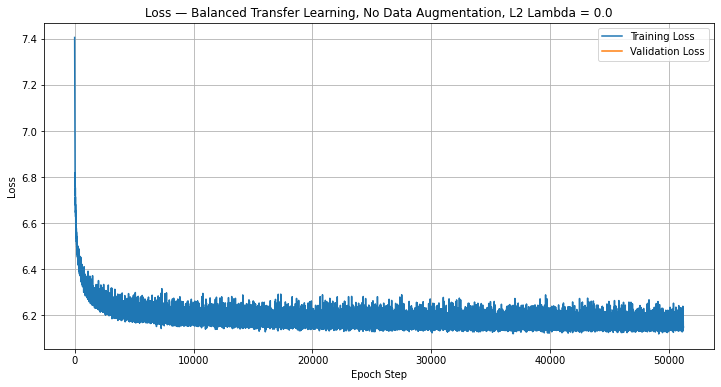

In [128]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {l2_alpha}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

In [177]:
torch.save(model.state_dict(), '/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211203.pth')

## Train classifier

Freeze pre-head layers, unfreeze classification layers

In [130]:
model.train()
model.prep_classifier()

Define labeled dataset to use

Train model

In [219]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )
model.to(DEVICE)
criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [220]:
def transform_null(var):
    return(var)

In [242]:
# dataset_train = util.dataset_supervised(
#                                     X_train,
#                                     y_train,
#                                     class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64
#                                     )



dataset_train = util.dataset_simCLR(
                                    X=torch.as_tensor(X_labeled_train, device='cpu', dtype=torch.float32), 
                                    y=torch.as_tensor(y_labeled_train, device='cpu', dtype=torch.float32),
                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=transform_null,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1200,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [243]:
model.reinit_classifier()

In [244]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

model.prep_contrast()
model.to(DEVICE)

l2_alpha = 0.000

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    L2_alpha=0.05, # TODO: implement for simCLR
                                    mode='supervised',
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )

epoch: 0
Iter: 0/1, loss_train: 0.95973, loss_val: nan, lr: 0.001
epoch: 1
Iter: 0/1, loss_train: 0.96852, loss_val: nan, lr: 0.001
epoch: 2
Iter: 0/1, loss_train: 0.96175, loss_val: nan, lr: 0.001
epoch: 3
Iter: 0/1, loss_train: 0.95463, loss_val: nan, lr: 0.001
epoch: 4
Iter: 0/1, loss_train: 0.95894, loss_val: nan, lr: 0.001
epoch: 5
Iter: 0/1, loss_train: 0.94499, loss_val: nan, lr: 0.001
epoch: 6
Iter: 0/1, loss_train: 0.95069, loss_val: nan, lr: 0.001
epoch: 7
Iter: 0/1, loss_train: 0.94492, loss_val: nan, lr: 0.001
epoch: 8
Iter: 0/1, loss_train: 0.94367, loss_val: nan, lr: 0.001
epoch: 9
Iter: 0/1, loss_train: 0.9401, loss_val: nan, lr: 0.001
epoch: 10
Iter: 0/1, loss_train: 0.93247, loss_val: nan, lr: 0.001
epoch: 11
Iter: 0/1, loss_train: 0.92431, loss_val: nan, lr: 0.001
epoch: 12
Iter: 0/1, loss_train: 0.93411, loss_val: nan, lr: 0.001
epoch: 13
Iter: 0/1, loss_train: 0.92318, loss_val: nan, lr: 0.001
epoch: 14
Iter: 0/1, loss_train: 0.92373, loss_val: nan, lr: 0.001
epoch:

Iter: 0/1, loss_train: 0.84602, loss_val: nan, lr: 0.001
epoch: 127
Iter: 0/1, loss_train: 0.85531, loss_val: nan, lr: 0.001
epoch: 128
Iter: 0/1, loss_train: 0.85044, loss_val: nan, lr: 0.001
epoch: 129
Iter: 0/1, loss_train: 0.84588, loss_val: nan, lr: 0.001
epoch: 130
Iter: 0/1, loss_train: 0.8514, loss_val: nan, lr: 0.001
epoch: 131
Iter: 0/1, loss_train: 0.85869, loss_val: nan, lr: 0.001
epoch: 132
Iter: 0/1, loss_train: 0.84355, loss_val: nan, lr: 0.001
epoch: 133
Iter: 0/1, loss_train: 0.85372, loss_val: nan, lr: 0.001
epoch: 134
Iter: 0/1, loss_train: 0.85008, loss_val: nan, lr: 0.001
epoch: 135
Iter: 0/1, loss_train: 0.85674, loss_val: nan, lr: 0.001
epoch: 136
Iter: 0/1, loss_train: 0.84676, loss_val: nan, lr: 0.001
epoch: 137
Iter: 0/1, loss_train: 0.85405, loss_val: nan, lr: 0.001
epoch: 138
Iter: 0/1, loss_train: 0.85867, loss_val: nan, lr: 0.001
epoch: 139
Iter: 0/1, loss_train: 0.84457, loss_val: nan, lr: 0.001
epoch: 140
Iter: 0/1, loss_train: 0.84563, loss_val: nan, lr

KeyboardInterrupt: 

Evalculate model

<IPython.core.display.Javascript object>


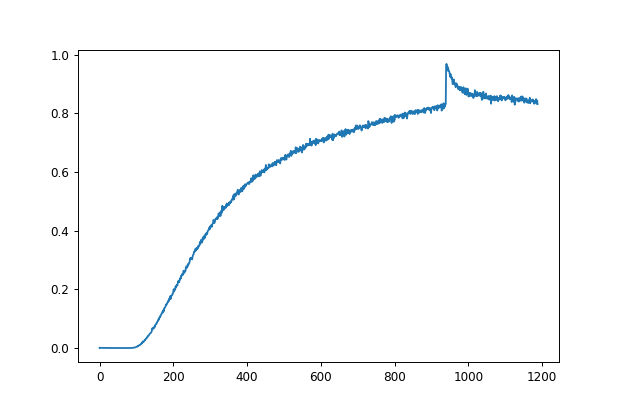

<IPython.core.display.Javascript object>


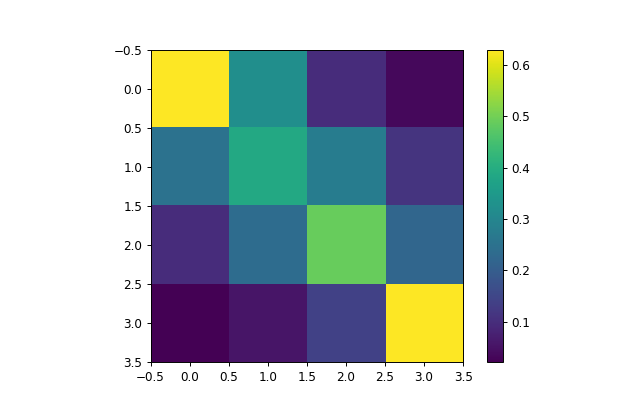

In [245]:
%matplotlib notebook

plt.figure()
plt.plot(loss_rolling_train)

data_in = torch.as_tensor(X_labeled_val, dtype=torch.float32, device=DEVICE)
# data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_val)
# cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm)
plt.colorbar()

<IPython.core.display.Javascript object>


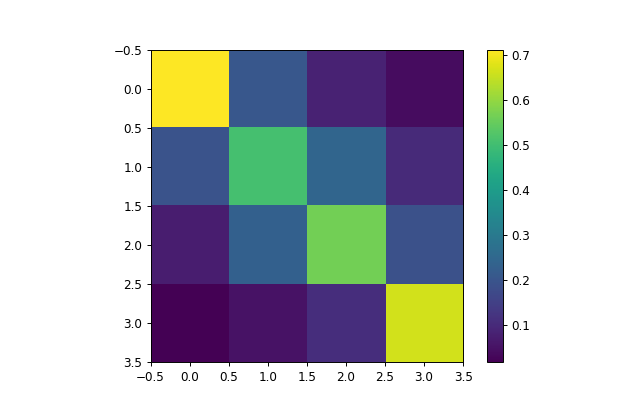

In [246]:
%matplotlib notebook
data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm)
plt.colorbar()

## Check embeddings

In [ ]:
torch.cuda.empty_cache()

In [ ]:
### REMOVE

DEVICE='cuda'
# DEVICE='cpu'

In [ ]:
model.to(DEVICE)

In [ ]:
features = model(util.tile_channels(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...], dim=1)).detach()
# features = model(torch.tensor(images_labeled[labels != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [ ]:
_, features_embedded, _, evr = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [ ]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=80.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
# features_embedded = tsne.fit_transform(features.cpu())
features_embedded = tsne.fit_transform(features_embedded[:,:5].cpu())

In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


In [ ]:
plt.figure()
plt.imshow(features.cpu().detach(), aspect='auto', interpolation='none')

In [ ]:
plt.figure()
plt.plot(evr)
plt.yscale('log')

## Check filters

In [ ]:
list(model.state_dict().keys())

In [ ]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()

# Graveyard

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

model.to(DEVICE)

# penalized_params = list(model.modules())[-1].parameters()
# penalized_params = torch.cat([_.view(-1) for _ in penalized_params], -1)

early_stopping = 50
prv_best_val = np.inf
early_stopping_cnt = 0

l2_alpha = 0.1

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
#     loss_rolling_train, loss_rolling_val = training_supervised.epoch_step(dataloader_train, 
#                                     model, 
#                                     optimizer, 
#                                     criterion, 

#                                     penalized_params, l2_alpha,

#                                     scheduler=scheduler,
#                                     loss_rolling_train=losses_train, 
#                                     device=DEVICE, 
#                                     loss_rolling_val=losses_val,
#                                     verbose=2,
#                                     verbose_update_period=100,
                                   
#                                     do_validation=True,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
#                                    )
    
    loss_rolling_train, loss_rolling_val = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=100,
                                   
                                    do_validation=True,
                                    X_val=x_feed_through_val,
                                    y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    if early_stopping:
      if len(loss_rolling_val) > 0:
        if loss_rolling_val[-1] < prv_best_val:
          early_stopping_cnt = 0
          prv_best_val = loss_rolling_val[-1]
          torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth')
        else:
          early_stopping_cnt += 1
    
      if early_stopping_cnt >= early_stopping:
        model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth'))
        break
    
    # torch_helpers.show_all_tensors(globals())
    
    features_train = model(x_feed_through_tr)
    features_train = features_train.cpu().detach().numpy()
    features_val = model(x_feed_through_val)
    features_val = features_val.cpu().detach().numpy()
    # y_hat = scipy.special.softmax(features_val, axis=-1) # logreg.predict_proba(features_val)
    
    print('Training Confusion Matrix')
    print(get_cm(features_train, y_train))
    print()
    print(logistic_pred_train)

    print()
    print()

    print('Val Confusion Matrix')
    print(get_cm(features_val, y_val))
    print()
    print(logistic_pred_val)

    # model.to(DEVICE)
    print()
    print()
